In [1]:
import os
import random
import shutil
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Network Definition

In [2]:
input_length = 28*28
hidden_0 = 256
hidden_1 = 256
hidden_2 = 256
output_length = 10

In [3]:
class MLP(nn.Module):
    def __init__(self, dropout=0.5):
        super(MLP, self).__init__()
        
        self.fc0   = nn.Linear(input_length, hidden_0)
        self.bn0   = nn.BatchNorm1d(hidden_0)
        self.sig0 = nn.Sigmoid()
        self.drop0 = nn.Dropout(dropout)
        
        self.fc1   = nn.Linear(hidden_0, hidden_1)
        self.bn1   = nn.BatchNorm1d(hidden_1)
        self.sig1 = nn.Sigmoid()
        self.drop1 = nn.Dropout(dropout)
        
        self.fc2   = nn.Linear(hidden_1, hidden_2)
        self.bn2   = nn.BatchNorm1d(hidden_2)
        self.sig2  = nn.Sigmoid()
        self.drop2 = nn.Dropout(dropout)
        
        self.out   = nn.Linear(hidden_2, output_length)

    def forward(self, x):
        
        out = x.reshape(x.shape[0], -1)
        out = self.drop0(self.sig0(self.bn0(self.fc0(out))))
        out = self.drop1(self.sig1(self.bn1(self.fc1(out))))
        out = self.drop2(self.sig2(self.bn2(self.fc2(out))))
        out = self.out(out)
        
        return out

# Random Seed Utility

In [4]:
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define Dataloader

In [5]:
def get_dataloaders(batch_size):
    transform = transforms.ToTensor()
    dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST("data", train=False, download=True, transform=transform)
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size),
        DataLoader(test_dataset, batch_size=batch_size),
    )

# Training Pipeline

In [6]:
def train_validate_test(config, save_dir):
    set_random_seed()
    os.makedirs(save_dir, exist_ok=True)
    log_file = os.path.join(save_dir, "training_log.txt")
    resume_path = os.path.join(save_dir, "checkpoint.pth")

    epochs, batch_size, lr1, lr2, lr3, dropout = config
    train_loader, val_loader, test_loader = get_dataloaders(batch_size)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = MLP(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr1)

    start_epoch = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    if os.path.exists(resume_path):
        ckpt = torch.load(resume_path)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        history = ckpt["history"]
        start_epoch = ckpt["epoch"] + 1
        print(f"🔄 Resuming from epoch {start_epoch}")
    else:
        with open(log_file, "w") as f:
            f.write("Training started\n")

    def evaluate(loader):
        model.eval()
        loss_total, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                loss_total += loss.item() * x.size(0)
                _, pred = out.max(1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return loss_total / total, correct / total

    for epoch in range(start_epoch, epochs):
        model.train()
        lr = lr1 if epoch < 0.5 * epochs else lr2 if epoch < 0.8 * epochs else lr3
        for g in optimizer.param_groups:
            g["lr"] = lr

        train_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)

        val_loss, val_acc = evaluate(val_loader)
        train_loss /= total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        log_line = (f"Epoch {epoch+1}/{epochs} - LR: {lr:.5f} | "
                    f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                    f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(log_line)
        with open(log_file, "a") as f:
            f.write(log_line + "\n")

        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history
        }, resume_path)

    # Final Test
    test_loss, test_acc = evaluate(test_loader)
    final_line = f"Final Test Loss: {test_loss:.4f} Accuracy: {test_acc:.4f}"
    print(final_line)
    with open(log_file, "a") as f:
        f.write(final_line + "\n")
        f.write("Training completed\n")

    torch.save(model.state_dict(), os.path.join(save_dir, "final_model.pth"))

    # Plot and show
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.legend()
    plt.title("Accuracy")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_plot.png"))
    plt.show()

    return test_acc

# Exploring Best Hyperparameter

In [7]:
def Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates):
    output_root = root_path
    os.makedirs(output_root, exist_ok=True)
    
    epochs = epochs
    batch_sizes = batch_sizes
    lr_pool = lr_pool
    
    # Generate descending LR combinations
    lr_combos = [combo for combo in itertools.product(lr_pool, repeat=3)
                 if (combo[0] > combo[1] > combo[2]) or (combo[0] == combo[1] == combo[2])]
    
    all_runs = [
        f"batch{bs}_lr{lr1}_{lr2}_{lr3}"
        for bs, (lr1, lr2, lr3) in itertools.product(batch_sizes, lr_combos)
    ]
    
    completed_runs = []
    for run in all_runs:
        log_path = os.path.join(output_root, run, "training_log.txt")
        if os.path.exists(log_path):
            with open(log_path, "r") as f:
                if any("Training completed" in line for line in f):
                    completed_runs.append(run)
    
    if len(completed_runs) == len(all_runs):
        print("✅ All combinations completed. Restarting from scratch...")
        for run in all_runs:
            shutil.rmtree(os.path.join(output_root, run), ignore_errors=True)
        if os.path.exists(os.path.join(output_root, "summary.csv")):
            os.remove(os.path.join(output_root, "summary.csv"))
        completed_runs = []
    
    results = []
    for batch_size, (lr1, lr2, lr3), dropout in itertools.product(batch_sizes, lr_combos, dropout_rates):
        run_name = f"batch{batch_size}_lr{lr1}_{lr2}_{lr3}_dp{dropout}"
        save_dir = os.path.join(output_root, run_name)
    
        if run_name in completed_runs:
            print(f"✅ Skipping {run_name}")
            with open(os.path.join(save_dir, "training_log.txt")) as f:
                for line in f:
                    if "Final Test Loss" in line:
                        acc = float(line.strip().split()[-1])
                        results.append((run_name, acc))
            continue
    
        print(f"🚀 Running: {run_name}")
        acc = train_validate_test([epochs, batch_size, lr1, lr2, lr3, dropout], save_dir)
        results.append((run_name, acc))
    
    results.sort(key=lambda x: x[1], reverse=True)
    best_config, best_acc = results[0]
    print(f"🏆 Best Config: {best_config} Accuracy: {best_acc:.4f}")
    
    with open(os.path.join(output_root, "summary.csv"), "w") as f:
        f.write("Config,Accuracy\n")
        for name, acc in results:
            f.write(f"{name},{acc:.4f}\n")

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3551, Acc: 0.8913 | Val Loss: 0.2053, Acc: 0.9378


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1780, Acc: 0.9464 | Val Loss: 0.1542, Acc: 0.9547


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1281, Acc: 0.9612 | Val Loss: 0.1126, Acc: 0.9650


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0938, Acc: 0.9707 | Val Loss: 0.1191, Acc: 0.9642


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0785, Acc: 0.9755 | Val Loss: 0.1128, Acc: 0.9673


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9789 | Val Loss: 0.1031, Acc: 0.9714


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9825 | Val Loss: 0.1078, Acc: 0.9703


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9836 | Val Loss: 0.0881, Acc: 0.9768


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9861 | Val Loss: 0.0942, Acc: 0.9750


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9864 | Val Loss: 0.0987, Acc: 0.9742


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9895 | Val Loss: 0.1065, Acc: 0.9738


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9897 | Val Loss: 0.1053, Acc: 0.9752


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9908 | Val Loss: 0.1049, Acc: 0.9751


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9900 | Val Loss: 0.0972, Acc: 0.9759


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9922 | Val Loss: 0.1106, Acc: 0.9752


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9920 | Val Loss: 0.1094, Acc: 0.9762


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9930 | Val Loss: 0.1009, Acc: 0.9778


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9932 | Val Loss: 0.1106, Acc: 0.9755


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9929 | Val Loss: 0.0956, Acc: 0.9779


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9952 | Val Loss: 0.1075, Acc: 0.9776


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9939 | Val Loss: 0.0983, Acc: 0.9778


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9942 | Val Loss: 0.1060, Acc: 0.9788


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9946 | Val Loss: 0.1138, Acc: 0.9766


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9948 | Val Loss: 0.1170, Acc: 0.9755


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9957 | Val Loss: 0.1083, Acc: 0.9784


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1077, Acc: 0.9790


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.1027, Acc: 0.9802


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1170, Acc: 0.9768


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.1205, Acc: 0.9760


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1128, Acc: 0.9777


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.1199, Acc: 0.9766


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.1000, Acc: 0.9791


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1126, Acc: 0.9788


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.1144, Acc: 0.9796


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.1095, Acc: 0.9778


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1144, Acc: 0.9788


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1036, Acc: 0.9798


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1000, Acc: 0.9785


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.1030, Acc: 0.9806


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1097, Acc: 0.9793


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.1247, Acc: 0.9778


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.1228, Acc: 0.9792


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1166, Acc: 0.9791


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9968 | Val Loss: 0.1110, Acc: 0.9796


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1195, Acc: 0.9783


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1193, Acc: 0.9775


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1322, Acc: 0.9768


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1071, Acc: 0.9799


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1149, Acc: 0.9788


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1167, Acc: 0.9812


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1095, Acc: 0.9804


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1117, Acc: 0.9804


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1097, Acc: 0.9802


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1064, Acc: 0.9812


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1226, Acc: 0.9795


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1390, Acc: 0.9768


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1169, Acc: 0.9798


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1165, Acc: 0.9812


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1064, Acc: 0.9812


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1181, Acc: 0.9804


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1308, Acc: 0.9796


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1181, Acc: 0.9819


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1138, Acc: 0.9807


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1100, Acc: 0.9828


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1233, Acc: 0.9798


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1243, Acc: 0.9793


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1184, Acc: 0.9809


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1332, Acc: 0.9788


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1262, Acc: 0.9813


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.1283, Acc: 0.9798


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1293, Acc: 0.9797


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1243, Acc: 0.9802


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1314, Acc: 0.9803


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1290, Acc: 0.9802


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1193, Acc: 0.9792


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1324, Acc: 0.9794


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1205, Acc: 0.9822


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1306, Acc: 0.9796


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1294, Acc: 0.9792


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1267, Acc: 0.9808


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1382, Acc: 0.9792


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1250, Acc: 0.9789


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9983 | Val Loss: 0.1388, Acc: 0.9800


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1276, Acc: 0.9808


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9986 | Val Loss: 0.1254, Acc: 0.9809


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9983 | Val Loss: 0.1231, Acc: 0.9821


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1427, Acc: 0.9795


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1476, Acc: 0.9790


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1330, Acc: 0.9797


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1383, Acc: 0.9812


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1313, Acc: 0.9798


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1347, Acc: 0.9795


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1280, Acc: 0.9791


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1332, Acc: 0.9816


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1389, Acc: 0.9803


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1427, Acc: 0.9799


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1324, Acc: 0.9806


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1381, Acc: 0.9809


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1410, Acc: 0.9804


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1354, Acc: 0.9818


Final Test Loss: 0.1345 Accuracy: 0.9794


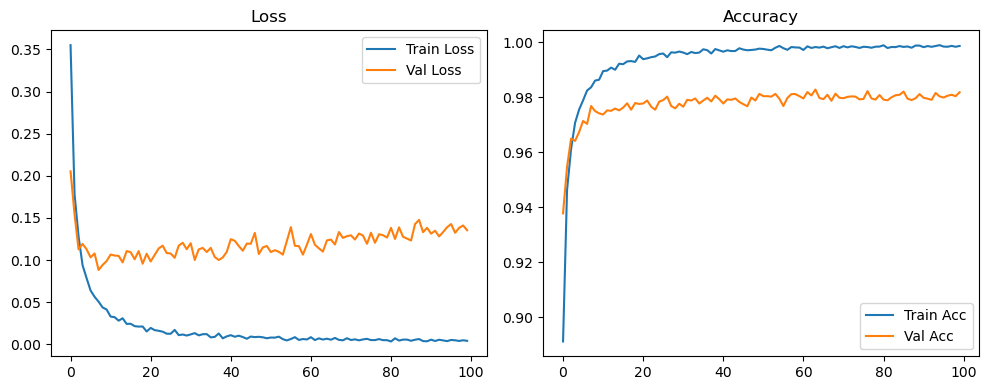

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4441, Acc: 0.8629 | Val Loss: 0.2328, Acc: 0.9307


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2409, Acc: 0.9271 | Val Loss: 0.1534, Acc: 0.9570


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1788, Acc: 0.9453 | Val Loss: 0.1139, Acc: 0.9668


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1422, Acc: 0.9561 | Val Loss: 0.1093, Acc: 0.9656


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1242, Acc: 0.9621 | Val Loss: 0.1062, Acc: 0.9688


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1099, Acc: 0.9657 | Val Loss: 0.0899, Acc: 0.9728


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0952, Acc: 0.9704 | Val Loss: 0.0858, Acc: 0.9755


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0867, Acc: 0.9732 | Val Loss: 0.0873, Acc: 0.9752


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0783, Acc: 0.9753 | Val Loss: 0.0830, Acc: 0.9771


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0748, Acc: 0.9771 | Val Loss: 0.0811, Acc: 0.9770


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0660, Acc: 0.9800 | Val Loss: 0.0852, Acc: 0.9779


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9789 | Val Loss: 0.0763, Acc: 0.9792


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9812 | Val Loss: 0.0771, Acc: 0.9778


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9823 | Val Loss: 0.0828, Acc: 0.9762


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9818 | Val Loss: 0.0765, Acc: 0.9792


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9830 | Val Loss: 0.0772, Acc: 0.9797


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9849 | Val Loss: 0.0732, Acc: 0.9799


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9857 | Val Loss: 0.0808, Acc: 0.9785


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9850 | Val Loss: 0.0736, Acc: 0.9808


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9859 | Val Loss: 0.0705, Acc: 0.9812


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9874 | Val Loss: 0.0765, Acc: 0.9806


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9870 | Val Loss: 0.0700, Acc: 0.9815


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9881 | Val Loss: 0.0701, Acc: 0.9816


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9881 | Val Loss: 0.0751, Acc: 0.9818


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9882 | Val Loss: 0.0842, Acc: 0.9800


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9899 | Val Loss: 0.0729, Acc: 0.9814


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9896 | Val Loss: 0.0762, Acc: 0.9812


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9894 | Val Loss: 0.0823, Acc: 0.9790


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9911 | Val Loss: 0.0850, Acc: 0.9807


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9911 | Val Loss: 0.0782, Acc: 0.9808


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9905 | Val Loss: 0.0722, Acc: 0.9811


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9904 | Val Loss: 0.0760, Acc: 0.9823


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9904 | Val Loss: 0.0745, Acc: 0.9821


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9916 | Val Loss: 0.0771, Acc: 0.9818


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9913 | Val Loss: 0.0785, Acc: 0.9808


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9911 | Val Loss: 0.0768, Acc: 0.9820


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9923 | Val Loss: 0.0741, Acc: 0.9828


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9912 | Val Loss: 0.0820, Acc: 0.9798


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9917 | Val Loss: 0.0753, Acc: 0.9820


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9921 | Val Loss: 0.0817, Acc: 0.9819


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9926 | Val Loss: 0.0790, Acc: 0.9812


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9926 | Val Loss: 0.0727, Acc: 0.9817


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9921 | Val Loss: 0.0731, Acc: 0.9812


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9936 | Val Loss: 0.0795, Acc: 0.9812


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.0749, Acc: 0.9828


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9930 | Val Loss: 0.0748, Acc: 0.9823


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9927 | Val Loss: 0.0816, Acc: 0.9809


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9939 | Val Loss: 0.0907, Acc: 0.9816


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9934 | Val Loss: 0.0864, Acc: 0.9819


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9929 | Val Loss: 0.0773, Acc: 0.9818


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9939 | Val Loss: 0.0818, Acc: 0.9812


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9932 | Val Loss: 0.0783, Acc: 0.9820


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9942 | Val Loss: 0.0768, Acc: 0.9816


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9935 | Val Loss: 0.0778, Acc: 0.9823


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9943 | Val Loss: 0.0893, Acc: 0.9808


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9935 | Val Loss: 0.0825, Acc: 0.9812


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.0854, Acc: 0.9821


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.0789, Acc: 0.9812


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.0854, Acc: 0.9821


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9942 | Val Loss: 0.0768, Acc: 0.9822


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9944 | Val Loss: 0.0776, Acc: 0.9832


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9943 | Val Loss: 0.0827, Acc: 0.9823


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9949 | Val Loss: 0.0850, Acc: 0.9832


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.0862, Acc: 0.9816


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.0883, Acc: 0.9833


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9948 | Val Loss: 0.0845, Acc: 0.9827


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9940 | Val Loss: 0.0849, Acc: 0.9822


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.0824, Acc: 0.9840


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9951 | Val Loss: 0.0868, Acc: 0.9828


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0794, Acc: 0.9826


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9949 | Val Loss: 0.0790, Acc: 0.9834


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0885, Acc: 0.9820


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9948 | Val Loss: 0.0849, Acc: 0.9828


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9949 | Val Loss: 0.0855, Acc: 0.9832


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9948 | Val Loss: 0.0854, Acc: 0.9836


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9952 | Val Loss: 0.0822, Acc: 0.9831


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.0918, Acc: 0.9828


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9947 | Val Loss: 0.0839, Acc: 0.9820


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9949 | Val Loss: 0.0802, Acc: 0.9835


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.0874, Acc: 0.9834


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9959 | Val Loss: 0.0898, Acc: 0.9832


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9954 | Val Loss: 0.0841, Acc: 0.9836


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9956 | Val Loss: 0.0903, Acc: 0.9823


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9954 | Val Loss: 0.0884, Acc: 0.9831


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9952 | Val Loss: 0.0821, Acc: 0.9822


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.0822, Acc: 0.9832


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.0840, Acc: 0.9822


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0885, Acc: 0.9818


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9953 | Val Loss: 0.0847, Acc: 0.9824


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.0845, Acc: 0.9832


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.0878, Acc: 0.9822


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.0819, Acc: 0.9830


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.0866, Acc: 0.9822


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.1007, Acc: 0.9830


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.0862, Acc: 0.9828


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.0816, Acc: 0.9836


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.0833, Acc: 0.9832


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9960 | Val Loss: 0.0873, Acc: 0.9815


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9956 | Val Loss: 0.0840, Acc: 0.9832


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.0848, Acc: 0.9830


Final Test Loss: 0.0648 Accuracy: 0.9864


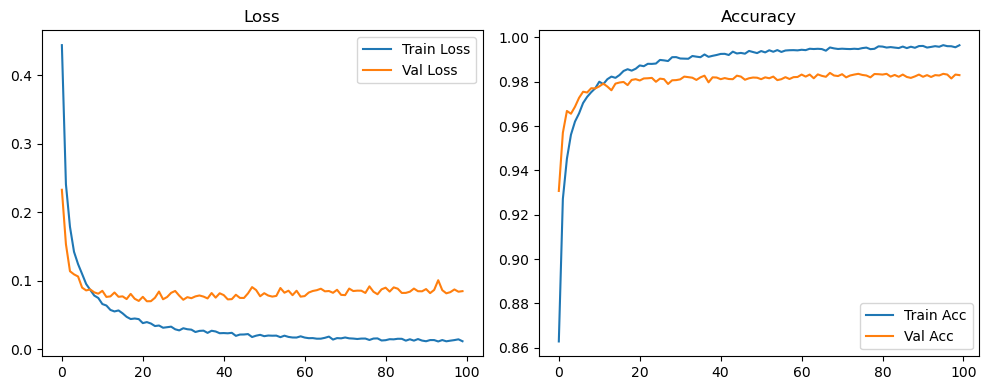

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6593, Acc: 0.7926 | Val Loss: 0.2740, Acc: 0.9208


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3873, Acc: 0.8837 | Val Loss: 0.2056, Acc: 0.9409


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3135, Acc: 0.9065 | Val Loss: 0.1550, Acc: 0.9523


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2589, Acc: 0.9234 | Val Loss: 0.1370, Acc: 0.9573


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2354, Acc: 0.9295 | Val Loss: 0.1238, Acc: 0.9625


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2163, Acc: 0.9354 | Val Loss: 0.1085, Acc: 0.9679


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.2007, Acc: 0.9397 | Val Loss: 0.1044, Acc: 0.9692


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1871, Acc: 0.9448 | Val Loss: 0.0972, Acc: 0.9703


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1791, Acc: 0.9465 | Val Loss: 0.0951, Acc: 0.9717


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1694, Acc: 0.9486 | Val Loss: 0.0926, Acc: 0.9713


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1559, Acc: 0.9530 | Val Loss: 0.0938, Acc: 0.9706


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1518, Acc: 0.9538 | Val Loss: 0.0810, Acc: 0.9756


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1437, Acc: 0.9569 | Val Loss: 0.0803, Acc: 0.9757


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1403, Acc: 0.9585 | Val Loss: 0.0824, Acc: 0.9759


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1342, Acc: 0.9600 | Val Loss: 0.0836, Acc: 0.9753


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1315, Acc: 0.9595 | Val Loss: 0.0794, Acc: 0.9760


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1296, Acc: 0.9609 | Val Loss: 0.0771, Acc: 0.9769


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1230, Acc: 0.9625 | Val Loss: 0.0751, Acc: 0.9770


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1214, Acc: 0.9628 | Val Loss: 0.0751, Acc: 0.9771


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1183, Acc: 0.9637 | Val Loss: 0.0760, Acc: 0.9766


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1115, Acc: 0.9656 | Val Loss: 0.0738, Acc: 0.9782


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1151, Acc: 0.9647 | Val Loss: 0.0743, Acc: 0.9774


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1095, Acc: 0.9663 | Val Loss: 0.0742, Acc: 0.9779


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1066, Acc: 0.9671 | Val Loss: 0.0720, Acc: 0.9789


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1023, Acc: 0.9684 | Val Loss: 0.0740, Acc: 0.9786


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1019, Acc: 0.9680 | Val Loss: 0.0685, Acc: 0.9793


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1018, Acc: 0.9693 | Val Loss: 0.0715, Acc: 0.9795


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0984, Acc: 0.9695 | Val Loss: 0.0725, Acc: 0.9788


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0953, Acc: 0.9699 | Val Loss: 0.0714, Acc: 0.9793


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0974, Acc: 0.9702 | Val Loss: 0.0694, Acc: 0.9799


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0949, Acc: 0.9709 | Val Loss: 0.0667, Acc: 0.9808


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0908, Acc: 0.9714 | Val Loss: 0.0691, Acc: 0.9794


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0897, Acc: 0.9723 | Val Loss: 0.0670, Acc: 0.9802


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0900, Acc: 0.9725 | Val Loss: 0.0704, Acc: 0.9787


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0892, Acc: 0.9725 | Val Loss: 0.0667, Acc: 0.9803


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0865, Acc: 0.9737 | Val Loss: 0.0673, Acc: 0.9806


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0821, Acc: 0.9744 | Val Loss: 0.0687, Acc: 0.9788


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0833, Acc: 0.9735 | Val Loss: 0.0705, Acc: 0.9798


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0844, Acc: 0.9743 | Val Loss: 0.0715, Acc: 0.9801


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0833, Acc: 0.9741 | Val Loss: 0.0684, Acc: 0.9798


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0848, Acc: 0.9736 | Val Loss: 0.0689, Acc: 0.9801


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0773, Acc: 0.9758 | Val Loss: 0.0712, Acc: 0.9808


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0777, Acc: 0.9763 | Val Loss: 0.0699, Acc: 0.9801


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0780, Acc: 0.9762 | Val Loss: 0.0691, Acc: 0.9810


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0785, Acc: 0.9755 | Val Loss: 0.0676, Acc: 0.9803


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9770 | Val Loss: 0.0679, Acc: 0.9801


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0766, Acc: 0.9766 | Val Loss: 0.0692, Acc: 0.9811


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0733, Acc: 0.9766 | Val Loss: 0.0689, Acc: 0.9802


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9766 | Val Loss: 0.0721, Acc: 0.9816


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0727, Acc: 0.9773 | Val Loss: 0.0714, Acc: 0.9804


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0725, Acc: 0.9765 | Val Loss: 0.0673, Acc: 0.9811


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0721, Acc: 0.9771 | Val Loss: 0.0669, Acc: 0.9808


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0739, Acc: 0.9770 | Val Loss: 0.0666, Acc: 0.9808


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9765 | Val Loss: 0.0717, Acc: 0.9802


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0672, Acc: 0.9784 | Val Loss: 0.0711, Acc: 0.9807


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0717, Acc: 0.9780 | Val Loss: 0.0691, Acc: 0.9801


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0729, Acc: 0.9775 | Val Loss: 0.0686, Acc: 0.9809


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0657, Acc: 0.9796 | Val Loss: 0.0694, Acc: 0.9808


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0677, Acc: 0.9796 | Val Loss: 0.0707, Acc: 0.9804


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0691, Acc: 0.9783 | Val Loss: 0.0675, Acc: 0.9801


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0642, Acc: 0.9801 | Val Loss: 0.0753, Acc: 0.9802


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9781 | Val Loss: 0.0712, Acc: 0.9802


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0658, Acc: 0.9797 | Val Loss: 0.0718, Acc: 0.9801


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0626, Acc: 0.9802 | Val Loss: 0.0717, Acc: 0.9804


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0654, Acc: 0.9798 | Val Loss: 0.0707, Acc: 0.9797


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0602, Acc: 0.9809 | Val Loss: 0.0698, Acc: 0.9807


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0657, Acc: 0.9800 | Val Loss: 0.0708, Acc: 0.9799


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0650, Acc: 0.9792 | Val Loss: 0.0703, Acc: 0.9804


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0600, Acc: 0.9814 | Val Loss: 0.0727, Acc: 0.9800


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0632, Acc: 0.9799 | Val Loss: 0.0691, Acc: 0.9814


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0626, Acc: 0.9803 | Val Loss: 0.0679, Acc: 0.9814


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0591, Acc: 0.9812 | Val Loss: 0.0700, Acc: 0.9802


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0622, Acc: 0.9809 | Val Loss: 0.0692, Acc: 0.9815


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0637, Acc: 0.9804 | Val Loss: 0.0687, Acc: 0.9812


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0578, Acc: 0.9824 | Val Loss: 0.0723, Acc: 0.9805


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9805 | Val Loss: 0.0680, Acc: 0.9819


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9817 | Val Loss: 0.0691, Acc: 0.9804


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9824 | Val Loss: 0.0717, Acc: 0.9809


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0626, Acc: 0.9811 | Val Loss: 0.0689, Acc: 0.9807


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9820 | Val Loss: 0.0695, Acc: 0.9815


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9817 | Val Loss: 0.0724, Acc: 0.9808


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9810 | Val Loss: 0.0670, Acc: 0.9822


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9814 | Val Loss: 0.0732, Acc: 0.9807


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0581, Acc: 0.9816 | Val Loss: 0.0674, Acc: 0.9816


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9820 | Val Loss: 0.0712, Acc: 0.9808


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0557, Acc: 0.9820 | Val Loss: 0.0679, Acc: 0.9811


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9832 | Val Loss: 0.0681, Acc: 0.9816


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9827 | Val Loss: 0.0708, Acc: 0.9805


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9818 | Val Loss: 0.0722, Acc: 0.9797


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0531, Acc: 0.9838 | Val Loss: 0.0755, Acc: 0.9808


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0548, Acc: 0.9830 | Val Loss: 0.0726, Acc: 0.9812


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0543, Acc: 0.9834 | Val Loss: 0.0698, Acc: 0.9816


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0544, Acc: 0.9831 | Val Loss: 0.0697, Acc: 0.9812


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0509, Acc: 0.9842 | Val Loss: 0.0697, Acc: 0.9824


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9826 | Val Loss: 0.0707, Acc: 0.9811


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9842 | Val Loss: 0.0720, Acc: 0.9816


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9841 | Val Loss: 0.0704, Acc: 0.9818


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0495, Acc: 0.9843 | Val Loss: 0.0714, Acc: 0.9809


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0530, Acc: 0.9829 | Val Loss: 0.0721, Acc: 0.9817


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9839 | Val Loss: 0.0693, Acc: 0.9812


Final Test Loss: 0.0608 Accuracy: 0.9830


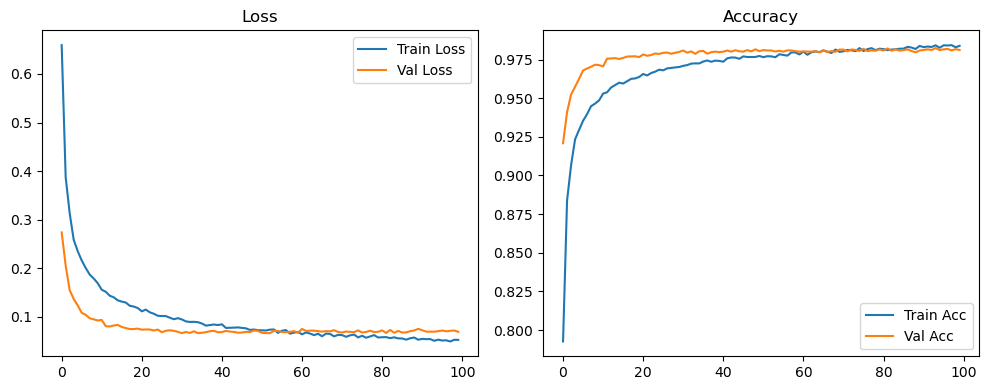

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3551, Acc: 0.8913 | Val Loss: 0.2053, Acc: 0.9378


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1780, Acc: 0.9464 | Val Loss: 0.1542, Acc: 0.9547


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1281, Acc: 0.9612 | Val Loss: 0.1126, Acc: 0.9650


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0938, Acc: 0.9707 | Val Loss: 0.1191, Acc: 0.9642


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0785, Acc: 0.9755 | Val Loss: 0.1128, Acc: 0.9673


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9789 | Val Loss: 0.1031, Acc: 0.9714


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9825 | Val Loss: 0.1078, Acc: 0.9703


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9836 | Val Loss: 0.0881, Acc: 0.9768


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9861 | Val Loss: 0.0942, Acc: 0.9750


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9864 | Val Loss: 0.0987, Acc: 0.9742


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9895 | Val Loss: 0.1065, Acc: 0.9738


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9897 | Val Loss: 0.1053, Acc: 0.9752


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9908 | Val Loss: 0.1049, Acc: 0.9751


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9900 | Val Loss: 0.0972, Acc: 0.9759


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9922 | Val Loss: 0.1106, Acc: 0.9752


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9920 | Val Loss: 0.1094, Acc: 0.9762


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9930 | Val Loss: 0.1009, Acc: 0.9778


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9932 | Val Loss: 0.1106, Acc: 0.9755


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9929 | Val Loss: 0.0956, Acc: 0.9779


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9952 | Val Loss: 0.1075, Acc: 0.9776


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9939 | Val Loss: 0.0983, Acc: 0.9778


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9942 | Val Loss: 0.1060, Acc: 0.9788


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9946 | Val Loss: 0.1138, Acc: 0.9766


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9948 | Val Loss: 0.1170, Acc: 0.9755


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9957 | Val Loss: 0.1083, Acc: 0.9784


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1077, Acc: 0.9790


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.1027, Acc: 0.9802


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1170, Acc: 0.9768


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.1205, Acc: 0.9760


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1128, Acc: 0.9777


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.1199, Acc: 0.9766


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.1000, Acc: 0.9791


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1126, Acc: 0.9788


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.1144, Acc: 0.9796


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.1095, Acc: 0.9778


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1144, Acc: 0.9788


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1036, Acc: 0.9798


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1000, Acc: 0.9785


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.1030, Acc: 0.9806


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1097, Acc: 0.9793


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.1247, Acc: 0.9778


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.1228, Acc: 0.9792


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1166, Acc: 0.9791


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9968 | Val Loss: 0.1110, Acc: 0.9796


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1195, Acc: 0.9783


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1193, Acc: 0.9775


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1322, Acc: 0.9768


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1071, Acc: 0.9799


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1149, Acc: 0.9788


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1167, Acc: 0.9812


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1074, Acc: 0.9822


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1073, Acc: 0.9819


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1055, Acc: 0.9818


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1089, Acc: 0.9822


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1131, Acc: 0.9818


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1101, Acc: 0.9830


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1143, Acc: 0.9829


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1161, Acc: 0.9818


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1110, Acc: 0.9822


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1139, Acc: 0.9821


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1171, Acc: 0.9822


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1163, Acc: 0.9822


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1288, Acc: 0.9808


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1182, Acc: 0.9806


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9992 | Val Loss: 0.1243, Acc: 0.9812


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1274, Acc: 0.9814


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1231, Acc: 0.9816


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1373, Acc: 0.9817


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1368, Acc: 0.9812


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1211, Acc: 0.9837


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1284, Acc: 0.9812


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1264, Acc: 0.9822


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1293, Acc: 0.9807


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1240, Acc: 0.9818


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1264, Acc: 0.9808


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1360, Acc: 0.9804


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1292, Acc: 0.9828


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1301, Acc: 0.9816


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1359, Acc: 0.9799


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1232, Acc: 0.9824


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1259, Acc: 0.9828


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1289, Acc: 0.9822


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1245, Acc: 0.9836


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1221, Acc: 0.9838


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1263, Acc: 0.9828


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1230, Acc: 0.9830


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1278, Acc: 0.9829


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1274, Acc: 0.9828


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1241, Acc: 0.9838


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1218, Acc: 0.9833


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1262, Acc: 0.9831


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1272, Acc: 0.9843


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1256, Acc: 0.9838


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1306, Acc: 0.9832


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1338, Acc: 0.9834


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1299, Acc: 0.9835


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1309, Acc: 0.9831


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1312, Acc: 0.9829


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1326, Acc: 0.9831


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1232, Acc: 0.9841


Final Test Loss: 0.1256 Accuracy: 0.9836


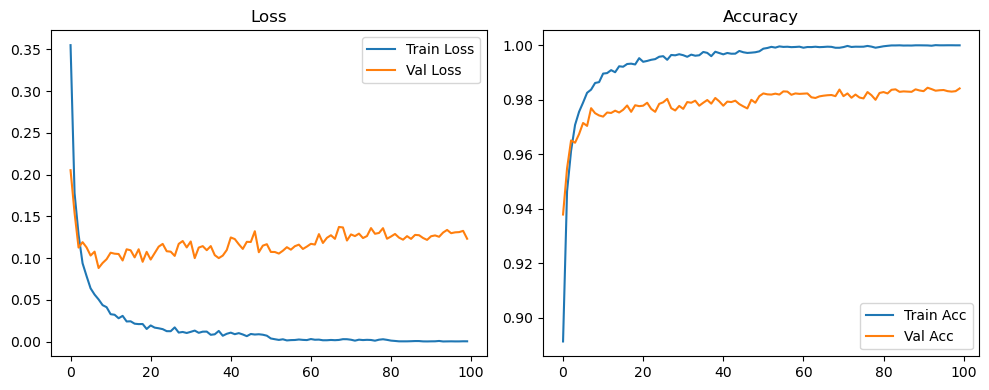

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4441, Acc: 0.8629 | Val Loss: 0.2328, Acc: 0.9307


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2409, Acc: 0.9271 | Val Loss: 0.1534, Acc: 0.9570


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1788, Acc: 0.9453 | Val Loss: 0.1139, Acc: 0.9668


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1422, Acc: 0.9561 | Val Loss: 0.1093, Acc: 0.9656


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1242, Acc: 0.9621 | Val Loss: 0.1062, Acc: 0.9688


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1099, Acc: 0.9657 | Val Loss: 0.0899, Acc: 0.9728


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0952, Acc: 0.9704 | Val Loss: 0.0858, Acc: 0.9755


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0867, Acc: 0.9732 | Val Loss: 0.0873, Acc: 0.9752


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0783, Acc: 0.9753 | Val Loss: 0.0830, Acc: 0.9771


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0748, Acc: 0.9771 | Val Loss: 0.0811, Acc: 0.9770


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0660, Acc: 0.9800 | Val Loss: 0.0852, Acc: 0.9779


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9789 | Val Loss: 0.0763, Acc: 0.9792


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9812 | Val Loss: 0.0771, Acc: 0.9778


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9823 | Val Loss: 0.0828, Acc: 0.9762


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9818 | Val Loss: 0.0765, Acc: 0.9792


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9830 | Val Loss: 0.0772, Acc: 0.9797


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9849 | Val Loss: 0.0732, Acc: 0.9799


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9857 | Val Loss: 0.0808, Acc: 0.9785


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9850 | Val Loss: 0.0736, Acc: 0.9808


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9859 | Val Loss: 0.0705, Acc: 0.9812


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9874 | Val Loss: 0.0765, Acc: 0.9806


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9870 | Val Loss: 0.0700, Acc: 0.9815


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9881 | Val Loss: 0.0701, Acc: 0.9816


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9881 | Val Loss: 0.0751, Acc: 0.9818


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9882 | Val Loss: 0.0842, Acc: 0.9800


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9899 | Val Loss: 0.0729, Acc: 0.9814


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9896 | Val Loss: 0.0762, Acc: 0.9812


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9894 | Val Loss: 0.0823, Acc: 0.9790


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9911 | Val Loss: 0.0850, Acc: 0.9807


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9911 | Val Loss: 0.0782, Acc: 0.9808


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9905 | Val Loss: 0.0722, Acc: 0.9811


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9904 | Val Loss: 0.0760, Acc: 0.9823


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9904 | Val Loss: 0.0745, Acc: 0.9821


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9916 | Val Loss: 0.0771, Acc: 0.9818


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9913 | Val Loss: 0.0785, Acc: 0.9808


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9911 | Val Loss: 0.0768, Acc: 0.9820


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9923 | Val Loss: 0.0741, Acc: 0.9828


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9912 | Val Loss: 0.0820, Acc: 0.9798


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9917 | Val Loss: 0.0753, Acc: 0.9820


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9921 | Val Loss: 0.0817, Acc: 0.9819


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9926 | Val Loss: 0.0790, Acc: 0.9812


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9926 | Val Loss: 0.0727, Acc: 0.9817


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9921 | Val Loss: 0.0731, Acc: 0.9812


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9936 | Val Loss: 0.0795, Acc: 0.9812


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.0749, Acc: 0.9828


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9930 | Val Loss: 0.0748, Acc: 0.9823


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9927 | Val Loss: 0.0816, Acc: 0.9809


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9939 | Val Loss: 0.0907, Acc: 0.9816


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9934 | Val Loss: 0.0864, Acc: 0.9819


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9929 | Val Loss: 0.0773, Acc: 0.9818


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9953 | Val Loss: 0.0747, Acc: 0.9827


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.0728, Acc: 0.9841


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.0760, Acc: 0.9842


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.0787, Acc: 0.9835


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.0810, Acc: 0.9836


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.0818, Acc: 0.9832


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9960 | Val Loss: 0.0846, Acc: 0.9838


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.0805, Acc: 0.9838


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0893, Acc: 0.9832


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.0797, Acc: 0.9838


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9967 | Val Loss: 0.0767, Acc: 0.9854


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0811, Acc: 0.9845


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.0772, Acc: 0.9844


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.0802, Acc: 0.9838


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0904, Acc: 0.9822


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9964 | Val Loss: 0.0824, Acc: 0.9836


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.0858, Acc: 0.9834


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.0857, Acc: 0.9832


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0873, Acc: 0.9828


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0849, Acc: 0.9833


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.0855, Acc: 0.9838


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0848, Acc: 0.9835


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.0887, Acc: 0.9839


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9967 | Val Loss: 0.0945, Acc: 0.9829


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0876, Acc: 0.9837


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0837, Acc: 0.9849


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.0860, Acc: 0.9844


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.0911, Acc: 0.9835


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.0907, Acc: 0.9832


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0895, Acc: 0.9832


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0898, Acc: 0.9841


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0841, Acc: 0.9847


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9980 | Val Loss: 0.0922, Acc: 0.9845


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0892, Acc: 0.9846


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0898, Acc: 0.9843


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.0874, Acc: 0.9849


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0900, Acc: 0.9847


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0900, Acc: 0.9838


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.0933, Acc: 0.9835


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0931, Acc: 0.9842


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0925, Acc: 0.9840


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0977, Acc: 0.9837


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0952, Acc: 0.9840


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0987, Acc: 0.9830


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0974, Acc: 0.9842


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0953, Acc: 0.9840


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.0926, Acc: 0.9846


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0955, Acc: 0.9838


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0947, Acc: 0.9833


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0965, Acc: 0.9837


Final Test Loss: 0.0762 Accuracy: 0.9863


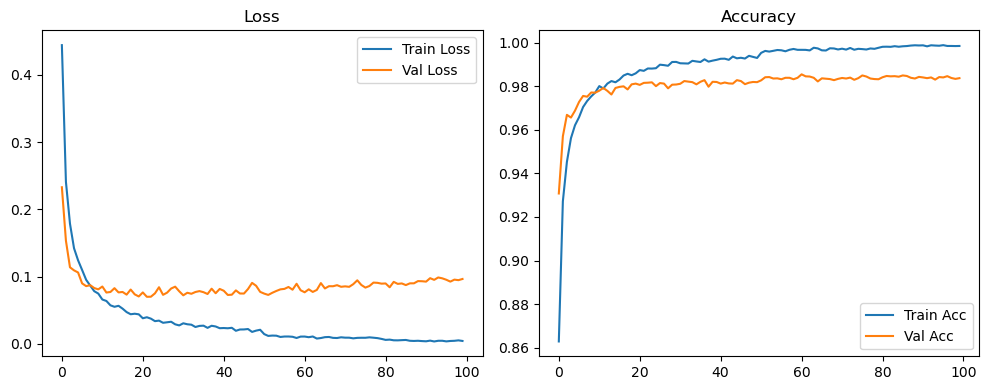

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6593, Acc: 0.7926 | Val Loss: 0.2740, Acc: 0.9208


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3873, Acc: 0.8837 | Val Loss: 0.2056, Acc: 0.9409


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3135, Acc: 0.9065 | Val Loss: 0.1550, Acc: 0.9523


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2589, Acc: 0.9234 | Val Loss: 0.1370, Acc: 0.9573


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2354, Acc: 0.9295 | Val Loss: 0.1238, Acc: 0.9625


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2163, Acc: 0.9354 | Val Loss: 0.1085, Acc: 0.9679


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.2007, Acc: 0.9397 | Val Loss: 0.1044, Acc: 0.9692


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1871, Acc: 0.9448 | Val Loss: 0.0972, Acc: 0.9703


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1791, Acc: 0.9465 | Val Loss: 0.0951, Acc: 0.9717


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1694, Acc: 0.9486 | Val Loss: 0.0926, Acc: 0.9713


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1559, Acc: 0.9530 | Val Loss: 0.0938, Acc: 0.9706


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1518, Acc: 0.9538 | Val Loss: 0.0810, Acc: 0.9756


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1437, Acc: 0.9569 | Val Loss: 0.0803, Acc: 0.9757


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1403, Acc: 0.9585 | Val Loss: 0.0824, Acc: 0.9759


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1342, Acc: 0.9600 | Val Loss: 0.0836, Acc: 0.9753


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1315, Acc: 0.9595 | Val Loss: 0.0794, Acc: 0.9760


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1296, Acc: 0.9609 | Val Loss: 0.0771, Acc: 0.9769


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1230, Acc: 0.9625 | Val Loss: 0.0751, Acc: 0.9770


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1214, Acc: 0.9628 | Val Loss: 0.0751, Acc: 0.9771


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1183, Acc: 0.9637 | Val Loss: 0.0760, Acc: 0.9766


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1115, Acc: 0.9656 | Val Loss: 0.0738, Acc: 0.9782


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1151, Acc: 0.9647 | Val Loss: 0.0743, Acc: 0.9774


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1095, Acc: 0.9663 | Val Loss: 0.0742, Acc: 0.9779


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1066, Acc: 0.9671 | Val Loss: 0.0720, Acc: 0.9789


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1023, Acc: 0.9684 | Val Loss: 0.0740, Acc: 0.9786


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1019, Acc: 0.9680 | Val Loss: 0.0685, Acc: 0.9793


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1018, Acc: 0.9693 | Val Loss: 0.0715, Acc: 0.9795


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0984, Acc: 0.9695 | Val Loss: 0.0725, Acc: 0.9788


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0953, Acc: 0.9699 | Val Loss: 0.0714, Acc: 0.9793


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0974, Acc: 0.9702 | Val Loss: 0.0694, Acc: 0.9799


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0949, Acc: 0.9709 | Val Loss: 0.0667, Acc: 0.9808


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0908, Acc: 0.9714 | Val Loss: 0.0691, Acc: 0.9794


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0897, Acc: 0.9723 | Val Loss: 0.0670, Acc: 0.9802


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0900, Acc: 0.9725 | Val Loss: 0.0704, Acc: 0.9787


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0892, Acc: 0.9725 | Val Loss: 0.0667, Acc: 0.9803


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0865, Acc: 0.9737 | Val Loss: 0.0673, Acc: 0.9806


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0821, Acc: 0.9744 | Val Loss: 0.0687, Acc: 0.9788


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0833, Acc: 0.9735 | Val Loss: 0.0705, Acc: 0.9798


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0844, Acc: 0.9743 | Val Loss: 0.0715, Acc: 0.9801


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0833, Acc: 0.9741 | Val Loss: 0.0684, Acc: 0.9798


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0848, Acc: 0.9736 | Val Loss: 0.0689, Acc: 0.9801


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0773, Acc: 0.9758 | Val Loss: 0.0712, Acc: 0.9808


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0777, Acc: 0.9763 | Val Loss: 0.0699, Acc: 0.9801


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0780, Acc: 0.9762 | Val Loss: 0.0691, Acc: 0.9810


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0785, Acc: 0.9755 | Val Loss: 0.0676, Acc: 0.9803


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9770 | Val Loss: 0.0679, Acc: 0.9801


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0766, Acc: 0.9766 | Val Loss: 0.0692, Acc: 0.9811


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0733, Acc: 0.9766 | Val Loss: 0.0689, Acc: 0.9802


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9766 | Val Loss: 0.0721, Acc: 0.9816


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0727, Acc: 0.9773 | Val Loss: 0.0714, Acc: 0.9804


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0655, Acc: 0.9789 | Val Loss: 0.0669, Acc: 0.9812


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0611, Acc: 0.9806 | Val Loss: 0.0671, Acc: 0.9813


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0617, Acc: 0.9806 | Val Loss: 0.0670, Acc: 0.9813


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0622, Acc: 0.9801 | Val Loss: 0.0708, Acc: 0.9808


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0552, Acc: 0.9822 | Val Loss: 0.0691, Acc: 0.9813


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0587, Acc: 0.9810 | Val Loss: 0.0668, Acc: 0.9815


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0589, Acc: 0.9816 | Val Loss: 0.0690, Acc: 0.9817


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0539, Acc: 0.9834 | Val Loss: 0.0678, Acc: 0.9820


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0554, Acc: 0.9831 | Val Loss: 0.0693, Acc: 0.9820


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0554, Acc: 0.9827 | Val Loss: 0.0674, Acc: 0.9816


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0521, Acc: 0.9839 | Val Loss: 0.0703, Acc: 0.9822


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0532, Acc: 0.9824 | Val Loss: 0.0708, Acc: 0.9812


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0529, Acc: 0.9836 | Val Loss: 0.0715, Acc: 0.9818


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0496, Acc: 0.9836 | Val Loss: 0.0706, Acc: 0.9824


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0516, Acc: 0.9840 | Val Loss: 0.0706, Acc: 0.9809


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9845 | Val Loss: 0.0697, Acc: 0.9809


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0532, Acc: 0.9835 | Val Loss: 0.0710, Acc: 0.9803


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0524, Acc: 0.9833 | Val Loss: 0.0695, Acc: 0.9818


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0482, Acc: 0.9848 | Val Loss: 0.0710, Acc: 0.9817


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0506, Acc: 0.9843 | Val Loss: 0.0694, Acc: 0.9817


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0494, Acc: 0.9848 | Val Loss: 0.0694, Acc: 0.9810


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0471, Acc: 0.9849 | Val Loss: 0.0704, Acc: 0.9812


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0500, Acc: 0.9848 | Val Loss: 0.0684, Acc: 0.9822


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0506, Acc: 0.9839 | Val Loss: 0.0702, Acc: 0.9815


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0465, Acc: 0.9856 | Val Loss: 0.0715, Acc: 0.9811


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0485, Acc: 0.9848 | Val Loss: 0.0701, Acc: 0.9811


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9855 | Val Loss: 0.0697, Acc: 0.9812


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0478, Acc: 0.9856 | Val Loss: 0.0721, Acc: 0.9812


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0506, Acc: 0.9840 | Val Loss: 0.0701, Acc: 0.9814


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0460, Acc: 0.9850 | Val Loss: 0.0710, Acc: 0.9816


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0439, Acc: 0.9862 | Val Loss: 0.0706, Acc: 0.9817


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0428, Acc: 0.9865 | Val Loss: 0.0692, Acc: 0.9815


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0416, Acc: 0.9866 | Val Loss: 0.0717, Acc: 0.9818


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0412, Acc: 0.9870 | Val Loss: 0.0695, Acc: 0.9826


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0393, Acc: 0.9877 | Val Loss: 0.0710, Acc: 0.9820


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0395, Acc: 0.9877 | Val Loss: 0.0700, Acc: 0.9821


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0380, Acc: 0.9881 | Val Loss: 0.0706, Acc: 0.9819


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0383, Acc: 0.9878 | Val Loss: 0.0727, Acc: 0.9810


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0410, Acc: 0.9869 | Val Loss: 0.0713, Acc: 0.9814


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0358, Acc: 0.9891 | Val Loss: 0.0715, Acc: 0.9824


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0374, Acc: 0.9885 | Val Loss: 0.0720, Acc: 0.9829


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0383, Acc: 0.9884 | Val Loss: 0.0726, Acc: 0.9817


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9882 | Val Loss: 0.0712, Acc: 0.9816


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9886 | Val Loss: 0.0730, Acc: 0.9820


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0369, Acc: 0.9885 | Val Loss: 0.0722, Acc: 0.9816


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9887 | Val Loss: 0.0733, Acc: 0.9818


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0351, Acc: 0.9888 | Val Loss: 0.0738, Acc: 0.9818


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0351, Acc: 0.9882 | Val Loss: 0.0741, Acc: 0.9814


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0357, Acc: 0.9884 | Val Loss: 0.0751, Acc: 0.9816


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9893 | Val Loss: 0.0738, Acc: 0.9818


Final Test Loss: 0.0641 Accuracy: 0.9837


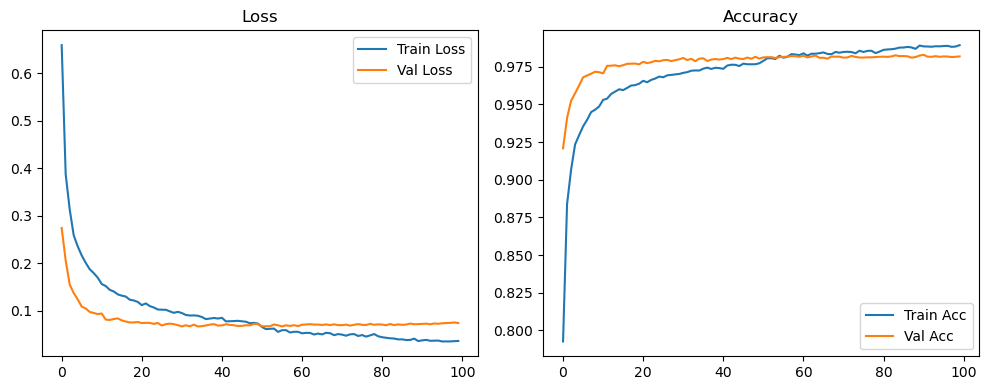

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3551, Acc: 0.8913 | Val Loss: 0.2053, Acc: 0.9378


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1780, Acc: 0.9464 | Val Loss: 0.1542, Acc: 0.9547


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1281, Acc: 0.9612 | Val Loss: 0.1126, Acc: 0.9650


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0938, Acc: 0.9707 | Val Loss: 0.1191, Acc: 0.9642


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0785, Acc: 0.9755 | Val Loss: 0.1128, Acc: 0.9673


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9789 | Val Loss: 0.1031, Acc: 0.9714


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9825 | Val Loss: 0.1078, Acc: 0.9703


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9836 | Val Loss: 0.0881, Acc: 0.9768


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9861 | Val Loss: 0.0942, Acc: 0.9750


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9864 | Val Loss: 0.0987, Acc: 0.9742


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9895 | Val Loss: 0.1065, Acc: 0.9738


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9897 | Val Loss: 0.1053, Acc: 0.9752


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9908 | Val Loss: 0.1049, Acc: 0.9751


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9900 | Val Loss: 0.0972, Acc: 0.9759


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9922 | Val Loss: 0.1106, Acc: 0.9752


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9920 | Val Loss: 0.1094, Acc: 0.9762


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9930 | Val Loss: 0.1009, Acc: 0.9778


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9932 | Val Loss: 0.1106, Acc: 0.9755


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9929 | Val Loss: 0.0956, Acc: 0.9779


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9952 | Val Loss: 0.1075, Acc: 0.9776


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9939 | Val Loss: 0.0983, Acc: 0.9778


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9942 | Val Loss: 0.1060, Acc: 0.9788


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9946 | Val Loss: 0.1138, Acc: 0.9766


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9948 | Val Loss: 0.1170, Acc: 0.9755


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9957 | Val Loss: 0.1083, Acc: 0.9784


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1077, Acc: 0.9790


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.1027, Acc: 0.9802


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1170, Acc: 0.9768


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.1205, Acc: 0.9760


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1128, Acc: 0.9777


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.1199, Acc: 0.9766


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.1000, Acc: 0.9791


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1126, Acc: 0.9788


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.1144, Acc: 0.9796


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.1095, Acc: 0.9778


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1144, Acc: 0.9788


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1036, Acc: 0.9798


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1000, Acc: 0.9785


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.1030, Acc: 0.9806


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1097, Acc: 0.9793


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.1247, Acc: 0.9778


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.1228, Acc: 0.9792


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1166, Acc: 0.9791


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9968 | Val Loss: 0.1110, Acc: 0.9796


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1195, Acc: 0.9783


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1193, Acc: 0.9775


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1322, Acc: 0.9768


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1071, Acc: 0.9799


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1149, Acc: 0.9788


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1167, Acc: 0.9812


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1074, Acc: 0.9822


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1073, Acc: 0.9819


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1055, Acc: 0.9818


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1089, Acc: 0.9822


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1131, Acc: 0.9818


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1101, Acc: 0.9830


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1143, Acc: 0.9829


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1161, Acc: 0.9818


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1110, Acc: 0.9822


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1139, Acc: 0.9821


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1171, Acc: 0.9822


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1163, Acc: 0.9822


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1288, Acc: 0.9808


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1182, Acc: 0.9806


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9992 | Val Loss: 0.1243, Acc: 0.9812


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1274, Acc: 0.9814


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1231, Acc: 0.9816


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1373, Acc: 0.9817


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1368, Acc: 0.9812


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1211, Acc: 0.9837


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1284, Acc: 0.9812


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1264, Acc: 0.9822


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1293, Acc: 0.9807


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1240, Acc: 0.9818


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1264, Acc: 0.9808


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1360, Acc: 0.9804


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1292, Acc: 0.9828


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1301, Acc: 0.9816


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1359, Acc: 0.9799


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1232, Acc: 0.9824


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1251, Acc: 0.9826


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1263, Acc: 0.9826


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1233, Acc: 0.9833


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1198, Acc: 0.9829


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1223, Acc: 0.9831


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1209, Acc: 0.9836


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.1195, Acc: 0.9843


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1228, Acc: 0.9837


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1211, Acc: 0.9844


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1192, Acc: 0.9841


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1208, Acc: 0.9840


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1251, Acc: 0.9843


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1214, Acc: 0.9838


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1259, Acc: 0.9832


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1276, Acc: 0.9836


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1247, Acc: 0.9835


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1241, Acc: 0.9834


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1239, Acc: 0.9839


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1316, Acc: 0.9830


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1192, Acc: 0.9839


Final Test Loss: 0.1196 Accuracy: 0.9842


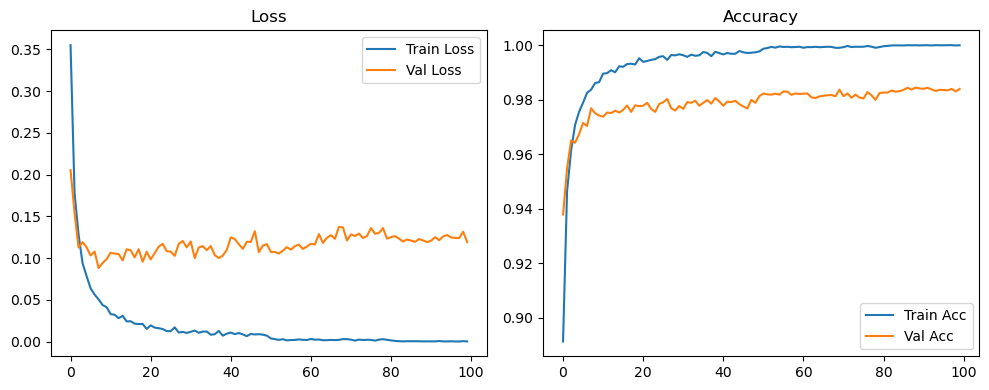

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4441, Acc: 0.8629 | Val Loss: 0.2328, Acc: 0.9307


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2409, Acc: 0.9271 | Val Loss: 0.1534, Acc: 0.9570


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1788, Acc: 0.9453 | Val Loss: 0.1139, Acc: 0.9668


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1422, Acc: 0.9561 | Val Loss: 0.1093, Acc: 0.9656


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1242, Acc: 0.9621 | Val Loss: 0.1062, Acc: 0.9688


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1099, Acc: 0.9657 | Val Loss: 0.0899, Acc: 0.9728


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0952, Acc: 0.9704 | Val Loss: 0.0858, Acc: 0.9755


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0867, Acc: 0.9732 | Val Loss: 0.0873, Acc: 0.9752


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0783, Acc: 0.9753 | Val Loss: 0.0830, Acc: 0.9771


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0748, Acc: 0.9771 | Val Loss: 0.0811, Acc: 0.9770


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0660, Acc: 0.9800 | Val Loss: 0.0852, Acc: 0.9779


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9789 | Val Loss: 0.0763, Acc: 0.9792


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9812 | Val Loss: 0.0771, Acc: 0.9778


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9823 | Val Loss: 0.0828, Acc: 0.9762


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9818 | Val Loss: 0.0765, Acc: 0.9792


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9830 | Val Loss: 0.0772, Acc: 0.9797


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9849 | Val Loss: 0.0732, Acc: 0.9799


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9857 | Val Loss: 0.0808, Acc: 0.9785


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9850 | Val Loss: 0.0736, Acc: 0.9808


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9859 | Val Loss: 0.0705, Acc: 0.9812


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9874 | Val Loss: 0.0765, Acc: 0.9806


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9870 | Val Loss: 0.0700, Acc: 0.9815


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9881 | Val Loss: 0.0701, Acc: 0.9816


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9881 | Val Loss: 0.0751, Acc: 0.9818


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9882 | Val Loss: 0.0842, Acc: 0.9800


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9899 | Val Loss: 0.0729, Acc: 0.9814


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9896 | Val Loss: 0.0762, Acc: 0.9812


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9894 | Val Loss: 0.0823, Acc: 0.9790


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9911 | Val Loss: 0.0850, Acc: 0.9807


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9911 | Val Loss: 0.0782, Acc: 0.9808


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9905 | Val Loss: 0.0722, Acc: 0.9811


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9904 | Val Loss: 0.0760, Acc: 0.9823


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9904 | Val Loss: 0.0745, Acc: 0.9821


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9916 | Val Loss: 0.0771, Acc: 0.9818


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9913 | Val Loss: 0.0785, Acc: 0.9808


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9911 | Val Loss: 0.0768, Acc: 0.9820


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9923 | Val Loss: 0.0741, Acc: 0.9828


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9912 | Val Loss: 0.0820, Acc: 0.9798


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9917 | Val Loss: 0.0753, Acc: 0.9820


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9921 | Val Loss: 0.0817, Acc: 0.9819


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9926 | Val Loss: 0.0790, Acc: 0.9812


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9926 | Val Loss: 0.0727, Acc: 0.9817


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9921 | Val Loss: 0.0731, Acc: 0.9812


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9936 | Val Loss: 0.0795, Acc: 0.9812


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.0749, Acc: 0.9828


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9930 | Val Loss: 0.0748, Acc: 0.9823


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9927 | Val Loss: 0.0816, Acc: 0.9809


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9939 | Val Loss: 0.0907, Acc: 0.9816


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9934 | Val Loss: 0.0864, Acc: 0.9819


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9929 | Val Loss: 0.0773, Acc: 0.9818


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9953 | Val Loss: 0.0747, Acc: 0.9827


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.0728, Acc: 0.9841


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.0760, Acc: 0.9842


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.0787, Acc: 0.9835


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.0810, Acc: 0.9836


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.0818, Acc: 0.9832


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9960 | Val Loss: 0.0846, Acc: 0.9838


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.0805, Acc: 0.9838


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0893, Acc: 0.9832


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.0797, Acc: 0.9838


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9967 | Val Loss: 0.0767, Acc: 0.9854


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0811, Acc: 0.9845


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.0772, Acc: 0.9844


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.0802, Acc: 0.9838


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0904, Acc: 0.9822


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9964 | Val Loss: 0.0824, Acc: 0.9836


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.0858, Acc: 0.9834


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.0857, Acc: 0.9832


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0873, Acc: 0.9828


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0849, Acc: 0.9833


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.0855, Acc: 0.9838


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0848, Acc: 0.9835


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.0887, Acc: 0.9839


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9967 | Val Loss: 0.0945, Acc: 0.9829


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0876, Acc: 0.9837


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0837, Acc: 0.9849


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.0860, Acc: 0.9844


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.0911, Acc: 0.9835


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.0907, Acc: 0.9832


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0895, Acc: 0.9832


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0891, Acc: 0.9839


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.0848, Acc: 0.9838


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0890, Acc: 0.9842


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0853, Acc: 0.9842


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0870, Acc: 0.9842


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0865, Acc: 0.9843


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.0868, Acc: 0.9846


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0871, Acc: 0.9845


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0894, Acc: 0.9845


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0886, Acc: 0.9847


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0893, Acc: 0.9845


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0936, Acc: 0.9844


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0901, Acc: 0.9842


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0927, Acc: 0.9841


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0919, Acc: 0.9845


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0900, Acc: 0.9846


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0895, Acc: 0.9847


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0922, Acc: 0.9848


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0909, Acc: 0.9850


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0915, Acc: 0.9848


Final Test Loss: 0.0746 Accuracy: 0.9872


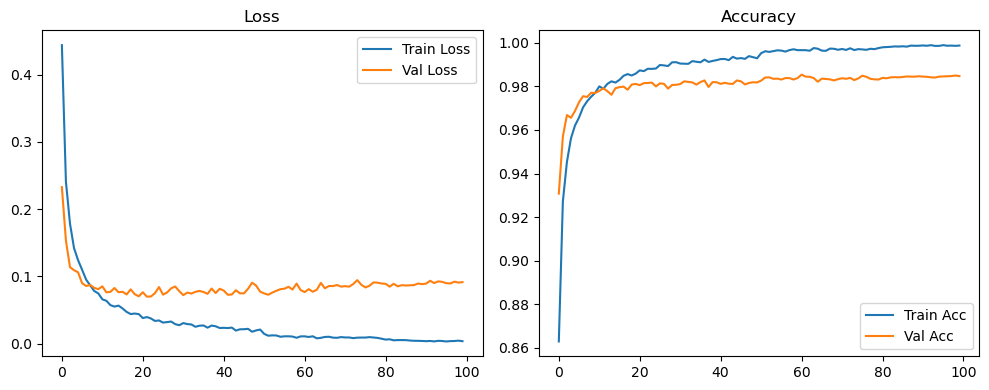

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6593, Acc: 0.7926 | Val Loss: 0.2740, Acc: 0.9208


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3873, Acc: 0.8837 | Val Loss: 0.2056, Acc: 0.9409


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3135, Acc: 0.9065 | Val Loss: 0.1550, Acc: 0.9523


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2589, Acc: 0.9234 | Val Loss: 0.1370, Acc: 0.9573


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2354, Acc: 0.9295 | Val Loss: 0.1238, Acc: 0.9625


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2163, Acc: 0.9354 | Val Loss: 0.1085, Acc: 0.9679


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.2007, Acc: 0.9397 | Val Loss: 0.1044, Acc: 0.9692


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1871, Acc: 0.9448 | Val Loss: 0.0972, Acc: 0.9703


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1791, Acc: 0.9465 | Val Loss: 0.0951, Acc: 0.9717


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1694, Acc: 0.9486 | Val Loss: 0.0926, Acc: 0.9713


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1559, Acc: 0.9530 | Val Loss: 0.0938, Acc: 0.9706


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1518, Acc: 0.9538 | Val Loss: 0.0810, Acc: 0.9756


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1437, Acc: 0.9569 | Val Loss: 0.0803, Acc: 0.9757


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1403, Acc: 0.9585 | Val Loss: 0.0824, Acc: 0.9759


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1342, Acc: 0.9600 | Val Loss: 0.0836, Acc: 0.9753


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1315, Acc: 0.9595 | Val Loss: 0.0794, Acc: 0.9760


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1296, Acc: 0.9609 | Val Loss: 0.0771, Acc: 0.9769


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1230, Acc: 0.9625 | Val Loss: 0.0751, Acc: 0.9770


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1214, Acc: 0.9628 | Val Loss: 0.0751, Acc: 0.9771


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1183, Acc: 0.9637 | Val Loss: 0.0760, Acc: 0.9766


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1115, Acc: 0.9656 | Val Loss: 0.0738, Acc: 0.9782


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1151, Acc: 0.9647 | Val Loss: 0.0743, Acc: 0.9774


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1095, Acc: 0.9663 | Val Loss: 0.0742, Acc: 0.9779


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1066, Acc: 0.9671 | Val Loss: 0.0720, Acc: 0.9789


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1023, Acc: 0.9684 | Val Loss: 0.0740, Acc: 0.9786


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1019, Acc: 0.9680 | Val Loss: 0.0685, Acc: 0.9793


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1018, Acc: 0.9693 | Val Loss: 0.0715, Acc: 0.9795


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0984, Acc: 0.9695 | Val Loss: 0.0725, Acc: 0.9788


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0953, Acc: 0.9699 | Val Loss: 0.0714, Acc: 0.9793


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0974, Acc: 0.9702 | Val Loss: 0.0694, Acc: 0.9799


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0949, Acc: 0.9709 | Val Loss: 0.0667, Acc: 0.9808


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0908, Acc: 0.9714 | Val Loss: 0.0691, Acc: 0.9794


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0897, Acc: 0.9723 | Val Loss: 0.0670, Acc: 0.9802


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0900, Acc: 0.9725 | Val Loss: 0.0704, Acc: 0.9787


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0892, Acc: 0.9725 | Val Loss: 0.0667, Acc: 0.9803


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0865, Acc: 0.9737 | Val Loss: 0.0673, Acc: 0.9806


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0821, Acc: 0.9744 | Val Loss: 0.0687, Acc: 0.9788


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0833, Acc: 0.9735 | Val Loss: 0.0705, Acc: 0.9798


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0844, Acc: 0.9743 | Val Loss: 0.0715, Acc: 0.9801


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0833, Acc: 0.9741 | Val Loss: 0.0684, Acc: 0.9798


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0848, Acc: 0.9736 | Val Loss: 0.0689, Acc: 0.9801


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0773, Acc: 0.9758 | Val Loss: 0.0712, Acc: 0.9808


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0777, Acc: 0.9763 | Val Loss: 0.0699, Acc: 0.9801


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0780, Acc: 0.9762 | Val Loss: 0.0691, Acc: 0.9810


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0785, Acc: 0.9755 | Val Loss: 0.0676, Acc: 0.9803


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9770 | Val Loss: 0.0679, Acc: 0.9801


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0766, Acc: 0.9766 | Val Loss: 0.0692, Acc: 0.9811


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0733, Acc: 0.9766 | Val Loss: 0.0689, Acc: 0.9802


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9766 | Val Loss: 0.0721, Acc: 0.9816


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0727, Acc: 0.9773 | Val Loss: 0.0714, Acc: 0.9804


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0655, Acc: 0.9789 | Val Loss: 0.0669, Acc: 0.9812


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0611, Acc: 0.9806 | Val Loss: 0.0671, Acc: 0.9813


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0617, Acc: 0.9806 | Val Loss: 0.0670, Acc: 0.9813


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0622, Acc: 0.9801 | Val Loss: 0.0708, Acc: 0.9808


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0552, Acc: 0.9822 | Val Loss: 0.0691, Acc: 0.9813


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0587, Acc: 0.9810 | Val Loss: 0.0668, Acc: 0.9815


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0589, Acc: 0.9816 | Val Loss: 0.0690, Acc: 0.9817


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0539, Acc: 0.9834 | Val Loss: 0.0678, Acc: 0.9820


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0554, Acc: 0.9831 | Val Loss: 0.0693, Acc: 0.9820


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0554, Acc: 0.9827 | Val Loss: 0.0674, Acc: 0.9816


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0521, Acc: 0.9839 | Val Loss: 0.0703, Acc: 0.9822


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0532, Acc: 0.9824 | Val Loss: 0.0708, Acc: 0.9812


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0529, Acc: 0.9836 | Val Loss: 0.0715, Acc: 0.9818


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0496, Acc: 0.9836 | Val Loss: 0.0706, Acc: 0.9824


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0516, Acc: 0.9840 | Val Loss: 0.0706, Acc: 0.9809


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9845 | Val Loss: 0.0697, Acc: 0.9809


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0532, Acc: 0.9835 | Val Loss: 0.0710, Acc: 0.9803


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0524, Acc: 0.9833 | Val Loss: 0.0695, Acc: 0.9818


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0482, Acc: 0.9848 | Val Loss: 0.0710, Acc: 0.9817


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0506, Acc: 0.9843 | Val Loss: 0.0694, Acc: 0.9817


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0494, Acc: 0.9848 | Val Loss: 0.0694, Acc: 0.9810


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0471, Acc: 0.9849 | Val Loss: 0.0704, Acc: 0.9812


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0500, Acc: 0.9848 | Val Loss: 0.0684, Acc: 0.9822


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0506, Acc: 0.9839 | Val Loss: 0.0702, Acc: 0.9815


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0465, Acc: 0.9856 | Val Loss: 0.0715, Acc: 0.9811


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0485, Acc: 0.9848 | Val Loss: 0.0701, Acc: 0.9811


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9855 | Val Loss: 0.0697, Acc: 0.9812


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0478, Acc: 0.9856 | Val Loss: 0.0721, Acc: 0.9812


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0506, Acc: 0.9840 | Val Loss: 0.0701, Acc: 0.9814


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0460, Acc: 0.9850 | Val Loss: 0.0710, Acc: 0.9816


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0440, Acc: 0.9862 | Val Loss: 0.0703, Acc: 0.9815


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0429, Acc: 0.9862 | Val Loss: 0.0690, Acc: 0.9815


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0417, Acc: 0.9867 | Val Loss: 0.0710, Acc: 0.9818


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0415, Acc: 0.9869 | Val Loss: 0.0693, Acc: 0.9822


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0393, Acc: 0.9872 | Val Loss: 0.0706, Acc: 0.9820


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0396, Acc: 0.9878 | Val Loss: 0.0693, Acc: 0.9822


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0377, Acc: 0.9883 | Val Loss: 0.0698, Acc: 0.9821


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0381, Acc: 0.9877 | Val Loss: 0.0715, Acc: 0.9807


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0404, Acc: 0.9870 | Val Loss: 0.0711, Acc: 0.9812


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0357, Acc: 0.9890 | Val Loss: 0.0706, Acc: 0.9826


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0373, Acc: 0.9885 | Val Loss: 0.0711, Acc: 0.9828


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0378, Acc: 0.9881 | Val Loss: 0.0720, Acc: 0.9820


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0355, Acc: 0.9886 | Val Loss: 0.0705, Acc: 0.9813


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0362, Acc: 0.9889 | Val Loss: 0.0721, Acc: 0.9815


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0364, Acc: 0.9889 | Val Loss: 0.0719, Acc: 0.9818


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0345, Acc: 0.9891 | Val Loss: 0.0721, Acc: 0.9822


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0347, Acc: 0.9889 | Val Loss: 0.0727, Acc: 0.9819


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0347, Acc: 0.9885 | Val Loss: 0.0727, Acc: 0.9817


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0351, Acc: 0.9885 | Val Loss: 0.0738, Acc: 0.9817


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0355, Acc: 0.9891 | Val Loss: 0.0728, Acc: 0.9816


Final Test Loss: 0.0637 Accuracy: 0.9839


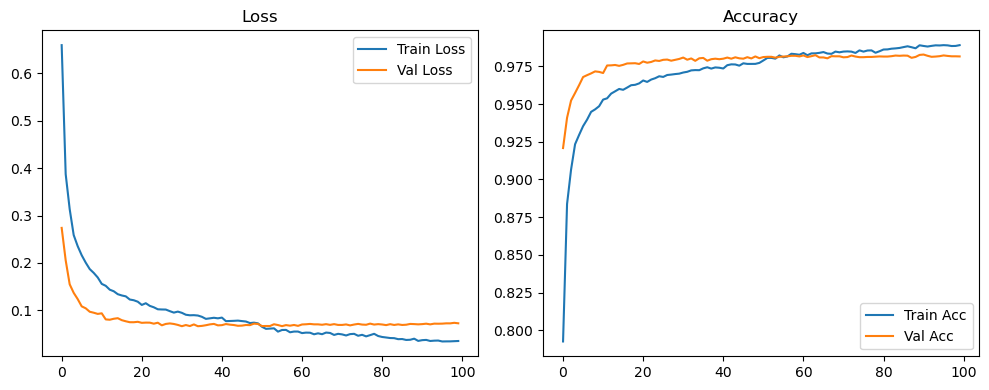

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3551, Acc: 0.8913 | Val Loss: 0.2053, Acc: 0.9378


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1780, Acc: 0.9464 | Val Loss: 0.1542, Acc: 0.9547


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1281, Acc: 0.9612 | Val Loss: 0.1126, Acc: 0.9650


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0938, Acc: 0.9707 | Val Loss: 0.1191, Acc: 0.9642


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0785, Acc: 0.9755 | Val Loss: 0.1128, Acc: 0.9673


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9789 | Val Loss: 0.1031, Acc: 0.9714


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9825 | Val Loss: 0.1078, Acc: 0.9703


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9836 | Val Loss: 0.0881, Acc: 0.9768


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9861 | Val Loss: 0.0942, Acc: 0.9750


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9864 | Val Loss: 0.0987, Acc: 0.9742


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9895 | Val Loss: 0.1065, Acc: 0.9738


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9897 | Val Loss: 0.1053, Acc: 0.9752


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9908 | Val Loss: 0.1049, Acc: 0.9751


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9900 | Val Loss: 0.0972, Acc: 0.9759


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9922 | Val Loss: 0.1106, Acc: 0.9752


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9920 | Val Loss: 0.1094, Acc: 0.9762


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9930 | Val Loss: 0.1009, Acc: 0.9778


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9932 | Val Loss: 0.1106, Acc: 0.9755


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9929 | Val Loss: 0.0956, Acc: 0.9779


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9952 | Val Loss: 0.1075, Acc: 0.9776


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9939 | Val Loss: 0.0983, Acc: 0.9778


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9942 | Val Loss: 0.1060, Acc: 0.9788


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9946 | Val Loss: 0.1138, Acc: 0.9766


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9948 | Val Loss: 0.1170, Acc: 0.9755


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9957 | Val Loss: 0.1083, Acc: 0.9784


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1077, Acc: 0.9790


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.1027, Acc: 0.9802


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1170, Acc: 0.9768


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.1205, Acc: 0.9760


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1128, Acc: 0.9777


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.1199, Acc: 0.9766


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.1000, Acc: 0.9791


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1126, Acc: 0.9788


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.1144, Acc: 0.9796


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.1095, Acc: 0.9778


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1144, Acc: 0.9788


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1036, Acc: 0.9798


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1000, Acc: 0.9785


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.1030, Acc: 0.9806


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1097, Acc: 0.9793


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.1247, Acc: 0.9778


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.1228, Acc: 0.9792


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1166, Acc: 0.9791


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9968 | Val Loss: 0.1110, Acc: 0.9796


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1195, Acc: 0.9783


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1193, Acc: 0.9775


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1322, Acc: 0.9768


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1071, Acc: 0.9799


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1149, Acc: 0.9788


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1167, Acc: 0.9812


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1021, Acc: 0.9829


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1015, Acc: 0.9831


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1005, Acc: 0.9822


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9993 | Val Loss: 0.0999, Acc: 0.9833


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0995, Acc: 0.9834


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1030, Acc: 0.9838


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1017, Acc: 0.9839


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1025, Acc: 0.9829


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1012, Acc: 0.9832


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1027, Acc: 0.9838


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1071, Acc: 0.9831


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1064, Acc: 0.9835


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1092, Acc: 0.9831


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1028, Acc: 0.9840


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1062, Acc: 0.9838


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1094, Acc: 0.9840


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1091, Acc: 0.9834


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1114, Acc: 0.9832


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1104, Acc: 0.9838


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1098, Acc: 0.9827


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1091, Acc: 0.9832


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1122, Acc: 0.9831


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1120, Acc: 0.9837


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1157, Acc: 0.9830


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1166, Acc: 0.9832


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1194, Acc: 0.9831


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1212, Acc: 0.9828


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1209, Acc: 0.9826


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1199, Acc: 0.9829


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1151, Acc: 0.9829


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1150, Acc: 0.9838


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1126, Acc: 0.9840


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1149, Acc: 0.9832


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1119, Acc: 0.9834


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1138, Acc: 0.9838


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9998 | Val Loss: 0.1160, Acc: 0.9838


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1195, Acc: 0.9831


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1183, Acc: 0.9831


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1191, Acc: 0.9841


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1155, Acc: 0.9835


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1176, Acc: 0.9839


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1173, Acc: 0.9846


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1130, Acc: 0.9842


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1197, Acc: 0.9838


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1174, Acc: 0.9843


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1164, Acc: 0.9838


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1137, Acc: 0.9835


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1118, Acc: 0.9845


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1172, Acc: 0.9838


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1133, Acc: 0.9839


Final Test Loss: 0.1155 Accuracy: 0.9838


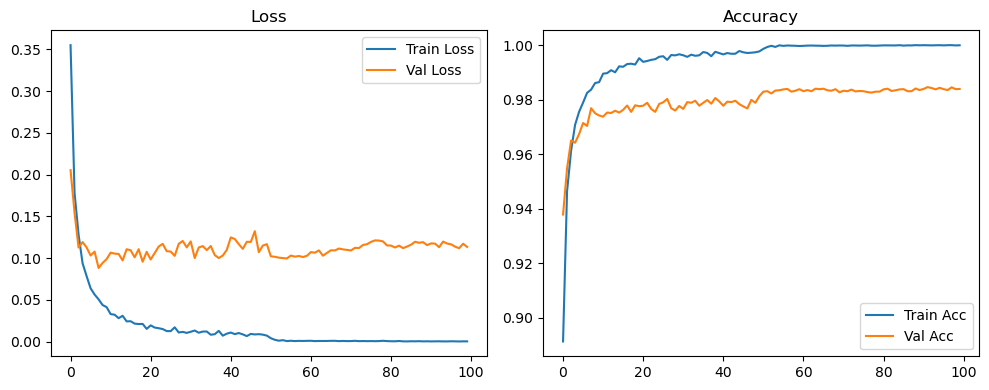

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4441, Acc: 0.8629 | Val Loss: 0.2328, Acc: 0.9307


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2409, Acc: 0.9271 | Val Loss: 0.1534, Acc: 0.9570


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1788, Acc: 0.9453 | Val Loss: 0.1139, Acc: 0.9668


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1422, Acc: 0.9561 | Val Loss: 0.1093, Acc: 0.9656


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1242, Acc: 0.9621 | Val Loss: 0.1062, Acc: 0.9688


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1099, Acc: 0.9657 | Val Loss: 0.0899, Acc: 0.9728


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0952, Acc: 0.9704 | Val Loss: 0.0858, Acc: 0.9755


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0867, Acc: 0.9732 | Val Loss: 0.0873, Acc: 0.9752


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0783, Acc: 0.9753 | Val Loss: 0.0830, Acc: 0.9771


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0748, Acc: 0.9771 | Val Loss: 0.0811, Acc: 0.9770


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0660, Acc: 0.9800 | Val Loss: 0.0852, Acc: 0.9779


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9789 | Val Loss: 0.0763, Acc: 0.9792


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9812 | Val Loss: 0.0771, Acc: 0.9778


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9823 | Val Loss: 0.0828, Acc: 0.9762


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9818 | Val Loss: 0.0765, Acc: 0.9792


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9830 | Val Loss: 0.0772, Acc: 0.9797


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9849 | Val Loss: 0.0732, Acc: 0.9799


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9857 | Val Loss: 0.0808, Acc: 0.9785


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9850 | Val Loss: 0.0736, Acc: 0.9808


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9859 | Val Loss: 0.0705, Acc: 0.9812


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9874 | Val Loss: 0.0765, Acc: 0.9806


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9870 | Val Loss: 0.0700, Acc: 0.9815


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9881 | Val Loss: 0.0701, Acc: 0.9816


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9881 | Val Loss: 0.0751, Acc: 0.9818


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9882 | Val Loss: 0.0842, Acc: 0.9800


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9899 | Val Loss: 0.0729, Acc: 0.9814


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9896 | Val Loss: 0.0762, Acc: 0.9812


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9894 | Val Loss: 0.0823, Acc: 0.9790


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9911 | Val Loss: 0.0850, Acc: 0.9807


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9911 | Val Loss: 0.0782, Acc: 0.9808


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9905 | Val Loss: 0.0722, Acc: 0.9811


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9904 | Val Loss: 0.0760, Acc: 0.9823


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9904 | Val Loss: 0.0745, Acc: 0.9821


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9916 | Val Loss: 0.0771, Acc: 0.9818


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9913 | Val Loss: 0.0785, Acc: 0.9808


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9911 | Val Loss: 0.0768, Acc: 0.9820


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9923 | Val Loss: 0.0741, Acc: 0.9828


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9912 | Val Loss: 0.0820, Acc: 0.9798


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9917 | Val Loss: 0.0753, Acc: 0.9820


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9921 | Val Loss: 0.0817, Acc: 0.9819


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9926 | Val Loss: 0.0790, Acc: 0.9812


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9926 | Val Loss: 0.0727, Acc: 0.9817


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9921 | Val Loss: 0.0731, Acc: 0.9812


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9936 | Val Loss: 0.0795, Acc: 0.9812


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.0749, Acc: 0.9828


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9930 | Val Loss: 0.0748, Acc: 0.9823


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9927 | Val Loss: 0.0816, Acc: 0.9809


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9939 | Val Loss: 0.0907, Acc: 0.9816


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9934 | Val Loss: 0.0864, Acc: 0.9819


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9929 | Val Loss: 0.0773, Acc: 0.9818


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.0734, Acc: 0.9833


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.0708, Acc: 0.9837


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.0709, Acc: 0.9847


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0724, Acc: 0.9840


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0754, Acc: 0.9838


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.0744, Acc: 0.9842


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9969 | Val Loss: 0.0789, Acc: 0.9841


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0776, Acc: 0.9842


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0844, Acc: 0.9835


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0779, Acc: 0.9838


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.0773, Acc: 0.9840


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9973 | Val Loss: 0.0795, Acc: 0.9843


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0787, Acc: 0.9846


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0797, Acc: 0.9845


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0831, Acc: 0.9837


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0815, Acc: 0.9838


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0877, Acc: 0.9840


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0861, Acc: 0.9838


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0898, Acc: 0.9832


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0851, Acc: 0.9843


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0858, Acc: 0.9848


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.0859, Acc: 0.9847


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0854, Acc: 0.9839


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9977 | Val Loss: 0.0857, Acc: 0.9851


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0859, Acc: 0.9853


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0826, Acc: 0.9848


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.0849, Acc: 0.9848


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0893, Acc: 0.9837


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0856, Acc: 0.9851


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0865, Acc: 0.9849


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0897, Acc: 0.9845


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0878, Acc: 0.9849


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0899, Acc: 0.9843


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0866, Acc: 0.9849


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0870, Acc: 0.9846


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0870, Acc: 0.9846


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0869, Acc: 0.9844


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0874, Acc: 0.9843


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0928, Acc: 0.9845


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0920, Acc: 0.9852


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0929, Acc: 0.9849


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0946, Acc: 0.9847


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0899, Acc: 0.9846


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0945, Acc: 0.9840


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9985 | Val Loss: 0.0939, Acc: 0.9844


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0908, Acc: 0.9849


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0917, Acc: 0.9844


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0927, Acc: 0.9845


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0948, Acc: 0.9848


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0939, Acc: 0.9848


Final Test Loss: 0.0764 Accuracy: 0.9865


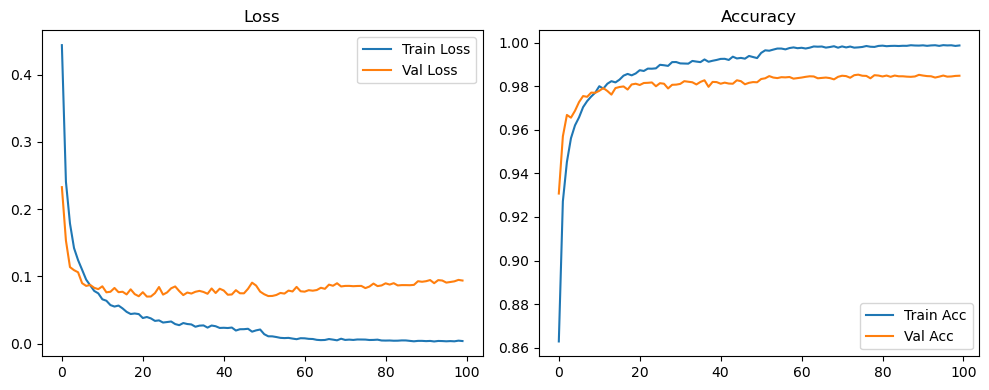

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6593, Acc: 0.7926 | Val Loss: 0.2740, Acc: 0.9208


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3873, Acc: 0.8837 | Val Loss: 0.2056, Acc: 0.9409


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3135, Acc: 0.9065 | Val Loss: 0.1550, Acc: 0.9523


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2589, Acc: 0.9234 | Val Loss: 0.1370, Acc: 0.9573


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2354, Acc: 0.9295 | Val Loss: 0.1238, Acc: 0.9625


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2163, Acc: 0.9354 | Val Loss: 0.1085, Acc: 0.9679


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.2007, Acc: 0.9397 | Val Loss: 0.1044, Acc: 0.9692


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1871, Acc: 0.9448 | Val Loss: 0.0972, Acc: 0.9703


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1791, Acc: 0.9465 | Val Loss: 0.0951, Acc: 0.9717


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1694, Acc: 0.9486 | Val Loss: 0.0926, Acc: 0.9713


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1559, Acc: 0.9530 | Val Loss: 0.0938, Acc: 0.9706


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1518, Acc: 0.9538 | Val Loss: 0.0810, Acc: 0.9756


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1437, Acc: 0.9569 | Val Loss: 0.0803, Acc: 0.9757


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1403, Acc: 0.9585 | Val Loss: 0.0824, Acc: 0.9759


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1342, Acc: 0.9600 | Val Loss: 0.0836, Acc: 0.9753


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1315, Acc: 0.9595 | Val Loss: 0.0794, Acc: 0.9760


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1296, Acc: 0.9609 | Val Loss: 0.0771, Acc: 0.9769


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1230, Acc: 0.9625 | Val Loss: 0.0751, Acc: 0.9770


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1214, Acc: 0.9628 | Val Loss: 0.0751, Acc: 0.9771


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1183, Acc: 0.9637 | Val Loss: 0.0760, Acc: 0.9766


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1115, Acc: 0.9656 | Val Loss: 0.0738, Acc: 0.9782


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1151, Acc: 0.9647 | Val Loss: 0.0743, Acc: 0.9774


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1095, Acc: 0.9663 | Val Loss: 0.0742, Acc: 0.9779


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1066, Acc: 0.9671 | Val Loss: 0.0720, Acc: 0.9789


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1023, Acc: 0.9684 | Val Loss: 0.0740, Acc: 0.9786


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1019, Acc: 0.9680 | Val Loss: 0.0685, Acc: 0.9793


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1018, Acc: 0.9693 | Val Loss: 0.0715, Acc: 0.9795


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0984, Acc: 0.9695 | Val Loss: 0.0725, Acc: 0.9788


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0953, Acc: 0.9699 | Val Loss: 0.0714, Acc: 0.9793


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0974, Acc: 0.9702 | Val Loss: 0.0694, Acc: 0.9799


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0949, Acc: 0.9709 | Val Loss: 0.0667, Acc: 0.9808


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0908, Acc: 0.9714 | Val Loss: 0.0691, Acc: 0.9794


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0897, Acc: 0.9723 | Val Loss: 0.0670, Acc: 0.9802


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0900, Acc: 0.9725 | Val Loss: 0.0704, Acc: 0.9787


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0892, Acc: 0.9725 | Val Loss: 0.0667, Acc: 0.9803


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0865, Acc: 0.9737 | Val Loss: 0.0673, Acc: 0.9806


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0821, Acc: 0.9744 | Val Loss: 0.0687, Acc: 0.9788


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0833, Acc: 0.9735 | Val Loss: 0.0705, Acc: 0.9798


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0844, Acc: 0.9743 | Val Loss: 0.0715, Acc: 0.9801


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0833, Acc: 0.9741 | Val Loss: 0.0684, Acc: 0.9798


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0848, Acc: 0.9736 | Val Loss: 0.0689, Acc: 0.9801


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0773, Acc: 0.9758 | Val Loss: 0.0712, Acc: 0.9808


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0777, Acc: 0.9763 | Val Loss: 0.0699, Acc: 0.9801


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0780, Acc: 0.9762 | Val Loss: 0.0691, Acc: 0.9810


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0785, Acc: 0.9755 | Val Loss: 0.0676, Acc: 0.9803


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9770 | Val Loss: 0.0679, Acc: 0.9801


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0766, Acc: 0.9766 | Val Loss: 0.0692, Acc: 0.9811


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0733, Acc: 0.9766 | Val Loss: 0.0689, Acc: 0.9802


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9766 | Val Loss: 0.0721, Acc: 0.9816


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0727, Acc: 0.9773 | Val Loss: 0.0714, Acc: 0.9804


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0643, Acc: 0.9792 | Val Loss: 0.0679, Acc: 0.9808


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0597, Acc: 0.9814 | Val Loss: 0.0672, Acc: 0.9815


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0603, Acc: 0.9812 | Val Loss: 0.0670, Acc: 0.9815


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0595, Acc: 0.9811 | Val Loss: 0.0689, Acc: 0.9812


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0522, Acc: 0.9829 | Val Loss: 0.0679, Acc: 0.9818


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0562, Acc: 0.9822 | Val Loss: 0.0659, Acc: 0.9816


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0549, Acc: 0.9824 | Val Loss: 0.0678, Acc: 0.9815


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0505, Acc: 0.9837 | Val Loss: 0.0679, Acc: 0.9816


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0521, Acc: 0.9842 | Val Loss: 0.0678, Acc: 0.9823


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0507, Acc: 0.9842 | Val Loss: 0.0683, Acc: 0.9818


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0492, Acc: 0.9849 | Val Loss: 0.0684, Acc: 0.9821


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0488, Acc: 0.9839 | Val Loss: 0.0698, Acc: 0.9820


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0489, Acc: 0.9846 | Val Loss: 0.0692, Acc: 0.9825


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0454, Acc: 0.9850 | Val Loss: 0.0694, Acc: 0.9828


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0462, Acc: 0.9858 | Val Loss: 0.0710, Acc: 0.9815


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0459, Acc: 0.9854 | Val Loss: 0.0690, Acc: 0.9819


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0491, Acc: 0.9845 | Val Loss: 0.0698, Acc: 0.9808


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0479, Acc: 0.9847 | Val Loss: 0.0687, Acc: 0.9826


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0440, Acc: 0.9863 | Val Loss: 0.0688, Acc: 0.9823


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0470, Acc: 0.9856 | Val Loss: 0.0683, Acc: 0.9826


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0451, Acc: 0.9858 | Val Loss: 0.0698, Acc: 0.9829


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0426, Acc: 0.9865 | Val Loss: 0.0710, Acc: 0.9818


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0444, Acc: 0.9862 | Val Loss: 0.0684, Acc: 0.9828


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0451, Acc: 0.9857 | Val Loss: 0.0696, Acc: 0.9828


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0419, Acc: 0.9867 | Val Loss: 0.0698, Acc: 0.9825


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0438, Acc: 0.9859 | Val Loss: 0.0686, Acc: 0.9818


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0418, Acc: 0.9868 | Val Loss: 0.0689, Acc: 0.9824


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0429, Acc: 0.9867 | Val Loss: 0.0703, Acc: 0.9815


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0460, Acc: 0.9860 | Val Loss: 0.0686, Acc: 0.9821


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0408, Acc: 0.9868 | Val Loss: 0.0698, Acc: 0.9816


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0411, Acc: 0.9867 | Val Loss: 0.0701, Acc: 0.9818


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0415, Acc: 0.9868 | Val Loss: 0.0685, Acc: 0.9826


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0405, Acc: 0.9869 | Val Loss: 0.0703, Acc: 0.9814


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0406, Acc: 0.9871 | Val Loss: 0.0687, Acc: 0.9826


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0395, Acc: 0.9878 | Val Loss: 0.0698, Acc: 0.9818


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0402, Acc: 0.9871 | Val Loss: 0.0686, Acc: 0.9825


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0396, Acc: 0.9872 | Val Loss: 0.0685, Acc: 0.9822


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0394, Acc: 0.9871 | Val Loss: 0.0703, Acc: 0.9818


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0412, Acc: 0.9862 | Val Loss: 0.0700, Acc: 0.9820


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0376, Acc: 0.9884 | Val Loss: 0.0694, Acc: 0.9826


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0384, Acc: 0.9877 | Val Loss: 0.0698, Acc: 0.9822


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0388, Acc: 0.9883 | Val Loss: 0.0708, Acc: 0.9818


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0377, Acc: 0.9876 | Val Loss: 0.0694, Acc: 0.9815


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0383, Acc: 0.9883 | Val Loss: 0.0707, Acc: 0.9818


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0383, Acc: 0.9880 | Val Loss: 0.0703, Acc: 0.9817


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0364, Acc: 0.9885 | Val Loss: 0.0707, Acc: 0.9822


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0366, Acc: 0.9885 | Val Loss: 0.0710, Acc: 0.9820


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0372, Acc: 0.9876 | Val Loss: 0.0711, Acc: 0.9821


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0369, Acc: 0.9881 | Val Loss: 0.0720, Acc: 0.9818


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0376, Acc: 0.9885 | Val Loss: 0.0706, Acc: 0.9818


Final Test Loss: 0.0616 Accuracy: 0.9842


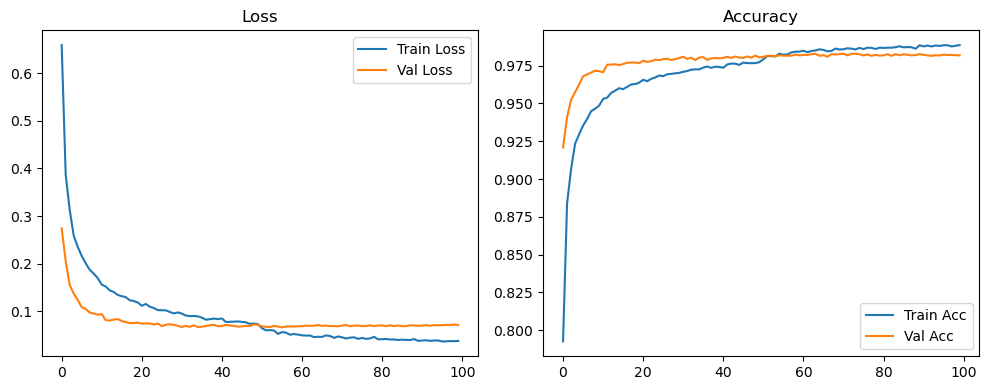

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3602, Acc: 0.8924 | Val Loss: 0.2233, Acc: 0.9321


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1870, Acc: 0.9426 | Val Loss: 0.1644, Acc: 0.9497


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1345, Acc: 0.9580 | Val Loss: 0.1116, Acc: 0.9669


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0971, Acc: 0.9691 | Val Loss: 0.1229, Acc: 0.9634


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0823, Acc: 0.9734 | Val Loss: 0.1313, Acc: 0.9615


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0683, Acc: 0.9776 | Val Loss: 0.0943, Acc: 0.9725


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0572, Acc: 0.9819 | Val Loss: 0.0943, Acc: 0.9736


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0511, Acc: 0.9834 | Val Loss: 0.0970, Acc: 0.9735


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9863 | Val Loss: 0.1059, Acc: 0.9737


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0425, Acc: 0.9860 | Val Loss: 0.1178, Acc: 0.9709


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0355, Acc: 0.9882 | Val Loss: 0.1080, Acc: 0.9747


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9898 | Val Loss: 0.1044, Acc: 0.9751


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9902 | Val Loss: 0.1013, Acc: 0.9771


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9900 | Val Loss: 0.1070, Acc: 0.9768


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9908 | Val Loss: 0.1141, Acc: 0.9745


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9919 | Val Loss: 0.1031, Acc: 0.9772


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9925 | Val Loss: 0.1025, Acc: 0.9772


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9931 | Val Loss: 0.1017, Acc: 0.9770


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.1037, Acc: 0.9797


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9929 | Val Loss: 0.1057, Acc: 0.9790


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9940 | Val Loss: 0.1105, Acc: 0.9768


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9937 | Val Loss: 0.1125, Acc: 0.9783


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9947 | Val Loss: 0.1186, Acc: 0.9784


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.1037, Acc: 0.9799


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.1253, Acc: 0.9782


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9949 | Val Loss: 0.1136, Acc: 0.9788


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.1203, Acc: 0.9780


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.1356, Acc: 0.9740


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1213, Acc: 0.9776


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.1131, Acc: 0.9782


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9951 | Val Loss: 0.1207, Acc: 0.9771


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.1153, Acc: 0.9770


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9957 | Val Loss: 0.1078, Acc: 0.9782


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9966 | Val Loss: 0.1305, Acc: 0.9781


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1091, Acc: 0.9783


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.1127, Acc: 0.9792


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1067, Acc: 0.9806


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1154, Acc: 0.9782


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1067, Acc: 0.9791


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1181, Acc: 0.9776


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1240, Acc: 0.9772


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1099, Acc: 0.9811


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1094, Acc: 0.9798


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1222, Acc: 0.9769


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.1157, Acc: 0.9788


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1200, Acc: 0.9788


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1198, Acc: 0.9784


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1100, Acc: 0.9804


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1209, Acc: 0.9792


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1097, Acc: 0.9808


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1183, Acc: 0.9796


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.1255, Acc: 0.9773


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9974 | Val Loss: 0.1119, Acc: 0.9798


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1101, Acc: 0.9808


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.1260, Acc: 0.9794


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1254, Acc: 0.9804


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1105, Acc: 0.9814


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1467, Acc: 0.9765


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.1258, Acc: 0.9786


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1092, Acc: 0.9815


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1235, Acc: 0.9791


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1062, Acc: 0.9817


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.1086, Acc: 0.9808


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.1199, Acc: 0.9802


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.1217, Acc: 0.9796


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1213, Acc: 0.9802


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1173, Acc: 0.9822


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1376, Acc: 0.9767


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1162, Acc: 0.9812


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1241, Acc: 0.9802


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1197, Acc: 0.9804


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1192, Acc: 0.9809


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1103, Acc: 0.9809


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1142, Acc: 0.9815


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9980 | Val Loss: 0.1253, Acc: 0.9812


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1227, Acc: 0.9799


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1294, Acc: 0.9812


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9980 | Val Loss: 0.1174, Acc: 0.9817


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1121, Acc: 0.9812


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1224, Acc: 0.9803


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1314, Acc: 0.9797


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1183, Acc: 0.9820


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1334, Acc: 0.9812


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1213, Acc: 0.9808


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1325, Acc: 0.9797


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1277, Acc: 0.9788


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1333, Acc: 0.9786


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1371, Acc: 0.9793


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1311, Acc: 0.9801


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1296, Acc: 0.9805


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1201, Acc: 0.9812


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1345, Acc: 0.9807


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1358, Acc: 0.9794


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1398, Acc: 0.9806


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1320, Acc: 0.9808


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1345, Acc: 0.9811


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1296, Acc: 0.9791


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1324, Acc: 0.9807


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1418, Acc: 0.9786


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1258, Acc: 0.9802


Final Test Loss: 0.1320 Accuracy: 0.9815


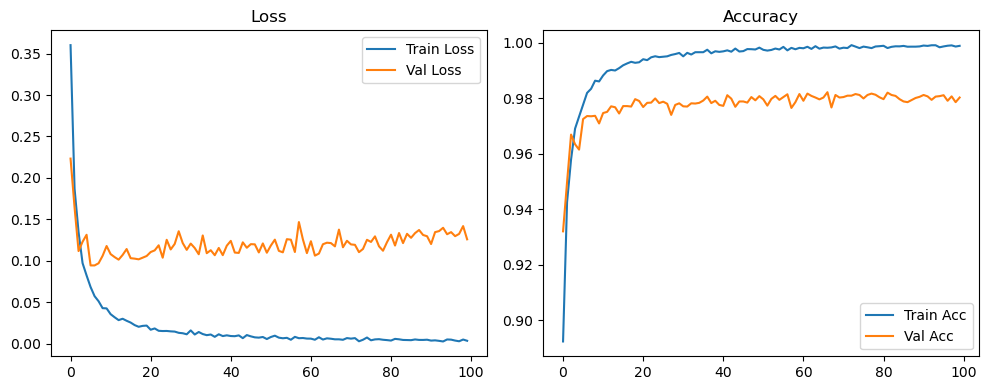

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4613, Acc: 0.8602 | Val Loss: 0.2603, Acc: 0.9235


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2684, Acc: 0.9185 | Val Loss: 0.1815, Acc: 0.9477


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1994, Acc: 0.9397 | Val Loss: 0.1317, Acc: 0.9608


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1571, Acc: 0.9519 | Val Loss: 0.1202, Acc: 0.9652


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1367, Acc: 0.9584 | Val Loss: 0.1159, Acc: 0.9653


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1185, Acc: 0.9635 | Val Loss: 0.0957, Acc: 0.9708


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1046, Acc: 0.9678 | Val Loss: 0.0957, Acc: 0.9730


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0927, Acc: 0.9703 | Val Loss: 0.0880, Acc: 0.9743


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0877, Acc: 0.9727 | Val Loss: 0.0913, Acc: 0.9751


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0797, Acc: 0.9748 | Val Loss: 0.0857, Acc: 0.9773


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0738, Acc: 0.9765 | Val Loss: 0.0792, Acc: 0.9781


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0673, Acc: 0.9777 | Val Loss: 0.0825, Acc: 0.9781


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0602, Acc: 0.9801 | Val Loss: 0.0816, Acc: 0.9778


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0606, Acc: 0.9801 | Val Loss: 0.0848, Acc: 0.9776


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0590, Acc: 0.9813 | Val Loss: 0.0805, Acc: 0.9788


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0551, Acc: 0.9818 | Val Loss: 0.0843, Acc: 0.9783


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9825 | Val Loss: 0.0766, Acc: 0.9796


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9843 | Val Loss: 0.0865, Acc: 0.9777


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0465, Acc: 0.9846 | Val Loss: 0.0859, Acc: 0.9784


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0466, Acc: 0.9847 | Val Loss: 0.0818, Acc: 0.9788


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9867 | Val Loss: 0.0816, Acc: 0.9780


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0405, Acc: 0.9861 | Val Loss: 0.0770, Acc: 0.9812


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9873 | Val Loss: 0.0747, Acc: 0.9810


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9866 | Val Loss: 0.0687, Acc: 0.9811


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9893 | Val Loss: 0.0811, Acc: 0.9797


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9876 | Val Loss: 0.0781, Acc: 0.9807


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9892 | Val Loss: 0.0805, Acc: 0.9824


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9907 | Val Loss: 0.0866, Acc: 0.9797


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9894 | Val Loss: 0.0830, Acc: 0.9810


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9897 | Val Loss: 0.0852, Acc: 0.9806


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9900 | Val Loss: 0.0779, Acc: 0.9808


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9896 | Val Loss: 0.0796, Acc: 0.9824


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9898 | Val Loss: 0.0812, Acc: 0.9816


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9915 | Val Loss: 0.0781, Acc: 0.9820


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9917 | Val Loss: 0.0849, Acc: 0.9810


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9905 | Val Loss: 0.0820, Acc: 0.9813


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9923 | Val Loss: 0.0796, Acc: 0.9818


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.0783, Acc: 0.9807


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9910 | Val Loss: 0.0736, Acc: 0.9817


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9918 | Val Loss: 0.0751, Acc: 0.9819


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9923 | Val Loss: 0.0785, Acc: 0.9819


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9920 | Val Loss: 0.0746, Acc: 0.9837


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9915 | Val Loss: 0.0738, Acc: 0.9829


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9930 | Val Loss: 0.0706, Acc: 0.9840


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9930 | Val Loss: 0.0829, Acc: 0.9831


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9930 | Val Loss: 0.0860, Acc: 0.9805


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.0886, Acc: 0.9807


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9930 | Val Loss: 0.0859, Acc: 0.9819


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9936 | Val Loss: 0.0910, Acc: 0.9832


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9936 | Val Loss: 0.0823, Acc: 0.9831


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9932 | Val Loss: 0.0801, Acc: 0.9822


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9939 | Val Loss: 0.0827, Acc: 0.9821


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9933 | Val Loss: 0.0766, Acc: 0.9822


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9930 | Val Loss: 0.0890, Acc: 0.9818


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9939 | Val Loss: 0.0833, Acc: 0.9832


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9933 | Val Loss: 0.0829, Acc: 0.9817


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9935 | Val Loss: 0.0828, Acc: 0.9838


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9946 | Val Loss: 0.0843, Acc: 0.9830


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9939 | Val Loss: 0.0837, Acc: 0.9834


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9947 | Val Loss: 0.0865, Acc: 0.9818


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9934 | Val Loss: 0.0796, Acc: 0.9822


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.0819, Acc: 0.9826


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.0866, Acc: 0.9827


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.0945, Acc: 0.9814


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9943 | Val Loss: 0.0879, Acc: 0.9808


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.0927, Acc: 0.9823


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9943 | Val Loss: 0.0799, Acc: 0.9829


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0860, Acc: 0.9810


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9947 | Val Loss: 0.0857, Acc: 0.9827


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9952 | Val Loss: 0.0884, Acc: 0.9812


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9944 | Val Loss: 0.0835, Acc: 0.9835


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9948 | Val Loss: 0.0889, Acc: 0.9824


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.0824, Acc: 0.9828


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9943 | Val Loss: 0.0949, Acc: 0.9812


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9955 | Val Loss: 0.0823, Acc: 0.9832


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.0872, Acc: 0.9835


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.0902, Acc: 0.9809


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.0832, Acc: 0.9831


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9946 | Val Loss: 0.0874, Acc: 0.9836


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.0816, Acc: 0.9840


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0882, Acc: 0.9828


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.0872, Acc: 0.9828


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.0905, Acc: 0.9828


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.0785, Acc: 0.9839


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.0874, Acc: 0.9842


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.0844, Acc: 0.9832


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.0801, Acc: 0.9824


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.0863, Acc: 0.9829


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.0874, Acc: 0.9827


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9956 | Val Loss: 0.0948, Acc: 0.9820


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.0890, Acc: 0.9816


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9953 | Val Loss: 0.0893, Acc: 0.9837


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.0858, Acc: 0.9835


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9962 | Val Loss: 0.0791, Acc: 0.9855


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9960 | Val Loss: 0.0829, Acc: 0.9835


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.0879, Acc: 0.9832


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.0906, Acc: 0.9827


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9962 | Val Loss: 0.0912, Acc: 0.9819


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.0872, Acc: 0.9841


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0821, Acc: 0.9832


Final Test Loss: 0.0772 Accuracy: 0.9848


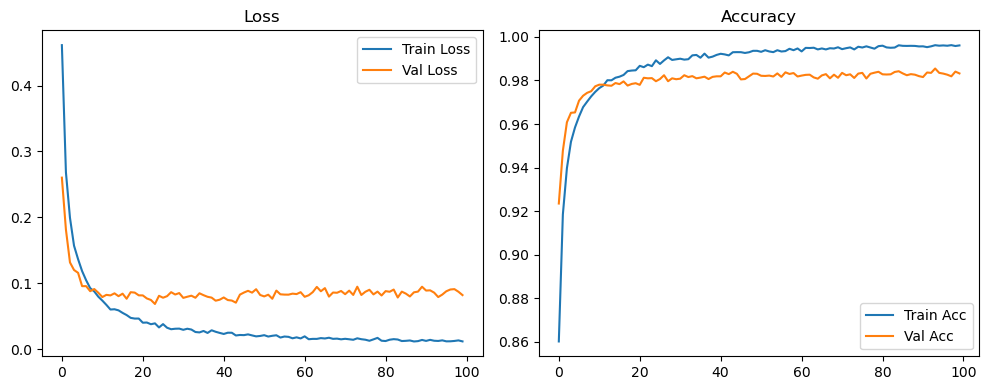

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.6958, Acc: 0.7784 | Val Loss: 0.3133, Acc: 0.9061


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.4266, Acc: 0.8711 | Val Loss: 0.2405, Acc: 0.9314


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.3490, Acc: 0.8952 | Val Loss: 0.1863, Acc: 0.9442


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2893, Acc: 0.9133 | Val Loss: 0.1642, Acc: 0.9507


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2580, Acc: 0.9236 | Val Loss: 0.1524, Acc: 0.9576


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.2352, Acc: 0.9300 | Val Loss: 0.1291, Acc: 0.9611


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.2169, Acc: 0.9343 | Val Loss: 0.1172, Acc: 0.9656


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1998, Acc: 0.9399 | Val Loss: 0.1120, Acc: 0.9671


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1925, Acc: 0.9417 | Val Loss: 0.1111, Acc: 0.9674


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1838, Acc: 0.9442 | Val Loss: 0.1007, Acc: 0.9698


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1730, Acc: 0.9484 | Val Loss: 0.1018, Acc: 0.9692


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1689, Acc: 0.9494 | Val Loss: 0.0909, Acc: 0.9725


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1568, Acc: 0.9529 | Val Loss: 0.0887, Acc: 0.9742


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1561, Acc: 0.9534 | Val Loss: 0.0901, Acc: 0.9723


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1478, Acc: 0.9554 | Val Loss: 0.0882, Acc: 0.9728


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1458, Acc: 0.9555 | Val Loss: 0.0887, Acc: 0.9742


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1410, Acc: 0.9569 | Val Loss: 0.0842, Acc: 0.9749


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1333, Acc: 0.9595 | Val Loss: 0.0838, Acc: 0.9734


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1331, Acc: 0.9592 | Val Loss: 0.0870, Acc: 0.9742


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.1296, Acc: 0.9609 | Val Loss: 0.0788, Acc: 0.9763


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.1232, Acc: 0.9625 | Val Loss: 0.0771, Acc: 0.9768


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.1216, Acc: 0.9624 | Val Loss: 0.0821, Acc: 0.9760


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.1209, Acc: 0.9623 | Val Loss: 0.0782, Acc: 0.9776


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.1177, Acc: 0.9641 | Val Loss: 0.0762, Acc: 0.9782


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.1102, Acc: 0.9659 | Val Loss: 0.0800, Acc: 0.9765


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.1103, Acc: 0.9651 | Val Loss: 0.0792, Acc: 0.9766


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.1061, Acc: 0.9667 | Val Loss: 0.0800, Acc: 0.9777


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.1060, Acc: 0.9674 | Val Loss: 0.0780, Acc: 0.9767


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.1057, Acc: 0.9668 | Val Loss: 0.0726, Acc: 0.9792


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0996, Acc: 0.9696 | Val Loss: 0.0801, Acc: 0.9785


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.1035, Acc: 0.9687 | Val Loss: 0.0745, Acc: 0.9782


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0992, Acc: 0.9697 | Val Loss: 0.0731, Acc: 0.9788


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0942, Acc: 0.9706 | Val Loss: 0.0688, Acc: 0.9793


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0939, Acc: 0.9708 | Val Loss: 0.0741, Acc: 0.9792


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0934, Acc: 0.9699 | Val Loss: 0.0735, Acc: 0.9789


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0891, Acc: 0.9714 | Val Loss: 0.0741, Acc: 0.9788


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0896, Acc: 0.9723 | Val Loss: 0.0698, Acc: 0.9790


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0871, Acc: 0.9728 | Val Loss: 0.0740, Acc: 0.9790


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0899, Acc: 0.9726 | Val Loss: 0.0746, Acc: 0.9794


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0839, Acc: 0.9731 | Val Loss: 0.0734, Acc: 0.9790


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0848, Acc: 0.9740 | Val Loss: 0.0736, Acc: 0.9782


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0823, Acc: 0.9739 | Val Loss: 0.0733, Acc: 0.9782


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0840, Acc: 0.9736 | Val Loss: 0.0728, Acc: 0.9799


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0828, Acc: 0.9738 | Val Loss: 0.0730, Acc: 0.9798


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0813, Acc: 0.9739 | Val Loss: 0.0719, Acc: 0.9790


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0776, Acc: 0.9762 | Val Loss: 0.0734, Acc: 0.9798


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0817, Acc: 0.9743 | Val Loss: 0.0708, Acc: 0.9798


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0759, Acc: 0.9771 | Val Loss: 0.0739, Acc: 0.9788


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0774, Acc: 0.9755 | Val Loss: 0.0767, Acc: 0.9791


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0791, Acc: 0.9758 | Val Loss: 0.0729, Acc: 0.9788


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0769, Acc: 0.9755 | Val Loss: 0.0703, Acc: 0.9808


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0755, Acc: 0.9764 | Val Loss: 0.0716, Acc: 0.9806


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0764, Acc: 0.9761 | Val Loss: 0.0705, Acc: 0.9796


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0767, Acc: 0.9760 | Val Loss: 0.0694, Acc: 0.9808


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0687, Acc: 0.9779 | Val Loss: 0.0756, Acc: 0.9793


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0739, Acc: 0.9769 | Val Loss: 0.0703, Acc: 0.9802


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0723, Acc: 0.9771 | Val Loss: 0.0708, Acc: 0.9801


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0694, Acc: 0.9784 | Val Loss: 0.0721, Acc: 0.9802


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0700, Acc: 0.9783 | Val Loss: 0.0733, Acc: 0.9800


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0701, Acc: 0.9779 | Val Loss: 0.0691, Acc: 0.9809


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0704, Acc: 0.9783 | Val Loss: 0.0697, Acc: 0.9811


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0692, Acc: 0.9787 | Val Loss: 0.0704, Acc: 0.9803


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0675, Acc: 0.9788 | Val Loss: 0.0723, Acc: 0.9802


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0642, Acc: 0.9800 | Val Loss: 0.0729, Acc: 0.9809


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0634, Acc: 0.9789 | Val Loss: 0.0718, Acc: 0.9802


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0650, Acc: 0.9793 | Val Loss: 0.0702, Acc: 0.9802


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0685, Acc: 0.9782 | Val Loss: 0.0697, Acc: 0.9803


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0676, Acc: 0.9792 | Val Loss: 0.0698, Acc: 0.9808


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0629, Acc: 0.9802 | Val Loss: 0.0729, Acc: 0.9802


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0616, Acc: 0.9801 | Val Loss: 0.0718, Acc: 0.9811


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0639, Acc: 0.9795 | Val Loss: 0.0719, Acc: 0.9803


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0603, Acc: 0.9810 | Val Loss: 0.0732, Acc: 0.9795


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0653, Acc: 0.9798 | Val Loss: 0.0710, Acc: 0.9805


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0658, Acc: 0.9788 | Val Loss: 0.0750, Acc: 0.9801


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0633, Acc: 0.9810 | Val Loss: 0.0726, Acc: 0.9787


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0618, Acc: 0.9803 | Val Loss: 0.0719, Acc: 0.9803


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0573, Acc: 0.9811 | Val Loss: 0.0724, Acc: 0.9807


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0597, Acc: 0.9812 | Val Loss: 0.0727, Acc: 0.9810


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0615, Acc: 0.9805 | Val Loss: 0.0723, Acc: 0.9806


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0595, Acc: 0.9812 | Val Loss: 0.0706, Acc: 0.9803


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0589, Acc: 0.9814 | Val Loss: 0.0729, Acc: 0.9806


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0598, Acc: 0.9811 | Val Loss: 0.0691, Acc: 0.9813


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0560, Acc: 0.9824 | Val Loss: 0.0748, Acc: 0.9803


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0584, Acc: 0.9819 | Val Loss: 0.0746, Acc: 0.9806


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0605, Acc: 0.9811 | Val Loss: 0.0736, Acc: 0.9801


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0568, Acc: 0.9827 | Val Loss: 0.0727, Acc: 0.9809


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0562, Acc: 0.9824 | Val Loss: 0.0726, Acc: 0.9808


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0538, Acc: 0.9821 | Val Loss: 0.0726, Acc: 0.9802


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0554, Acc: 0.9825 | Val Loss: 0.0759, Acc: 0.9811


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0534, Acc: 0.9835 | Val Loss: 0.0753, Acc: 0.9816


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0567, Acc: 0.9828 | Val Loss: 0.0760, Acc: 0.9810


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0545, Acc: 0.9821 | Val Loss: 0.0751, Acc: 0.9803


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0540, Acc: 0.9828 | Val Loss: 0.0723, Acc: 0.9814


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0525, Acc: 0.9835 | Val Loss: 0.0736, Acc: 0.9812


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0555, Acc: 0.9825 | Val Loss: 0.0713, Acc: 0.9807


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0541, Acc: 0.9828 | Val Loss: 0.0704, Acc: 0.9815


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0519, Acc: 0.9837 | Val Loss: 0.0722, Acc: 0.9812


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0540, Acc: 0.9832 | Val Loss: 0.0701, Acc: 0.9819


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9838 | Val Loss: 0.0729, Acc: 0.9819


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0513, Acc: 0.9844 | Val Loss: 0.0707, Acc: 0.9818


Final Test Loss: 0.0623 Accuracy: 0.9842


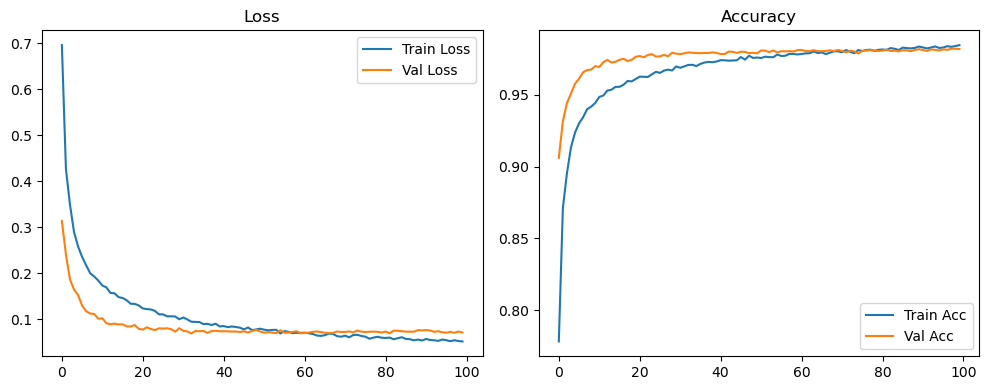

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3602, Acc: 0.8924 | Val Loss: 0.2233, Acc: 0.9321


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1870, Acc: 0.9426 | Val Loss: 0.1644, Acc: 0.9497


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1345, Acc: 0.9580 | Val Loss: 0.1116, Acc: 0.9669


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0971, Acc: 0.9691 | Val Loss: 0.1229, Acc: 0.9634


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0823, Acc: 0.9734 | Val Loss: 0.1313, Acc: 0.9615


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0683, Acc: 0.9776 | Val Loss: 0.0943, Acc: 0.9725


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0572, Acc: 0.9819 | Val Loss: 0.0943, Acc: 0.9736


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0511, Acc: 0.9834 | Val Loss: 0.0970, Acc: 0.9735


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9863 | Val Loss: 0.1059, Acc: 0.9737


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0425, Acc: 0.9860 | Val Loss: 0.1178, Acc: 0.9709


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0355, Acc: 0.9882 | Val Loss: 0.1080, Acc: 0.9747


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9898 | Val Loss: 0.1044, Acc: 0.9751


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9902 | Val Loss: 0.1013, Acc: 0.9771


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9900 | Val Loss: 0.1070, Acc: 0.9768


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9908 | Val Loss: 0.1141, Acc: 0.9745


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9919 | Val Loss: 0.1031, Acc: 0.9772


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9925 | Val Loss: 0.1025, Acc: 0.9772


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9931 | Val Loss: 0.1017, Acc: 0.9770


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.1037, Acc: 0.9797


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9929 | Val Loss: 0.1057, Acc: 0.9790


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9940 | Val Loss: 0.1105, Acc: 0.9768


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9937 | Val Loss: 0.1125, Acc: 0.9783


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9947 | Val Loss: 0.1186, Acc: 0.9784


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.1037, Acc: 0.9799


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.1253, Acc: 0.9782


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9949 | Val Loss: 0.1136, Acc: 0.9788


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.1203, Acc: 0.9780


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.1356, Acc: 0.9740


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1213, Acc: 0.9776


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.1131, Acc: 0.9782


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9951 | Val Loss: 0.1207, Acc: 0.9771


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.1153, Acc: 0.9770


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9957 | Val Loss: 0.1078, Acc: 0.9782


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9966 | Val Loss: 0.1305, Acc: 0.9781


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1091, Acc: 0.9783


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.1127, Acc: 0.9792


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1067, Acc: 0.9806


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1154, Acc: 0.9782


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1067, Acc: 0.9791


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1181, Acc: 0.9776


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1240, Acc: 0.9772


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1099, Acc: 0.9811


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1094, Acc: 0.9798


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1222, Acc: 0.9769


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.1157, Acc: 0.9788


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1200, Acc: 0.9788


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1198, Acc: 0.9784


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1100, Acc: 0.9804


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1209, Acc: 0.9792


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1097, Acc: 0.9808


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1049, Acc: 0.9822


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1072, Acc: 0.9824


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0978, Acc: 0.9836


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1069, Acc: 0.9822


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1043, Acc: 0.9828


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1049, Acc: 0.9829


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9991 | Val Loss: 0.1120, Acc: 0.9822


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1196, Acc: 0.9829


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1162, Acc: 0.9812


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1086, Acc: 0.9822


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1162, Acc: 0.9817


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1198, Acc: 0.9808


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1121, Acc: 0.9824


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1218, Acc: 0.9818


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1124, Acc: 0.9814


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1199, Acc: 0.9809


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1117, Acc: 0.9820


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1089, Acc: 0.9829


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1154, Acc: 0.9838


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1137, Acc: 0.9819


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1144, Acc: 0.9815


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1132, Acc: 0.9808


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1101, Acc: 0.9821


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1223, Acc: 0.9809


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1147, Acc: 0.9827


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1109, Acc: 0.9828


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1123, Acc: 0.9826


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1158, Acc: 0.9819


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1113, Acc: 0.9828


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1122, Acc: 0.9822


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1135, Acc: 0.9817


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1099, Acc: 0.9817


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1056, Acc: 0.9828


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1149, Acc: 0.9823


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1059, Acc: 0.9822


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1067, Acc: 0.9828


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1092, Acc: 0.9829


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1100, Acc: 0.9831


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1166, Acc: 0.9828


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1115, Acc: 0.9827


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1118, Acc: 0.9831


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1171, Acc: 0.9831


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1256, Acc: 0.9813


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1145, Acc: 0.9832


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1120, Acc: 0.9836


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1194, Acc: 0.9832


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1246, Acc: 0.9827


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1197, Acc: 0.9833


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1225, Acc: 0.9825


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1199, Acc: 0.9828


Final Test Loss: 0.1267 Accuracy: 0.9839


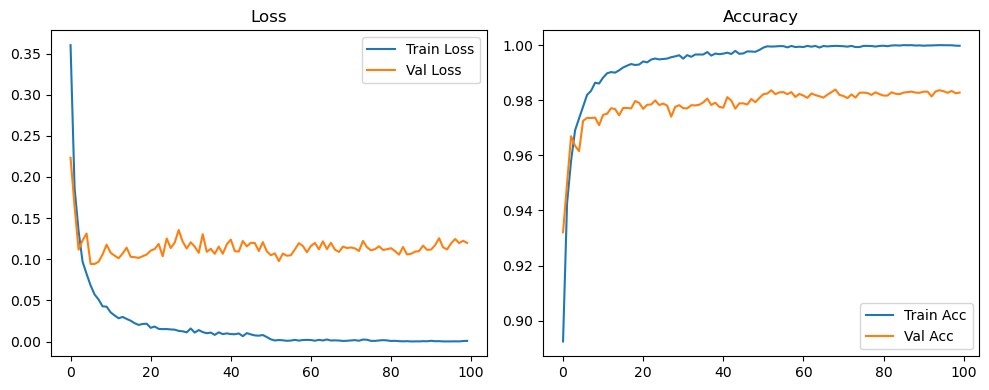

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4613, Acc: 0.8602 | Val Loss: 0.2603, Acc: 0.9235


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2684, Acc: 0.9185 | Val Loss: 0.1815, Acc: 0.9477


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1994, Acc: 0.9397 | Val Loss: 0.1317, Acc: 0.9608


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1571, Acc: 0.9519 | Val Loss: 0.1202, Acc: 0.9652


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1367, Acc: 0.9584 | Val Loss: 0.1159, Acc: 0.9653


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1185, Acc: 0.9635 | Val Loss: 0.0957, Acc: 0.9708


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1046, Acc: 0.9678 | Val Loss: 0.0957, Acc: 0.9730


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0927, Acc: 0.9703 | Val Loss: 0.0880, Acc: 0.9743


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0877, Acc: 0.9727 | Val Loss: 0.0913, Acc: 0.9751


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0797, Acc: 0.9748 | Val Loss: 0.0857, Acc: 0.9773


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0738, Acc: 0.9765 | Val Loss: 0.0792, Acc: 0.9781


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0673, Acc: 0.9777 | Val Loss: 0.0825, Acc: 0.9781


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0602, Acc: 0.9801 | Val Loss: 0.0816, Acc: 0.9778


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0606, Acc: 0.9801 | Val Loss: 0.0848, Acc: 0.9776


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0590, Acc: 0.9813 | Val Loss: 0.0805, Acc: 0.9788


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0551, Acc: 0.9818 | Val Loss: 0.0843, Acc: 0.9783


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9825 | Val Loss: 0.0766, Acc: 0.9796


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9843 | Val Loss: 0.0865, Acc: 0.9777


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0465, Acc: 0.9846 | Val Loss: 0.0859, Acc: 0.9784


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0466, Acc: 0.9847 | Val Loss: 0.0818, Acc: 0.9788


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9867 | Val Loss: 0.0816, Acc: 0.9780


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0405, Acc: 0.9861 | Val Loss: 0.0770, Acc: 0.9812


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9873 | Val Loss: 0.0747, Acc: 0.9810


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9866 | Val Loss: 0.0687, Acc: 0.9811


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9893 | Val Loss: 0.0811, Acc: 0.9797


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9876 | Val Loss: 0.0781, Acc: 0.9807


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9892 | Val Loss: 0.0805, Acc: 0.9824


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9907 | Val Loss: 0.0866, Acc: 0.9797


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9894 | Val Loss: 0.0830, Acc: 0.9810


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9897 | Val Loss: 0.0852, Acc: 0.9806


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9900 | Val Loss: 0.0779, Acc: 0.9808


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9896 | Val Loss: 0.0796, Acc: 0.9824


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9898 | Val Loss: 0.0812, Acc: 0.9816


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9915 | Val Loss: 0.0781, Acc: 0.9820


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9917 | Val Loss: 0.0849, Acc: 0.9810


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9905 | Val Loss: 0.0820, Acc: 0.9813


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9923 | Val Loss: 0.0796, Acc: 0.9818


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.0783, Acc: 0.9807


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9910 | Val Loss: 0.0736, Acc: 0.9817


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9918 | Val Loss: 0.0751, Acc: 0.9819


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9923 | Val Loss: 0.0785, Acc: 0.9819


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9920 | Val Loss: 0.0746, Acc: 0.9837


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9915 | Val Loss: 0.0738, Acc: 0.9829


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9930 | Val Loss: 0.0706, Acc: 0.9840


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9930 | Val Loss: 0.0829, Acc: 0.9831


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9930 | Val Loss: 0.0860, Acc: 0.9805


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.0886, Acc: 0.9807


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9930 | Val Loss: 0.0859, Acc: 0.9819


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9936 | Val Loss: 0.0910, Acc: 0.9832


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9936 | Val Loss: 0.0823, Acc: 0.9831


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.0767, Acc: 0.9836


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.0753, Acc: 0.9842


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.0726, Acc: 0.9847


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.0799, Acc: 0.9837


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9969 | Val Loss: 0.0804, Acc: 0.9843


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0719, Acc: 0.9845


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9964 | Val Loss: 0.0777, Acc: 0.9846


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0767, Acc: 0.9838


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.0782, Acc: 0.9843


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0789, Acc: 0.9836


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0765, Acc: 0.9838


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0760, Acc: 0.9852


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0851, Acc: 0.9836


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.0868, Acc: 0.9833


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.0811, Acc: 0.9843


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9972 | Val Loss: 0.0859, Acc: 0.9838


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0837, Acc: 0.9843


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.0823, Acc: 0.9850


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0818, Acc: 0.9848


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.0839, Acc: 0.9848


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.0831, Acc: 0.9840


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0887, Acc: 0.9833


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0881, Acc: 0.9840


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0860, Acc: 0.9846


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0795, Acc: 0.9857


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.0822, Acc: 0.9850


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.0809, Acc: 0.9849


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.0779, Acc: 0.9847


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.0756, Acc: 0.9858


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0808, Acc: 0.9852


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0798, Acc: 0.9855


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0815, Acc: 0.9857


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0873, Acc: 0.9846


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0794, Acc: 0.9860


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0800, Acc: 0.9862


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0808, Acc: 0.9856


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0829, Acc: 0.9852


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0852, Acc: 0.9848


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0841, Acc: 0.9850


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.0832, Acc: 0.9853


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0860, Acc: 0.9852


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0859, Acc: 0.9852


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0839, Acc: 0.9854


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0854, Acc: 0.9852


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0843, Acc: 0.9855


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9982 | Val Loss: 0.0823, Acc: 0.9854


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0823, Acc: 0.9854


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0857, Acc: 0.9842


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0849, Acc: 0.9847


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0840, Acc: 0.9847


Final Test Loss: 0.0816 Accuracy: 0.9863


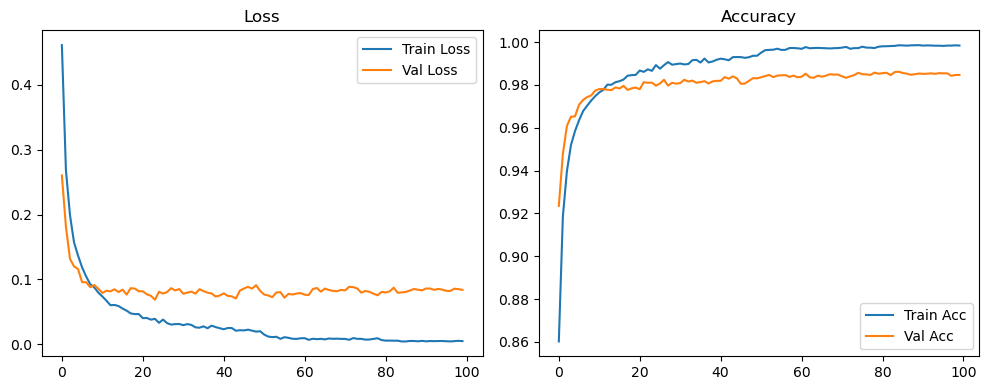

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.6958, Acc: 0.7784 | Val Loss: 0.3133, Acc: 0.9061


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.4266, Acc: 0.8711 | Val Loss: 0.2405, Acc: 0.9314


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.3490, Acc: 0.8952 | Val Loss: 0.1863, Acc: 0.9442


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2893, Acc: 0.9133 | Val Loss: 0.1642, Acc: 0.9507


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2580, Acc: 0.9236 | Val Loss: 0.1524, Acc: 0.9576


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.2352, Acc: 0.9300 | Val Loss: 0.1291, Acc: 0.9611


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.2169, Acc: 0.9343 | Val Loss: 0.1172, Acc: 0.9656


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1998, Acc: 0.9399 | Val Loss: 0.1120, Acc: 0.9671


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1925, Acc: 0.9417 | Val Loss: 0.1111, Acc: 0.9674


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1838, Acc: 0.9442 | Val Loss: 0.1007, Acc: 0.9698


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1730, Acc: 0.9484 | Val Loss: 0.1018, Acc: 0.9692


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1689, Acc: 0.9494 | Val Loss: 0.0909, Acc: 0.9725


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1568, Acc: 0.9529 | Val Loss: 0.0887, Acc: 0.9742


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1561, Acc: 0.9534 | Val Loss: 0.0901, Acc: 0.9723


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1478, Acc: 0.9554 | Val Loss: 0.0882, Acc: 0.9728


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1458, Acc: 0.9555 | Val Loss: 0.0887, Acc: 0.9742


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1410, Acc: 0.9569 | Val Loss: 0.0842, Acc: 0.9749


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1333, Acc: 0.9595 | Val Loss: 0.0838, Acc: 0.9734


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1331, Acc: 0.9592 | Val Loss: 0.0870, Acc: 0.9742


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.1296, Acc: 0.9609 | Val Loss: 0.0788, Acc: 0.9763


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.1232, Acc: 0.9625 | Val Loss: 0.0771, Acc: 0.9768


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.1216, Acc: 0.9624 | Val Loss: 0.0821, Acc: 0.9760


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.1209, Acc: 0.9623 | Val Loss: 0.0782, Acc: 0.9776


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.1177, Acc: 0.9641 | Val Loss: 0.0762, Acc: 0.9782


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.1102, Acc: 0.9659 | Val Loss: 0.0800, Acc: 0.9765


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.1103, Acc: 0.9651 | Val Loss: 0.0792, Acc: 0.9766


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.1061, Acc: 0.9667 | Val Loss: 0.0800, Acc: 0.9777


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.1060, Acc: 0.9674 | Val Loss: 0.0780, Acc: 0.9767


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.1057, Acc: 0.9668 | Val Loss: 0.0726, Acc: 0.9792


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0996, Acc: 0.9696 | Val Loss: 0.0801, Acc: 0.9785


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.1035, Acc: 0.9687 | Val Loss: 0.0745, Acc: 0.9782


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0992, Acc: 0.9697 | Val Loss: 0.0731, Acc: 0.9788


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0942, Acc: 0.9706 | Val Loss: 0.0688, Acc: 0.9793


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0939, Acc: 0.9708 | Val Loss: 0.0741, Acc: 0.9792


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0934, Acc: 0.9699 | Val Loss: 0.0735, Acc: 0.9789


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0891, Acc: 0.9714 | Val Loss: 0.0741, Acc: 0.9788


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0896, Acc: 0.9723 | Val Loss: 0.0698, Acc: 0.9790


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0871, Acc: 0.9728 | Val Loss: 0.0740, Acc: 0.9790


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0899, Acc: 0.9726 | Val Loss: 0.0746, Acc: 0.9794


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0839, Acc: 0.9731 | Val Loss: 0.0734, Acc: 0.9790


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0848, Acc: 0.9740 | Val Loss: 0.0736, Acc: 0.9782


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0823, Acc: 0.9739 | Val Loss: 0.0733, Acc: 0.9782


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0840, Acc: 0.9736 | Val Loss: 0.0728, Acc: 0.9799


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0828, Acc: 0.9738 | Val Loss: 0.0730, Acc: 0.9798


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0813, Acc: 0.9739 | Val Loss: 0.0719, Acc: 0.9790


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0776, Acc: 0.9762 | Val Loss: 0.0734, Acc: 0.9798


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0817, Acc: 0.9743 | Val Loss: 0.0708, Acc: 0.9798


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0759, Acc: 0.9771 | Val Loss: 0.0739, Acc: 0.9788


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0774, Acc: 0.9755 | Val Loss: 0.0767, Acc: 0.9791


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0791, Acc: 0.9758 | Val Loss: 0.0729, Acc: 0.9788


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0699, Acc: 0.9782 | Val Loss: 0.0685, Acc: 0.9801


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0658, Acc: 0.9787 | Val Loss: 0.0695, Acc: 0.9815


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0637, Acc: 0.9795 | Val Loss: 0.0686, Acc: 0.9808


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0631, Acc: 0.9800 | Val Loss: 0.0684, Acc: 0.9809


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0560, Acc: 0.9822 | Val Loss: 0.0710, Acc: 0.9809


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0601, Acc: 0.9816 | Val Loss: 0.0677, Acc: 0.9816


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0568, Acc: 0.9824 | Val Loss: 0.0680, Acc: 0.9817


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0558, Acc: 0.9822 | Val Loss: 0.0698, Acc: 0.9811


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0548, Acc: 0.9822 | Val Loss: 0.0708, Acc: 0.9818


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0566, Acc: 0.9824 | Val Loss: 0.0690, Acc: 0.9817


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0544, Acc: 0.9826 | Val Loss: 0.0696, Acc: 0.9812


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0544, Acc: 0.9823 | Val Loss: 0.0704, Acc: 0.9812


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0554, Acc: 0.9823 | Val Loss: 0.0715, Acc: 0.9808


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0514, Acc: 0.9836 | Val Loss: 0.0712, Acc: 0.9808


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0495, Acc: 0.9834 | Val Loss: 0.0722, Acc: 0.9813


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0515, Acc: 0.9830 | Val Loss: 0.0721, Acc: 0.9812


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0545, Acc: 0.9825 | Val Loss: 0.0705, Acc: 0.9817


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0536, Acc: 0.9829 | Val Loss: 0.0715, Acc: 0.9809


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0506, Acc: 0.9836 | Val Loss: 0.0712, Acc: 0.9812


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0485, Acc: 0.9840 | Val Loss: 0.0712, Acc: 0.9815


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0510, Acc: 0.9828 | Val Loss: 0.0720, Acc: 0.9823


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0473, Acc: 0.9855 | Val Loss: 0.0729, Acc: 0.9808


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0521, Acc: 0.9837 | Val Loss: 0.0713, Acc: 0.9812


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0540, Acc: 0.9826 | Val Loss: 0.0734, Acc: 0.9811


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0515, Acc: 0.9841 | Val Loss: 0.0713, Acc: 0.9815


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0493, Acc: 0.9847 | Val Loss: 0.0706, Acc: 0.9812


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0472, Acc: 0.9846 | Val Loss: 0.0707, Acc: 0.9812


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0456, Acc: 0.9858 | Val Loss: 0.0723, Acc: 0.9817


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0487, Acc: 0.9849 | Val Loss: 0.0720, Acc: 0.9816


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0485, Acc: 0.9842 | Val Loss: 0.0710, Acc: 0.9816


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0459, Acc: 0.9853 | Val Loss: 0.0716, Acc: 0.9812


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0469, Acc: 0.9848 | Val Loss: 0.0687, Acc: 0.9813


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0426, Acc: 0.9864 | Val Loss: 0.0733, Acc: 0.9817


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0431, Acc: 0.9861 | Val Loss: 0.0707, Acc: 0.9819


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0440, Acc: 0.9859 | Val Loss: 0.0711, Acc: 0.9822


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0430, Acc: 0.9868 | Val Loss: 0.0708, Acc: 0.9818


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0423, Acc: 0.9863 | Val Loss: 0.0712, Acc: 0.9818


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0394, Acc: 0.9871 | Val Loss: 0.0715, Acc: 0.9817


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0407, Acc: 0.9867 | Val Loss: 0.0731, Acc: 0.9818


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0408, Acc: 0.9872 | Val Loss: 0.0720, Acc: 0.9822


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0420, Acc: 0.9869 | Val Loss: 0.0744, Acc: 0.9819


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0402, Acc: 0.9870 | Val Loss: 0.0746, Acc: 0.9818


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0396, Acc: 0.9872 | Val Loss: 0.0710, Acc: 0.9822


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0392, Acc: 0.9878 | Val Loss: 0.0732, Acc: 0.9826


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0411, Acc: 0.9860 | Val Loss: 0.0722, Acc: 0.9817


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0398, Acc: 0.9874 | Val Loss: 0.0712, Acc: 0.9813


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0381, Acc: 0.9884 | Val Loss: 0.0728, Acc: 0.9819


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0395, Acc: 0.9871 | Val Loss: 0.0713, Acc: 0.9825


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0389, Acc: 0.9881 | Val Loss: 0.0745, Acc: 0.9824


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0394, Acc: 0.9878 | Val Loss: 0.0724, Acc: 0.9824


Final Test Loss: 0.0625 Accuracy: 0.9846


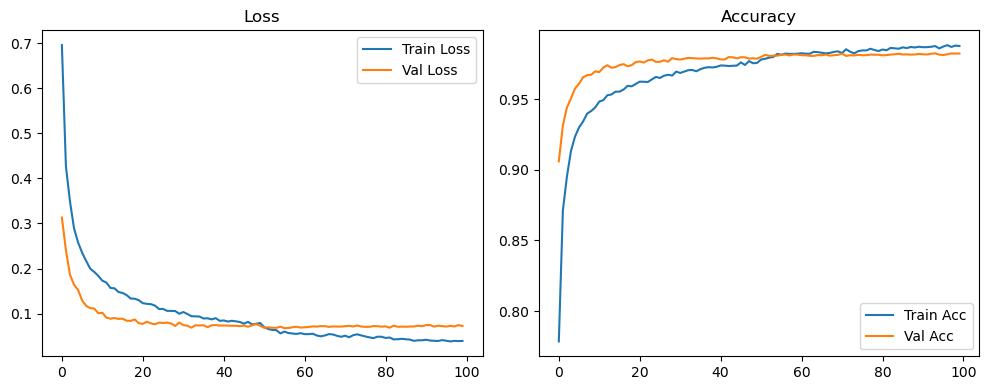

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3883, Acc: 0.8936 | Val Loss: 0.2528, Acc: 0.9245


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2036, Acc: 0.9377 | Val Loss: 0.1788, Acc: 0.9443


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1484, Acc: 0.9545 | Val Loss: 0.1381, Acc: 0.9603


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1096, Acc: 0.9651 | Val Loss: 0.1241, Acc: 0.9605


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0884, Acc: 0.9726 | Val Loss: 0.1165, Acc: 0.9638


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0742, Acc: 0.9761 | Val Loss: 0.0946, Acc: 0.9712


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0630, Acc: 0.9799 | Val Loss: 0.1001, Acc: 0.9699


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0558, Acc: 0.9819 | Val Loss: 0.0903, Acc: 0.9732


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0476, Acc: 0.9840 | Val Loss: 0.0941, Acc: 0.9731


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0435, Acc: 0.9857 | Val Loss: 0.1143, Acc: 0.9683


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0360, Acc: 0.9883 | Val Loss: 0.0878, Acc: 0.9755


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0345, Acc: 0.9881 | Val Loss: 0.0919, Acc: 0.9755


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0289, Acc: 0.9903 | Val Loss: 0.0943, Acc: 0.9761


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9897 | Val Loss: 0.0941, Acc: 0.9752


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9903 | Val Loss: 0.0992, Acc: 0.9757


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9911 | Val Loss: 0.1053, Acc: 0.9750


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9932 | Val Loss: 0.0882, Acc: 0.9770


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9925 | Val Loss: 0.1149, Acc: 0.9717


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9922 | Val Loss: 0.1083, Acc: 0.9754


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9936 | Val Loss: 0.0926, Acc: 0.9778


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9942 | Val Loss: 0.1010, Acc: 0.9757


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9938 | Val Loss: 0.0973, Acc: 0.9783


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9948 | Val Loss: 0.1018, Acc: 0.9775


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9950 | Val Loss: 0.0901, Acc: 0.9805


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.1031, Acc: 0.9775


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9949 | Val Loss: 0.1074, Acc: 0.9740


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1066, Acc: 0.9760


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9957 | Val Loss: 0.1145, Acc: 0.9771


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.1174, Acc: 0.9763


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.1078, Acc: 0.9782


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.1002, Acc: 0.9798


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9960 | Val Loss: 0.1114, Acc: 0.9764


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9958 | Val Loss: 0.1028, Acc: 0.9781


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1044, Acc: 0.9797


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1061, Acc: 0.9793


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.1136, Acc: 0.9776


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1006, Acc: 0.9794


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1072, Acc: 0.9787


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0967, Acc: 0.9804


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.1187, Acc: 0.9783


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1243, Acc: 0.9762


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.1139, Acc: 0.9779


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.1046, Acc: 0.9817


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.1026, Acc: 0.9805


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1073, Acc: 0.9798


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1244, Acc: 0.9775


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1156, Acc: 0.9784


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1171, Acc: 0.9792


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1258, Acc: 0.9774


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1178, Acc: 0.9794


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1123, Acc: 0.9782


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1005, Acc: 0.9812


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1068, Acc: 0.9797


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1192, Acc: 0.9803


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1242, Acc: 0.9791


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.1108, Acc: 0.9802


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1074, Acc: 0.9799


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1317, Acc: 0.9781


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1285, Acc: 0.9773


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9979 | Val Loss: 0.1129, Acc: 0.9815


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1267, Acc: 0.9798


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1176, Acc: 0.9806


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9982 | Val Loss: 0.1150, Acc: 0.9813


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1068, Acc: 0.9825


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1361, Acc: 0.9775


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1256, Acc: 0.9796


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1153, Acc: 0.9804


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1306, Acc: 0.9782


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1244, Acc: 0.9803


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1155, Acc: 0.9813


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1263, Acc: 0.9798


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1340, Acc: 0.9772


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1213, Acc: 0.9813


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.1196, Acc: 0.9808


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1219, Acc: 0.9807


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1165, Acc: 0.9818


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1226, Acc: 0.9806


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1243, Acc: 0.9802


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1203, Acc: 0.9808


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1242, Acc: 0.9808


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1309, Acc: 0.9798


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1263, Acc: 0.9810


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1328, Acc: 0.9798


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1304, Acc: 0.9807


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1329, Acc: 0.9793


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1318, Acc: 0.9808


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1290, Acc: 0.9802


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1291, Acc: 0.9810


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9985 | Val Loss: 0.1208, Acc: 0.9814


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1308, Acc: 0.9804


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1273, Acc: 0.9798


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1238, Acc: 0.9803


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1122, Acc: 0.9826


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1285, Acc: 0.9798


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1250, Acc: 0.9809


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1478, Acc: 0.9793


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1412, Acc: 0.9799


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1195, Acc: 0.9809


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1459, Acc: 0.9781


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1386, Acc: 0.9796


Final Test Loss: 0.1237 Accuracy: 0.9804


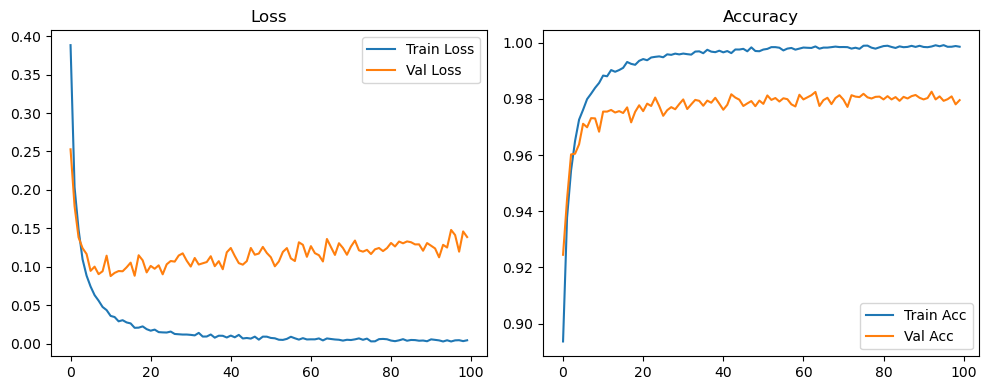

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.5109, Acc: 0.8537 | Val Loss: 0.2908, Acc: 0.9156


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.3085, Acc: 0.9073 | Val Loss: 0.2188, Acc: 0.9357


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.2423, Acc: 0.9262 | Val Loss: 0.1695, Acc: 0.9502


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1932, Acc: 0.9417 | Val Loss: 0.1453, Acc: 0.9568


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1674, Acc: 0.9486 | Val Loss: 0.1266, Acc: 0.9627


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1419, Acc: 0.9563 | Val Loss: 0.1088, Acc: 0.9672


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1248, Acc: 0.9617 | Val Loss: 0.1045, Acc: 0.9699


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1126, Acc: 0.9639 | Val Loss: 0.0983, Acc: 0.9699


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1039, Acc: 0.9668 | Val Loss: 0.0951, Acc: 0.9731


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0931, Acc: 0.9707 | Val Loss: 0.1006, Acc: 0.9719


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0826, Acc: 0.9738 | Val Loss: 0.0920, Acc: 0.9738


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0802, Acc: 0.9741 | Val Loss: 0.0825, Acc: 0.9771


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0718, Acc: 0.9769 | Val Loss: 0.0808, Acc: 0.9788


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0688, Acc: 0.9783 | Val Loss: 0.0820, Acc: 0.9764


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0692, Acc: 0.9778 | Val Loss: 0.0881, Acc: 0.9758


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0618, Acc: 0.9797 | Val Loss: 0.0835, Acc: 0.9784


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0572, Acc: 0.9814 | Val Loss: 0.0811, Acc: 0.9780


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0536, Acc: 0.9821 | Val Loss: 0.0825, Acc: 0.9778


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0557, Acc: 0.9812 | Val Loss: 0.0822, Acc: 0.9778


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0487, Acc: 0.9838 | Val Loss: 0.0811, Acc: 0.9778


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0454, Acc: 0.9844 | Val Loss: 0.0845, Acc: 0.9782


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0467, Acc: 0.9845 | Val Loss: 0.0783, Acc: 0.9788


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0430, Acc: 0.9853 | Val Loss: 0.0793, Acc: 0.9803


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0396, Acc: 0.9866 | Val Loss: 0.0749, Acc: 0.9802


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0399, Acc: 0.9864 | Val Loss: 0.0807, Acc: 0.9798


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0368, Acc: 0.9877 | Val Loss: 0.0784, Acc: 0.9802


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0381, Acc: 0.9871 | Val Loss: 0.0866, Acc: 0.9800


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0363, Acc: 0.9879 | Val Loss: 0.0898, Acc: 0.9768


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0358, Acc: 0.9880 | Val Loss: 0.0838, Acc: 0.9790


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0333, Acc: 0.9887 | Val Loss: 0.0838, Acc: 0.9810


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0340, Acc: 0.9883 | Val Loss: 0.0809, Acc: 0.9808


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0327, Acc: 0.9893 | Val Loss: 0.0800, Acc: 0.9816


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9891 | Val Loss: 0.0828, Acc: 0.9812


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9902 | Val Loss: 0.0853, Acc: 0.9805


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9904 | Val Loss: 0.0869, Acc: 0.9792


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9902 | Val Loss: 0.0838, Acc: 0.9814


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9906 | Val Loss: 0.0820, Acc: 0.9812


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9898 | Val Loss: 0.0858, Acc: 0.9806


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9907 | Val Loss: 0.0873, Acc: 0.9800


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9901 | Val Loss: 0.0866, Acc: 0.9801


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9920 | Val Loss: 0.0850, Acc: 0.9808


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9912 | Val Loss: 0.0838, Acc: 0.9808


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9923 | Val Loss: 0.0795, Acc: 0.9820


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9925 | Val Loss: 0.0791, Acc: 0.9811


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9923 | Val Loss: 0.0810, Acc: 0.9815


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9923 | Val Loss: 0.0844, Acc: 0.9815


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.0818, Acc: 0.9811


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9924 | Val Loss: 0.0834, Acc: 0.9821


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9929 | Val Loss: 0.0818, Acc: 0.9817


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9924 | Val Loss: 0.0865, Acc: 0.9803


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9928 | Val Loss: 0.0871, Acc: 0.9807


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9925 | Val Loss: 0.0824, Acc: 0.9820


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9926 | Val Loss: 0.0803, Acc: 0.9822


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9929 | Val Loss: 0.0816, Acc: 0.9825


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9938 | Val Loss: 0.0865, Acc: 0.9818


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9931 | Val Loss: 0.0877, Acc: 0.9800


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9938 | Val Loss: 0.0825, Acc: 0.9819


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9934 | Val Loss: 0.0910, Acc: 0.9808


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9934 | Val Loss: 0.0845, Acc: 0.9813


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9931 | Val Loss: 0.0877, Acc: 0.9818


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9940 | Val Loss: 0.0884, Acc: 0.9823


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9946 | Val Loss: 0.0923, Acc: 0.9816


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.0993, Acc: 0.9795


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0175, Acc: 0.9944 | Val Loss: 0.0943, Acc: 0.9824


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9941 | Val Loss: 0.0979, Acc: 0.9815


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.0915, Acc: 0.9826


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.0976, Acc: 0.9811


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9933 | Val Loss: 0.0910, Acc: 0.9818


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9948 | Val Loss: 0.0909, Acc: 0.9822


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.0930, Acc: 0.9816


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9939 | Val Loss: 0.0890, Acc: 0.9826


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9946 | Val Loss: 0.0967, Acc: 0.9808


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.0936, Acc: 0.9826


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9946 | Val Loss: 0.0896, Acc: 0.9826


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9948 | Val Loss: 0.0857, Acc: 0.9828


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9946 | Val Loss: 0.0918, Acc: 0.9826


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9950 | Val Loss: 0.0884, Acc: 0.9828


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.0940, Acc: 0.9811


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9941 | Val Loss: 0.0907, Acc: 0.9821


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.0904, Acc: 0.9813


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9953 | Val Loss: 0.0814, Acc: 0.9837


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9954 | Val Loss: 0.0834, Acc: 0.9830


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.1008, Acc: 0.9818


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9952 | Val Loss: 0.0928, Acc: 0.9823


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.0907, Acc: 0.9822


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.0861, Acc: 0.9825


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.0869, Acc: 0.9822


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0916, Acc: 0.9820


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.0926, Acc: 0.9826


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.0929, Acc: 0.9831


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.0842, Acc: 0.9840


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9953 | Val Loss: 0.0896, Acc: 0.9824


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.0877, Acc: 0.9836


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.0917, Acc: 0.9831


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1006, Acc: 0.9819


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9956 | Val Loss: 0.0888, Acc: 0.9828


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.0956, Acc: 0.9817


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.0966, Acc: 0.9819


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.0917, Acc: 0.9840


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.0886, Acc: 0.9833


Final Test Loss: 0.0829 Accuracy: 0.9847


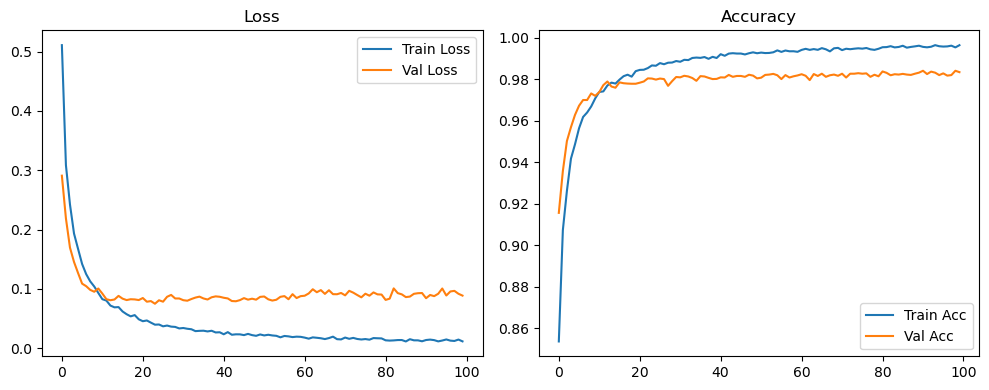

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.8077, Acc: 0.7474 | Val Loss: 0.3425, Acc: 0.8967


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.4832, Acc: 0.8514 | Val Loss: 0.2796, Acc: 0.9191


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.4078, Acc: 0.8782 | Val Loss: 0.2417, Acc: 0.9273


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.3504, Acc: 0.8951 | Val Loss: 0.2041, Acc: 0.9375


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.3133, Acc: 0.9064 | Val Loss: 0.1812, Acc: 0.9466


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.2814, Acc: 0.9159 | Val Loss: 0.1605, Acc: 0.9525


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.2589, Acc: 0.9220 | Val Loss: 0.1508, Acc: 0.9555


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.2392, Acc: 0.9290 | Val Loss: 0.1400, Acc: 0.9581


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.2281, Acc: 0.9313 | Val Loss: 0.1337, Acc: 0.9619


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.2158, Acc: 0.9357 | Val Loss: 0.1219, Acc: 0.9653


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1991, Acc: 0.9395 | Val Loss: 0.1202, Acc: 0.9642


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.1948, Acc: 0.9415 | Val Loss: 0.1119, Acc: 0.9674


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.1844, Acc: 0.9441 | Val Loss: 0.1084, Acc: 0.9689


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.1798, Acc: 0.9468 | Val Loss: 0.1111, Acc: 0.9684


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.1692, Acc: 0.9493 | Val Loss: 0.1032, Acc: 0.9703


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.1669, Acc: 0.9500 | Val Loss: 0.1047, Acc: 0.9693


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.1534, Acc: 0.9534 | Val Loss: 0.0992, Acc: 0.9714


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.1546, Acc: 0.9523 | Val Loss: 0.1022, Acc: 0.9699


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.1510, Acc: 0.9537 | Val Loss: 0.0973, Acc: 0.9730


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.1438, Acc: 0.9550 | Val Loss: 0.0956, Acc: 0.9729


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.1385, Acc: 0.9577 | Val Loss: 0.0933, Acc: 0.9744


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.1393, Acc: 0.9573 | Val Loss: 0.0918, Acc: 0.9742


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.1374, Acc: 0.9584 | Val Loss: 0.0921, Acc: 0.9739


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.1348, Acc: 0.9580 | Val Loss: 0.0859, Acc: 0.9756


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.1287, Acc: 0.9605 | Val Loss: 0.0917, Acc: 0.9734


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.1248, Acc: 0.9607 | Val Loss: 0.0871, Acc: 0.9755


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.1244, Acc: 0.9616 | Val Loss: 0.0885, Acc: 0.9762


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.1166, Acc: 0.9634 | Val Loss: 0.0876, Acc: 0.9750


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.1210, Acc: 0.9622 | Val Loss: 0.0864, Acc: 0.9769


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.1163, Acc: 0.9638 | Val Loss: 0.0862, Acc: 0.9754


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.1152, Acc: 0.9643 | Val Loss: 0.0842, Acc: 0.9765


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.1143, Acc: 0.9635 | Val Loss: 0.0824, Acc: 0.9782


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.1132, Acc: 0.9644 | Val Loss: 0.0819, Acc: 0.9777


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.1058, Acc: 0.9672 | Val Loss: 0.0824, Acc: 0.9778


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.1055, Acc: 0.9668 | Val Loss: 0.0828, Acc: 0.9768


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.1076, Acc: 0.9662 | Val Loss: 0.0844, Acc: 0.9767


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.1002, Acc: 0.9684 | Val Loss: 0.0813, Acc: 0.9777


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.1056, Acc: 0.9676 | Val Loss: 0.0788, Acc: 0.9784


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.1006, Acc: 0.9681 | Val Loss: 0.0818, Acc: 0.9776


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0993, Acc: 0.9696 | Val Loss: 0.0810, Acc: 0.9771


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0965, Acc: 0.9699 | Val Loss: 0.0792, Acc: 0.9772


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0960, Acc: 0.9695 | Val Loss: 0.0785, Acc: 0.9773


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0949, Acc: 0.9701 | Val Loss: 0.0810, Acc: 0.9778


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0947, Acc: 0.9706 | Val Loss: 0.0797, Acc: 0.9784


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0928, Acc: 0.9713 | Val Loss: 0.0793, Acc: 0.9789


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0931, Acc: 0.9716 | Val Loss: 0.0792, Acc: 0.9782


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0927, Acc: 0.9706 | Val Loss: 0.0804, Acc: 0.9795


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0857, Acc: 0.9734 | Val Loss: 0.0809, Acc: 0.9787


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0845, Acc: 0.9730 | Val Loss: 0.0835, Acc: 0.9782


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0871, Acc: 0.9722 | Val Loss: 0.0807, Acc: 0.9786


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0858, Acc: 0.9731 | Val Loss: 0.0793, Acc: 0.9788


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0857, Acc: 0.9730 | Val Loss: 0.0798, Acc: 0.9791


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0882, Acc: 0.9722 | Val Loss: 0.0746, Acc: 0.9801


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0864, Acc: 0.9737 | Val Loss: 0.0762, Acc: 0.9788


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0804, Acc: 0.9744 | Val Loss: 0.0828, Acc: 0.9795


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0811, Acc: 0.9745 | Val Loss: 0.0778, Acc: 0.9795


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0830, Acc: 0.9738 | Val Loss: 0.0772, Acc: 0.9796


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0790, Acc: 0.9749 | Val Loss: 0.0808, Acc: 0.9792


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0779, Acc: 0.9758 | Val Loss: 0.0829, Acc: 0.9792


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0805, Acc: 0.9746 | Val Loss: 0.0791, Acc: 0.9788


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0766, Acc: 0.9752 | Val Loss: 0.0786, Acc: 0.9795


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0759, Acc: 0.9759 | Val Loss: 0.0778, Acc: 0.9798


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0754, Acc: 0.9765 | Val Loss: 0.0830, Acc: 0.9785


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0745, Acc: 0.9775 | Val Loss: 0.0768, Acc: 0.9800


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0747, Acc: 0.9762 | Val Loss: 0.0783, Acc: 0.9800


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0729, Acc: 0.9772 | Val Loss: 0.0787, Acc: 0.9809


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0762, Acc: 0.9751 | Val Loss: 0.0798, Acc: 0.9802


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0741, Acc: 0.9770 | Val Loss: 0.0810, Acc: 0.9793


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0732, Acc: 0.9764 | Val Loss: 0.0799, Acc: 0.9794


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0684, Acc: 0.9782 | Val Loss: 0.0765, Acc: 0.9801


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0692, Acc: 0.9773 | Val Loss: 0.0805, Acc: 0.9795


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0731, Acc: 0.9771 | Val Loss: 0.0768, Acc: 0.9799


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0699, Acc: 0.9783 | Val Loss: 0.0754, Acc: 0.9801


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0744, Acc: 0.9765 | Val Loss: 0.0758, Acc: 0.9798


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0699, Acc: 0.9772 | Val Loss: 0.0751, Acc: 0.9799


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0666, Acc: 0.9783 | Val Loss: 0.0763, Acc: 0.9802


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0647, Acc: 0.9795 | Val Loss: 0.0795, Acc: 0.9800


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0671, Acc: 0.9782 | Val Loss: 0.0804, Acc: 0.9796


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0656, Acc: 0.9788 | Val Loss: 0.0787, Acc: 0.9798


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0685, Acc: 0.9781 | Val Loss: 0.0787, Acc: 0.9808


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0661, Acc: 0.9780 | Val Loss: 0.0800, Acc: 0.9800


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0644, Acc: 0.9796 | Val Loss: 0.0754, Acc: 0.9809


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0652, Acc: 0.9788 | Val Loss: 0.0788, Acc: 0.9793


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0665, Acc: 0.9786 | Val Loss: 0.0775, Acc: 0.9802


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0647, Acc: 0.9797 | Val Loss: 0.0782, Acc: 0.9803


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0654, Acc: 0.9783 | Val Loss: 0.0777, Acc: 0.9803


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0649, Acc: 0.9797 | Val Loss: 0.0748, Acc: 0.9815


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0601, Acc: 0.9807 | Val Loss: 0.0776, Acc: 0.9803


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0626, Acc: 0.9794 | Val Loss: 0.0818, Acc: 0.9803


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0581, Acc: 0.9821 | Val Loss: 0.0773, Acc: 0.9799


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0612, Acc: 0.9801 | Val Loss: 0.0805, Acc: 0.9792


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0595, Acc: 0.9810 | Val Loss: 0.0789, Acc: 0.9802


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0620, Acc: 0.9805 | Val Loss: 0.0762, Acc: 0.9798


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0583, Acc: 0.9806 | Val Loss: 0.0753, Acc: 0.9809


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0628, Acc: 0.9797 | Val Loss: 0.0775, Acc: 0.9802


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0597, Acc: 0.9810 | Val Loss: 0.0768, Acc: 0.9801


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0612, Acc: 0.9806 | Val Loss: 0.0778, Acc: 0.9800


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0600, Acc: 0.9817 | Val Loss: 0.0757, Acc: 0.9809


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0613, Acc: 0.9812 | Val Loss: 0.0800, Acc: 0.9801


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0611, Acc: 0.9809 | Val Loss: 0.0771, Acc: 0.9818


Final Test Loss: 0.0680 Accuracy: 0.9828


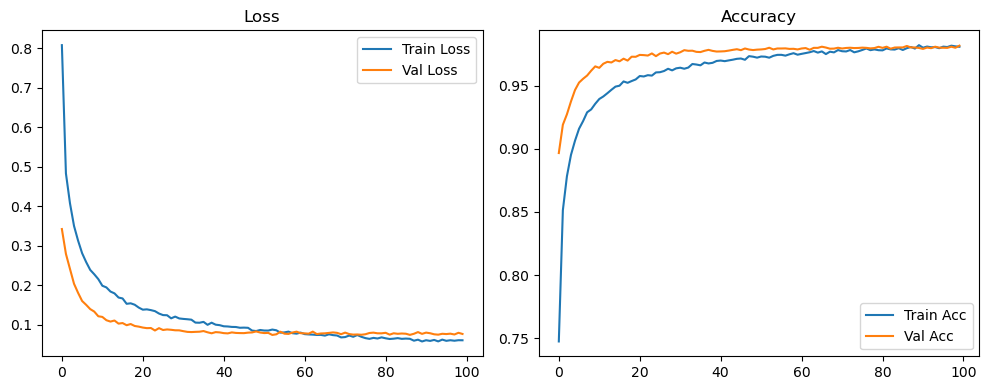

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.4368, Acc: 0.8916 | Val Loss: 0.2671, Acc: 0.9220


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2170, Acc: 0.9360 | Val Loss: 0.1948, Acc: 0.9411


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1617, Acc: 0.9505 | Val Loss: 0.1620, Acc: 0.9527


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1227, Acc: 0.9618 | Val Loss: 0.1361, Acc: 0.9557


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0990, Acc: 0.9703 | Val Loss: 0.1170, Acc: 0.9647


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0825, Acc: 0.9744 | Val Loss: 0.0993, Acc: 0.9692


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0704, Acc: 0.9775 | Val Loss: 0.1120, Acc: 0.9666


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0616, Acc: 0.9800 | Val Loss: 0.0992, Acc: 0.9700


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0525, Acc: 0.9829 | Val Loss: 0.0966, Acc: 0.9703


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0484, Acc: 0.9835 | Val Loss: 0.1052, Acc: 0.9697


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0395, Acc: 0.9874 | Val Loss: 0.0925, Acc: 0.9729


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0365, Acc: 0.9884 | Val Loss: 0.0909, Acc: 0.9734


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0331, Acc: 0.9886 | Val Loss: 0.0929, Acc: 0.9738


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0333, Acc: 0.9882 | Val Loss: 0.0893, Acc: 0.9742


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0297, Acc: 0.9894 | Val Loss: 0.1105, Acc: 0.9718


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0281, Acc: 0.9902 | Val Loss: 0.0967, Acc: 0.9733


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9921 | Val Loss: 0.0880, Acc: 0.9757


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.0953, Acc: 0.9737


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9910 | Val Loss: 0.0985, Acc: 0.9752


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.0856, Acc: 0.9779


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9940 | Val Loss: 0.0946, Acc: 0.9764


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9929 | Val Loss: 0.1038, Acc: 0.9751


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9939 | Val Loss: 0.0913, Acc: 0.9782


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9949 | Val Loss: 0.0864, Acc: 0.9786


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9955 | Val Loss: 0.1073, Acc: 0.9746


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0156, Acc: 0.9945 | Val Loss: 0.0872, Acc: 0.9782


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9953 | Val Loss: 0.0931, Acc: 0.9773


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9952 | Val Loss: 0.1193, Acc: 0.9724


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9951 | Val Loss: 0.0993, Acc: 0.9762


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.0971, Acc: 0.9770


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.0946, Acc: 0.9780


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9965 | Val Loss: 0.0914, Acc: 0.9793


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.0926, Acc: 0.9773


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0925, Acc: 0.9784


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.1143, Acc: 0.9745


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0980, Acc: 0.9784


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0884, Acc: 0.9805


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0926, Acc: 0.9778


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9971 | Val Loss: 0.0938, Acc: 0.9797


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1081, Acc: 0.9767


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1036, Acc: 0.9766


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.0982, Acc: 0.9782


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.1035, Acc: 0.9783


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9970 | Val Loss: 0.0894, Acc: 0.9801


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9977 | Val Loss: 0.0973, Acc: 0.9787


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.1049, Acc: 0.9785


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0985, Acc: 0.9784


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.0971, Acc: 0.9802


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1002, Acc: 0.9788


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1060, Acc: 0.9780


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9975 | Val Loss: 0.0941, Acc: 0.9818


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0993, Acc: 0.9800


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0988, Acc: 0.9796


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1006, Acc: 0.9809


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1087, Acc: 0.9788


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1080, Acc: 0.9784


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.1090, Acc: 0.9800


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1015, Acc: 0.9800


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1042, Acc: 0.9793


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0973, Acc: 0.9803


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.1026, Acc: 0.9818


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0966, Acc: 0.9816


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1081, Acc: 0.9781


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0967, Acc: 0.9817


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1001, Acc: 0.9796


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1024, Acc: 0.9807


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1172, Acc: 0.9788


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1010, Acc: 0.9818


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.1077, Acc: 0.9799


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.1041, Acc: 0.9813


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.1135, Acc: 0.9780


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0971, Acc: 0.9816


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1079, Acc: 0.9806


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1035, Acc: 0.9808


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1061, Acc: 0.9804


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1097, Acc: 0.9795


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0972, Acc: 0.9821


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1167, Acc: 0.9789


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0959, Acc: 0.9818


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0996, Acc: 0.9821


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1042, Acc: 0.9818


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9981 | Val Loss: 0.1001, Acc: 0.9815


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1026, Acc: 0.9811


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0991, Acc: 0.9808


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9988 | Val Loss: 0.1070, Acc: 0.9803


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1155, Acc: 0.9788


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1047, Acc: 0.9805


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1038, Acc: 0.9810


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1295, Acc: 0.9782


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1095, Acc: 0.9813


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1204, Acc: 0.9778


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1202, Acc: 0.9797


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1156, Acc: 0.9811


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1133, Acc: 0.9804


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1096, Acc: 0.9805


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1078, Acc: 0.9818


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1205, Acc: 0.9795


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1263, Acc: 0.9789


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1275, Acc: 0.9790


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1105, Acc: 0.9812


Final Test Loss: 0.1131 Accuracy: 0.9798


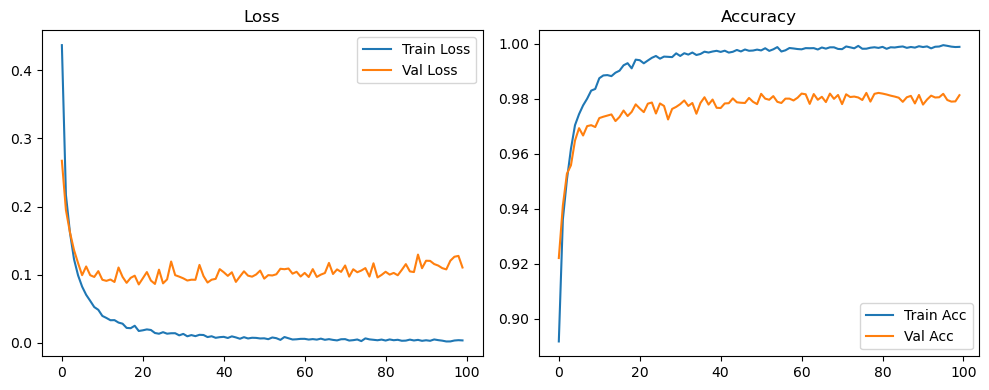

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.5880, Acc: 0.8474 | Val Loss: 0.3140, Acc: 0.9097


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.3422, Acc: 0.8973 | Val Loss: 0.2489, Acc: 0.9273


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2836, Acc: 0.9131 | Val Loss: 0.2113, Acc: 0.9380


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.2348, Acc: 0.9293 | Val Loss: 0.1760, Acc: 0.9469


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.2058, Acc: 0.9373 | Val Loss: 0.1518, Acc: 0.9557


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1776, Acc: 0.9460 | Val Loss: 0.1364, Acc: 0.9589


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1580, Acc: 0.9508 | Val Loss: 0.1286, Acc: 0.9620


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1399, Acc: 0.9568 | Val Loss: 0.1145, Acc: 0.9667


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1312, Acc: 0.9594 | Val Loss: 0.1051, Acc: 0.9693


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1174, Acc: 0.9634 | Val Loss: 0.1106, Acc: 0.9675


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1056, Acc: 0.9666 | Val Loss: 0.1015, Acc: 0.9688


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0996, Acc: 0.9682 | Val Loss: 0.0925, Acc: 0.9724


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0912, Acc: 0.9707 | Val Loss: 0.0907, Acc: 0.9752


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0842, Acc: 0.9733 | Val Loss: 0.0912, Acc: 0.9734


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0845, Acc: 0.9721 | Val Loss: 0.0905, Acc: 0.9740


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0777, Acc: 0.9748 | Val Loss: 0.0871, Acc: 0.9739


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0739, Acc: 0.9761 | Val Loss: 0.0841, Acc: 0.9769


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0682, Acc: 0.9776 | Val Loss: 0.0873, Acc: 0.9763


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0679, Acc: 0.9776 | Val Loss: 0.0826, Acc: 0.9758


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0600, Acc: 0.9796 | Val Loss: 0.0873, Acc: 0.9742


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0593, Acc: 0.9805 | Val Loss: 0.0836, Acc: 0.9771


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0549, Acc: 0.9816 | Val Loss: 0.0818, Acc: 0.9768


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0530, Acc: 0.9820 | Val Loss: 0.0849, Acc: 0.9773


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0488, Acc: 0.9839 | Val Loss: 0.0792, Acc: 0.9791


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0490, Acc: 0.9833 | Val Loss: 0.0830, Acc: 0.9778


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0461, Acc: 0.9847 | Val Loss: 0.0805, Acc: 0.9785


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0470, Acc: 0.9841 | Val Loss: 0.0825, Acc: 0.9792


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0429, Acc: 0.9855 | Val Loss: 0.0884, Acc: 0.9787


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0427, Acc: 0.9854 | Val Loss: 0.0857, Acc: 0.9778


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0419, Acc: 0.9853 | Val Loss: 0.0780, Acc: 0.9800


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0386, Acc: 0.9869 | Val Loss: 0.0793, Acc: 0.9800


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0364, Acc: 0.9876 | Val Loss: 0.0880, Acc: 0.9781


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0364, Acc: 0.9878 | Val Loss: 0.0829, Acc: 0.9791


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0357, Acc: 0.9882 | Val Loss: 0.0822, Acc: 0.9792


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0347, Acc: 0.9879 | Val Loss: 0.0786, Acc: 0.9799


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0322, Acc: 0.9889 | Val Loss: 0.0801, Acc: 0.9810


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9887 | Val Loss: 0.0863, Acc: 0.9793


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9900 | Val Loss: 0.0817, Acc: 0.9793


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0308, Acc: 0.9898 | Val Loss: 0.0823, Acc: 0.9802


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9890 | Val Loss: 0.0840, Acc: 0.9797


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0281, Acc: 0.9905 | Val Loss: 0.0848, Acc: 0.9783


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0287, Acc: 0.9906 | Val Loss: 0.0832, Acc: 0.9798


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9911 | Val Loss: 0.0831, Acc: 0.9806


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0270, Acc: 0.9908 | Val Loss: 0.0815, Acc: 0.9802


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0267, Acc: 0.9909 | Val Loss: 0.0848, Acc: 0.9805


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9907 | Val Loss: 0.0828, Acc: 0.9798


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.0911, Acc: 0.9793


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0240, Acc: 0.9918 | Val Loss: 0.0906, Acc: 0.9798


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9913 | Val Loss: 0.0928, Acc: 0.9798


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9914 | Val Loss: 0.0858, Acc: 0.9808


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9918 | Val Loss: 0.0906, Acc: 0.9804


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9926 | Val Loss: 0.0846, Acc: 0.9813


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9926 | Val Loss: 0.0856, Acc: 0.9816


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9922 | Val Loss: 0.0900, Acc: 0.9812


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9932 | Val Loss: 0.0894, Acc: 0.9797


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9922 | Val Loss: 0.0885, Acc: 0.9792


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9924 | Val Loss: 0.0857, Acc: 0.9817


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9926 | Val Loss: 0.0871, Acc: 0.9812


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9933 | Val Loss: 0.0881, Acc: 0.9799


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9930 | Val Loss: 0.0880, Acc: 0.9811


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9933 | Val Loss: 0.0944, Acc: 0.9805


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9935 | Val Loss: 0.0919, Acc: 0.9813


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9939 | Val Loss: 0.0990, Acc: 0.9790


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9935 | Val Loss: 0.0951, Acc: 0.9802


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9940 | Val Loss: 0.0941, Acc: 0.9798


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9939 | Val Loss: 0.0889, Acc: 0.9808


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9940 | Val Loss: 0.0991, Acc: 0.9810


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9930 | Val Loss: 0.0984, Acc: 0.9802


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.0883, Acc: 0.9813


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9947 | Val Loss: 0.0898, Acc: 0.9807


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9931 | Val Loss: 0.0918, Acc: 0.9803


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0903, Acc: 0.9815


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9938 | Val Loss: 0.0900, Acc: 0.9819


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9943 | Val Loss: 0.0868, Acc: 0.9816


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9950 | Val Loss: 0.0843, Acc: 0.9811


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9946 | Val Loss: 0.0908, Acc: 0.9806


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.0917, Acc: 0.9812


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.1016, Acc: 0.9795


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.0878, Acc: 0.9814


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.0963, Acc: 0.9812


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9956 | Val Loss: 0.0918, Acc: 0.9813


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9940 | Val Loss: 0.0968, Acc: 0.9807


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9946 | Val Loss: 0.0927, Acc: 0.9813


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9950 | Val Loss: 0.0988, Acc: 0.9808


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.0964, Acc: 0.9811


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9949 | Val Loss: 0.0950, Acc: 0.9811


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.0956, Acc: 0.9813


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.0988, Acc: 0.9818


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9952 | Val Loss: 0.0989, Acc: 0.9803


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.0983, Acc: 0.9812


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0991, Acc: 0.9808


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9949 | Val Loss: 0.0938, Acc: 0.9813


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9957 | Val Loss: 0.0931, Acc: 0.9822


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9949 | Val Loss: 0.0971, Acc: 0.9820


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9957 | Val Loss: 0.0947, Acc: 0.9818


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9952 | Val Loss: 0.0917, Acc: 0.9818


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9957 | Val Loss: 0.0921, Acc: 0.9828


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.0989, Acc: 0.9804


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9953 | Val Loss: 0.0964, Acc: 0.9817


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.0944, Acc: 0.9820


Final Test Loss: 0.0752 Accuracy: 0.9838


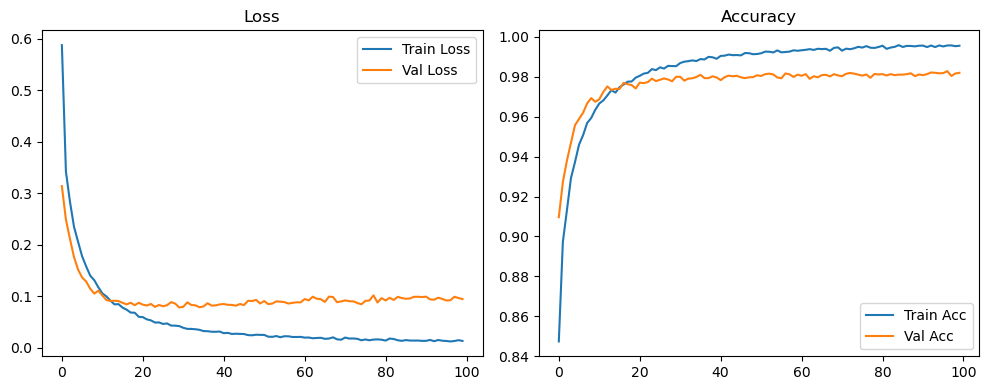

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.9626, Acc: 0.7043 | Val Loss: 0.3727, Acc: 0.8953


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.5469, Acc: 0.8338 | Val Loss: 0.3088, Acc: 0.9086


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.4677, Acc: 0.8570 | Val Loss: 0.2823, Acc: 0.9155


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.4112, Acc: 0.8768 | Val Loss: 0.2468, Acc: 0.9255


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.3746, Acc: 0.8879 | Val Loss: 0.2249, Acc: 0.9347


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.3391, Acc: 0.8965 | Val Loss: 0.1983, Acc: 0.9423


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.3139, Acc: 0.9054 | Val Loss: 0.1839, Acc: 0.9465


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.2895, Acc: 0.9127 | Val Loss: 0.1736, Acc: 0.9487


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.2786, Acc: 0.9173 | Val Loss: 0.1595, Acc: 0.9529


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.2580, Acc: 0.9228 | Val Loss: 0.1526, Acc: 0.9559


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.2420, Acc: 0.9278 | Val Loss: 0.1482, Acc: 0.9557


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.2339, Acc: 0.9299 | Val Loss: 0.1393, Acc: 0.9594


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.2174, Acc: 0.9343 | Val Loss: 0.1320, Acc: 0.9617


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.2127, Acc: 0.9359 | Val Loss: 0.1310, Acc: 0.9615


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.2012, Acc: 0.9391 | Val Loss: 0.1240, Acc: 0.9624


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.1960, Acc: 0.9401 | Val Loss: 0.1205, Acc: 0.9651


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.1881, Acc: 0.9425 | Val Loss: 0.1183, Acc: 0.9645


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.1807, Acc: 0.9453 | Val Loss: 0.1192, Acc: 0.9657


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.1821, Acc: 0.9452 | Val Loss: 0.1154, Acc: 0.9658


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.1715, Acc: 0.9472 | Val Loss: 0.1109, Acc: 0.9678


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.1633, Acc: 0.9490 | Val Loss: 0.1082, Acc: 0.9686


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.1625, Acc: 0.9505 | Val Loss: 0.1069, Acc: 0.9696


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.1593, Acc: 0.9517 | Val Loss: 0.1065, Acc: 0.9706


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.1556, Acc: 0.9531 | Val Loss: 0.0993, Acc: 0.9720


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.1483, Acc: 0.9540 | Val Loss: 0.1082, Acc: 0.9697


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.1433, Acc: 0.9560 | Val Loss: 0.0995, Acc: 0.9728


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.1453, Acc: 0.9553 | Val Loss: 0.1003, Acc: 0.9725


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.1370, Acc: 0.9581 | Val Loss: 0.1011, Acc: 0.9722


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.1413, Acc: 0.9556 | Val Loss: 0.0980, Acc: 0.9731


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.1341, Acc: 0.9592 | Val Loss: 0.1031, Acc: 0.9703


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.1357, Acc: 0.9583 | Val Loss: 0.0964, Acc: 0.9732


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.1308, Acc: 0.9601 | Val Loss: 0.0946, Acc: 0.9742


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.1287, Acc: 0.9601 | Val Loss: 0.0905, Acc: 0.9740


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.1237, Acc: 0.9613 | Val Loss: 0.0923, Acc: 0.9738


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.1214, Acc: 0.9630 | Val Loss: 0.0962, Acc: 0.9737


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.1228, Acc: 0.9618 | Val Loss: 0.0904, Acc: 0.9739


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.1157, Acc: 0.9644 | Val Loss: 0.0901, Acc: 0.9746


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.1203, Acc: 0.9622 | Val Loss: 0.0903, Acc: 0.9743


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.1155, Acc: 0.9634 | Val Loss: 0.0922, Acc: 0.9743


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.1129, Acc: 0.9653 | Val Loss: 0.0913, Acc: 0.9745


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.1114, Acc: 0.9651 | Val Loss: 0.0882, Acc: 0.9755


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.1102, Acc: 0.9655 | Val Loss: 0.0879, Acc: 0.9758


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.1106, Acc: 0.9642 | Val Loss: 0.0862, Acc: 0.9760


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.1082, Acc: 0.9659 | Val Loss: 0.0857, Acc: 0.9760


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.1090, Acc: 0.9664 | Val Loss: 0.0868, Acc: 0.9767


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.1071, Acc: 0.9674 | Val Loss: 0.0843, Acc: 0.9764


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.1045, Acc: 0.9668 | Val Loss: 0.0874, Acc: 0.9772


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.1001, Acc: 0.9681 | Val Loss: 0.0860, Acc: 0.9768


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.1032, Acc: 0.9673 | Val Loss: 0.0900, Acc: 0.9762


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0987, Acc: 0.9682 | Val Loss: 0.0840, Acc: 0.9773


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.1001, Acc: 0.9691 | Val Loss: 0.0824, Acc: 0.9777


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0952, Acc: 0.9698 | Val Loss: 0.0862, Acc: 0.9768


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0997, Acc: 0.9694 | Val Loss: 0.0818, Acc: 0.9769


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0978, Acc: 0.9695 | Val Loss: 0.0854, Acc: 0.9775


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0921, Acc: 0.9699 | Val Loss: 0.0875, Acc: 0.9767


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0929, Acc: 0.9707 | Val Loss: 0.0842, Acc: 0.9773


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0922, Acc: 0.9716 | Val Loss: 0.0837, Acc: 0.9774


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0940, Acc: 0.9708 | Val Loss: 0.0866, Acc: 0.9769


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0898, Acc: 0.9716 | Val Loss: 0.0855, Acc: 0.9777


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0925, Acc: 0.9708 | Val Loss: 0.0815, Acc: 0.9790


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0866, Acc: 0.9723 | Val Loss: 0.0835, Acc: 0.9781


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0892, Acc: 0.9724 | Val Loss: 0.0842, Acc: 0.9784


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0858, Acc: 0.9728 | Val Loss: 0.0899, Acc: 0.9768


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0842, Acc: 0.9741 | Val Loss: 0.0858, Acc: 0.9777


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0847, Acc: 0.9727 | Val Loss: 0.0825, Acc: 0.9775


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0819, Acc: 0.9744 | Val Loss: 0.0807, Acc: 0.9783


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0893, Acc: 0.9717 | Val Loss: 0.0829, Acc: 0.9780


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0839, Acc: 0.9738 | Val Loss: 0.0839, Acc: 0.9787


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0837, Acc: 0.9734 | Val Loss: 0.0820, Acc: 0.9788


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0786, Acc: 0.9741 | Val Loss: 0.0812, Acc: 0.9796


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0834, Acc: 0.9728 | Val Loss: 0.0813, Acc: 0.9788


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0823, Acc: 0.9740 | Val Loss: 0.0824, Acc: 0.9782


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0792, Acc: 0.9742 | Val Loss: 0.0799, Acc: 0.9789


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0826, Acc: 0.9734 | Val Loss: 0.0820, Acc: 0.9781


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0784, Acc: 0.9746 | Val Loss: 0.0833, Acc: 0.9780


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0764, Acc: 0.9762 | Val Loss: 0.0842, Acc: 0.9790


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0757, Acc: 0.9754 | Val Loss: 0.0837, Acc: 0.9783


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0744, Acc: 0.9769 | Val Loss: 0.0829, Acc: 0.9791


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0780, Acc: 0.9752 | Val Loss: 0.0823, Acc: 0.9788


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0755, Acc: 0.9756 | Val Loss: 0.0851, Acc: 0.9787


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0720, Acc: 0.9769 | Val Loss: 0.0841, Acc: 0.9782


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0734, Acc: 0.9759 | Val Loss: 0.0810, Acc: 0.9790


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0746, Acc: 0.9763 | Val Loss: 0.0845, Acc: 0.9788


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0739, Acc: 0.9759 | Val Loss: 0.0818, Acc: 0.9792


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0738, Acc: 0.9766 | Val Loss: 0.0845, Acc: 0.9795


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0751, Acc: 0.9754 | Val Loss: 0.0802, Acc: 0.9795


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0738, Acc: 0.9761 | Val Loss: 0.0810, Acc: 0.9791


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0700, Acc: 0.9772 | Val Loss: 0.0798, Acc: 0.9793


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0709, Acc: 0.9773 | Val Loss: 0.0846, Acc: 0.9791


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0671, Acc: 0.9786 | Val Loss: 0.0821, Acc: 0.9796


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0686, Acc: 0.9773 | Val Loss: 0.0813, Acc: 0.9798


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0682, Acc: 0.9778 | Val Loss: 0.0810, Acc: 0.9802


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0714, Acc: 0.9776 | Val Loss: 0.0788, Acc: 0.9801


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0642, Acc: 0.9787 | Val Loss: 0.0820, Acc: 0.9797


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0692, Acc: 0.9777 | Val Loss: 0.0802, Acc: 0.9810


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0692, Acc: 0.9777 | Val Loss: 0.0790, Acc: 0.9795


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0669, Acc: 0.9780 | Val Loss: 0.0835, Acc: 0.9799


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0688, Acc: 0.9783 | Val Loss: 0.0828, Acc: 0.9798


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0667, Acc: 0.9796 | Val Loss: 0.0862, Acc: 0.9791


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0675, Acc: 0.9777 | Val Loss: 0.0847, Acc: 0.9792


Final Test Loss: 0.0727 Accuracy: 0.9815


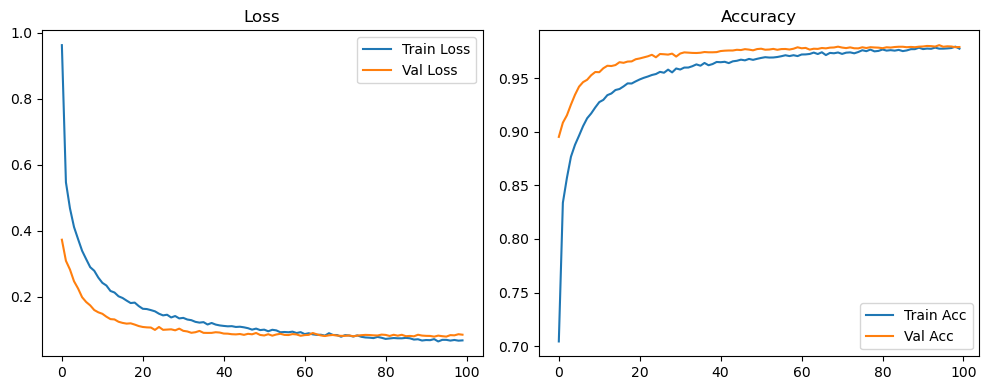

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3551, Acc: 0.8937 | Val Loss: 0.2255, Acc: 0.9330


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1700, Acc: 0.9481 | Val Loss: 0.1610, Acc: 0.9513


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1189, Acc: 0.9633 | Val Loss: 0.1274, Acc: 0.9620


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0838, Acc: 0.9740 | Val Loss: 0.1062, Acc: 0.9680


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0685, Acc: 0.9786 | Val Loss: 0.1361, Acc: 0.9613


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9818 | Val Loss: 0.0957, Acc: 0.9741


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9839 | Val Loss: 0.1437, Acc: 0.9614


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9861 | Val Loss: 0.1014, Acc: 0.9715


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9880 | Val Loss: 0.0922, Acc: 0.9766


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9881 | Val Loss: 0.1132, Acc: 0.9725


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9904 | Val Loss: 0.1144, Acc: 0.9719


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.1122, Acc: 0.9753


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9918 | Val Loss: 0.1373, Acc: 0.9700


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9914 | Val Loss: 0.1128, Acc: 0.9755


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9927 | Val Loss: 0.1258, Acc: 0.9742


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9928 | Val Loss: 0.1245, Acc: 0.9734


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.1232, Acc: 0.9758


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.1178, Acc: 0.9775


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9929 | Val Loss: 0.1198, Acc: 0.9764


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9946 | Val Loss: 0.1219, Acc: 0.9742


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9950 | Val Loss: 0.1139, Acc: 0.9769


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.1390, Acc: 0.9756


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9948 | Val Loss: 0.1229, Acc: 0.9778


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9964 | Val Loss: 0.1190, Acc: 0.9782


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1301, Acc: 0.9771


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.1204, Acc: 0.9781


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9941 | Val Loss: 0.1349, Acc: 0.9744


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1447, Acc: 0.9759


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1163, Acc: 0.9797


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.1633, Acc: 0.9742


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.1105, Acc: 0.9801


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.1191, Acc: 0.9797


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1276, Acc: 0.9779


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.1192, Acc: 0.9789


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1167, Acc: 0.9788


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1176, Acc: 0.9794


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1234, Acc: 0.9798


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1183, Acc: 0.9790


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1291, Acc: 0.9795


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9967 | Val Loss: 0.1377, Acc: 0.9750


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1320, Acc: 0.9768


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1263, Acc: 0.9792


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.1330, Acc: 0.9782


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1237, Acc: 0.9782


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1308, Acc: 0.9796


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1196, Acc: 0.9804


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1349, Acc: 0.9797


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1312, Acc: 0.9798


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1164, Acc: 0.9822


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1325, Acc: 0.9794


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1384, Acc: 0.9783


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1625, Acc: 0.9748


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1154, Acc: 0.9809


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1210, Acc: 0.9806


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1446, Acc: 0.9758


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.1115, Acc: 0.9817


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1221, Acc: 0.9800


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1239, Acc: 0.9795


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.1243, Acc: 0.9802


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1171, Acc: 0.9810


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1319, Acc: 0.9798


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1255, Acc: 0.9814


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1395, Acc: 0.9759


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1363, Acc: 0.9789


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1298, Acc: 0.9813


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1463, Acc: 0.9771


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1304, Acc: 0.9780


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1314, Acc: 0.9792


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1322, Acc: 0.9812


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1387, Acc: 0.9798


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1280, Acc: 0.9818


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1235, Acc: 0.9811


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1351, Acc: 0.9793


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1426, Acc: 0.9791


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1242, Acc: 0.9813


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1235, Acc: 0.9804


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1293, Acc: 0.9804


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1311, Acc: 0.9791


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1247, Acc: 0.9811


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1237, Acc: 0.9814


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1367, Acc: 0.9784


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1437, Acc: 0.9786


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9983 | Val Loss: 0.1406, Acc: 0.9802


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1265, Acc: 0.9812


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1343, Acc: 0.9803


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1343, Acc: 0.9810


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1411, Acc: 0.9798


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1248, Acc: 0.9820


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1310, Acc: 0.9809


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1234, Acc: 0.9813


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1154, Acc: 0.9803


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1177, Acc: 0.9812


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1213, Acc: 0.9818


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1314, Acc: 0.9812


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1208, Acc: 0.9824


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1380, Acc: 0.9798


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1457, Acc: 0.9778


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1316, Acc: 0.9803


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1226, Acc: 0.9812


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1267, Acc: 0.9803


Final Test Loss: 0.1233 Accuracy: 0.9811


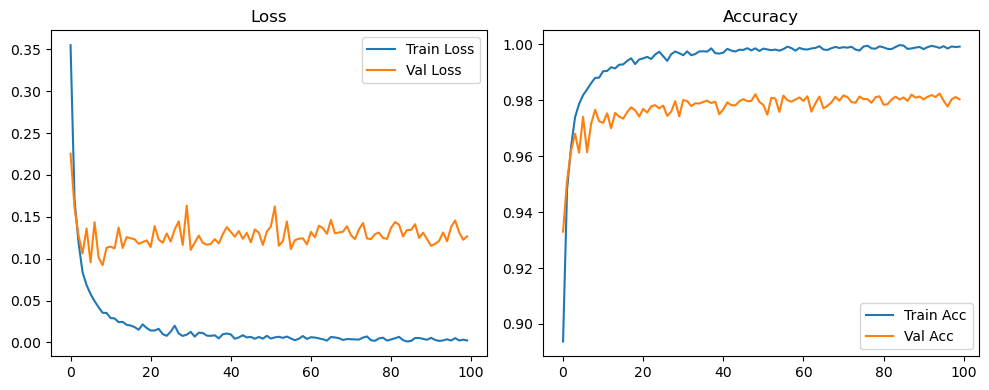

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4500, Acc: 0.8645 | Val Loss: 0.2374, Acc: 0.9291


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2381, Acc: 0.9286 | Val Loss: 0.1780, Acc: 0.9489


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1774, Acc: 0.9463 | Val Loss: 0.1376, Acc: 0.9596


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1396, Acc: 0.9578 | Val Loss: 0.1136, Acc: 0.9657


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1114, Acc: 0.9658 | Val Loss: 0.1103, Acc: 0.9668


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0978, Acc: 0.9692 | Val Loss: 0.0946, Acc: 0.9732


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0879, Acc: 0.9724 | Val Loss: 0.0983, Acc: 0.9728


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9750 | Val Loss: 0.0907, Acc: 0.9739


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0692, Acc: 0.9768 | Val Loss: 0.0919, Acc: 0.9763


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0671, Acc: 0.9786 | Val Loss: 0.0928, Acc: 0.9755


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0606, Acc: 0.9809 | Val Loss: 0.0868, Acc: 0.9760


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9808 | Val Loss: 0.0900, Acc: 0.9773


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9828 | Val Loss: 0.0969, Acc: 0.9759


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0494, Acc: 0.9836 | Val Loss: 0.0895, Acc: 0.9771


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9855 | Val Loss: 0.0890, Acc: 0.9777


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9861 | Val Loss: 0.0875, Acc: 0.9777


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9869 | Val Loss: 0.0903, Acc: 0.9782


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9856 | Val Loss: 0.0878, Acc: 0.9776


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9875 | Val Loss: 0.0822, Acc: 0.9802


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9890 | Val Loss: 0.0911, Acc: 0.9787


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9880 | Val Loss: 0.0868, Acc: 0.9782


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9886 | Val Loss: 0.0854, Acc: 0.9806


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9902 | Val Loss: 0.0892, Acc: 0.9807


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9894 | Val Loss: 0.0816, Acc: 0.9808


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9903 | Val Loss: 0.1044, Acc: 0.9752


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9905 | Val Loss: 0.0891, Acc: 0.9799


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9909 | Val Loss: 0.0918, Acc: 0.9802


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9919 | Val Loss: 0.0943, Acc: 0.9797


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9918 | Val Loss: 0.0881, Acc: 0.9810


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9910 | Val Loss: 0.0890, Acc: 0.9795


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9916 | Val Loss: 0.0851, Acc: 0.9807


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9927 | Val Loss: 0.0888, Acc: 0.9800


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9919 | Val Loss: 0.0877, Acc: 0.9810


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9932 | Val Loss: 0.0855, Acc: 0.9796


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9925 | Val Loss: 0.0889, Acc: 0.9805


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9923 | Val Loss: 0.0881, Acc: 0.9794


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9938 | Val Loss: 0.0853, Acc: 0.9808


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9939 | Val Loss: 0.0934, Acc: 0.9797


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9926 | Val Loss: 0.0937, Acc: 0.9797


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9924 | Val Loss: 0.0899, Acc: 0.9805


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9941 | Val Loss: 0.0890, Acc: 0.9814


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9937 | Val Loss: 0.0962, Acc: 0.9804


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9939 | Val Loss: 0.0986, Acc: 0.9813


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9944 | Val Loss: 0.0904, Acc: 0.9818


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9939 | Val Loss: 0.0871, Acc: 0.9814


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9939 | Val Loss: 0.0973, Acc: 0.9809


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.0903, Acc: 0.9807


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.0948, Acc: 0.9813


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9951 | Val Loss: 0.1010, Acc: 0.9812


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9942 | Val Loss: 0.0948, Acc: 0.9812


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9952 | Val Loss: 0.0982, Acc: 0.9807


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9953 | Val Loss: 0.1014, Acc: 0.9812


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9956 | Val Loss: 0.0938, Acc: 0.9820


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9952 | Val Loss: 0.0968, Acc: 0.9800


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9955 | Val Loss: 0.0935, Acc: 0.9817


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.1000, Acc: 0.9812


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.0967, Acc: 0.9820


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9957 | Val Loss: 0.0913, Acc: 0.9808


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9957 | Val Loss: 0.1026, Acc: 0.9816


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.0929, Acc: 0.9819


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9953 | Val Loss: 0.0978, Acc: 0.9828


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.0973, Acc: 0.9816


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9957 | Val Loss: 0.0956, Acc: 0.9808


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.0960, Acc: 0.9813


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.1022, Acc: 0.9803


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.0980, Acc: 0.9815


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.0900, Acc: 0.9813


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.0917, Acc: 0.9818


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.0914, Acc: 0.9821


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.0924, Acc: 0.9812


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.1000, Acc: 0.9808


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9961 | Val Loss: 0.0944, Acc: 0.9828


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9967 | Val Loss: 0.1016, Acc: 0.9814


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9965 | Val Loss: 0.1141, Acc: 0.9808


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9957 | Val Loss: 0.0929, Acc: 0.9819


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0904, Acc: 0.9823


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.0941, Acc: 0.9828


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0948, Acc: 0.9823


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9965 | Val Loss: 0.0968, Acc: 0.9815


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.1096, Acc: 0.9808


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.0976, Acc: 0.9816


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0986, Acc: 0.9820


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.0995, Acc: 0.9813


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0944, Acc: 0.9825


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.0985, Acc: 0.9821


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1030, Acc: 0.9819


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1042, Acc: 0.9808


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9966 | Val Loss: 0.0932, Acc: 0.9823


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1076, Acc: 0.9823


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.0961, Acc: 0.9837


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.0973, Acc: 0.9819


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0946, Acc: 0.9838


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1038, Acc: 0.9825


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0979, Acc: 0.9820


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1106, Acc: 0.9804


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.1093, Acc: 0.9804


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1080, Acc: 0.9817


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1091, Acc: 0.9811


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.1004, Acc: 0.9820


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9965 | Val Loss: 0.0947, Acc: 0.9826


Final Test Loss: 0.0822 Accuracy: 0.9841


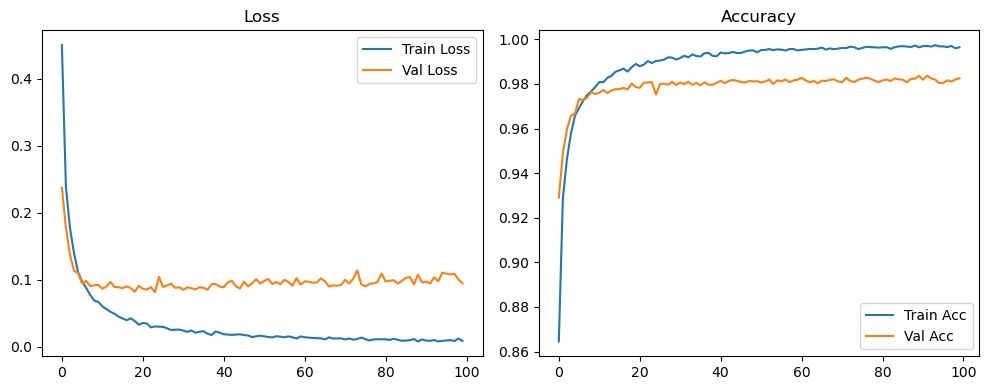

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6711, Acc: 0.7870 | Val Loss: 0.2904, Acc: 0.9153


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3817, Acc: 0.8857 | Val Loss: 0.2098, Acc: 0.9382


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2984, Acc: 0.9124 | Val Loss: 0.1699, Acc: 0.9487


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2544, Acc: 0.9245 | Val Loss: 0.1402, Acc: 0.9580


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2183, Acc: 0.9358 | Val Loss: 0.1321, Acc: 0.9606


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2029, Acc: 0.9387 | Val Loss: 0.1122, Acc: 0.9672


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1887, Acc: 0.9436 | Val Loss: 0.1117, Acc: 0.9663


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1771, Acc: 0.9481 | Val Loss: 0.1037, Acc: 0.9688


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1619, Acc: 0.9517 | Val Loss: 0.1023, Acc: 0.9708


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1547, Acc: 0.9534 | Val Loss: 0.0962, Acc: 0.9733


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1470, Acc: 0.9553 | Val Loss: 0.0981, Acc: 0.9711


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1409, Acc: 0.9572 | Val Loss: 0.0940, Acc: 0.9726


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1341, Acc: 0.9586 | Val Loss: 0.0916, Acc: 0.9744


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1336, Acc: 0.9590 | Val Loss: 0.0919, Acc: 0.9739


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1212, Acc: 0.9626 | Val Loss: 0.0849, Acc: 0.9755


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1262, Acc: 0.9610 | Val Loss: 0.0880, Acc: 0.9745


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1180, Acc: 0.9645 | Val Loss: 0.0839, Acc: 0.9756


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1137, Acc: 0.9652 | Val Loss: 0.0846, Acc: 0.9753


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1173, Acc: 0.9649 | Val Loss: 0.0801, Acc: 0.9760


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1078, Acc: 0.9667 | Val Loss: 0.0821, Acc: 0.9771


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1012, Acc: 0.9692 | Val Loss: 0.0834, Acc: 0.9768


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1042, Acc: 0.9677 | Val Loss: 0.0767, Acc: 0.9778


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0991, Acc: 0.9690 | Val Loss: 0.0807, Acc: 0.9770


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0949, Acc: 0.9710 | Val Loss: 0.0762, Acc: 0.9771


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0934, Acc: 0.9713 | Val Loss: 0.0790, Acc: 0.9777


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0896, Acc: 0.9724 | Val Loss: 0.0758, Acc: 0.9773


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0902, Acc: 0.9708 | Val Loss: 0.0775, Acc: 0.9776


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0883, Acc: 0.9721 | Val Loss: 0.0747, Acc: 0.9774


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0848, Acc: 0.9735 | Val Loss: 0.0738, Acc: 0.9791


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0805, Acc: 0.9745 | Val Loss: 0.0784, Acc: 0.9777


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0851, Acc: 0.9745 | Val Loss: 0.0750, Acc: 0.9784


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9762 | Val Loss: 0.0767, Acc: 0.9788


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9750 | Val Loss: 0.0714, Acc: 0.9791


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0779, Acc: 0.9754 | Val Loss: 0.0744, Acc: 0.9803


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9759 | Val Loss: 0.0718, Acc: 0.9788


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9761 | Val Loss: 0.0735, Acc: 0.9792


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0714, Acc: 0.9773 | Val Loss: 0.0759, Acc: 0.9788


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0739, Acc: 0.9772 | Val Loss: 0.0734, Acc: 0.9779


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9776 | Val Loss: 0.0739, Acc: 0.9786


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0677, Acc: 0.9787 | Val Loss: 0.0775, Acc: 0.9780


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0704, Acc: 0.9780 | Val Loss: 0.0713, Acc: 0.9784


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0665, Acc: 0.9788 | Val Loss: 0.0696, Acc: 0.9808


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0656, Acc: 0.9799 | Val Loss: 0.0735, Acc: 0.9796


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9786 | Val Loss: 0.0736, Acc: 0.9794


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0657, Acc: 0.9795 | Val Loss: 0.0743, Acc: 0.9792


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0666, Acc: 0.9790 | Val Loss: 0.0734, Acc: 0.9794


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9810 | Val Loss: 0.0758, Acc: 0.9804


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0620, Acc: 0.9804 | Val Loss: 0.0732, Acc: 0.9808


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0639, Acc: 0.9800 | Val Loss: 0.0725, Acc: 0.9795


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0604, Acc: 0.9821 | Val Loss: 0.0774, Acc: 0.9792


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9811 | Val Loss: 0.0759, Acc: 0.9806


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9805 | Val Loss: 0.0756, Acc: 0.9789


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0631, Acc: 0.9798 | Val Loss: 0.0735, Acc: 0.9793


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0581, Acc: 0.9816 | Val Loss: 0.0774, Acc: 0.9789


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0569, Acc: 0.9824 | Val Loss: 0.0773, Acc: 0.9792


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0567, Acc: 0.9817 | Val Loss: 0.0753, Acc: 0.9792


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9822 | Val Loss: 0.0753, Acc: 0.9792


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9831 | Val Loss: 0.0787, Acc: 0.9790


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9829 | Val Loss: 0.0740, Acc: 0.9802


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9820 | Val Loss: 0.0737, Acc: 0.9798


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9827 | Val Loss: 0.0764, Acc: 0.9798


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9835 | Val Loss: 0.0781, Acc: 0.9789


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9844 | Val Loss: 0.0786, Acc: 0.9798


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9837 | Val Loss: 0.0760, Acc: 0.9797


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9839 | Val Loss: 0.0779, Acc: 0.9798


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9833 | Val Loss: 0.0757, Acc: 0.9788


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9835 | Val Loss: 0.0728, Acc: 0.9797


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9841 | Val Loss: 0.0764, Acc: 0.9795


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0494, Acc: 0.9844 | Val Loss: 0.0715, Acc: 0.9799


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9844 | Val Loss: 0.0790, Acc: 0.9798


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9835 | Val Loss: 0.0719, Acc: 0.9802


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9845 | Val Loss: 0.0752, Acc: 0.9803


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9849 | Val Loss: 0.0781, Acc: 0.9796


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9846 | Val Loss: 0.0797, Acc: 0.9788


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0483, Acc: 0.9844 | Val Loss: 0.0729, Acc: 0.9799


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9853 | Val Loss: 0.0762, Acc: 0.9803


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0451, Acc: 0.9856 | Val Loss: 0.0747, Acc: 0.9801


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0473, Acc: 0.9853 | Val Loss: 0.0761, Acc: 0.9797


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9852 | Val Loss: 0.0753, Acc: 0.9808


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0492, Acc: 0.9846 | Val Loss: 0.0757, Acc: 0.9805


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9851 | Val Loss: 0.0756, Acc: 0.9807


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9859 | Val Loss: 0.0761, Acc: 0.9808


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9858 | Val Loss: 0.0780, Acc: 0.9793


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9855 | Val Loss: 0.0735, Acc: 0.9806


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9851 | Val Loss: 0.0734, Acc: 0.9812


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0398, Acc: 0.9866 | Val Loss: 0.0749, Acc: 0.9810


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9845 | Val Loss: 0.0726, Acc: 0.9813


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9863 | Val Loss: 0.0742, Acc: 0.9812


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9861 | Val Loss: 0.0733, Acc: 0.9808


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9862 | Val Loss: 0.0743, Acc: 0.9800


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9865 | Val Loss: 0.0768, Acc: 0.9813


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9866 | Val Loss: 0.0763, Acc: 0.9814


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0449, Acc: 0.9861 | Val Loss: 0.0772, Acc: 0.9804


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9862 | Val Loss: 0.0787, Acc: 0.9807


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9884 | Val Loss: 0.0781, Acc: 0.9801


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9865 | Val Loss: 0.0763, Acc: 0.9801


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9874 | Val Loss: 0.0757, Acc: 0.9810


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9871 | Val Loss: 0.0754, Acc: 0.9811


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0406, Acc: 0.9871 | Val Loss: 0.0805, Acc: 0.9807


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9874 | Val Loss: 0.0765, Acc: 0.9817


Final Test Loss: 0.0668 Accuracy: 0.9832


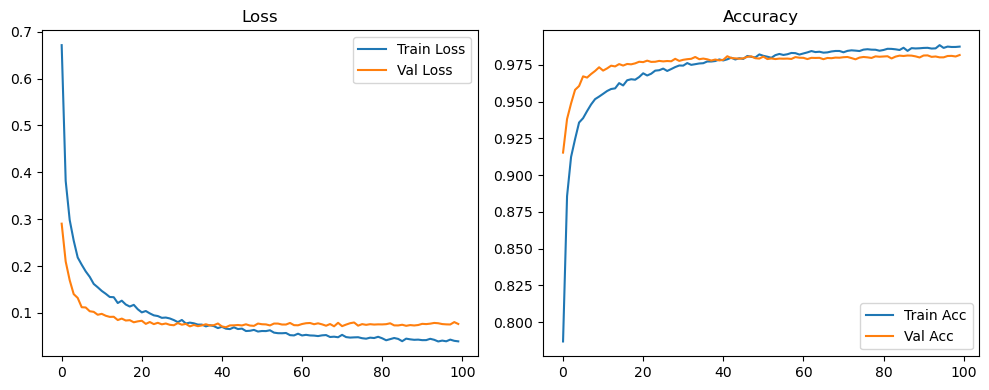

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3551, Acc: 0.8937 | Val Loss: 0.2255, Acc: 0.9330


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1700, Acc: 0.9481 | Val Loss: 0.1610, Acc: 0.9513


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1189, Acc: 0.9633 | Val Loss: 0.1274, Acc: 0.9620


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0838, Acc: 0.9740 | Val Loss: 0.1062, Acc: 0.9680


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0685, Acc: 0.9786 | Val Loss: 0.1361, Acc: 0.9613


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9818 | Val Loss: 0.0957, Acc: 0.9741


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9839 | Val Loss: 0.1437, Acc: 0.9614


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9861 | Val Loss: 0.1014, Acc: 0.9715


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9880 | Val Loss: 0.0922, Acc: 0.9766


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9881 | Val Loss: 0.1132, Acc: 0.9725


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9904 | Val Loss: 0.1144, Acc: 0.9719


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.1122, Acc: 0.9753


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9918 | Val Loss: 0.1373, Acc: 0.9700


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9914 | Val Loss: 0.1128, Acc: 0.9755


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9927 | Val Loss: 0.1258, Acc: 0.9742


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9928 | Val Loss: 0.1245, Acc: 0.9734


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.1232, Acc: 0.9758


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.1178, Acc: 0.9775


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9929 | Val Loss: 0.1198, Acc: 0.9764


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9946 | Val Loss: 0.1219, Acc: 0.9742


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9950 | Val Loss: 0.1139, Acc: 0.9769


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.1390, Acc: 0.9756


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9948 | Val Loss: 0.1229, Acc: 0.9778


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9964 | Val Loss: 0.1190, Acc: 0.9782


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1301, Acc: 0.9771


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.1204, Acc: 0.9781


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9941 | Val Loss: 0.1349, Acc: 0.9744


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1447, Acc: 0.9759


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1163, Acc: 0.9797


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.1633, Acc: 0.9742


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.1105, Acc: 0.9801


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.1191, Acc: 0.9797


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1276, Acc: 0.9779


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.1192, Acc: 0.9789


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1167, Acc: 0.9788


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1176, Acc: 0.9794


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1234, Acc: 0.9798


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1183, Acc: 0.9790


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1291, Acc: 0.9795


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9967 | Val Loss: 0.1377, Acc: 0.9750


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1320, Acc: 0.9768


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1263, Acc: 0.9792


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.1330, Acc: 0.9782


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1237, Acc: 0.9782


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1308, Acc: 0.9796


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1196, Acc: 0.9804


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1349, Acc: 0.9797


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1312, Acc: 0.9798


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1164, Acc: 0.9822


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1325, Acc: 0.9794


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1085, Acc: 0.9824


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1107, Acc: 0.9828


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1112, Acc: 0.9822


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1109, Acc: 0.9828


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1121, Acc: 0.9829


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1168, Acc: 0.9835


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1220, Acc: 0.9822


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1242, Acc: 0.9822


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1250, Acc: 0.9815


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1153, Acc: 0.9820


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1172, Acc: 0.9823


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1257, Acc: 0.9818


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1262, Acc: 0.9822


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1318, Acc: 0.9798


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1343, Acc: 0.9806


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1362, Acc: 0.9809


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9992 | Val Loss: 0.1350, Acc: 0.9813


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1323, Acc: 0.9816


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1330, Acc: 0.9818


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1422, Acc: 0.9810


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1475, Acc: 0.9809


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1500, Acc: 0.9808


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1453, Acc: 0.9807


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1409, Acc: 0.9806


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1267, Acc: 0.9831


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1383, Acc: 0.9822


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1286, Acc: 0.9827


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1486, Acc: 0.9820


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1391, Acc: 0.9814


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1441, Acc: 0.9821


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1407, Acc: 0.9825


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1336, Acc: 0.9829


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1311, Acc: 0.9832


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1297, Acc: 0.9828


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1316, Acc: 0.9825


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1362, Acc: 0.9821


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1358, Acc: 0.9831


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1409, Acc: 0.9822


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1358, Acc: 0.9821


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1358, Acc: 0.9828


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1346, Acc: 0.9832


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1332, Acc: 0.9838


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1320, Acc: 0.9831


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1389, Acc: 0.9834


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1325, Acc: 0.9830


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1324, Acc: 0.9831


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1467, Acc: 0.9815


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1415, Acc: 0.9826


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1375, Acc: 0.9825


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1323, Acc: 0.9842


Final Test Loss: 0.1350 Accuracy: 0.9836


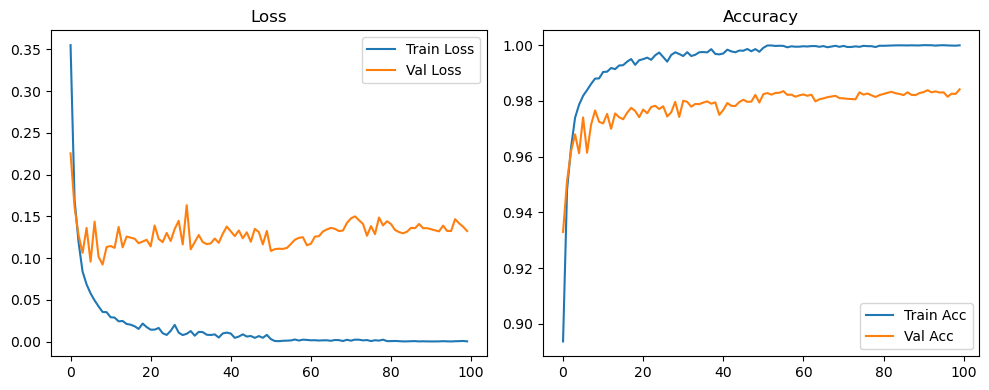

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4500, Acc: 0.8645 | Val Loss: 0.2374, Acc: 0.9291


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2381, Acc: 0.9286 | Val Loss: 0.1780, Acc: 0.9489


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1774, Acc: 0.9463 | Val Loss: 0.1376, Acc: 0.9596


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1396, Acc: 0.9578 | Val Loss: 0.1136, Acc: 0.9657


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1114, Acc: 0.9658 | Val Loss: 0.1103, Acc: 0.9668


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0978, Acc: 0.9692 | Val Loss: 0.0946, Acc: 0.9732


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0879, Acc: 0.9724 | Val Loss: 0.0983, Acc: 0.9728


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9750 | Val Loss: 0.0907, Acc: 0.9739


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0692, Acc: 0.9768 | Val Loss: 0.0919, Acc: 0.9763


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0671, Acc: 0.9786 | Val Loss: 0.0928, Acc: 0.9755


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0606, Acc: 0.9809 | Val Loss: 0.0868, Acc: 0.9760


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9808 | Val Loss: 0.0900, Acc: 0.9773


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9828 | Val Loss: 0.0969, Acc: 0.9759


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0494, Acc: 0.9836 | Val Loss: 0.0895, Acc: 0.9771


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9855 | Val Loss: 0.0890, Acc: 0.9777


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9861 | Val Loss: 0.0875, Acc: 0.9777


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9869 | Val Loss: 0.0903, Acc: 0.9782


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9856 | Val Loss: 0.0878, Acc: 0.9776


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9875 | Val Loss: 0.0822, Acc: 0.9802


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9890 | Val Loss: 0.0911, Acc: 0.9787


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9880 | Val Loss: 0.0868, Acc: 0.9782


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9886 | Val Loss: 0.0854, Acc: 0.9806


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9902 | Val Loss: 0.0892, Acc: 0.9807


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9894 | Val Loss: 0.0816, Acc: 0.9808


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9903 | Val Loss: 0.1044, Acc: 0.9752


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9905 | Val Loss: 0.0891, Acc: 0.9799


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9909 | Val Loss: 0.0918, Acc: 0.9802


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9919 | Val Loss: 0.0943, Acc: 0.9797


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9918 | Val Loss: 0.0881, Acc: 0.9810


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9910 | Val Loss: 0.0890, Acc: 0.9795


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9916 | Val Loss: 0.0851, Acc: 0.9807


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9927 | Val Loss: 0.0888, Acc: 0.9800


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9919 | Val Loss: 0.0877, Acc: 0.9810


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9932 | Val Loss: 0.0855, Acc: 0.9796


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9925 | Val Loss: 0.0889, Acc: 0.9805


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9923 | Val Loss: 0.0881, Acc: 0.9794


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9938 | Val Loss: 0.0853, Acc: 0.9808


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9939 | Val Loss: 0.0934, Acc: 0.9797


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9926 | Val Loss: 0.0937, Acc: 0.9797


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9924 | Val Loss: 0.0899, Acc: 0.9805


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9941 | Val Loss: 0.0890, Acc: 0.9814


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9937 | Val Loss: 0.0962, Acc: 0.9804


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9939 | Val Loss: 0.0986, Acc: 0.9813


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9944 | Val Loss: 0.0904, Acc: 0.9818


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9939 | Val Loss: 0.0871, Acc: 0.9814


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9939 | Val Loss: 0.0973, Acc: 0.9809


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.0903, Acc: 0.9807


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.0948, Acc: 0.9813


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9951 | Val Loss: 0.1010, Acc: 0.9812


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9942 | Val Loss: 0.0948, Acc: 0.9812


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0861, Acc: 0.9830


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0898, Acc: 0.9834


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9977 | Val Loss: 0.0873, Acc: 0.9829


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.0904, Acc: 0.9826


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0929, Acc: 0.9843


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.0975, Acc: 0.9822


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0956, Acc: 0.9822


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0940, Acc: 0.9830


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0972, Acc: 0.9835


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.0961, Acc: 0.9842


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0956, Acc: 0.9842


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1001, Acc: 0.9834


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1008, Acc: 0.9827


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1058, Acc: 0.9828


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1096, Acc: 0.9819


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.0988, Acc: 0.9832


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1057, Acc: 0.9824


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.1084, Acc: 0.9817


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1072, Acc: 0.9828


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.1055, Acc: 0.9824


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1054, Acc: 0.9822


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1078, Acc: 0.9828


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1148, Acc: 0.9822


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1140, Acc: 0.9820


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.0974, Acc: 0.9832


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1016, Acc: 0.9824


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1056, Acc: 0.9824


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1035, Acc: 0.9830


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.1063, Acc: 0.9828


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0999, Acc: 0.9832


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0966, Acc: 0.9839


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0954, Acc: 0.9842


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0962, Acc: 0.9834


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0975, Acc: 0.9834


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0985, Acc: 0.9836


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0994, Acc: 0.9833


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1038, Acc: 0.9836


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1026, Acc: 0.9842


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1036, Acc: 0.9838


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1003, Acc: 0.9839


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1059, Acc: 0.9836


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1066, Acc: 0.9832


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1059, Acc: 0.9846


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1088, Acc: 0.9841


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1116, Acc: 0.9832


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1098, Acc: 0.9835


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.1111, Acc: 0.9828


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1095, Acc: 0.9836


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1129, Acc: 0.9833


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1110, Acc: 0.9838


Final Test Loss: 0.0887 Accuracy: 0.9853


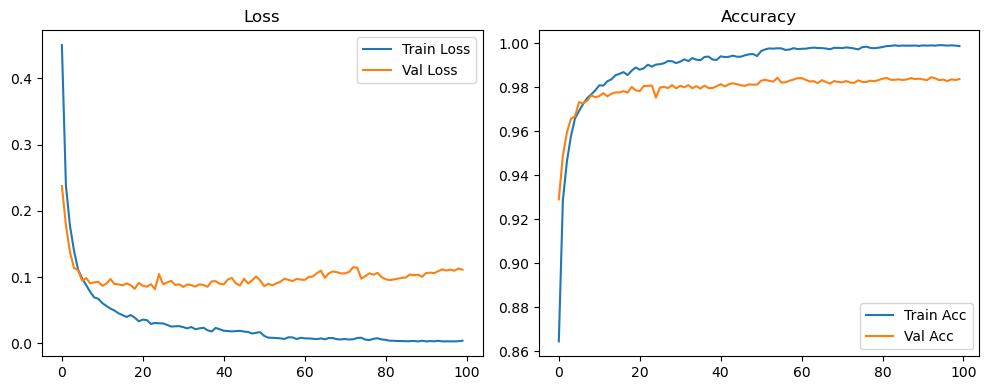

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6711, Acc: 0.7870 | Val Loss: 0.2904, Acc: 0.9153


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3817, Acc: 0.8857 | Val Loss: 0.2098, Acc: 0.9382


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2984, Acc: 0.9124 | Val Loss: 0.1699, Acc: 0.9487


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2544, Acc: 0.9245 | Val Loss: 0.1402, Acc: 0.9580


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2183, Acc: 0.9358 | Val Loss: 0.1321, Acc: 0.9606


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2029, Acc: 0.9387 | Val Loss: 0.1122, Acc: 0.9672


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1887, Acc: 0.9436 | Val Loss: 0.1117, Acc: 0.9663


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1771, Acc: 0.9481 | Val Loss: 0.1037, Acc: 0.9688


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1619, Acc: 0.9517 | Val Loss: 0.1023, Acc: 0.9708


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1547, Acc: 0.9534 | Val Loss: 0.0962, Acc: 0.9733


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1470, Acc: 0.9553 | Val Loss: 0.0981, Acc: 0.9711


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1409, Acc: 0.9572 | Val Loss: 0.0940, Acc: 0.9726


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1341, Acc: 0.9586 | Val Loss: 0.0916, Acc: 0.9744


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1336, Acc: 0.9590 | Val Loss: 0.0919, Acc: 0.9739


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1212, Acc: 0.9626 | Val Loss: 0.0849, Acc: 0.9755


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1262, Acc: 0.9610 | Val Loss: 0.0880, Acc: 0.9745


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1180, Acc: 0.9645 | Val Loss: 0.0839, Acc: 0.9756


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1137, Acc: 0.9652 | Val Loss: 0.0846, Acc: 0.9753


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1173, Acc: 0.9649 | Val Loss: 0.0801, Acc: 0.9760


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1078, Acc: 0.9667 | Val Loss: 0.0821, Acc: 0.9771


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1012, Acc: 0.9692 | Val Loss: 0.0834, Acc: 0.9768


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1042, Acc: 0.9677 | Val Loss: 0.0767, Acc: 0.9778


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0991, Acc: 0.9690 | Val Loss: 0.0807, Acc: 0.9770


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0949, Acc: 0.9710 | Val Loss: 0.0762, Acc: 0.9771


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0934, Acc: 0.9713 | Val Loss: 0.0790, Acc: 0.9777


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0896, Acc: 0.9724 | Val Loss: 0.0758, Acc: 0.9773


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0902, Acc: 0.9708 | Val Loss: 0.0775, Acc: 0.9776


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0883, Acc: 0.9721 | Val Loss: 0.0747, Acc: 0.9774


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0848, Acc: 0.9735 | Val Loss: 0.0738, Acc: 0.9791


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0805, Acc: 0.9745 | Val Loss: 0.0784, Acc: 0.9777


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0851, Acc: 0.9745 | Val Loss: 0.0750, Acc: 0.9784


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9762 | Val Loss: 0.0767, Acc: 0.9788


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9750 | Val Loss: 0.0714, Acc: 0.9791


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0779, Acc: 0.9754 | Val Loss: 0.0744, Acc: 0.9803


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9759 | Val Loss: 0.0718, Acc: 0.9788


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9761 | Val Loss: 0.0735, Acc: 0.9792


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0714, Acc: 0.9773 | Val Loss: 0.0759, Acc: 0.9788


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0739, Acc: 0.9772 | Val Loss: 0.0734, Acc: 0.9779


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9776 | Val Loss: 0.0739, Acc: 0.9786


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0677, Acc: 0.9787 | Val Loss: 0.0775, Acc: 0.9780


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0704, Acc: 0.9780 | Val Loss: 0.0713, Acc: 0.9784


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0665, Acc: 0.9788 | Val Loss: 0.0696, Acc: 0.9808


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0656, Acc: 0.9799 | Val Loss: 0.0735, Acc: 0.9796


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9786 | Val Loss: 0.0736, Acc: 0.9794


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0657, Acc: 0.9795 | Val Loss: 0.0743, Acc: 0.9792


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0666, Acc: 0.9790 | Val Loss: 0.0734, Acc: 0.9794


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9810 | Val Loss: 0.0758, Acc: 0.9804


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0620, Acc: 0.9804 | Val Loss: 0.0732, Acc: 0.9808


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0639, Acc: 0.9800 | Val Loss: 0.0725, Acc: 0.9795


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0604, Acc: 0.9821 | Val Loss: 0.0774, Acc: 0.9792


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0558, Acc: 0.9826 | Val Loss: 0.0743, Acc: 0.9802


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0516, Acc: 0.9839 | Val Loss: 0.0750, Acc: 0.9803


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0519, Acc: 0.9829 | Val Loss: 0.0723, Acc: 0.9800


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0469, Acc: 0.9848 | Val Loss: 0.0759, Acc: 0.9801


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0459, Acc: 0.9854 | Val Loss: 0.0765, Acc: 0.9811


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9859 | Val Loss: 0.0759, Acc: 0.9808


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0447, Acc: 0.9855 | Val Loss: 0.0756, Acc: 0.9802


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0416, Acc: 0.9864 | Val Loss: 0.0798, Acc: 0.9792


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0405, Acc: 0.9868 | Val Loss: 0.0778, Acc: 0.9802


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0443, Acc: 0.9855 | Val Loss: 0.0759, Acc: 0.9802


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9868 | Val Loss: 0.0753, Acc: 0.9805


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9859 | Val Loss: 0.0771, Acc: 0.9802


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0414, Acc: 0.9870 | Val Loss: 0.0790, Acc: 0.9798


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9867 | Val Loss: 0.0770, Acc: 0.9796


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9871 | Val Loss: 0.0778, Acc: 0.9796


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9872 | Val Loss: 0.0766, Acc: 0.9803


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9863 | Val Loss: 0.0763, Acc: 0.9808


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9874 | Val Loss: 0.0780, Acc: 0.9811


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9875 | Val Loss: 0.0740, Acc: 0.9798


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9882 | Val Loss: 0.0772, Acc: 0.9803


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9871 | Val Loss: 0.0767, Acc: 0.9799


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9875 | Val Loss: 0.0767, Acc: 0.9801


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9880 | Val Loss: 0.0761, Acc: 0.9806


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9874 | Val Loss: 0.0796, Acc: 0.9802


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9875 | Val Loss: 0.0755, Acc: 0.9802


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0362, Acc: 0.9879 | Val Loss: 0.0763, Acc: 0.9798


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9886 | Val Loss: 0.0785, Acc: 0.9801


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9886 | Val Loss: 0.0764, Acc: 0.9811


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9875 | Val Loss: 0.0757, Acc: 0.9810


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9878 | Val Loss: 0.0767, Acc: 0.9800


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0340, Acc: 0.9891 | Val Loss: 0.0765, Acc: 0.9807


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9900 | Val Loss: 0.0765, Acc: 0.9810


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0308, Acc: 0.9900 | Val Loss: 0.0790, Acc: 0.9809


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0320, Acc: 0.9896 | Val Loss: 0.0760, Acc: 0.9816


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9893 | Val Loss: 0.0771, Acc: 0.9817


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9902 | Val Loss: 0.0780, Acc: 0.9808


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9898 | Val Loss: 0.0755, Acc: 0.9812


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0296, Acc: 0.9901 | Val Loss: 0.0787, Acc: 0.9812


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9905 | Val Loss: 0.0787, Acc: 0.9812


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9907 | Val Loss: 0.0777, Acc: 0.9812


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9912 | Val Loss: 0.0819, Acc: 0.9813


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9913 | Val Loss: 0.0801, Acc: 0.9814


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9904 | Val Loss: 0.0789, Acc: 0.9812


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9904 | Val Loss: 0.0787, Acc: 0.9808


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9916 | Val Loss: 0.0777, Acc: 0.9815


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9910 | Val Loss: 0.0776, Acc: 0.9805


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9914 | Val Loss: 0.0777, Acc: 0.9809


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9903 | Val Loss: 0.0777, Acc: 0.9814


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9913 | Val Loss: 0.0799, Acc: 0.9818


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9911 | Val Loss: 0.0803, Acc: 0.9820


Final Test Loss: 0.0686 Accuracy: 0.9834


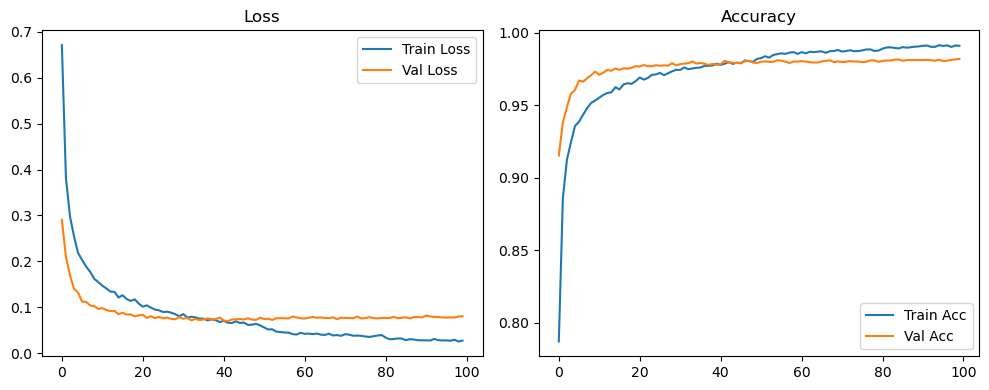

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3551, Acc: 0.8937 | Val Loss: 0.2255, Acc: 0.9330


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1700, Acc: 0.9481 | Val Loss: 0.1610, Acc: 0.9513


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1189, Acc: 0.9633 | Val Loss: 0.1274, Acc: 0.9620


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0838, Acc: 0.9740 | Val Loss: 0.1062, Acc: 0.9680


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0685, Acc: 0.9786 | Val Loss: 0.1361, Acc: 0.9613


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9818 | Val Loss: 0.0957, Acc: 0.9741


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9839 | Val Loss: 0.1437, Acc: 0.9614


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9861 | Val Loss: 0.1014, Acc: 0.9715


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9880 | Val Loss: 0.0922, Acc: 0.9766


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9881 | Val Loss: 0.1132, Acc: 0.9725


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9904 | Val Loss: 0.1144, Acc: 0.9719


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.1122, Acc: 0.9753


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9918 | Val Loss: 0.1373, Acc: 0.9700


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9914 | Val Loss: 0.1128, Acc: 0.9755


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9927 | Val Loss: 0.1258, Acc: 0.9742


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9928 | Val Loss: 0.1245, Acc: 0.9734


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.1232, Acc: 0.9758


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.1178, Acc: 0.9775


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9929 | Val Loss: 0.1198, Acc: 0.9764


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9946 | Val Loss: 0.1219, Acc: 0.9742


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9950 | Val Loss: 0.1139, Acc: 0.9769


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.1390, Acc: 0.9756


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9948 | Val Loss: 0.1229, Acc: 0.9778


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9964 | Val Loss: 0.1190, Acc: 0.9782


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1301, Acc: 0.9771


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.1204, Acc: 0.9781


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9941 | Val Loss: 0.1349, Acc: 0.9744


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1447, Acc: 0.9759


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1163, Acc: 0.9797


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.1633, Acc: 0.9742


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.1105, Acc: 0.9801


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.1191, Acc: 0.9797


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1276, Acc: 0.9779


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.1192, Acc: 0.9789


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1167, Acc: 0.9788


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1176, Acc: 0.9794


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1234, Acc: 0.9798


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1183, Acc: 0.9790


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1291, Acc: 0.9795


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9967 | Val Loss: 0.1377, Acc: 0.9750


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1320, Acc: 0.9768


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1263, Acc: 0.9792


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.1330, Acc: 0.9782


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1237, Acc: 0.9782


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1308, Acc: 0.9796


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1196, Acc: 0.9804


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1349, Acc: 0.9797


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1312, Acc: 0.9798


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1164, Acc: 0.9822


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1325, Acc: 0.9794


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1085, Acc: 0.9824


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1107, Acc: 0.9828


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1112, Acc: 0.9822


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1109, Acc: 0.9828


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1121, Acc: 0.9829


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1168, Acc: 0.9835


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1220, Acc: 0.9822


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1242, Acc: 0.9822


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1250, Acc: 0.9815


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1153, Acc: 0.9820


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1172, Acc: 0.9823


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1257, Acc: 0.9818


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1262, Acc: 0.9822


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1318, Acc: 0.9798


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1343, Acc: 0.9806


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1362, Acc: 0.9809


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9992 | Val Loss: 0.1350, Acc: 0.9813


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1323, Acc: 0.9816


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1330, Acc: 0.9818


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1422, Acc: 0.9810


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1475, Acc: 0.9809


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1500, Acc: 0.9808


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1453, Acc: 0.9807


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1409, Acc: 0.9806


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1267, Acc: 0.9831


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1383, Acc: 0.9822


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1286, Acc: 0.9827


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1486, Acc: 0.9820


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1391, Acc: 0.9814


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1441, Acc: 0.9821


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1406, Acc: 0.9826


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1352, Acc: 0.9826


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1308, Acc: 0.9832


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1326, Acc: 0.9831


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1322, Acc: 0.9830


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1327, Acc: 0.9824


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1358, Acc: 0.9822


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1383, Acc: 0.9826


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1312, Acc: 0.9834


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1310, Acc: 0.9833


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1340, Acc: 0.9835


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1352, Acc: 0.9830


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1351, Acc: 0.9825


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1330, Acc: 0.9830


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1337, Acc: 0.9834


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1329, Acc: 0.9834


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1357, Acc: 0.9832


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1371, Acc: 0.9832


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1371, Acc: 0.9827


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1317, Acc: 0.9835


Final Test Loss: 0.1329 Accuracy: 0.9835


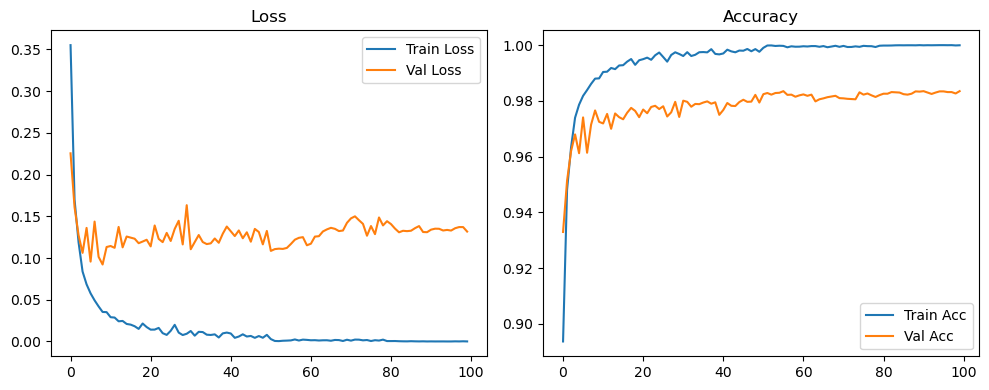

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4500, Acc: 0.8645 | Val Loss: 0.2374, Acc: 0.9291


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2381, Acc: 0.9286 | Val Loss: 0.1780, Acc: 0.9489


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1774, Acc: 0.9463 | Val Loss: 0.1376, Acc: 0.9596


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1396, Acc: 0.9578 | Val Loss: 0.1136, Acc: 0.9657


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1114, Acc: 0.9658 | Val Loss: 0.1103, Acc: 0.9668


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0978, Acc: 0.9692 | Val Loss: 0.0946, Acc: 0.9732


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0879, Acc: 0.9724 | Val Loss: 0.0983, Acc: 0.9728


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9750 | Val Loss: 0.0907, Acc: 0.9739


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0692, Acc: 0.9768 | Val Loss: 0.0919, Acc: 0.9763


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0671, Acc: 0.9786 | Val Loss: 0.0928, Acc: 0.9755


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0606, Acc: 0.9809 | Val Loss: 0.0868, Acc: 0.9760


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9808 | Val Loss: 0.0900, Acc: 0.9773


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9828 | Val Loss: 0.0969, Acc: 0.9759


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0494, Acc: 0.9836 | Val Loss: 0.0895, Acc: 0.9771


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9855 | Val Loss: 0.0890, Acc: 0.9777


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9861 | Val Loss: 0.0875, Acc: 0.9777


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9869 | Val Loss: 0.0903, Acc: 0.9782


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9856 | Val Loss: 0.0878, Acc: 0.9776


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9875 | Val Loss: 0.0822, Acc: 0.9802


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9890 | Val Loss: 0.0911, Acc: 0.9787


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9880 | Val Loss: 0.0868, Acc: 0.9782


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9886 | Val Loss: 0.0854, Acc: 0.9806


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9902 | Val Loss: 0.0892, Acc: 0.9807


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9894 | Val Loss: 0.0816, Acc: 0.9808


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9903 | Val Loss: 0.1044, Acc: 0.9752


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9905 | Val Loss: 0.0891, Acc: 0.9799


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9909 | Val Loss: 0.0918, Acc: 0.9802


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9919 | Val Loss: 0.0943, Acc: 0.9797


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9918 | Val Loss: 0.0881, Acc: 0.9810


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9910 | Val Loss: 0.0890, Acc: 0.9795


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9916 | Val Loss: 0.0851, Acc: 0.9807


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9927 | Val Loss: 0.0888, Acc: 0.9800


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9919 | Val Loss: 0.0877, Acc: 0.9810


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9932 | Val Loss: 0.0855, Acc: 0.9796


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9925 | Val Loss: 0.0889, Acc: 0.9805


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9923 | Val Loss: 0.0881, Acc: 0.9794


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9938 | Val Loss: 0.0853, Acc: 0.9808


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9939 | Val Loss: 0.0934, Acc: 0.9797


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9926 | Val Loss: 0.0937, Acc: 0.9797


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9924 | Val Loss: 0.0899, Acc: 0.9805


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9941 | Val Loss: 0.0890, Acc: 0.9814


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9937 | Val Loss: 0.0962, Acc: 0.9804


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9939 | Val Loss: 0.0986, Acc: 0.9813


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9944 | Val Loss: 0.0904, Acc: 0.9818


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9939 | Val Loss: 0.0871, Acc: 0.9814


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9939 | Val Loss: 0.0973, Acc: 0.9809


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.0903, Acc: 0.9807


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.0948, Acc: 0.9813


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9951 | Val Loss: 0.1010, Acc: 0.9812


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9942 | Val Loss: 0.0948, Acc: 0.9812


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0861, Acc: 0.9830


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0898, Acc: 0.9834


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9977 | Val Loss: 0.0873, Acc: 0.9829


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.0904, Acc: 0.9826


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0929, Acc: 0.9843


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.0975, Acc: 0.9822


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0956, Acc: 0.9822


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0940, Acc: 0.9830


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0972, Acc: 0.9835


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.0961, Acc: 0.9842


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0956, Acc: 0.9842


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1001, Acc: 0.9834


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1008, Acc: 0.9827


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1058, Acc: 0.9828


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1096, Acc: 0.9819


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.0988, Acc: 0.9832


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1057, Acc: 0.9824


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.1084, Acc: 0.9817


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1072, Acc: 0.9828


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.1055, Acc: 0.9824


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1054, Acc: 0.9822


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1078, Acc: 0.9828


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1148, Acc: 0.9822


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1140, Acc: 0.9820


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.0974, Acc: 0.9832


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1016, Acc: 0.9824


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1056, Acc: 0.9824


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1035, Acc: 0.9830


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.1063, Acc: 0.9828


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0999, Acc: 0.9832


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0967, Acc: 0.9835


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0954, Acc: 0.9841


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0969, Acc: 0.9838


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0956, Acc: 0.9838


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0959, Acc: 0.9843


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0968, Acc: 0.9838


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0970, Acc: 0.9839


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0980, Acc: 0.9832


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0991, Acc: 0.9830


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9987 | Val Loss: 0.0959, Acc: 0.9838


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0995, Acc: 0.9842


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0997, Acc: 0.9833


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0992, Acc: 0.9841


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0999, Acc: 0.9836


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1021, Acc: 0.9837


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1005, Acc: 0.9839


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1017, Acc: 0.9837


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1018, Acc: 0.9836


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1049, Acc: 0.9831


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1029, Acc: 0.9838


Final Test Loss: 0.0837 Accuracy: 0.9858


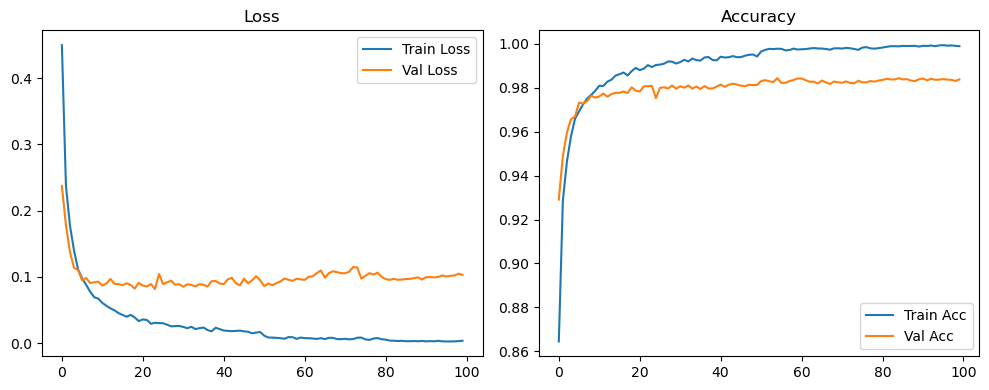

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6711, Acc: 0.7870 | Val Loss: 0.2904, Acc: 0.9153


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3817, Acc: 0.8857 | Val Loss: 0.2098, Acc: 0.9382


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2984, Acc: 0.9124 | Val Loss: 0.1699, Acc: 0.9487


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2544, Acc: 0.9245 | Val Loss: 0.1402, Acc: 0.9580


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2183, Acc: 0.9358 | Val Loss: 0.1321, Acc: 0.9606


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2029, Acc: 0.9387 | Val Loss: 0.1122, Acc: 0.9672


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1887, Acc: 0.9436 | Val Loss: 0.1117, Acc: 0.9663


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1771, Acc: 0.9481 | Val Loss: 0.1037, Acc: 0.9688


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1619, Acc: 0.9517 | Val Loss: 0.1023, Acc: 0.9708


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1547, Acc: 0.9534 | Val Loss: 0.0962, Acc: 0.9733


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1470, Acc: 0.9553 | Val Loss: 0.0981, Acc: 0.9711


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1409, Acc: 0.9572 | Val Loss: 0.0940, Acc: 0.9726


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1341, Acc: 0.9586 | Val Loss: 0.0916, Acc: 0.9744


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1336, Acc: 0.9590 | Val Loss: 0.0919, Acc: 0.9739


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1212, Acc: 0.9626 | Val Loss: 0.0849, Acc: 0.9755


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1262, Acc: 0.9610 | Val Loss: 0.0880, Acc: 0.9745


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1180, Acc: 0.9645 | Val Loss: 0.0839, Acc: 0.9756


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1137, Acc: 0.9652 | Val Loss: 0.0846, Acc: 0.9753


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1173, Acc: 0.9649 | Val Loss: 0.0801, Acc: 0.9760


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1078, Acc: 0.9667 | Val Loss: 0.0821, Acc: 0.9771


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1012, Acc: 0.9692 | Val Loss: 0.0834, Acc: 0.9768


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1042, Acc: 0.9677 | Val Loss: 0.0767, Acc: 0.9778


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0991, Acc: 0.9690 | Val Loss: 0.0807, Acc: 0.9770


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0949, Acc: 0.9710 | Val Loss: 0.0762, Acc: 0.9771


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0934, Acc: 0.9713 | Val Loss: 0.0790, Acc: 0.9777


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0896, Acc: 0.9724 | Val Loss: 0.0758, Acc: 0.9773


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0902, Acc: 0.9708 | Val Loss: 0.0775, Acc: 0.9776


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0883, Acc: 0.9721 | Val Loss: 0.0747, Acc: 0.9774


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0848, Acc: 0.9735 | Val Loss: 0.0738, Acc: 0.9791


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0805, Acc: 0.9745 | Val Loss: 0.0784, Acc: 0.9777


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0851, Acc: 0.9745 | Val Loss: 0.0750, Acc: 0.9784


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9762 | Val Loss: 0.0767, Acc: 0.9788


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9750 | Val Loss: 0.0714, Acc: 0.9791


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0779, Acc: 0.9754 | Val Loss: 0.0744, Acc: 0.9803


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9759 | Val Loss: 0.0718, Acc: 0.9788


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9761 | Val Loss: 0.0735, Acc: 0.9792


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0714, Acc: 0.9773 | Val Loss: 0.0759, Acc: 0.9788


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0739, Acc: 0.9772 | Val Loss: 0.0734, Acc: 0.9779


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9776 | Val Loss: 0.0739, Acc: 0.9786


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0677, Acc: 0.9787 | Val Loss: 0.0775, Acc: 0.9780


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0704, Acc: 0.9780 | Val Loss: 0.0713, Acc: 0.9784


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0665, Acc: 0.9788 | Val Loss: 0.0696, Acc: 0.9808


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0656, Acc: 0.9799 | Val Loss: 0.0735, Acc: 0.9796


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9786 | Val Loss: 0.0736, Acc: 0.9794


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0657, Acc: 0.9795 | Val Loss: 0.0743, Acc: 0.9792


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0666, Acc: 0.9790 | Val Loss: 0.0734, Acc: 0.9794


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9810 | Val Loss: 0.0758, Acc: 0.9804


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0620, Acc: 0.9804 | Val Loss: 0.0732, Acc: 0.9808


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0639, Acc: 0.9800 | Val Loss: 0.0725, Acc: 0.9795


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0604, Acc: 0.9821 | Val Loss: 0.0774, Acc: 0.9792


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0558, Acc: 0.9826 | Val Loss: 0.0743, Acc: 0.9802


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0516, Acc: 0.9839 | Val Loss: 0.0750, Acc: 0.9803


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0519, Acc: 0.9829 | Val Loss: 0.0723, Acc: 0.9800


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0469, Acc: 0.9848 | Val Loss: 0.0759, Acc: 0.9801


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0459, Acc: 0.9854 | Val Loss: 0.0765, Acc: 0.9811


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9859 | Val Loss: 0.0759, Acc: 0.9808


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0447, Acc: 0.9855 | Val Loss: 0.0756, Acc: 0.9802


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0416, Acc: 0.9864 | Val Loss: 0.0798, Acc: 0.9792


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0405, Acc: 0.9868 | Val Loss: 0.0778, Acc: 0.9802


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0443, Acc: 0.9855 | Val Loss: 0.0759, Acc: 0.9802


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9868 | Val Loss: 0.0753, Acc: 0.9805


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9859 | Val Loss: 0.0771, Acc: 0.9802


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0414, Acc: 0.9870 | Val Loss: 0.0790, Acc: 0.9798


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9867 | Val Loss: 0.0770, Acc: 0.9796


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9871 | Val Loss: 0.0778, Acc: 0.9796


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9872 | Val Loss: 0.0766, Acc: 0.9803


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9863 | Val Loss: 0.0763, Acc: 0.9808


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9874 | Val Loss: 0.0780, Acc: 0.9811


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9875 | Val Loss: 0.0740, Acc: 0.9798


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9882 | Val Loss: 0.0772, Acc: 0.9803


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9871 | Val Loss: 0.0767, Acc: 0.9799


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9875 | Val Loss: 0.0767, Acc: 0.9801


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9880 | Val Loss: 0.0761, Acc: 0.9806


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9874 | Val Loss: 0.0796, Acc: 0.9802


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9875 | Val Loss: 0.0755, Acc: 0.9802


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0362, Acc: 0.9879 | Val Loss: 0.0763, Acc: 0.9798


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9886 | Val Loss: 0.0785, Acc: 0.9801


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9886 | Val Loss: 0.0764, Acc: 0.9811


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9875 | Val Loss: 0.0757, Acc: 0.9810


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9878 | Val Loss: 0.0767, Acc: 0.9800


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0340, Acc: 0.9889 | Val Loss: 0.0764, Acc: 0.9806


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0304, Acc: 0.9902 | Val Loss: 0.0758, Acc: 0.9809


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0310, Acc: 0.9898 | Val Loss: 0.0774, Acc: 0.9808


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9899 | Val Loss: 0.0750, Acc: 0.9814


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9895 | Val Loss: 0.0766, Acc: 0.9811


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0282, Acc: 0.9901 | Val Loss: 0.0767, Acc: 0.9807


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0304, Acc: 0.9897 | Val Loss: 0.0748, Acc: 0.9810


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9901 | Val Loss: 0.0778, Acc: 0.9810


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9908 | Val Loss: 0.0775, Acc: 0.9813


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9910 | Val Loss: 0.0767, Acc: 0.9813


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0278, Acc: 0.9912 | Val Loss: 0.0806, Acc: 0.9813


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9913 | Val Loss: 0.0793, Acc: 0.9812


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9905 | Val Loss: 0.0780, Acc: 0.9814


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0282, Acc: 0.9907 | Val Loss: 0.0776, Acc: 0.9812


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9916 | Val Loss: 0.0779, Acc: 0.9814


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9911 | Val Loss: 0.0776, Acc: 0.9807


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0270, Acc: 0.9915 | Val Loss: 0.0771, Acc: 0.9810


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.0775, Acc: 0.9813


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9917 | Val Loss: 0.0788, Acc: 0.9817


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0269, Acc: 0.9912 | Val Loss: 0.0786, Acc: 0.9814


Final Test Loss: 0.0684 Accuracy: 0.9833


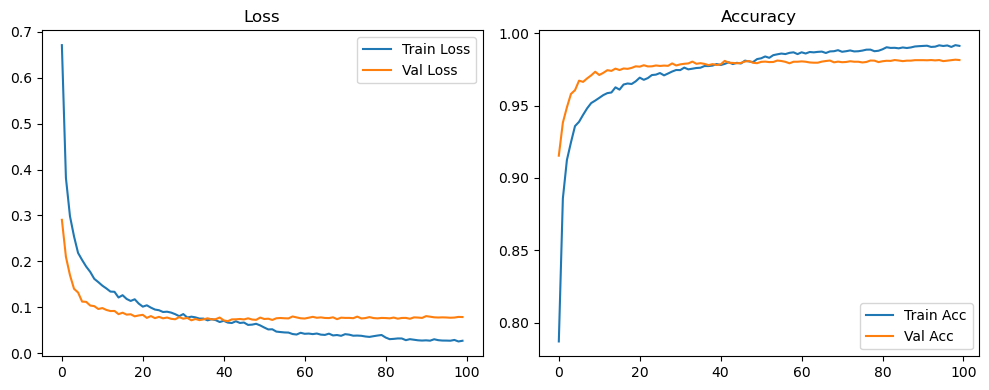

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3551, Acc: 0.8937 | Val Loss: 0.2255, Acc: 0.9330


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1700, Acc: 0.9481 | Val Loss: 0.1610, Acc: 0.9513


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1189, Acc: 0.9633 | Val Loss: 0.1274, Acc: 0.9620


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0838, Acc: 0.9740 | Val Loss: 0.1062, Acc: 0.9680


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0685, Acc: 0.9786 | Val Loss: 0.1361, Acc: 0.9613


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9818 | Val Loss: 0.0957, Acc: 0.9741


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9839 | Val Loss: 0.1437, Acc: 0.9614


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9861 | Val Loss: 0.1014, Acc: 0.9715


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9880 | Val Loss: 0.0922, Acc: 0.9766


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9881 | Val Loss: 0.1132, Acc: 0.9725


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9904 | Val Loss: 0.1144, Acc: 0.9719


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.1122, Acc: 0.9753


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9918 | Val Loss: 0.1373, Acc: 0.9700


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9914 | Val Loss: 0.1128, Acc: 0.9755


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9927 | Val Loss: 0.1258, Acc: 0.9742


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9928 | Val Loss: 0.1245, Acc: 0.9734


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.1232, Acc: 0.9758


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.1178, Acc: 0.9775


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9929 | Val Loss: 0.1198, Acc: 0.9764


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9946 | Val Loss: 0.1219, Acc: 0.9742


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9950 | Val Loss: 0.1139, Acc: 0.9769


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.1390, Acc: 0.9756


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9948 | Val Loss: 0.1229, Acc: 0.9778


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9964 | Val Loss: 0.1190, Acc: 0.9782


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1301, Acc: 0.9771


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.1204, Acc: 0.9781


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9941 | Val Loss: 0.1349, Acc: 0.9744


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1447, Acc: 0.9759


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1163, Acc: 0.9797


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.1633, Acc: 0.9742


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.1105, Acc: 0.9801


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.1191, Acc: 0.9797


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1276, Acc: 0.9779


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.1192, Acc: 0.9789


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1167, Acc: 0.9788


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1176, Acc: 0.9794


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1234, Acc: 0.9798


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1183, Acc: 0.9790


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1291, Acc: 0.9795


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9967 | Val Loss: 0.1377, Acc: 0.9750


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1320, Acc: 0.9768


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1263, Acc: 0.9792


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.1330, Acc: 0.9782


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1237, Acc: 0.9782


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1308, Acc: 0.9796


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1196, Acc: 0.9804


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1349, Acc: 0.9797


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1312, Acc: 0.9798


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1164, Acc: 0.9822


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1325, Acc: 0.9794


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1086, Acc: 0.9828


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1097, Acc: 0.9831


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1057, Acc: 0.9838


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1046, Acc: 0.9833


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1031, Acc: 0.9841


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1032, Acc: 0.9837


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1093, Acc: 0.9822


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1078, Acc: 0.9822


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1066, Acc: 0.9831


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1074, Acc: 0.9831


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1097, Acc: 0.9830


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1165, Acc: 0.9829


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1122, Acc: 0.9829


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1160, Acc: 0.9829


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1092, Acc: 0.9835


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1173, Acc: 0.9825


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1203, Acc: 0.9832


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1185, Acc: 0.9835


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1174, Acc: 0.9835


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1249, Acc: 0.9825


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1257, Acc: 0.9828


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1158, Acc: 0.9834


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1196, Acc: 0.9832


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1204, Acc: 0.9838


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1153, Acc: 0.9843


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1153, Acc: 0.9836


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1186, Acc: 0.9832


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1204, Acc: 0.9834


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1188, Acc: 0.9842


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1246, Acc: 0.9837


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1230, Acc: 0.9832


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1243, Acc: 0.9836


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1245, Acc: 0.9835


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1195, Acc: 0.9830


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1202, Acc: 0.9838


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1193, Acc: 0.9845


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1224, Acc: 0.9832


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1206, Acc: 0.9843


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1209, Acc: 0.9836


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1207, Acc: 0.9832


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1209, Acc: 0.9835


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1254, Acc: 0.9842


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1226, Acc: 0.9835


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1226, Acc: 0.9839


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1228, Acc: 0.9838


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1216, Acc: 0.9838


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1265, Acc: 0.9836


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1256, Acc: 0.9834


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1319, Acc: 0.9824


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1294, Acc: 0.9839


Final Test Loss: 0.1268 Accuracy: 0.9844


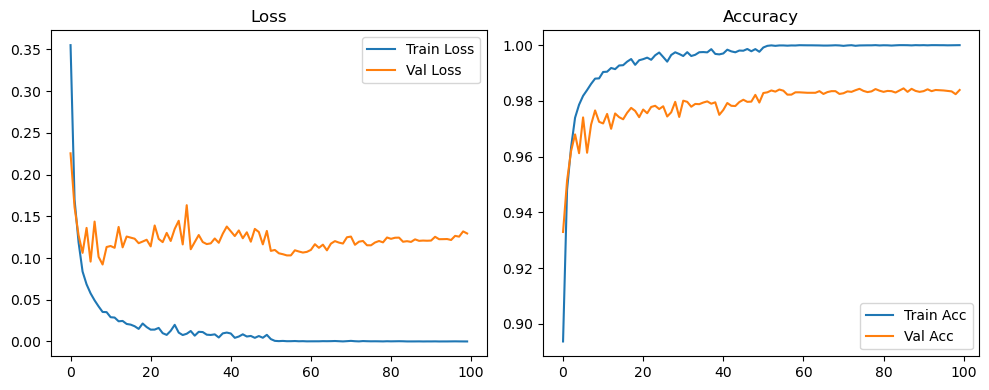

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4500, Acc: 0.8645 | Val Loss: 0.2374, Acc: 0.9291


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2381, Acc: 0.9286 | Val Loss: 0.1780, Acc: 0.9489


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1774, Acc: 0.9463 | Val Loss: 0.1376, Acc: 0.9596


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1396, Acc: 0.9578 | Val Loss: 0.1136, Acc: 0.9657


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1114, Acc: 0.9658 | Val Loss: 0.1103, Acc: 0.9668


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0978, Acc: 0.9692 | Val Loss: 0.0946, Acc: 0.9732


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0879, Acc: 0.9724 | Val Loss: 0.0983, Acc: 0.9728


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9750 | Val Loss: 0.0907, Acc: 0.9739


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0692, Acc: 0.9768 | Val Loss: 0.0919, Acc: 0.9763


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0671, Acc: 0.9786 | Val Loss: 0.0928, Acc: 0.9755


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0606, Acc: 0.9809 | Val Loss: 0.0868, Acc: 0.9760


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9808 | Val Loss: 0.0900, Acc: 0.9773


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9828 | Val Loss: 0.0969, Acc: 0.9759


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0494, Acc: 0.9836 | Val Loss: 0.0895, Acc: 0.9771


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9855 | Val Loss: 0.0890, Acc: 0.9777


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9861 | Val Loss: 0.0875, Acc: 0.9777


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9869 | Val Loss: 0.0903, Acc: 0.9782


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9856 | Val Loss: 0.0878, Acc: 0.9776


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9875 | Val Loss: 0.0822, Acc: 0.9802


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9890 | Val Loss: 0.0911, Acc: 0.9787


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9880 | Val Loss: 0.0868, Acc: 0.9782


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9886 | Val Loss: 0.0854, Acc: 0.9806


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9902 | Val Loss: 0.0892, Acc: 0.9807


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9894 | Val Loss: 0.0816, Acc: 0.9808


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9903 | Val Loss: 0.1044, Acc: 0.9752


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9905 | Val Loss: 0.0891, Acc: 0.9799


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9909 | Val Loss: 0.0918, Acc: 0.9802


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9919 | Val Loss: 0.0943, Acc: 0.9797


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9918 | Val Loss: 0.0881, Acc: 0.9810


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9910 | Val Loss: 0.0890, Acc: 0.9795


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9916 | Val Loss: 0.0851, Acc: 0.9807


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9927 | Val Loss: 0.0888, Acc: 0.9800


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9919 | Val Loss: 0.0877, Acc: 0.9810


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9932 | Val Loss: 0.0855, Acc: 0.9796


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9925 | Val Loss: 0.0889, Acc: 0.9805


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9923 | Val Loss: 0.0881, Acc: 0.9794


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9938 | Val Loss: 0.0853, Acc: 0.9808


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9939 | Val Loss: 0.0934, Acc: 0.9797


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9926 | Val Loss: 0.0937, Acc: 0.9797


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9924 | Val Loss: 0.0899, Acc: 0.9805


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9941 | Val Loss: 0.0890, Acc: 0.9814


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9937 | Val Loss: 0.0962, Acc: 0.9804


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9939 | Val Loss: 0.0986, Acc: 0.9813


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9944 | Val Loss: 0.0904, Acc: 0.9818


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9939 | Val Loss: 0.0871, Acc: 0.9814


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9939 | Val Loss: 0.0973, Acc: 0.9809


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.0903, Acc: 0.9807


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.0948, Acc: 0.9813


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9951 | Val Loss: 0.1010, Acc: 0.9812


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9942 | Val Loss: 0.0948, Acc: 0.9812


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.0850, Acc: 0.9828


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.0867, Acc: 0.9836


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0852, Acc: 0.9834


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0858, Acc: 0.9830


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0870, Acc: 0.9845


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0895, Acc: 0.9832


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.0898, Acc: 0.9832


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0884, Acc: 0.9827


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.0909, Acc: 0.9831


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0910, Acc: 0.9842


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0929, Acc: 0.9834


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0924, Acc: 0.9835


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0939, Acc: 0.9839


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0983, Acc: 0.9826


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0975, Acc: 0.9830


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0933, Acc: 0.9837


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0974, Acc: 0.9830


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0960, Acc: 0.9835


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0924, Acc: 0.9841


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0978, Acc: 0.9832


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1012, Acc: 0.9832


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1029, Acc: 0.9828


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1068, Acc: 0.9832


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.1086, Acc: 0.9832


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1000, Acc: 0.9836


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0969, Acc: 0.9838


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1014, Acc: 0.9833


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0995, Acc: 0.9835


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1004, Acc: 0.9834


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1035, Acc: 0.9836


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1025, Acc: 0.9835


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1034, Acc: 0.9841


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1051, Acc: 0.9832


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1052, Acc: 0.9836


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1041, Acc: 0.9840


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1068, Acc: 0.9835


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9989 | Val Loss: 0.1058, Acc: 0.9830


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1076, Acc: 0.9830


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1048, Acc: 0.9838


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1018, Acc: 0.9842


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1069, Acc: 0.9832


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1056, Acc: 0.9836


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1036, Acc: 0.9839


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1055, Acc: 0.9838


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1091, Acc: 0.9839


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1074, Acc: 0.9838


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1070, Acc: 0.9831


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1072, Acc: 0.9831


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1091, Acc: 0.9827


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1056, Acc: 0.9842


Final Test Loss: 0.0897 Accuracy: 0.9855


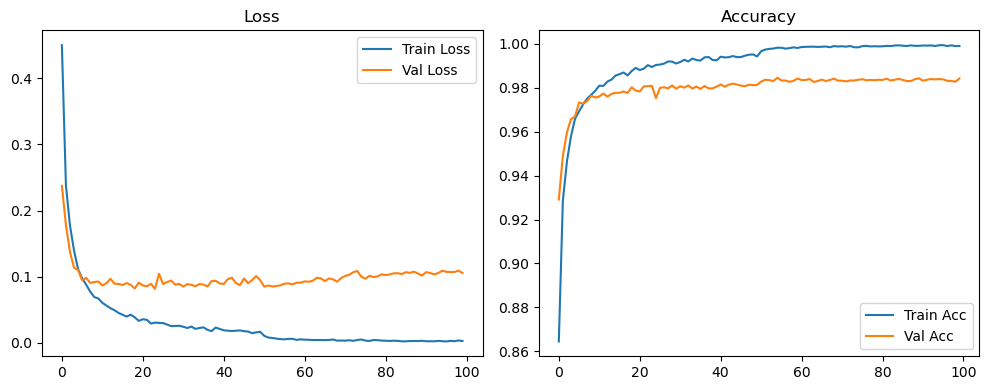

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6711, Acc: 0.7870 | Val Loss: 0.2904, Acc: 0.9153


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3817, Acc: 0.8857 | Val Loss: 0.2098, Acc: 0.9382


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2984, Acc: 0.9124 | Val Loss: 0.1699, Acc: 0.9487


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2544, Acc: 0.9245 | Val Loss: 0.1402, Acc: 0.9580


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2183, Acc: 0.9358 | Val Loss: 0.1321, Acc: 0.9606


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2029, Acc: 0.9387 | Val Loss: 0.1122, Acc: 0.9672


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1887, Acc: 0.9436 | Val Loss: 0.1117, Acc: 0.9663


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1771, Acc: 0.9481 | Val Loss: 0.1037, Acc: 0.9688


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1619, Acc: 0.9517 | Val Loss: 0.1023, Acc: 0.9708


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1547, Acc: 0.9534 | Val Loss: 0.0962, Acc: 0.9733


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1470, Acc: 0.9553 | Val Loss: 0.0981, Acc: 0.9711


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1409, Acc: 0.9572 | Val Loss: 0.0940, Acc: 0.9726


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1341, Acc: 0.9586 | Val Loss: 0.0916, Acc: 0.9744


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1336, Acc: 0.9590 | Val Loss: 0.0919, Acc: 0.9739


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1212, Acc: 0.9626 | Val Loss: 0.0849, Acc: 0.9755


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1262, Acc: 0.9610 | Val Loss: 0.0880, Acc: 0.9745


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1180, Acc: 0.9645 | Val Loss: 0.0839, Acc: 0.9756


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1137, Acc: 0.9652 | Val Loss: 0.0846, Acc: 0.9753


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1173, Acc: 0.9649 | Val Loss: 0.0801, Acc: 0.9760


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1078, Acc: 0.9667 | Val Loss: 0.0821, Acc: 0.9771


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1012, Acc: 0.9692 | Val Loss: 0.0834, Acc: 0.9768


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1042, Acc: 0.9677 | Val Loss: 0.0767, Acc: 0.9778


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0991, Acc: 0.9690 | Val Loss: 0.0807, Acc: 0.9770


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0949, Acc: 0.9710 | Val Loss: 0.0762, Acc: 0.9771


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0934, Acc: 0.9713 | Val Loss: 0.0790, Acc: 0.9777


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0896, Acc: 0.9724 | Val Loss: 0.0758, Acc: 0.9773


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0902, Acc: 0.9708 | Val Loss: 0.0775, Acc: 0.9776


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0883, Acc: 0.9721 | Val Loss: 0.0747, Acc: 0.9774


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0848, Acc: 0.9735 | Val Loss: 0.0738, Acc: 0.9791


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0805, Acc: 0.9745 | Val Loss: 0.0784, Acc: 0.9777


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0851, Acc: 0.9745 | Val Loss: 0.0750, Acc: 0.9784


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9762 | Val Loss: 0.0767, Acc: 0.9788


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9750 | Val Loss: 0.0714, Acc: 0.9791


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0779, Acc: 0.9754 | Val Loss: 0.0744, Acc: 0.9803


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9759 | Val Loss: 0.0718, Acc: 0.9788


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9761 | Val Loss: 0.0735, Acc: 0.9792


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0714, Acc: 0.9773 | Val Loss: 0.0759, Acc: 0.9788


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0739, Acc: 0.9772 | Val Loss: 0.0734, Acc: 0.9779


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9776 | Val Loss: 0.0739, Acc: 0.9786


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0677, Acc: 0.9787 | Val Loss: 0.0775, Acc: 0.9780


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0704, Acc: 0.9780 | Val Loss: 0.0713, Acc: 0.9784


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0665, Acc: 0.9788 | Val Loss: 0.0696, Acc: 0.9808


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0656, Acc: 0.9799 | Val Loss: 0.0735, Acc: 0.9796


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9786 | Val Loss: 0.0736, Acc: 0.9794


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0657, Acc: 0.9795 | Val Loss: 0.0743, Acc: 0.9792


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0666, Acc: 0.9790 | Val Loss: 0.0734, Acc: 0.9794


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9810 | Val Loss: 0.0758, Acc: 0.9804


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0620, Acc: 0.9804 | Val Loss: 0.0732, Acc: 0.9808


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0639, Acc: 0.9800 | Val Loss: 0.0725, Acc: 0.9795


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0604, Acc: 0.9821 | Val Loss: 0.0774, Acc: 0.9792


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0555, Acc: 0.9824 | Val Loss: 0.0733, Acc: 0.9794


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0507, Acc: 0.9839 | Val Loss: 0.0729, Acc: 0.9809


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0499, Acc: 0.9840 | Val Loss: 0.0721, Acc: 0.9801


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0452, Acc: 0.9853 | Val Loss: 0.0734, Acc: 0.9802


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0446, Acc: 0.9858 | Val Loss: 0.0735, Acc: 0.9807


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0421, Acc: 0.9864 | Val Loss: 0.0743, Acc: 0.9806


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0415, Acc: 0.9868 | Val Loss: 0.0741, Acc: 0.9807


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0392, Acc: 0.9871 | Val Loss: 0.0756, Acc: 0.9808


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0374, Acc: 0.9882 | Val Loss: 0.0760, Acc: 0.9800


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0406, Acc: 0.9869 | Val Loss: 0.0746, Acc: 0.9803


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0390, Acc: 0.9873 | Val Loss: 0.0746, Acc: 0.9807


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0387, Acc: 0.9873 | Val Loss: 0.0755, Acc: 0.9802


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0381, Acc: 0.9881 | Val Loss: 0.0766, Acc: 0.9799


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0390, Acc: 0.9874 | Val Loss: 0.0752, Acc: 0.9808


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0359, Acc: 0.9885 | Val Loss: 0.0764, Acc: 0.9801


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0365, Acc: 0.9886 | Val Loss: 0.0759, Acc: 0.9805


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0382, Acc: 0.9876 | Val Loss: 0.0758, Acc: 0.9802


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9888 | Val Loss: 0.0762, Acc: 0.9802


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9888 | Val Loss: 0.0745, Acc: 0.9807


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0345, Acc: 0.9894 | Val Loss: 0.0753, Acc: 0.9810


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0371, Acc: 0.9882 | Val Loss: 0.0756, Acc: 0.9813


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9889 | Val Loss: 0.0765, Acc: 0.9810


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0344, Acc: 0.9891 | Val Loss: 0.0758, Acc: 0.9811


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0346, Acc: 0.9884 | Val Loss: 0.0779, Acc: 0.9804


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0333, Acc: 0.9891 | Val Loss: 0.0761, Acc: 0.9804


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0328, Acc: 0.9887 | Val Loss: 0.0754, Acc: 0.9808


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9901 | Val Loss: 0.0771, Acc: 0.9806


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0333, Acc: 0.9891 | Val Loss: 0.0761, Acc: 0.9807


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0341, Acc: 0.9895 | Val Loss: 0.0753, Acc: 0.9812


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0353, Acc: 0.9891 | Val Loss: 0.0772, Acc: 0.9804


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9896 | Val Loss: 0.0772, Acc: 0.9805


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9901 | Val Loss: 0.0760, Acc: 0.9813


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9899 | Val Loss: 0.0779, Acc: 0.9807


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9894 | Val Loss: 0.0764, Acc: 0.9808


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0324, Acc: 0.9892 | Val Loss: 0.0774, Acc: 0.9808


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9904 | Val Loss: 0.0778, Acc: 0.9809


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9896 | Val Loss: 0.0751, Acc: 0.9812


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 0.0778, Acc: 0.9809


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9899 | Val Loss: 0.0772, Acc: 0.9810


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9905 | Val Loss: 0.0767, Acc: 0.9814


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9910 | Val Loss: 0.0807, Acc: 0.9813


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9911 | Val Loss: 0.0798, Acc: 0.9809


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0316, Acc: 0.9902 | Val Loss: 0.0784, Acc: 0.9812


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0297, Acc: 0.9902 | Val Loss: 0.0775, Acc: 0.9811


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9914 | Val Loss: 0.0776, Acc: 0.9818


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0281, Acc: 0.9907 | Val Loss: 0.0777, Acc: 0.9808


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0287, Acc: 0.9913 | Val Loss: 0.0773, Acc: 0.9812


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9901 | Val Loss: 0.0775, Acc: 0.9813


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9912 | Val Loss: 0.0784, Acc: 0.9813


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.0783, Acc: 0.9816


Final Test Loss: 0.0689 Accuracy: 0.9835


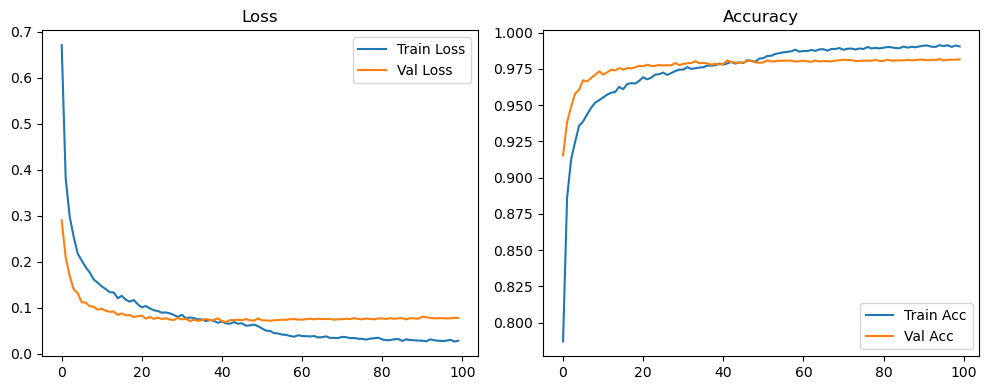

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3707, Acc: 0.8945 | Val Loss: 0.2493, Acc: 0.9269


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1844, Acc: 0.9431 | Val Loss: 0.1799, Acc: 0.9458


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1283, Acc: 0.9598 | Val Loss: 0.1467, Acc: 0.9565


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0900, Acc: 0.9719 | Val Loss: 0.1114, Acc: 0.9663


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0706, Acc: 0.9779 | Val Loss: 0.1271, Acc: 0.9612


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0594, Acc: 0.9808 | Val Loss: 0.1019, Acc: 0.9703


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0513, Acc: 0.9835 | Val Loss: 0.1267, Acc: 0.9632


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9856 | Val Loss: 0.0938, Acc: 0.9737


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9869 | Val Loss: 0.1068, Acc: 0.9718


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9894 | Val Loss: 0.1173, Acc: 0.9707


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9894 | Val Loss: 0.1068, Acc: 0.9723


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9900 | Val Loss: 0.1098, Acc: 0.9715


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9919 | Val Loss: 0.1292, Acc: 0.9703


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9918 | Val Loss: 0.1077, Acc: 0.9748


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9925 | Val Loss: 0.1272, Acc: 0.9712


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9930 | Val Loss: 0.1110, Acc: 0.9750


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.1183, Acc: 0.9742


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9943 | Val Loss: 0.1299, Acc: 0.9740


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9936 | Val Loss: 0.1196, Acc: 0.9740


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9955 | Val Loss: 0.0973, Acc: 0.9787


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.1214, Acc: 0.9751


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.1076, Acc: 0.9787


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9956 | Val Loss: 0.1189, Acc: 0.9774


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9953 | Val Loss: 0.1174, Acc: 0.9773


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.1385, Acc: 0.9760


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.1172, Acc: 0.9777


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1387, Acc: 0.9754


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.1331, Acc: 0.9773


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1292, Acc: 0.9769


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.1479, Acc: 0.9742


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1296, Acc: 0.9775


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9966 | Val Loss: 0.1213, Acc: 0.9776


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.1421, Acc: 0.9758


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1261, Acc: 0.9789


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1183, Acc: 0.9798


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9965 | Val Loss: 0.1247, Acc: 0.9781


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1261, Acc: 0.9783


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1198, Acc: 0.9791


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1359, Acc: 0.9773


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9965 | Val Loss: 0.1711, Acc: 0.9712


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.1267, Acc: 0.9789


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.1459, Acc: 0.9768


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1421, Acc: 0.9769


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1239, Acc: 0.9792


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1325, Acc: 0.9801


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.1305, Acc: 0.9790


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1475, Acc: 0.9774


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1280, Acc: 0.9798


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1394, Acc: 0.9790


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9980 | Val Loss: 0.1361, Acc: 0.9786


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1407, Acc: 0.9795


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1360, Acc: 0.9775


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1377, Acc: 0.9792


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1356, Acc: 0.9793


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1416, Acc: 0.9780


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1424, Acc: 0.9779


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1383, Acc: 0.9798


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1607, Acc: 0.9778


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1487, Acc: 0.9773


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1441, Acc: 0.9778


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9987 | Val Loss: 0.1428, Acc: 0.9801


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.1455, Acc: 0.9778


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1663, Acc: 0.9760


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1492, Acc: 0.9796


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1455, Acc: 0.9797


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9991 | Val Loss: 0.1448, Acc: 0.9798


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1516, Acc: 0.9798


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9975 | Val Loss: 0.1476, Acc: 0.9795


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9982 | Val Loss: 0.1375, Acc: 0.9792


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1329, Acc: 0.9796


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1561, Acc: 0.9773


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1385, Acc: 0.9810


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1409, Acc: 0.9795


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1403, Acc: 0.9800


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1353, Acc: 0.9812


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9988 | Val Loss: 0.1535, Acc: 0.9792


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1589, Acc: 0.9780


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1595, Acc: 0.9790


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1519, Acc: 0.9798


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1539, Acc: 0.9796


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1381, Acc: 0.9797


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1371, Acc: 0.9804


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1490, Acc: 0.9797


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1473, Acc: 0.9807


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1516, Acc: 0.9788


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1755, Acc: 0.9760


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1570, Acc: 0.9798


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1652, Acc: 0.9794


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1455, Acc: 0.9798


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.1615, Acc: 0.9786


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1607, Acc: 0.9789


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1535, Acc: 0.9796


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1501, Acc: 0.9800


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1622, Acc: 0.9791


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1648, Acc: 0.9780


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1617, Acc: 0.9782


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1551, Acc: 0.9789


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1539, Acc: 0.9803


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1636, Acc: 0.9784


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1463, Acc: 0.9820


Final Test Loss: 0.1245 Accuracy: 0.9826


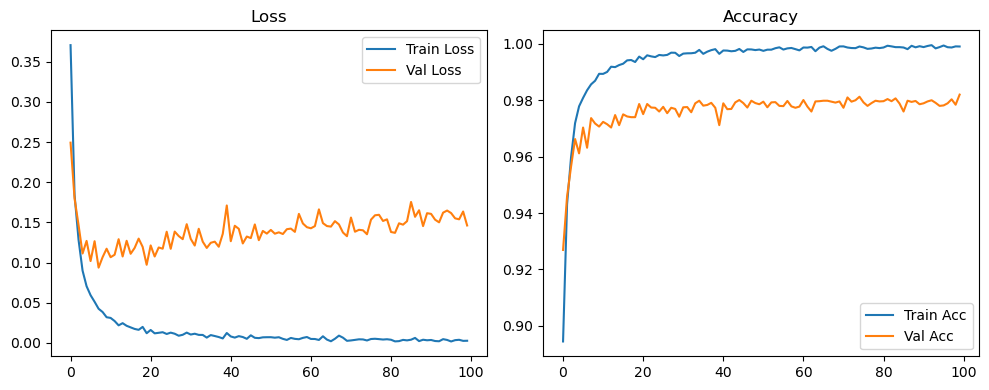

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4776, Acc: 0.8591 | Val Loss: 0.2741, Acc: 0.9189


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2729, Acc: 0.9179 | Val Loss: 0.1974, Acc: 0.9420


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2048, Acc: 0.9378 | Val Loss: 0.1564, Acc: 0.9542


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1609, Acc: 0.9503 | Val Loss: 0.1286, Acc: 0.9623


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1297, Acc: 0.9601 | Val Loss: 0.1144, Acc: 0.9667


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1136, Acc: 0.9640 | Val Loss: 0.1031, Acc: 0.9709


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0978, Acc: 0.9685 | Val Loss: 0.0964, Acc: 0.9715


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0858, Acc: 0.9725 | Val Loss: 0.0923, Acc: 0.9718


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0759, Acc: 0.9748 | Val Loss: 0.0954, Acc: 0.9736


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0738, Acc: 0.9760 | Val Loss: 0.0942, Acc: 0.9728


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0662, Acc: 0.9785 | Val Loss: 0.0921, Acc: 0.9743


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0620, Acc: 0.9795 | Val Loss: 0.0912, Acc: 0.9758


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0580, Acc: 0.9806 | Val Loss: 0.0876, Acc: 0.9772


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0511, Acc: 0.9831 | Val Loss: 0.0911, Acc: 0.9772


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0487, Acc: 0.9842 | Val Loss: 0.0914, Acc: 0.9770


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0470, Acc: 0.9846 | Val Loss: 0.0911, Acc: 0.9780


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9858 | Val Loss: 0.0847, Acc: 0.9792


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9856 | Val Loss: 0.1024, Acc: 0.9753


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9868 | Val Loss: 0.0899, Acc: 0.9778


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9874 | Val Loss: 0.0893, Acc: 0.9776


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9880 | Val Loss: 0.0954, Acc: 0.9768


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9878 | Val Loss: 0.0925, Acc: 0.9797


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9890 | Val Loss: 0.0914, Acc: 0.9797


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9897 | Val Loss: 0.0834, Acc: 0.9792


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9886 | Val Loss: 0.0953, Acc: 0.9776


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9902 | Val Loss: 0.0902, Acc: 0.9795


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9893 | Val Loss: 0.0850, Acc: 0.9799


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9915 | Val Loss: 0.0939, Acc: 0.9808


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9904 | Val Loss: 0.0891, Acc: 0.9811


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9916 | Val Loss: 0.0899, Acc: 0.9815


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9918 | Val Loss: 0.0994, Acc: 0.9802


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9919 | Val Loss: 0.0842, Acc: 0.9821


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9925 | Val Loss: 0.0992, Acc: 0.9797


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.0930, Acc: 0.9793


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9923 | Val Loss: 0.1001, Acc: 0.9792


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9930 | Val Loss: 0.0929, Acc: 0.9808


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9926 | Val Loss: 0.0924, Acc: 0.9808


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9925 | Val Loss: 0.0931, Acc: 0.9796


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9930 | Val Loss: 0.0988, Acc: 0.9808


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9933 | Val Loss: 0.0935, Acc: 0.9798


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9938 | Val Loss: 0.0945, Acc: 0.9816


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9935 | Val Loss: 0.1012, Acc: 0.9800


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9939 | Val Loss: 0.0971, Acc: 0.9814


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0956, Acc: 0.9802


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9933 | Val Loss: 0.0989, Acc: 0.9784


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9931 | Val Loss: 0.0966, Acc: 0.9807


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9940 | Val Loss: 0.0995, Acc: 0.9806


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9942 | Val Loss: 0.1012, Acc: 0.9793


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.1046, Acc: 0.9797


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.1035, Acc: 0.9798


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.0976, Acc: 0.9814


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9942 | Val Loss: 0.1071, Acc: 0.9797


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9942 | Val Loss: 0.0967, Acc: 0.9811


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.1017, Acc: 0.9803


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.1022, Acc: 0.9805


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.1022, Acc: 0.9809


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9948 | Val Loss: 0.0982, Acc: 0.9803


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9953 | Val Loss: 0.1014, Acc: 0.9813


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9957 | Val Loss: 0.1102, Acc: 0.9807


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9946 | Val Loss: 0.1182, Acc: 0.9804


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9942 | Val Loss: 0.1132, Acc: 0.9804


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.1082, Acc: 0.9804


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9951 | Val Loss: 0.1065, Acc: 0.9810


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9954 | Val Loss: 0.0979, Acc: 0.9816


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9955 | Val Loss: 0.1120, Acc: 0.9798


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1105, Acc: 0.9812


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.1090, Acc: 0.9812


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9959 | Val Loss: 0.1084, Acc: 0.9812


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.1048, Acc: 0.9819


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9955 | Val Loss: 0.1074, Acc: 0.9828


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 0.1092, Acc: 0.9818


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.1037, Acc: 0.9811


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.1040, Acc: 0.9820


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1091, Acc: 0.9809


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.1051, Acc: 0.9811


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.1069, Acc: 0.9809


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.1086, Acc: 0.9809


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.1070, Acc: 0.9812


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.1065, Acc: 0.9811


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.1149, Acc: 0.9808


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.1096, Acc: 0.9815


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.1091, Acc: 0.9812


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.1074, Acc: 0.9812


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1025, Acc: 0.9812


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.1045, Acc: 0.9808


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1104, Acc: 0.9811


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.1099, Acc: 0.9812


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.0978, Acc: 0.9828


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9970 | Val Loss: 0.0991, Acc: 0.9830


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1096, Acc: 0.9819


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.1027, Acc: 0.9822


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.1083, Acc: 0.9819


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1013, Acc: 0.9824


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1065, Acc: 0.9822


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.1051, Acc: 0.9822


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1043, Acc: 0.9816


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.1125, Acc: 0.9804


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1110, Acc: 0.9815


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.1100, Acc: 0.9803


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1053, Acc: 0.9810


Final Test Loss: 0.0890 Accuracy: 0.9845


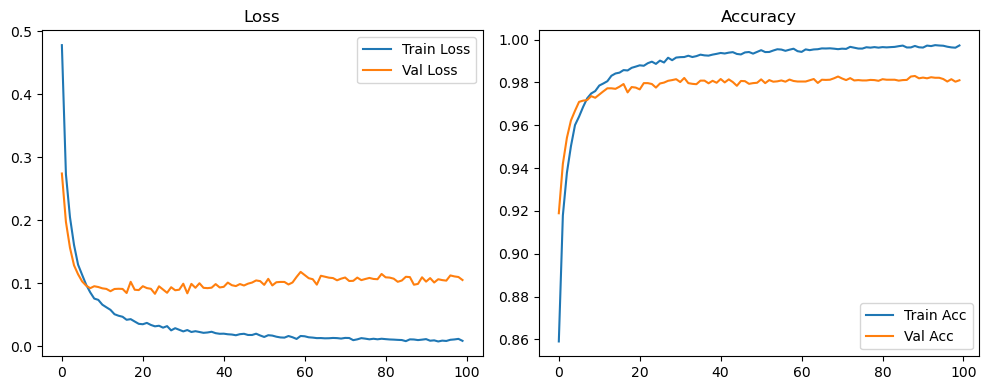

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.7381, Acc: 0.7648 | Val Loss: 0.3084, Acc: 0.9093


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.4300, Acc: 0.8692 | Val Loss: 0.2450, Acc: 0.9289


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.3477, Acc: 0.8956 | Val Loss: 0.2006, Acc: 0.9418


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2886, Acc: 0.9134 | Val Loss: 0.1680, Acc: 0.9497


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2532, Acc: 0.9234 | Val Loss: 0.1537, Acc: 0.9535


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.2289, Acc: 0.9312 | Val Loss: 0.1334, Acc: 0.9601


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.2145, Acc: 0.9366 | Val Loss: 0.1264, Acc: 0.9632


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1935, Acc: 0.9414 | Val Loss: 0.1171, Acc: 0.9660


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1832, Acc: 0.9443 | Val Loss: 0.1119, Acc: 0.9670


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1721, Acc: 0.9479 | Val Loss: 0.1089, Acc: 0.9689


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1605, Acc: 0.9500 | Val Loss: 0.1082, Acc: 0.9697


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1529, Acc: 0.9531 | Val Loss: 0.1040, Acc: 0.9712


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1456, Acc: 0.9556 | Val Loss: 0.1007, Acc: 0.9721


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1446, Acc: 0.9568 | Val Loss: 0.1044, Acc: 0.9689


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1345, Acc: 0.9593 | Val Loss: 0.0943, Acc: 0.9722


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1390, Acc: 0.9577 | Val Loss: 0.0927, Acc: 0.9741


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1292, Acc: 0.9608 | Val Loss: 0.0886, Acc: 0.9742


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1256, Acc: 0.9614 | Val Loss: 0.0882, Acc: 0.9748


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1239, Acc: 0.9608 | Val Loss: 0.0863, Acc: 0.9741


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.1167, Acc: 0.9640 | Val Loss: 0.0904, Acc: 0.9741


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.1123, Acc: 0.9651 | Val Loss: 0.0871, Acc: 0.9762


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.1147, Acc: 0.9648 | Val Loss: 0.0794, Acc: 0.9773


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.1075, Acc: 0.9666 | Val Loss: 0.0833, Acc: 0.9772


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.1034, Acc: 0.9681 | Val Loss: 0.0803, Acc: 0.9771


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.1015, Acc: 0.9692 | Val Loss: 0.0842, Acc: 0.9769


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0974, Acc: 0.9698 | Val Loss: 0.0815, Acc: 0.9766


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0986, Acc: 0.9691 | Val Loss: 0.0826, Acc: 0.9767


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0966, Acc: 0.9700 | Val Loss: 0.0795, Acc: 0.9772


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0940, Acc: 0.9706 | Val Loss: 0.0771, Acc: 0.9784


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0919, Acc: 0.9719 | Val Loss: 0.0866, Acc: 0.9756


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0910, Acc: 0.9715 | Val Loss: 0.0811, Acc: 0.9778


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0862, Acc: 0.9735 | Val Loss: 0.0810, Acc: 0.9778


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0880, Acc: 0.9726 | Val Loss: 0.0768, Acc: 0.9779


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0831, Acc: 0.9749 | Val Loss: 0.0789, Acc: 0.9797


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0799, Acc: 0.9741 | Val Loss: 0.0831, Acc: 0.9782


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0860, Acc: 0.9728 | Val Loss: 0.0796, Acc: 0.9782


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0815, Acc: 0.9750 | Val Loss: 0.0781, Acc: 0.9778


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0816, Acc: 0.9739 | Val Loss: 0.0824, Acc: 0.9779


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0794, Acc: 0.9747 | Val Loss: 0.0793, Acc: 0.9775


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0778, Acc: 0.9759 | Val Loss: 0.0799, Acc: 0.9778


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0755, Acc: 0.9760 | Val Loss: 0.0813, Acc: 0.9782


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0755, Acc: 0.9763 | Val Loss: 0.0768, Acc: 0.9798


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0717, Acc: 0.9776 | Val Loss: 0.0796, Acc: 0.9797


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0761, Acc: 0.9762 | Val Loss: 0.0812, Acc: 0.9793


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0717, Acc: 0.9775 | Val Loss: 0.0783, Acc: 0.9782


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0725, Acc: 0.9770 | Val Loss: 0.0833, Acc: 0.9791


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0697, Acc: 0.9783 | Val Loss: 0.0783, Acc: 0.9789


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0689, Acc: 0.9781 | Val Loss: 0.0835, Acc: 0.9784


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0697, Acc: 0.9779 | Val Loss: 0.0779, Acc: 0.9796


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0671, Acc: 0.9789 | Val Loss: 0.0794, Acc: 0.9802


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0672, Acc: 0.9789 | Val Loss: 0.0795, Acc: 0.9803


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0653, Acc: 0.9789 | Val Loss: 0.0803, Acc: 0.9799


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0661, Acc: 0.9789 | Val Loss: 0.0766, Acc: 0.9797


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0646, Acc: 0.9790 | Val Loss: 0.0802, Acc: 0.9798


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0619, Acc: 0.9804 | Val Loss: 0.0826, Acc: 0.9797


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0600, Acc: 0.9809 | Val Loss: 0.0791, Acc: 0.9809


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0635, Acc: 0.9791 | Val Loss: 0.0814, Acc: 0.9788


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0608, Acc: 0.9801 | Val Loss: 0.0760, Acc: 0.9800


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0592, Acc: 0.9803 | Val Loss: 0.0770, Acc: 0.9805


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0590, Acc: 0.9805 | Val Loss: 0.0784, Acc: 0.9801


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0574, Acc: 0.9820 | Val Loss: 0.0821, Acc: 0.9798


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0589, Acc: 0.9808 | Val Loss: 0.0798, Acc: 0.9793


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0564, Acc: 0.9819 | Val Loss: 0.0787, Acc: 0.9798


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0602, Acc: 0.9810 | Val Loss: 0.0781, Acc: 0.9791


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0554, Acc: 0.9828 | Val Loss: 0.0757, Acc: 0.9802


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0554, Acc: 0.9820 | Val Loss: 0.0749, Acc: 0.9806


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0579, Acc: 0.9820 | Val Loss: 0.0765, Acc: 0.9801


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0532, Acc: 0.9827 | Val Loss: 0.0773, Acc: 0.9813


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0538, Acc: 0.9826 | Val Loss: 0.0754, Acc: 0.9807


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0523, Acc: 0.9835 | Val Loss: 0.0782, Acc: 0.9808


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0533, Acc: 0.9825 | Val Loss: 0.0810, Acc: 0.9793


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9831 | Val Loss: 0.0802, Acc: 0.9797


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0525, Acc: 0.9827 | Val Loss: 0.0797, Acc: 0.9806


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0531, Acc: 0.9832 | Val Loss: 0.0783, Acc: 0.9803


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0548, Acc: 0.9828 | Val Loss: 0.0748, Acc: 0.9801


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0521, Acc: 0.9835 | Val Loss: 0.0763, Acc: 0.9798


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0478, Acc: 0.9841 | Val Loss: 0.0773, Acc: 0.9798


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0496, Acc: 0.9842 | Val Loss: 0.0781, Acc: 0.9802


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0523, Acc: 0.9834 | Val Loss: 0.0751, Acc: 0.9807


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0491, Acc: 0.9843 | Val Loss: 0.0799, Acc: 0.9801


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0494, Acc: 0.9843 | Val Loss: 0.0802, Acc: 0.9790


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0469, Acc: 0.9851 | Val Loss: 0.0799, Acc: 0.9798


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0495, Acc: 0.9841 | Val Loss: 0.0789, Acc: 0.9802


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0464, Acc: 0.9857 | Val Loss: 0.0797, Acc: 0.9806


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9847 | Val Loss: 0.0797, Acc: 0.9804


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0448, Acc: 0.9859 | Val Loss: 0.0787, Acc: 0.9800


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0468, Acc: 0.9849 | Val Loss: 0.0785, Acc: 0.9807


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0470, Acc: 0.9852 | Val Loss: 0.0780, Acc: 0.9818


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0447, Acc: 0.9850 | Val Loss: 0.0786, Acc: 0.9802


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0444, Acc: 0.9862 | Val Loss: 0.0817, Acc: 0.9807


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0459, Acc: 0.9851 | Val Loss: 0.0822, Acc: 0.9807


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0448, Acc: 0.9861 | Val Loss: 0.0838, Acc: 0.9806


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0455, Acc: 0.9853 | Val Loss: 0.0788, Acc: 0.9809


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0431, Acc: 0.9866 | Val Loss: 0.0836, Acc: 0.9804


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0444, Acc: 0.9858 | Val Loss: 0.0794, Acc: 0.9810


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9867 | Val Loss: 0.0824, Acc: 0.9818


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0440, Acc: 0.9855 | Val Loss: 0.0794, Acc: 0.9813


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9870 | Val Loss: 0.0801, Acc: 0.9810


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0430, Acc: 0.9856 | Val Loss: 0.0787, Acc: 0.9811


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9866 | Val Loss: 0.0781, Acc: 0.9808


Final Test Loss: 0.0680 Accuracy: 0.9829


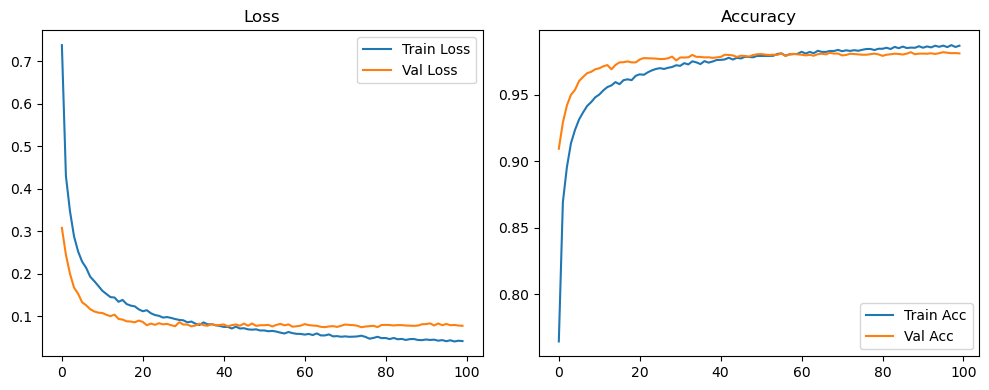

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3707, Acc: 0.8945 | Val Loss: 0.2493, Acc: 0.9269


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1844, Acc: 0.9431 | Val Loss: 0.1799, Acc: 0.9458


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1283, Acc: 0.9598 | Val Loss: 0.1467, Acc: 0.9565


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0900, Acc: 0.9719 | Val Loss: 0.1114, Acc: 0.9663


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0706, Acc: 0.9779 | Val Loss: 0.1271, Acc: 0.9612


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0594, Acc: 0.9808 | Val Loss: 0.1019, Acc: 0.9703


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0513, Acc: 0.9835 | Val Loss: 0.1267, Acc: 0.9632


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9856 | Val Loss: 0.0938, Acc: 0.9737


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9869 | Val Loss: 0.1068, Acc: 0.9718


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9894 | Val Loss: 0.1173, Acc: 0.9707


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9894 | Val Loss: 0.1068, Acc: 0.9723


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9900 | Val Loss: 0.1098, Acc: 0.9715


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9919 | Val Loss: 0.1292, Acc: 0.9703


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9918 | Val Loss: 0.1077, Acc: 0.9748


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9925 | Val Loss: 0.1272, Acc: 0.9712


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9930 | Val Loss: 0.1110, Acc: 0.9750


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.1183, Acc: 0.9742


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9943 | Val Loss: 0.1299, Acc: 0.9740


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9936 | Val Loss: 0.1196, Acc: 0.9740


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9955 | Val Loss: 0.0973, Acc: 0.9787


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.1214, Acc: 0.9751


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.1076, Acc: 0.9787


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9956 | Val Loss: 0.1189, Acc: 0.9774


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9953 | Val Loss: 0.1174, Acc: 0.9773


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.1385, Acc: 0.9760


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.1172, Acc: 0.9777


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1387, Acc: 0.9754


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.1331, Acc: 0.9773


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1292, Acc: 0.9769


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.1479, Acc: 0.9742


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1296, Acc: 0.9775


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9966 | Val Loss: 0.1213, Acc: 0.9776


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.1421, Acc: 0.9758


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1261, Acc: 0.9789


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1183, Acc: 0.9798


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9965 | Val Loss: 0.1247, Acc: 0.9781


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1261, Acc: 0.9783


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1198, Acc: 0.9791


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1359, Acc: 0.9773


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9965 | Val Loss: 0.1711, Acc: 0.9712


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.1267, Acc: 0.9789


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.1459, Acc: 0.9768


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1421, Acc: 0.9769


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1239, Acc: 0.9792


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1325, Acc: 0.9801


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.1305, Acc: 0.9790


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1475, Acc: 0.9774


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1280, Acc: 0.9798


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1394, Acc: 0.9790


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9980 | Val Loss: 0.1361, Acc: 0.9786


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1146, Acc: 0.9819


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1102, Acc: 0.9828


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1086, Acc: 0.9829


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1112, Acc: 0.9826


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1129, Acc: 0.9826


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1139, Acc: 0.9822


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1154, Acc: 0.9815


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1174, Acc: 0.9828


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1192, Acc: 0.9826


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1186, Acc: 0.9808


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1201, Acc: 0.9821


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1302, Acc: 0.9822


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1314, Acc: 0.9812


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1411, Acc: 0.9808


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1298, Acc: 0.9816


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1249, Acc: 0.9822


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1296, Acc: 0.9825


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1347, Acc: 0.9826


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1318, Acc: 0.9825


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1332, Acc: 0.9815


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1309, Acc: 0.9817


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1441, Acc: 0.9799


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1287, Acc: 0.9820


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1277, Acc: 0.9828


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1757, Acc: 0.9780


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1393, Acc: 0.9817


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1357, Acc: 0.9807


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1317, Acc: 0.9812


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1356, Acc: 0.9815


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1372, Acc: 0.9824


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1338, Acc: 0.9822


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1295, Acc: 0.9825


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1315, Acc: 0.9825


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1287, Acc: 0.9822


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1254, Acc: 0.9828


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1230, Acc: 0.9824


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1269, Acc: 0.9818


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1254, Acc: 0.9825


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1274, Acc: 0.9822


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1249, Acc: 0.9829


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1271, Acc: 0.9829


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1302, Acc: 0.9832


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1224, Acc: 0.9832


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1283, Acc: 0.9829


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1357, Acc: 0.9821


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1299, Acc: 0.9828


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1283, Acc: 0.9822


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1383, Acc: 0.9816


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1269, Acc: 0.9831


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1294, Acc: 0.9832


Final Test Loss: 0.1204 Accuracy: 0.9844


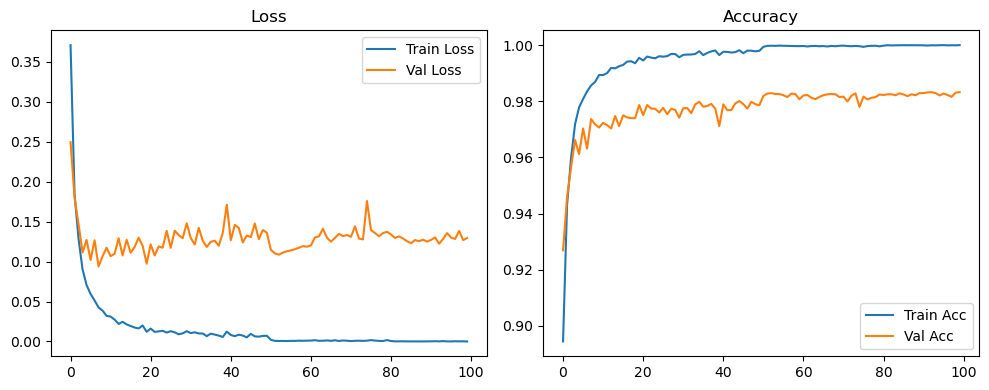

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4776, Acc: 0.8591 | Val Loss: 0.2741, Acc: 0.9189


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2729, Acc: 0.9179 | Val Loss: 0.1974, Acc: 0.9420


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2048, Acc: 0.9378 | Val Loss: 0.1564, Acc: 0.9542


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1609, Acc: 0.9503 | Val Loss: 0.1286, Acc: 0.9623


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1297, Acc: 0.9601 | Val Loss: 0.1144, Acc: 0.9667


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1136, Acc: 0.9640 | Val Loss: 0.1031, Acc: 0.9709


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0978, Acc: 0.9685 | Val Loss: 0.0964, Acc: 0.9715


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0858, Acc: 0.9725 | Val Loss: 0.0923, Acc: 0.9718


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0759, Acc: 0.9748 | Val Loss: 0.0954, Acc: 0.9736


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0738, Acc: 0.9760 | Val Loss: 0.0942, Acc: 0.9728


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0662, Acc: 0.9785 | Val Loss: 0.0921, Acc: 0.9743


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0620, Acc: 0.9795 | Val Loss: 0.0912, Acc: 0.9758


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0580, Acc: 0.9806 | Val Loss: 0.0876, Acc: 0.9772


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0511, Acc: 0.9831 | Val Loss: 0.0911, Acc: 0.9772


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0487, Acc: 0.9842 | Val Loss: 0.0914, Acc: 0.9770


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0470, Acc: 0.9846 | Val Loss: 0.0911, Acc: 0.9780


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9858 | Val Loss: 0.0847, Acc: 0.9792


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9856 | Val Loss: 0.1024, Acc: 0.9753


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9868 | Val Loss: 0.0899, Acc: 0.9778


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9874 | Val Loss: 0.0893, Acc: 0.9776


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9880 | Val Loss: 0.0954, Acc: 0.9768


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9878 | Val Loss: 0.0925, Acc: 0.9797


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9890 | Val Loss: 0.0914, Acc: 0.9797


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9897 | Val Loss: 0.0834, Acc: 0.9792


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9886 | Val Loss: 0.0953, Acc: 0.9776


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9902 | Val Loss: 0.0902, Acc: 0.9795


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9893 | Val Loss: 0.0850, Acc: 0.9799


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9915 | Val Loss: 0.0939, Acc: 0.9808


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9904 | Val Loss: 0.0891, Acc: 0.9811


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9916 | Val Loss: 0.0899, Acc: 0.9815


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9918 | Val Loss: 0.0994, Acc: 0.9802


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9919 | Val Loss: 0.0842, Acc: 0.9821


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9925 | Val Loss: 0.0992, Acc: 0.9797


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.0930, Acc: 0.9793


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9923 | Val Loss: 0.1001, Acc: 0.9792


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9930 | Val Loss: 0.0929, Acc: 0.9808


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9926 | Val Loss: 0.0924, Acc: 0.9808


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9925 | Val Loss: 0.0931, Acc: 0.9796


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9930 | Val Loss: 0.0988, Acc: 0.9808


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9933 | Val Loss: 0.0935, Acc: 0.9798


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9938 | Val Loss: 0.0945, Acc: 0.9816


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9935 | Val Loss: 0.1012, Acc: 0.9800


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9939 | Val Loss: 0.0971, Acc: 0.9814


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0956, Acc: 0.9802


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9933 | Val Loss: 0.0989, Acc: 0.9784


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9931 | Val Loss: 0.0966, Acc: 0.9807


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9940 | Val Loss: 0.0995, Acc: 0.9806


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9942 | Val Loss: 0.1012, Acc: 0.9793


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.1046, Acc: 0.9797


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.1035, Acc: 0.9798


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0905, Acc: 0.9823


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0948, Acc: 0.9823


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9975 | Val Loss: 0.0913, Acc: 0.9822


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0928, Acc: 0.9831


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0953, Acc: 0.9812


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.0946, Acc: 0.9830


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.0981, Acc: 0.9814


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.0988, Acc: 0.9818


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1005, Acc: 0.9826


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1058, Acc: 0.9820


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9975 | Val Loss: 0.1024, Acc: 0.9832


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1011, Acc: 0.9838


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.1005, Acc: 0.9832


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1042, Acc: 0.9832


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1076, Acc: 0.9824


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1073, Acc: 0.9820


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1106, Acc: 0.9821


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1003, Acc: 0.9832


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1042, Acc: 0.9831


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1050, Acc: 0.9827


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1064, Acc: 0.9830


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1139, Acc: 0.9815


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9980 | Val Loss: 0.1105, Acc: 0.9820


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1119, Acc: 0.9822


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1047, Acc: 0.9831


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1084, Acc: 0.9827


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.1091, Acc: 0.9819


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1074, Acc: 0.9818


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1066, Acc: 0.9832


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1097, Acc: 0.9825


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1034, Acc: 0.9825


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1034, Acc: 0.9832


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1063, Acc: 0.9828


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1087, Acc: 0.9832


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1047, Acc: 0.9826


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1056, Acc: 0.9826


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1057, Acc: 0.9827


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1058, Acc: 0.9832


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1007, Acc: 0.9835


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1040, Acc: 0.9835


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1077, Acc: 0.9831


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1060, Acc: 0.9838


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1026, Acc: 0.9841


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1049, Acc: 0.9841


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1080, Acc: 0.9834


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1063, Acc: 0.9833


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1064, Acc: 0.9833


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1069, Acc: 0.9834


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1131, Acc: 0.9831


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1109, Acc: 0.9834


Final Test Loss: 0.0933 Accuracy: 0.9847


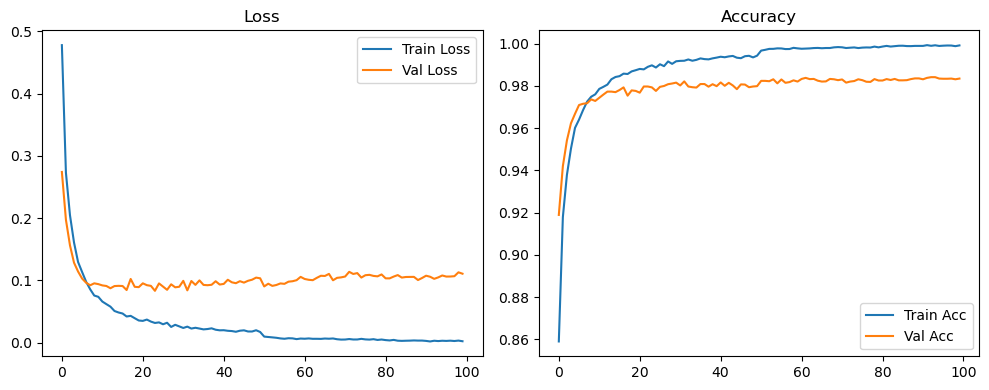

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.7381, Acc: 0.7648 | Val Loss: 0.3084, Acc: 0.9093


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.4300, Acc: 0.8692 | Val Loss: 0.2450, Acc: 0.9289


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.3477, Acc: 0.8956 | Val Loss: 0.2006, Acc: 0.9418


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2886, Acc: 0.9134 | Val Loss: 0.1680, Acc: 0.9497


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2532, Acc: 0.9234 | Val Loss: 0.1537, Acc: 0.9535


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.2289, Acc: 0.9312 | Val Loss: 0.1334, Acc: 0.9601


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.2145, Acc: 0.9366 | Val Loss: 0.1264, Acc: 0.9632


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1935, Acc: 0.9414 | Val Loss: 0.1171, Acc: 0.9660


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1832, Acc: 0.9443 | Val Loss: 0.1119, Acc: 0.9670


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1721, Acc: 0.9479 | Val Loss: 0.1089, Acc: 0.9689


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1605, Acc: 0.9500 | Val Loss: 0.1082, Acc: 0.9697


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1529, Acc: 0.9531 | Val Loss: 0.1040, Acc: 0.9712


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1456, Acc: 0.9556 | Val Loss: 0.1007, Acc: 0.9721


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1446, Acc: 0.9568 | Val Loss: 0.1044, Acc: 0.9689


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1345, Acc: 0.9593 | Val Loss: 0.0943, Acc: 0.9722


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1390, Acc: 0.9577 | Val Loss: 0.0927, Acc: 0.9741


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1292, Acc: 0.9608 | Val Loss: 0.0886, Acc: 0.9742


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1256, Acc: 0.9614 | Val Loss: 0.0882, Acc: 0.9748


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1239, Acc: 0.9608 | Val Loss: 0.0863, Acc: 0.9741


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.1167, Acc: 0.9640 | Val Loss: 0.0904, Acc: 0.9741


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.1123, Acc: 0.9651 | Val Loss: 0.0871, Acc: 0.9762


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.1147, Acc: 0.9648 | Val Loss: 0.0794, Acc: 0.9773


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.1075, Acc: 0.9666 | Val Loss: 0.0833, Acc: 0.9772


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.1034, Acc: 0.9681 | Val Loss: 0.0803, Acc: 0.9771


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.1015, Acc: 0.9692 | Val Loss: 0.0842, Acc: 0.9769


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0974, Acc: 0.9698 | Val Loss: 0.0815, Acc: 0.9766


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0986, Acc: 0.9691 | Val Loss: 0.0826, Acc: 0.9767


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0966, Acc: 0.9700 | Val Loss: 0.0795, Acc: 0.9772


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0940, Acc: 0.9706 | Val Loss: 0.0771, Acc: 0.9784


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0919, Acc: 0.9719 | Val Loss: 0.0866, Acc: 0.9756


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0910, Acc: 0.9715 | Val Loss: 0.0811, Acc: 0.9778


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0862, Acc: 0.9735 | Val Loss: 0.0810, Acc: 0.9778


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0880, Acc: 0.9726 | Val Loss: 0.0768, Acc: 0.9779


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0831, Acc: 0.9749 | Val Loss: 0.0789, Acc: 0.9797


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0799, Acc: 0.9741 | Val Loss: 0.0831, Acc: 0.9782


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0860, Acc: 0.9728 | Val Loss: 0.0796, Acc: 0.9782


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0815, Acc: 0.9750 | Val Loss: 0.0781, Acc: 0.9778


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0816, Acc: 0.9739 | Val Loss: 0.0824, Acc: 0.9779


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0794, Acc: 0.9747 | Val Loss: 0.0793, Acc: 0.9775


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0778, Acc: 0.9759 | Val Loss: 0.0799, Acc: 0.9778


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0755, Acc: 0.9760 | Val Loss: 0.0813, Acc: 0.9782


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0755, Acc: 0.9763 | Val Loss: 0.0768, Acc: 0.9798


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0717, Acc: 0.9776 | Val Loss: 0.0796, Acc: 0.9797


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0761, Acc: 0.9762 | Val Loss: 0.0812, Acc: 0.9793


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0717, Acc: 0.9775 | Val Loss: 0.0783, Acc: 0.9782


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0725, Acc: 0.9770 | Val Loss: 0.0833, Acc: 0.9791


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0697, Acc: 0.9783 | Val Loss: 0.0783, Acc: 0.9789


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0689, Acc: 0.9781 | Val Loss: 0.0835, Acc: 0.9784


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0697, Acc: 0.9779 | Val Loss: 0.0779, Acc: 0.9796


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0671, Acc: 0.9789 | Val Loss: 0.0794, Acc: 0.9802


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0593, Acc: 0.9815 | Val Loss: 0.0761, Acc: 0.9808


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0548, Acc: 0.9834 | Val Loss: 0.0782, Acc: 0.9810


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0537, Acc: 0.9831 | Val Loss: 0.0752, Acc: 0.9811


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0513, Acc: 0.9834 | Val Loss: 0.0761, Acc: 0.9815


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0494, Acc: 0.9840 | Val Loss: 0.0776, Acc: 0.9813


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0465, Acc: 0.9854 | Val Loss: 0.0769, Acc: 0.9812


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0502, Acc: 0.9843 | Val Loss: 0.0791, Acc: 0.9808


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0466, Acc: 0.9848 | Val Loss: 0.0775, Acc: 0.9803


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0459, Acc: 0.9849 | Val Loss: 0.0795, Acc: 0.9804


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0449, Acc: 0.9853 | Val Loss: 0.0788, Acc: 0.9812


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0433, Acc: 0.9860 | Val Loss: 0.0806, Acc: 0.9814


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0453, Acc: 0.9854 | Val Loss: 0.0801, Acc: 0.9813


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0441, Acc: 0.9859 | Val Loss: 0.0807, Acc: 0.9802


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0463, Acc: 0.9850 | Val Loss: 0.0807, Acc: 0.9802


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0438, Acc: 0.9868 | Val Loss: 0.0797, Acc: 0.9809


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0430, Acc: 0.9863 | Val Loss: 0.0785, Acc: 0.9811


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0459, Acc: 0.9854 | Val Loss: 0.0791, Acc: 0.9805


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0421, Acc: 0.9865 | Val Loss: 0.0781, Acc: 0.9812


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9867 | Val Loss: 0.0788, Acc: 0.9802


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9863 | Val Loss: 0.0792, Acc: 0.9806


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9862 | Val Loss: 0.0821, Acc: 0.9803


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0406, Acc: 0.9869 | Val Loss: 0.0833, Acc: 0.9803


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0421, Acc: 0.9868 | Val Loss: 0.0808, Acc: 0.9807


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0421, Acc: 0.9869 | Val Loss: 0.0797, Acc: 0.9804


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0432, Acc: 0.9862 | Val Loss: 0.0790, Acc: 0.9810


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0418, Acc: 0.9867 | Val Loss: 0.0775, Acc: 0.9803


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0377, Acc: 0.9876 | Val Loss: 0.0790, Acc: 0.9809


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0387, Acc: 0.9879 | Val Loss: 0.0794, Acc: 0.9805


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0412, Acc: 0.9865 | Val Loss: 0.0788, Acc: 0.9807


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0403, Acc: 0.9872 | Val Loss: 0.0804, Acc: 0.9808


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0380, Acc: 0.9878 | Val Loss: 0.0798, Acc: 0.9807


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0357, Acc: 0.9892 | Val Loss: 0.0795, Acc: 0.9812


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0355, Acc: 0.9889 | Val Loss: 0.0825, Acc: 0.9801


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0347, Acc: 0.9894 | Val Loss: 0.0796, Acc: 0.9812


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0346, Acc: 0.9890 | Val Loss: 0.0808, Acc: 0.9807


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0347, Acc: 0.9888 | Val Loss: 0.0803, Acc: 0.9807


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0343, Acc: 0.9890 | Val Loss: 0.0804, Acc: 0.9810


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0344, Acc: 0.9887 | Val Loss: 0.0798, Acc: 0.9808


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9887 | Val Loss: 0.0803, Acc: 0.9809


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0326, Acc: 0.9893 | Val Loss: 0.0813, Acc: 0.9808


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0336, Acc: 0.9893 | Val Loss: 0.0841, Acc: 0.9806


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9898 | Val Loss: 0.0839, Acc: 0.9805


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0322, Acc: 0.9890 | Val Loss: 0.0840, Acc: 0.9811


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9898 | Val Loss: 0.0821, Acc: 0.9805


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9896 | Val Loss: 0.0839, Acc: 0.9818


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9910 | Val Loss: 0.0842, Acc: 0.9812


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0323, Acc: 0.9892 | Val Loss: 0.0844, Acc: 0.9809


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9901 | Val Loss: 0.0847, Acc: 0.9808


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0324, Acc: 0.9898 | Val Loss: 0.0834, Acc: 0.9813


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0301, Acc: 0.9903 | Val Loss: 0.0839, Acc: 0.9809


Final Test Loss: 0.0700 Accuracy: 0.9832


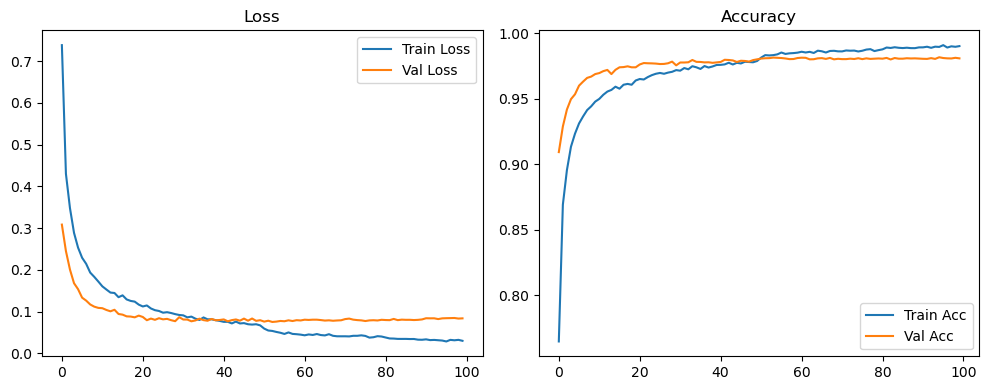

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.4192, Acc: 0.8934 | Val Loss: 0.2665, Acc: 0.9226


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2050, Acc: 0.9386 | Val Loss: 0.2000, Acc: 0.9400


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1483, Acc: 0.9543 | Val Loss: 0.1598, Acc: 0.9526


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1078, Acc: 0.9670 | Val Loss: 0.1279, Acc: 0.9587


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0835, Acc: 0.9739 | Val Loss: 0.1233, Acc: 0.9609


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0692, Acc: 0.9781 | Val Loss: 0.1101, Acc: 0.9667


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0593, Acc: 0.9805 | Val Loss: 0.1378, Acc: 0.9614


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0494, Acc: 0.9840 | Val Loss: 0.0914, Acc: 0.9718


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0424, Acc: 0.9861 | Val Loss: 0.0952, Acc: 0.9728


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0346, Acc: 0.9881 | Val Loss: 0.1175, Acc: 0.9683


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9897 | Val Loss: 0.0929, Acc: 0.9739


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9894 | Val Loss: 0.1000, Acc: 0.9724


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9915 | Val Loss: 0.1058, Acc: 0.9711


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9917 | Val Loss: 0.1023, Acc: 0.9738


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9925 | Val Loss: 0.1029, Acc: 0.9742


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.0982, Acc: 0.9742


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.1041, Acc: 0.9727


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9938 | Val Loss: 0.1067, Acc: 0.9738


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9932 | Val Loss: 0.1119, Acc: 0.9736


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.0983, Acc: 0.9764


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.0983, Acc: 0.9757


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9943 | Val Loss: 0.1005, Acc: 0.9765


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1037, Acc: 0.9768


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.1119, Acc: 0.9738


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.1046, Acc: 0.9762


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.1033, Acc: 0.9769


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9956 | Val Loss: 0.1100, Acc: 0.9754


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1065, Acc: 0.9769


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1142, Acc: 0.9753


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.1186, Acc: 0.9762


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.1102, Acc: 0.9763


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1241, Acc: 0.9735


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1219, Acc: 0.9756


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1130, Acc: 0.9764


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.1147, Acc: 0.9771


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.1026, Acc: 0.9797


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9975 | Val Loss: 0.1084, Acc: 0.9775


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1342, Acc: 0.9736


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1205, Acc: 0.9757


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.1115, Acc: 0.9793


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9970 | Val Loss: 0.1147, Acc: 0.9775


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1163, Acc: 0.9785


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.1217, Acc: 0.9769


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9975 | Val Loss: 0.1117, Acc: 0.9788


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1175, Acc: 0.9777


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1187, Acc: 0.9765


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1218, Acc: 0.9778


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1123, Acc: 0.9774


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1233, Acc: 0.9772


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.1206, Acc: 0.9764


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1449, Acc: 0.9753


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9983 | Val Loss: 0.1317, Acc: 0.9765


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1122, Acc: 0.9785


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1256, Acc: 0.9785


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1275, Acc: 0.9776


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1238, Acc: 0.9778


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1248, Acc: 0.9772


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1372, Acc: 0.9760


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1425, Acc: 0.9753


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1159, Acc: 0.9806


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1136, Acc: 0.9782


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1244, Acc: 0.9783


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1266, Acc: 0.9790


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1246, Acc: 0.9775


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1269, Acc: 0.9777


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1343, Acc: 0.9773


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1425, Acc: 0.9767


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1271, Acc: 0.9795


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.1310, Acc: 0.9784


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1319, Acc: 0.9771


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.1459, Acc: 0.9762


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1415, Acc: 0.9786


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1352, Acc: 0.9788


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1636, Acc: 0.9752


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1359, Acc: 0.9786


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1336, Acc: 0.9788


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1248, Acc: 0.9804


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1353, Acc: 0.9792


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1325, Acc: 0.9796


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1356, Acc: 0.9784


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1230, Acc: 0.9800


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1192, Acc: 0.9814


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1444, Acc: 0.9772


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1312, Acc: 0.9791


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1380, Acc: 0.9788


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1421, Acc: 0.9781


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1232, Acc: 0.9812


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1451, Acc: 0.9782


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1426, Acc: 0.9797


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1246, Acc: 0.9805


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1430, Acc: 0.9768


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1410, Acc: 0.9787


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1281, Acc: 0.9798


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1398, Acc: 0.9788


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.1401, Acc: 0.9774


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1453, Acc: 0.9795


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1384, Acc: 0.9793


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1326, Acc: 0.9796


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1516, Acc: 0.9777


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1412, Acc: 0.9788


Final Test Loss: 0.1182 Accuracy: 0.9821


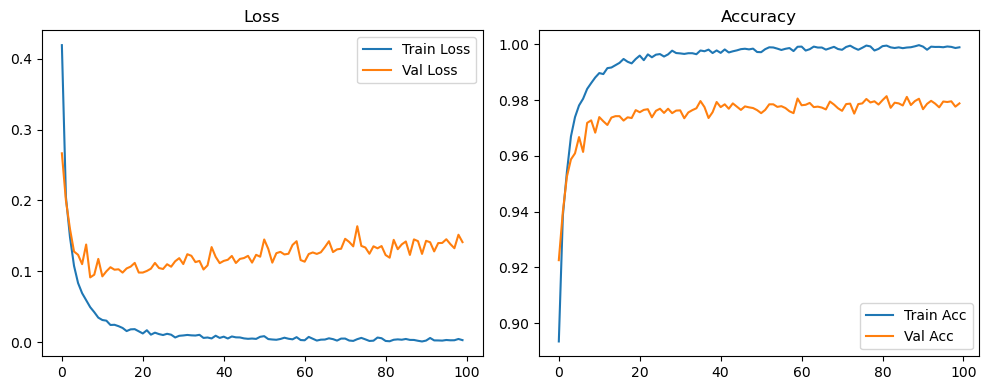

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.5552, Acc: 0.8521 | Val Loss: 0.2981, Acc: 0.9115


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.3177, Acc: 0.9040 | Val Loss: 0.2339, Acc: 0.9308


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.2559, Acc: 0.9230 | Val Loss: 0.1922, Acc: 0.9453


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.2076, Acc: 0.9363 | Val Loss: 0.1615, Acc: 0.9513


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1711, Acc: 0.9478 | Val Loss: 0.1441, Acc: 0.9573


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1512, Acc: 0.9545 | Val Loss: 0.1237, Acc: 0.9634


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1331, Acc: 0.9590 | Val Loss: 0.1142, Acc: 0.9663


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1162, Acc: 0.9633 | Val Loss: 0.1044, Acc: 0.9689


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1040, Acc: 0.9674 | Val Loss: 0.1030, Acc: 0.9701


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0974, Acc: 0.9684 | Val Loss: 0.1016, Acc: 0.9717


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0874, Acc: 0.9720 | Val Loss: 0.0967, Acc: 0.9717


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0802, Acc: 0.9741 | Val Loss: 0.0926, Acc: 0.9737


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0745, Acc: 0.9761 | Val Loss: 0.0919, Acc: 0.9752


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0687, Acc: 0.9774 | Val Loss: 0.0869, Acc: 0.9758


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0646, Acc: 0.9789 | Val Loss: 0.0849, Acc: 0.9780


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0600, Acc: 0.9798 | Val Loss: 0.0908, Acc: 0.9757


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0549, Acc: 0.9819 | Val Loss: 0.0849, Acc: 0.9764


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0554, Acc: 0.9812 | Val Loss: 0.0891, Acc: 0.9752


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0526, Acc: 0.9826 | Val Loss: 0.0853, Acc: 0.9771


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0459, Acc: 0.9845 | Val Loss: 0.0878, Acc: 0.9767


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0458, Acc: 0.9848 | Val Loss: 0.0869, Acc: 0.9768


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0452, Acc: 0.9850 | Val Loss: 0.0900, Acc: 0.9768


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0414, Acc: 0.9856 | Val Loss: 0.0908, Acc: 0.9779


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0358, Acc: 0.9873 | Val Loss: 0.0886, Acc: 0.9771


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0396, Acc: 0.9865 | Val Loss: 0.0943, Acc: 0.9777


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0363, Acc: 0.9875 | Val Loss: 0.0921, Acc: 0.9774


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9883 | Val Loss: 0.0887, Acc: 0.9784


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9888 | Val Loss: 0.0912, Acc: 0.9784


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9885 | Val Loss: 0.0821, Acc: 0.9799


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9900 | Val Loss: 0.0898, Acc: 0.9787


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9892 | Val Loss: 0.0835, Acc: 0.9809


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0274, Acc: 0.9905 | Val Loss: 0.0874, Acc: 0.9802


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9905 | Val Loss: 0.0846, Acc: 0.9798


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0272, Acc: 0.9901 | Val Loss: 0.0865, Acc: 0.9791


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9906 | Val Loss: 0.0919, Acc: 0.9790


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0249, Acc: 0.9920 | Val Loss: 0.0840, Acc: 0.9807


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9919 | Val Loss: 0.0864, Acc: 0.9792


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9913 | Val Loss: 0.0905, Acc: 0.9783


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9922 | Val Loss: 0.0955, Acc: 0.9788


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9916 | Val Loss: 0.0929, Acc: 0.9802


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9920 | Val Loss: 0.0934, Acc: 0.9798


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9922 | Val Loss: 0.0862, Acc: 0.9797


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9925 | Val Loss: 0.0932, Acc: 0.9789


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9932 | Val Loss: 0.0896, Acc: 0.9798


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9929 | Val Loss: 0.0901, Acc: 0.9799


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9927 | Val Loss: 0.0935, Acc: 0.9791


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0204, Acc: 0.9931 | Val Loss: 0.0952, Acc: 0.9783


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9942 | Val Loss: 0.0938, Acc: 0.9788


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9928 | Val Loss: 0.0947, Acc: 0.9789


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9937 | Val Loss: 0.0930, Acc: 0.9805


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9934 | Val Loss: 0.0943, Acc: 0.9810


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.0989, Acc: 0.9793


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9942 | Val Loss: 0.0939, Acc: 0.9806


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9944 | Val Loss: 0.0949, Acc: 0.9806


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9941 | Val Loss: 0.1026, Acc: 0.9797


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9942 | Val Loss: 0.0948, Acc: 0.9793


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9946 | Val Loss: 0.0924, Acc: 0.9802


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9949 | Val Loss: 0.0881, Acc: 0.9818


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9947 | Val Loss: 0.0971, Acc: 0.9802


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9948 | Val Loss: 0.0929, Acc: 0.9806


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9952 | Val Loss: 0.0936, Acc: 0.9814


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9949 | Val Loss: 0.0968, Acc: 0.9814


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9951 | Val Loss: 0.0993, Acc: 0.9797


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9941 | Val Loss: 0.0985, Acc: 0.9807


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9957 | Val Loss: 0.1032, Acc: 0.9798


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.1054, Acc: 0.9804


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9949 | Val Loss: 0.0981, Acc: 0.9813


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9951 | Val Loss: 0.1002, Acc: 0.9811


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9955 | Val Loss: 0.0990, Acc: 0.9812


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.1040, Acc: 0.9810


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9959 | Val Loss: 0.1011, Acc: 0.9816


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.0988, Acc: 0.9811


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.1052, Acc: 0.9806


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9950 | Val Loss: 0.1026, Acc: 0.9799


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.0945, Acc: 0.9812


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.1019, Acc: 0.9795


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.1099, Acc: 0.9808


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1019, Acc: 0.9811


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.1034, Acc: 0.9802


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9958 | Val Loss: 0.1060, Acc: 0.9811


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0996, Acc: 0.9815


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9960 | Val Loss: 0.1046, Acc: 0.9802


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.1020, Acc: 0.9813


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.1014, Acc: 0.9804


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9960 | Val Loss: 0.1036, Acc: 0.9804


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1097, Acc: 0.9805


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1077, Acc: 0.9803


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.1052, Acc: 0.9798


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9963 | Val Loss: 0.1082, Acc: 0.9806


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9967 | Val Loss: 0.1076, Acc: 0.9821


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.1191, Acc: 0.9798


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9964 | Val Loss: 0.1054, Acc: 0.9816


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1061, Acc: 0.9814


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.0997, Acc: 0.9819


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9963 | Val Loss: 0.1036, Acc: 0.9812


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.1037, Acc: 0.9807


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.1068, Acc: 0.9814


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1038, Acc: 0.9810


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.1062, Acc: 0.9810


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1011, Acc: 0.9813


Final Test Loss: 0.0943 Accuracy: 0.9827


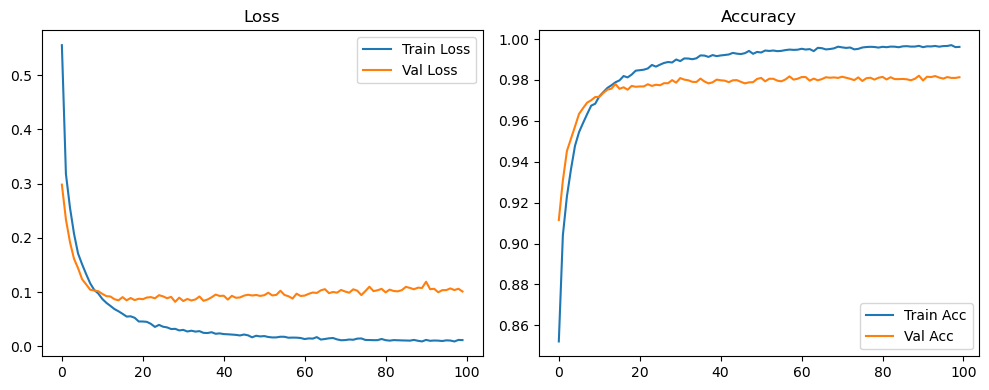

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.9013, Acc: 0.7206 | Val Loss: 0.3555, Acc: 0.8965


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.5140, Acc: 0.8438 | Val Loss: 0.2922, Acc: 0.9145


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.4309, Acc: 0.8704 | Val Loss: 0.2636, Acc: 0.9239


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.3744, Acc: 0.8870 | Val Loss: 0.2268, Acc: 0.9330


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.3314, Acc: 0.9005 | Val Loss: 0.2056, Acc: 0.9400


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.3005, Acc: 0.9095 | Val Loss: 0.1774, Acc: 0.9478


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.2766, Acc: 0.9173 | Val Loss: 0.1700, Acc: 0.9510


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.2499, Acc: 0.9254 | Val Loss: 0.1491, Acc: 0.9553


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.2325, Acc: 0.9291 | Val Loss: 0.1434, Acc: 0.9579


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.2162, Acc: 0.9357 | Val Loss: 0.1354, Acc: 0.9597


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.2014, Acc: 0.9390 | Val Loss: 0.1337, Acc: 0.9614


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.1920, Acc: 0.9424 | Val Loss: 0.1267, Acc: 0.9644


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.1844, Acc: 0.9441 | Val Loss: 0.1188, Acc: 0.9653


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.1794, Acc: 0.9467 | Val Loss: 0.1196, Acc: 0.9653


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.1666, Acc: 0.9493 | Val Loss: 0.1117, Acc: 0.9683


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.1654, Acc: 0.9508 | Val Loss: 0.1123, Acc: 0.9673


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.1546, Acc: 0.9539 | Val Loss: 0.1093, Acc: 0.9684


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.1530, Acc: 0.9531 | Val Loss: 0.1011, Acc: 0.9712


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.1498, Acc: 0.9541 | Val Loss: 0.1027, Acc: 0.9686


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.1442, Acc: 0.9562 | Val Loss: 0.1021, Acc: 0.9715


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.1365, Acc: 0.9593 | Val Loss: 0.1004, Acc: 0.9710


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.1348, Acc: 0.9588 | Val Loss: 0.0938, Acc: 0.9739


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.1314, Acc: 0.9586 | Val Loss: 0.0993, Acc: 0.9725


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.1266, Acc: 0.9618 | Val Loss: 0.0917, Acc: 0.9745


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.1227, Acc: 0.9619 | Val Loss: 0.0954, Acc: 0.9741


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.1183, Acc: 0.9634 | Val Loss: 0.0913, Acc: 0.9744


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.1172, Acc: 0.9639 | Val Loss: 0.0909, Acc: 0.9750


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.1137, Acc: 0.9648 | Val Loss: 0.0926, Acc: 0.9738


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.1112, Acc: 0.9656 | Val Loss: 0.0911, Acc: 0.9755


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.1082, Acc: 0.9662 | Val Loss: 0.0935, Acc: 0.9748


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.1066, Acc: 0.9672 | Val Loss: 0.0898, Acc: 0.9756


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.1046, Acc: 0.9672 | Val Loss: 0.0899, Acc: 0.9754


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.1017, Acc: 0.9675 | Val Loss: 0.0867, Acc: 0.9763


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.1007, Acc: 0.9683 | Val Loss: 0.0871, Acc: 0.9760


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0970, Acc: 0.9695 | Val Loss: 0.0852, Acc: 0.9768


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0977, Acc: 0.9693 | Val Loss: 0.0867, Acc: 0.9768


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0972, Acc: 0.9693 | Val Loss: 0.0849, Acc: 0.9770


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0938, Acc: 0.9704 | Val Loss: 0.0915, Acc: 0.9750


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0923, Acc: 0.9712 | Val Loss: 0.0843, Acc: 0.9773


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0881, Acc: 0.9734 | Val Loss: 0.0851, Acc: 0.9768


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0896, Acc: 0.9721 | Val Loss: 0.0850, Acc: 0.9773


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0860, Acc: 0.9726 | Val Loss: 0.0821, Acc: 0.9790


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0881, Acc: 0.9725 | Val Loss: 0.0888, Acc: 0.9771


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0872, Acc: 0.9722 | Val Loss: 0.0841, Acc: 0.9775


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0875, Acc: 0.9721 | Val Loss: 0.0854, Acc: 0.9773


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0839, Acc: 0.9733 | Val Loss: 0.0842, Acc: 0.9779


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0825, Acc: 0.9737 | Val Loss: 0.0867, Acc: 0.9781


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0809, Acc: 0.9741 | Val Loss: 0.0820, Acc: 0.9785


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0784, Acc: 0.9748 | Val Loss: 0.0843, Acc: 0.9783


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0795, Acc: 0.9747 | Val Loss: 0.0827, Acc: 0.9779


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0762, Acc: 0.9754 | Val Loss: 0.0847, Acc: 0.9786


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0773, Acc: 0.9752 | Val Loss: 0.0822, Acc: 0.9794


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0755, Acc: 0.9760 | Val Loss: 0.0803, Acc: 0.9791


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0764, Acc: 0.9762 | Val Loss: 0.0851, Acc: 0.9782


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0751, Acc: 0.9756 | Val Loss: 0.0830, Acc: 0.9790


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0729, Acc: 0.9767 | Val Loss: 0.0817, Acc: 0.9795


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0734, Acc: 0.9771 | Val Loss: 0.0851, Acc: 0.9779


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0682, Acc: 0.9780 | Val Loss: 0.0836, Acc: 0.9794


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0701, Acc: 0.9779 | Val Loss: 0.0878, Acc: 0.9782


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0710, Acc: 0.9782 | Val Loss: 0.0808, Acc: 0.9795


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0689, Acc: 0.9777 | Val Loss: 0.0869, Acc: 0.9780


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0688, Acc: 0.9776 | Val Loss: 0.0876, Acc: 0.9787


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0651, Acc: 0.9790 | Val Loss: 0.0879, Acc: 0.9782


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0680, Acc: 0.9785 | Val Loss: 0.0840, Acc: 0.9801


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0671, Acc: 0.9793 | Val Loss: 0.0839, Acc: 0.9795


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0657, Acc: 0.9781 | Val Loss: 0.0848, Acc: 0.9804


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0678, Acc: 0.9791 | Val Loss: 0.0823, Acc: 0.9794


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0617, Acc: 0.9801 | Val Loss: 0.0865, Acc: 0.9787


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0658, Acc: 0.9791 | Val Loss: 0.0845, Acc: 0.9797


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0620, Acc: 0.9798 | Val Loss: 0.0864, Acc: 0.9792


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0649, Acc: 0.9784 | Val Loss: 0.0842, Acc: 0.9791


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0631, Acc: 0.9796 | Val Loss: 0.0835, Acc: 0.9802


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0620, Acc: 0.9804 | Val Loss: 0.0848, Acc: 0.9794


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0608, Acc: 0.9805 | Val Loss: 0.0874, Acc: 0.9787


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0613, Acc: 0.9805 | Val Loss: 0.0853, Acc: 0.9795


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0625, Acc: 0.9802 | Val Loss: 0.0856, Acc: 0.9785


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0598, Acc: 0.9812 | Val Loss: 0.0846, Acc: 0.9800


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0593, Acc: 0.9809 | Val Loss: 0.0854, Acc: 0.9784


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0591, Acc: 0.9812 | Val Loss: 0.0805, Acc: 0.9802


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0578, Acc: 0.9810 | Val Loss: 0.0832, Acc: 0.9789


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0597, Acc: 0.9808 | Val Loss: 0.0860, Acc: 0.9790


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0537, Acc: 0.9826 | Val Loss: 0.0816, Acc: 0.9791


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0553, Acc: 0.9824 | Val Loss: 0.0846, Acc: 0.9792


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0552, Acc: 0.9820 | Val Loss: 0.0849, Acc: 0.9792


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0544, Acc: 0.9822 | Val Loss: 0.0895, Acc: 0.9787


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0557, Acc: 0.9822 | Val Loss: 0.0851, Acc: 0.9795


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0568, Acc: 0.9818 | Val Loss: 0.0830, Acc: 0.9798


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0544, Acc: 0.9827 | Val Loss: 0.0842, Acc: 0.9798


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0550, Acc: 0.9818 | Val Loss: 0.0867, Acc: 0.9796


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0538, Acc: 0.9824 | Val Loss: 0.0861, Acc: 0.9794


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0561, Acc: 0.9820 | Val Loss: 0.0845, Acc: 0.9799


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0527, Acc: 0.9832 | Val Loss: 0.0846, Acc: 0.9798


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0520, Acc: 0.9832 | Val Loss: 0.0850, Acc: 0.9807


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0527, Acc: 0.9823 | Val Loss: 0.0861, Acc: 0.9791


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0472, Acc: 0.9846 | Val Loss: 0.0861, Acc: 0.9804


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0507, Acc: 0.9834 | Val Loss: 0.0869, Acc: 0.9797


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0525, Acc: 0.9834 | Val Loss: 0.0830, Acc: 0.9802


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0505, Acc: 0.9842 | Val Loss: 0.0835, Acc: 0.9802


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0497, Acc: 0.9837 | Val Loss: 0.0879, Acc: 0.9801


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0495, Acc: 0.9835 | Val Loss: 0.0875, Acc: 0.9801


Final Test Loss: 0.0775 Accuracy: 0.9815


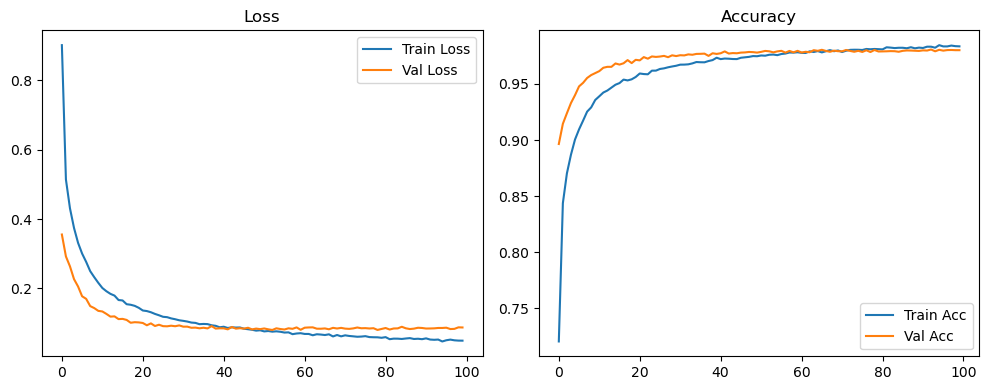

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.4973, Acc: 0.8911 | Val Loss: 0.2909, Acc: 0.9193


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2251, Acc: 0.9363 | Val Loss: 0.2170, Acc: 0.9368


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1646, Acc: 0.9505 | Val Loss: 0.1769, Acc: 0.9467


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1233, Acc: 0.9628 | Val Loss: 0.1377, Acc: 0.9567


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0967, Acc: 0.9709 | Val Loss: 0.1426, Acc: 0.9546


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0806, Acc: 0.9760 | Val Loss: 0.1160, Acc: 0.9656


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0692, Acc: 0.9779 | Val Loss: 0.1281, Acc: 0.9627


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0564, Acc: 0.9824 | Val Loss: 0.1050, Acc: 0.9675


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0480, Acc: 0.9848 | Val Loss: 0.0964, Acc: 0.9707


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0425, Acc: 0.9858 | Val Loss: 0.1060, Acc: 0.9687


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0365, Acc: 0.9882 | Val Loss: 0.0962, Acc: 0.9719


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0331, Acc: 0.9894 | Val Loss: 0.0955, Acc: 0.9729


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0283, Acc: 0.9909 | Val Loss: 0.0950, Acc: 0.9726


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9904 | Val Loss: 0.0989, Acc: 0.9720


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9916 | Val Loss: 0.1046, Acc: 0.9707


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9932 | Val Loss: 0.0944, Acc: 0.9737


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9927 | Val Loss: 0.0952, Acc: 0.9739


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9935 | Val Loss: 0.0900, Acc: 0.9756


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9938 | Val Loss: 0.1130, Acc: 0.9698


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.1054, Acc: 0.9708


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0151, Acc: 0.9952 | Val Loss: 0.1059, Acc: 0.9724


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0151, Acc: 0.9948 | Val Loss: 0.0926, Acc: 0.9762


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9958 | Val Loss: 0.0981, Acc: 0.9768


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.0958, Acc: 0.9764


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.1046, Acc: 0.9737


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1002, Acc: 0.9768


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9953 | Val Loss: 0.1392, Acc: 0.9676


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9959 | Val Loss: 0.1068, Acc: 0.9768


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0965, Acc: 0.9762


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1149, Acc: 0.9737


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9957 | Val Loss: 0.1037, Acc: 0.9751


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.1057, Acc: 0.9756


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1041, Acc: 0.9765


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1140, Acc: 0.9738


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1092, Acc: 0.9754


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.1004, Acc: 0.9777


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1149, Acc: 0.9755


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1079, Acc: 0.9754


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1096, Acc: 0.9764


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9963 | Val Loss: 0.1376, Acc: 0.9706


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.1071, Acc: 0.9759


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1047, Acc: 0.9777


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1050, Acc: 0.9778


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0994, Acc: 0.9792


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1124, Acc: 0.9766


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.1093, Acc: 0.9772


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1087, Acc: 0.9782


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0938, Acc: 0.9806


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1046, Acc: 0.9789


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1215, Acc: 0.9765


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1286, Acc: 0.9742


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1159, Acc: 0.9772


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9978 | Val Loss: 0.1074, Acc: 0.9776


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1029, Acc: 0.9793


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0981, Acc: 0.9800


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0948, Acc: 0.9805


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.1179, Acc: 0.9775


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1185, Acc: 0.9784


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1503, Acc: 0.9707


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1022, Acc: 0.9791


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9988 | Val Loss: 0.1246, Acc: 0.9767


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.1061, Acc: 0.9791


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1013, Acc: 0.9794


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1322, Acc: 0.9760


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1282, Acc: 0.9760


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1074, Acc: 0.9800


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1062, Acc: 0.9788


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1311, Acc: 0.9767


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1150, Acc: 0.9782


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1094, Acc: 0.9792


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1056, Acc: 0.9792


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1087, Acc: 0.9793


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1201, Acc: 0.9798


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1139, Acc: 0.9783


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1077, Acc: 0.9802


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1151, Acc: 0.9776


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.1230, Acc: 0.9770


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1171, Acc: 0.9782


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1132, Acc: 0.9795


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1174, Acc: 0.9783


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1046, Acc: 0.9803


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1041, Acc: 0.9803


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1232, Acc: 0.9781


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1509, Acc: 0.9728


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1118, Acc: 0.9798


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1097, Acc: 0.9804


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1117, Acc: 0.9805


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1085, Acc: 0.9800


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1396, Acc: 0.9768


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1122, Acc: 0.9806


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1219, Acc: 0.9795


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1193, Acc: 0.9801


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1132, Acc: 0.9802


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1220, Acc: 0.9794


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1195, Acc: 0.9792


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1162, Acc: 0.9803


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1292, Acc: 0.9754


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1081, Acc: 0.9809


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1284, Acc: 0.9782


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1097, Acc: 0.9808


Final Test Loss: 0.1037 Accuracy: 0.9815


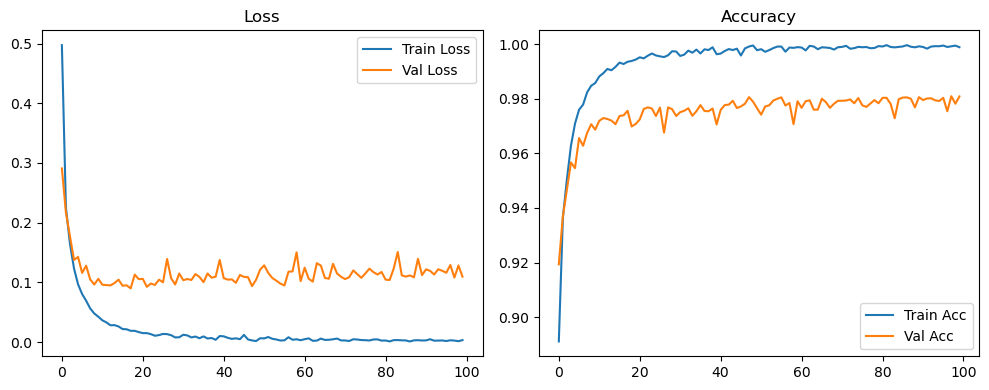

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.6735, Acc: 0.8381 | Val Loss: 0.3338, Acc: 0.9058


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.3568, Acc: 0.8944 | Val Loss: 0.2679, Acc: 0.9228


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.3001, Acc: 0.9106 | Val Loss: 0.2302, Acc: 0.9333


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.2559, Acc: 0.9238 | Val Loss: 0.1990, Acc: 0.9417


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.2190, Acc: 0.9337 | Val Loss: 0.1805, Acc: 0.9467


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1948, Acc: 0.9420 | Val Loss: 0.1494, Acc: 0.9557


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1714, Acc: 0.9483 | Val Loss: 0.1380, Acc: 0.9587


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1544, Acc: 0.9527 | Val Loss: 0.1232, Acc: 0.9643


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1394, Acc: 0.9572 | Val Loss: 0.1240, Acc: 0.9636


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1269, Acc: 0.9612 | Val Loss: 0.1146, Acc: 0.9669


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1161, Acc: 0.9644 | Val Loss: 0.1082, Acc: 0.9676


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1068, Acc: 0.9657 | Val Loss: 0.1106, Acc: 0.9667


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0993, Acc: 0.9690 | Val Loss: 0.1058, Acc: 0.9696


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0927, Acc: 0.9706 | Val Loss: 0.0993, Acc: 0.9709


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0867, Acc: 0.9717 | Val Loss: 0.0931, Acc: 0.9723


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0805, Acc: 0.9750 | Val Loss: 0.0941, Acc: 0.9741


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0758, Acc: 0.9748 | Val Loss: 0.0911, Acc: 0.9732


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0720, Acc: 0.9764 | Val Loss: 0.0898, Acc: 0.9740


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0687, Acc: 0.9780 | Val Loss: 0.0887, Acc: 0.9740


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0624, Acc: 0.9799 | Val Loss: 0.0862, Acc: 0.9747


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0620, Acc: 0.9797 | Val Loss: 0.0925, Acc: 0.9742


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0595, Acc: 0.9798 | Val Loss: 0.0863, Acc: 0.9768


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0547, Acc: 0.9815 | Val Loss: 0.0888, Acc: 0.9760


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0493, Acc: 0.9840 | Val Loss: 0.0844, Acc: 0.9768


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0532, Acc: 0.9820 | Val Loss: 0.0904, Acc: 0.9759


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0492, Acc: 0.9838 | Val Loss: 0.0888, Acc: 0.9767


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0481, Acc: 0.9842 | Val Loss: 0.0835, Acc: 0.9787


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0415, Acc: 0.9858 | Val Loss: 0.0856, Acc: 0.9775


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0407, Acc: 0.9864 | Val Loss: 0.0822, Acc: 0.9795


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0396, Acc: 0.9868 | Val Loss: 0.0848, Acc: 0.9787


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0397, Acc: 0.9868 | Val Loss: 0.0808, Acc: 0.9789


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0358, Acc: 0.9878 | Val Loss: 0.0835, Acc: 0.9796


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0379, Acc: 0.9868 | Val Loss: 0.0816, Acc: 0.9792


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0349, Acc: 0.9878 | Val Loss: 0.0867, Acc: 0.9772


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0333, Acc: 0.9892 | Val Loss: 0.0838, Acc: 0.9793


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9892 | Val Loss: 0.0841, Acc: 0.9792


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0301, Acc: 0.9898 | Val Loss: 0.0853, Acc: 0.9783


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0329, Acc: 0.9888 | Val Loss: 0.0867, Acc: 0.9779


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9892 | Val Loss: 0.0885, Acc: 0.9792


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9905 | Val Loss: 0.0847, Acc: 0.9802


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9899 | Val Loss: 0.0857, Acc: 0.9793


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9903 | Val Loss: 0.0904, Acc: 0.9787


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9910 | Val Loss: 0.0879, Acc: 0.9787


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9916 | Val Loss: 0.0831, Acc: 0.9795


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9905 | Val Loss: 0.0823, Acc: 0.9782


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9909 | Val Loss: 0.0845, Acc: 0.9809


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9922 | Val Loss: 0.0858, Acc: 0.9803


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9923 | Val Loss: 0.0887, Acc: 0.9799


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9916 | Val Loss: 0.0881, Acc: 0.9783


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9920 | Val Loss: 0.0873, Acc: 0.9797


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9929 | Val Loss: 0.0896, Acc: 0.9793


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9933 | Val Loss: 0.0912, Acc: 0.9792


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.0892, Acc: 0.9804


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9926 | Val Loss: 0.0952, Acc: 0.9797


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9927 | Val Loss: 0.0912, Acc: 0.9792


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9929 | Val Loss: 0.0941, Acc: 0.9783


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9932 | Val Loss: 0.0933, Acc: 0.9783


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9934 | Val Loss: 0.0918, Acc: 0.9798


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9943 | Val Loss: 0.0897, Acc: 0.9798


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9936 | Val Loss: 0.0868, Acc: 0.9806


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9932 | Val Loss: 0.0934, Acc: 0.9799


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9937 | Val Loss: 0.0920, Acc: 0.9808


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9938 | Val Loss: 0.0929, Acc: 0.9807


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9936 | Val Loss: 0.0896, Acc: 0.9808


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9944 | Val Loss: 0.0990, Acc: 0.9802


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9943 | Val Loss: 0.0924, Acc: 0.9802


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9941 | Val Loss: 0.0912, Acc: 0.9815


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9941 | Val Loss: 0.0979, Acc: 0.9796


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.0940, Acc: 0.9798


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9948 | Val Loss: 0.0943, Acc: 0.9811


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9950 | Val Loss: 0.0956, Acc: 0.9802


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.0939, Acc: 0.9802


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.0990, Acc: 0.9808


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9944 | Val Loss: 0.0998, Acc: 0.9801


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9949 | Val Loss: 0.0926, Acc: 0.9806


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.0935, Acc: 0.9810


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9953 | Val Loss: 0.0947, Acc: 0.9809


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9957 | Val Loss: 0.1030, Acc: 0.9792


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9950 | Val Loss: 0.0980, Acc: 0.9786


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9950 | Val Loss: 0.0976, Acc: 0.9812


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9954 | Val Loss: 0.0965, Acc: 0.9799


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.0970, Acc: 0.9813


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.0963, Acc: 0.9798


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.0925, Acc: 0.9818


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9952 | Val Loss: 0.0995, Acc: 0.9802


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9958 | Val Loss: 0.0929, Acc: 0.9811


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.0960, Acc: 0.9808


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.0968, Acc: 0.9798


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1013, Acc: 0.9802


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.1021, Acc: 0.9802


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9953 | Val Loss: 0.1004, Acc: 0.9800


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.0954, Acc: 0.9813


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0987, Acc: 0.9808


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.1009, Acc: 0.9798


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0964, Acc: 0.9816


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9963 | Val Loss: 0.0980, Acc: 0.9808


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9957 | Val Loss: 0.1006, Acc: 0.9812


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9961 | Val Loss: 0.0963, Acc: 0.9808


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.1001, Acc: 0.9809


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.0970, Acc: 0.9821


Final Test Loss: 0.0956 Accuracy: 0.9818


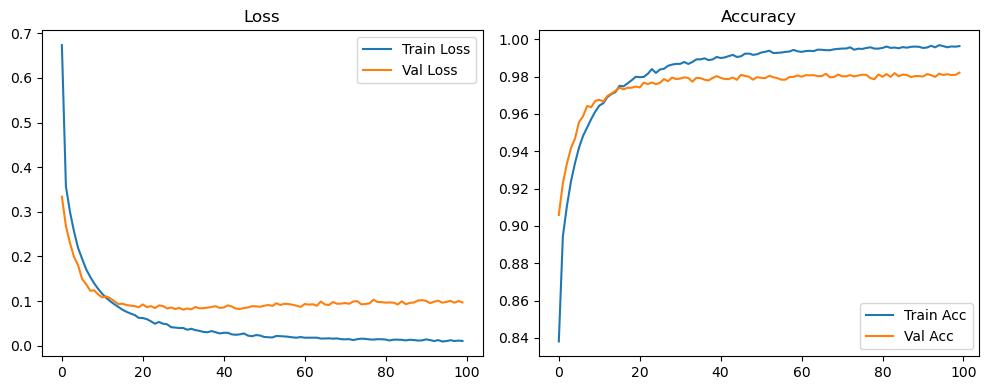

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 1.1067, Acc: 0.6624 | Val Loss: 0.4344, Acc: 0.8865


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.6023, Acc: 0.8169 | Val Loss: 0.3318, Acc: 0.9028


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.5062, Acc: 0.8450 | Val Loss: 0.3072, Acc: 0.9098


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.4498, Acc: 0.8634 | Val Loss: 0.2766, Acc: 0.9178


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.4103, Acc: 0.8757 | Val Loss: 0.2584, Acc: 0.9228


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.3755, Acc: 0.8872 | Val Loss: 0.2309, Acc: 0.9327


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.3482, Acc: 0.8965 | Val Loss: 0.2168, Acc: 0.9369


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.3214, Acc: 0.9054 | Val Loss: 0.1956, Acc: 0.9429


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.2987, Acc: 0.9093 | Val Loss: 0.1843, Acc: 0.9458


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.2759, Acc: 0.9187 | Val Loss: 0.1741, Acc: 0.9486


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.2624, Acc: 0.9206 | Val Loss: 0.1689, Acc: 0.9505


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.2477, Acc: 0.9257 | Val Loss: 0.1584, Acc: 0.9545


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.2379, Acc: 0.9290 | Val Loss: 0.1501, Acc: 0.9548


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.2267, Acc: 0.9316 | Val Loss: 0.1447, Acc: 0.9575


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.2172, Acc: 0.9347 | Val Loss: 0.1380, Acc: 0.9590


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.2102, Acc: 0.9366 | Val Loss: 0.1370, Acc: 0.9590


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.1954, Acc: 0.9410 | Val Loss: 0.1298, Acc: 0.9615


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.1920, Acc: 0.9413 | Val Loss: 0.1228, Acc: 0.9647


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.1878, Acc: 0.9442 | Val Loss: 0.1243, Acc: 0.9635


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.1807, Acc: 0.9456 | Val Loss: 0.1240, Acc: 0.9627


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.1745, Acc: 0.9478 | Val Loss: 0.1192, Acc: 0.9668


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.1711, Acc: 0.9494 | Val Loss: 0.1110, Acc: 0.9688


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.1629, Acc: 0.9506 | Val Loss: 0.1134, Acc: 0.9680


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.1594, Acc: 0.9515 | Val Loss: 0.1088, Acc: 0.9697


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.1553, Acc: 0.9530 | Val Loss: 0.1096, Acc: 0.9695


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.1481, Acc: 0.9550 | Val Loss: 0.1080, Acc: 0.9697


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.1462, Acc: 0.9555 | Val Loss: 0.1048, Acc: 0.9701


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.1432, Acc: 0.9571 | Val Loss: 0.1028, Acc: 0.9712


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.1398, Acc: 0.9576 | Val Loss: 0.1039, Acc: 0.9716


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.1368, Acc: 0.9578 | Val Loss: 0.1047, Acc: 0.9711


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.1342, Acc: 0.9590 | Val Loss: 0.0990, Acc: 0.9726


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.1319, Acc: 0.9596 | Val Loss: 0.0995, Acc: 0.9733


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.1277, Acc: 0.9608 | Val Loss: 0.0983, Acc: 0.9718


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.1248, Acc: 0.9619 | Val Loss: 0.1012, Acc: 0.9709


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.1195, Acc: 0.9631 | Val Loss: 0.0980, Acc: 0.9724


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.1229, Acc: 0.9619 | Val Loss: 0.0971, Acc: 0.9734


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.1186, Acc: 0.9642 | Val Loss: 0.0929, Acc: 0.9749


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.1154, Acc: 0.9638 | Val Loss: 0.0980, Acc: 0.9731


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.1147, Acc: 0.9648 | Val Loss: 0.0920, Acc: 0.9740


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.1107, Acc: 0.9662 | Val Loss: 0.0978, Acc: 0.9732


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.1095, Acc: 0.9664 | Val Loss: 0.0933, Acc: 0.9748


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.1057, Acc: 0.9676 | Val Loss: 0.0905, Acc: 0.9751


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.1086, Acc: 0.9666 | Val Loss: 0.0939, Acc: 0.9763


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.1088, Acc: 0.9661 | Val Loss: 0.0915, Acc: 0.9744


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.1024, Acc: 0.9678 | Val Loss: 0.0913, Acc: 0.9749


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.1021, Acc: 0.9680 | Val Loss: 0.0908, Acc: 0.9752


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0980, Acc: 0.9693 | Val Loss: 0.0910, Acc: 0.9761


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0987, Acc: 0.9692 | Val Loss: 0.0906, Acc: 0.9747


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0977, Acc: 0.9700 | Val Loss: 0.0925, Acc: 0.9746


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0978, Acc: 0.9696 | Val Loss: 0.0905, Acc: 0.9753


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0949, Acc: 0.9705 | Val Loss: 0.0903, Acc: 0.9754


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0940, Acc: 0.9711 | Val Loss: 0.0883, Acc: 0.9763


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0932, Acc: 0.9705 | Val Loss: 0.0866, Acc: 0.9763


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0893, Acc: 0.9719 | Val Loss: 0.0916, Acc: 0.9754


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0919, Acc: 0.9708 | Val Loss: 0.0906, Acc: 0.9767


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0887, Acc: 0.9720 | Val Loss: 0.0892, Acc: 0.9768


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0914, Acc: 0.9710 | Val Loss: 0.0883, Acc: 0.9767


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0822, Acc: 0.9735 | Val Loss: 0.0909, Acc: 0.9768


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0867, Acc: 0.9726 | Val Loss: 0.0935, Acc: 0.9766


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0832, Acc: 0.9740 | Val Loss: 0.0895, Acc: 0.9768


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0866, Acc: 0.9724 | Val Loss: 0.0878, Acc: 0.9767


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0836, Acc: 0.9743 | Val Loss: 0.0889, Acc: 0.9775


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0805, Acc: 0.9747 | Val Loss: 0.0899, Acc: 0.9770


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0804, Acc: 0.9742 | Val Loss: 0.0891, Acc: 0.9766


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0777, Acc: 0.9756 | Val Loss: 0.0897, Acc: 0.9766


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0787, Acc: 0.9749 | Val Loss: 0.0890, Acc: 0.9767


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0826, Acc: 0.9743 | Val Loss: 0.0893, Acc: 0.9767


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0804, Acc: 0.9746 | Val Loss: 0.0933, Acc: 0.9764


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0783, Acc: 0.9740 | Val Loss: 0.0873, Acc: 0.9772


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0741, Acc: 0.9768 | Val Loss: 0.0886, Acc: 0.9771


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0782, Acc: 0.9750 | Val Loss: 0.0885, Acc: 0.9764


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0736, Acc: 0.9761 | Val Loss: 0.0909, Acc: 0.9772


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0741, Acc: 0.9758 | Val Loss: 0.0875, Acc: 0.9777


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0707, Acc: 0.9772 | Val Loss: 0.0918, Acc: 0.9766


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0723, Acc: 0.9775 | Val Loss: 0.0896, Acc: 0.9788


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0718, Acc: 0.9769 | Val Loss: 0.0867, Acc: 0.9780


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0700, Acc: 0.9775 | Val Loss: 0.0898, Acc: 0.9773


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0704, Acc: 0.9775 | Val Loss: 0.0924, Acc: 0.9780


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0714, Acc: 0.9778 | Val Loss: 0.0867, Acc: 0.9780


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0685, Acc: 0.9779 | Val Loss: 0.0887, Acc: 0.9772


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0690, Acc: 0.9772 | Val Loss: 0.0896, Acc: 0.9775


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0685, Acc: 0.9785 | Val Loss: 0.0879, Acc: 0.9779


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0650, Acc: 0.9787 | Val Loss: 0.0888, Acc: 0.9773


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0710, Acc: 0.9778 | Val Loss: 0.0890, Acc: 0.9780


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0658, Acc: 0.9778 | Val Loss: 0.0871, Acc: 0.9784


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0650, Acc: 0.9792 | Val Loss: 0.0857, Acc: 0.9787


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0683, Acc: 0.9785 | Val Loss: 0.0879, Acc: 0.9790


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0652, Acc: 0.9792 | Val Loss: 0.0845, Acc: 0.9789


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0665, Acc: 0.9792 | Val Loss: 0.0881, Acc: 0.9779


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0619, Acc: 0.9808 | Val Loss: 0.0889, Acc: 0.9776


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0630, Acc: 0.9797 | Val Loss: 0.0899, Acc: 0.9779


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0641, Acc: 0.9787 | Val Loss: 0.0860, Acc: 0.9781


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0606, Acc: 0.9799 | Val Loss: 0.0862, Acc: 0.9790


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0614, Acc: 0.9799 | Val Loss: 0.0891, Acc: 0.9783


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0604, Acc: 0.9808 | Val Loss: 0.0901, Acc: 0.9784


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0597, Acc: 0.9808 | Val Loss: 0.0873, Acc: 0.9780


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0605, Acc: 0.9803 | Val Loss: 0.0849, Acc: 0.9787


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0590, Acc: 0.9804 | Val Loss: 0.0895, Acc: 0.9788


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0599, Acc: 0.9802 | Val Loss: 0.0934, Acc: 0.9775


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0587, Acc: 0.9805 | Val Loss: 0.0876, Acc: 0.9776


Final Test Loss: 0.0787 Accuracy: 0.9793


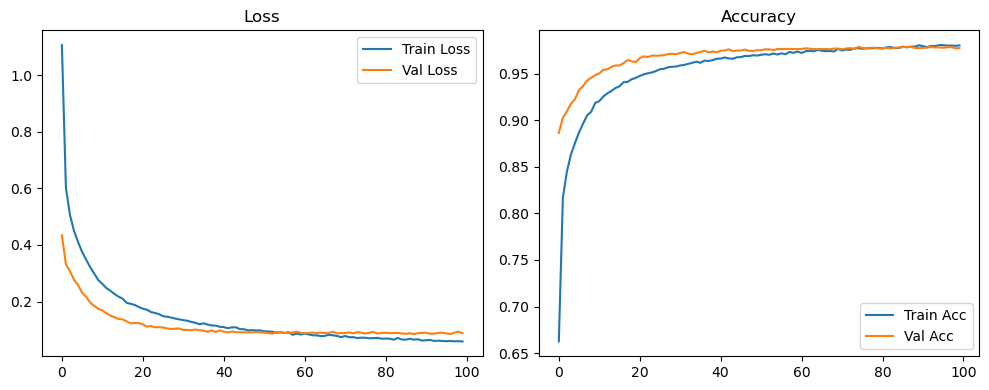

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3876, Acc: 0.8875 | Val Loss: 0.2848, Acc: 0.9138


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1827, Acc: 0.9441 | Val Loss: 0.1756, Acc: 0.9493


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1190, Acc: 0.9639 | Val Loss: 0.1343, Acc: 0.9605


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9726 | Val Loss: 0.1165, Acc: 0.9657


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0654, Acc: 0.9788 | Val Loss: 0.1137, Acc: 0.9651


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9835 | Val Loss: 0.1093, Acc: 0.9702


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9855 | Val Loss: 0.0953, Acc: 0.9723


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9880 | Val Loss: 0.1116, Acc: 0.9698


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9898 | Val Loss: 0.0961, Acc: 0.9751


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9912 | Val Loss: 0.1363, Acc: 0.9673


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9917 | Val Loss: 0.1156, Acc: 0.9719


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.1375, Acc: 0.9676


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.1014, Acc: 0.9763


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.1674, Acc: 0.9652


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9947 | Val Loss: 0.1256, Acc: 0.9746


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9933 | Val Loss: 0.1251, Acc: 0.9736


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.1450, Acc: 0.9706


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.1164, Acc: 0.9748


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.1396, Acc: 0.9728


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.1266, Acc: 0.9757


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9959 | Val Loss: 0.1356, Acc: 0.9729


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.1344, Acc: 0.9741


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1319, Acc: 0.9750


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.1433, Acc: 0.9751


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.1374, Acc: 0.9750


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.1246, Acc: 0.9782


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1473, Acc: 0.9746


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9956 | Val Loss: 0.1503, Acc: 0.9740


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1214, Acc: 0.9799


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1465, Acc: 0.9767


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1544, Acc: 0.9744


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1431, Acc: 0.9757


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.1540, Acc: 0.9765


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1747, Acc: 0.9715


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1340, Acc: 0.9772


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1446, Acc: 0.9768


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1672, Acc: 0.9753


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9968 | Val Loss: 0.1804, Acc: 0.9736


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9971 | Val Loss: 0.1459, Acc: 0.9764


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1634, Acc: 0.9756


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1824, Acc: 0.9709


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1686, Acc: 0.9741


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1645, Acc: 0.9769


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1586, Acc: 0.9782


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1619, Acc: 0.9752


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1626, Acc: 0.9782


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1608, Acc: 0.9770


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1598, Acc: 0.9791


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1531, Acc: 0.9783


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1578, Acc: 0.9783


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1737, Acc: 0.9744


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1693, Acc: 0.9762


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9970 | Val Loss: 0.1602, Acc: 0.9768


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.1551, Acc: 0.9778


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1678, Acc: 0.9783


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1464, Acc: 0.9782


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1560, Acc: 0.9774


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1526, Acc: 0.9788


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1598, Acc: 0.9781


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1528, Acc: 0.9787


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1479, Acc: 0.9798


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1749, Acc: 0.9768


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1761, Acc: 0.9755


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1671, Acc: 0.9765


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1558, Acc: 0.9778


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1814, Acc: 0.9745


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9977 | Val Loss: 0.1575, Acc: 0.9768


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1614, Acc: 0.9781


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1579, Acc: 0.9793


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1555, Acc: 0.9774


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1632, Acc: 0.9769


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9986 | Val Loss: 0.1613, Acc: 0.9779


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1537, Acc: 0.9791


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1545, Acc: 0.9787


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1681, Acc: 0.9786


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9982 | Val Loss: 0.1800, Acc: 0.9764


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1583, Acc: 0.9779


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1526, Acc: 0.9803


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1545, Acc: 0.9788


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1455, Acc: 0.9810


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1769, Acc: 0.9752


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1678, Acc: 0.9772


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1580, Acc: 0.9785


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1675, Acc: 0.9784


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1794, Acc: 0.9771


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1771, Acc: 0.9772


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1792, Acc: 0.9779


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.1724, Acc: 0.9777


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1653, Acc: 0.9772


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1563, Acc: 0.9784


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1566, Acc: 0.9785


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9984 | Val Loss: 0.1773, Acc: 0.9766


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1426, Acc: 0.9798


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1705, Acc: 0.9776


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9997 | Val Loss: 0.1518, Acc: 0.9802


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1493, Acc: 0.9805


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1616, Acc: 0.9798


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1612, Acc: 0.9794


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1664, Acc: 0.9787


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9973 | Val Loss: 0.1678, Acc: 0.9790


Final Test Loss: 0.1747 Accuracy: 0.9782


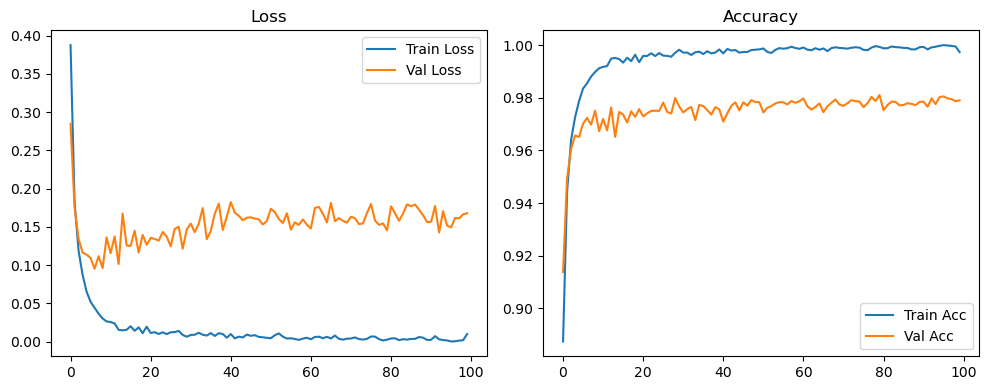

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4874, Acc: 0.8544 | Val Loss: 0.2797, Acc: 0.9181


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2571, Acc: 0.9227 | Val Loss: 0.1800, Acc: 0.9477


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1820, Acc: 0.9454 | Val Loss: 0.1472, Acc: 0.9570


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1404, Acc: 0.9573 | Val Loss: 0.1233, Acc: 0.9632


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1101, Acc: 0.9656 | Val Loss: 0.1119, Acc: 0.9668


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0983, Acc: 0.9705 | Val Loss: 0.1040, Acc: 0.9700


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0826, Acc: 0.9746 | Val Loss: 0.0997, Acc: 0.9704


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0769, Acc: 0.9749 | Val Loss: 0.0921, Acc: 0.9729


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0653, Acc: 0.9786 | Val Loss: 0.0896, Acc: 0.9745


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9809 | Val Loss: 0.1116, Acc: 0.9723


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9813 | Val Loss: 0.0910, Acc: 0.9758


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9835 | Val Loss: 0.0872, Acc: 0.9760


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9849 | Val Loss: 0.0925, Acc: 0.9776


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9858 | Val Loss: 0.0871, Acc: 0.9779


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9860 | Val Loss: 0.0877, Acc: 0.9772


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9869 | Val Loss: 0.0996, Acc: 0.9776


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0372, Acc: 0.9877 | Val Loss: 0.1010, Acc: 0.9768


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9875 | Val Loss: 0.0911, Acc: 0.9787


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9870 | Val Loss: 0.0892, Acc: 0.9798


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9890 | Val Loss: 0.0895, Acc: 0.9782


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9896 | Val Loss: 0.1046, Acc: 0.9765


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9893 | Val Loss: 0.0892, Acc: 0.9803


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9899 | Val Loss: 0.1023, Acc: 0.9771


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9898 | Val Loss: 0.0857, Acc: 0.9797


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.0936, Acc: 0.9781


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9916 | Val Loss: 0.0869, Acc: 0.9814


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9915 | Val Loss: 0.0942, Acc: 0.9795


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9931 | Val Loss: 0.1088, Acc: 0.9792


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9916 | Val Loss: 0.0993, Acc: 0.9794


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9929 | Val Loss: 0.0983, Acc: 0.9804


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9923 | Val Loss: 0.0938, Acc: 0.9788


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9927 | Val Loss: 0.0887, Acc: 0.9812


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9917 | Val Loss: 0.0971, Acc: 0.9803


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9928 | Val Loss: 0.0987, Acc: 0.9802


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9927 | Val Loss: 0.0949, Acc: 0.9802


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.0962, Acc: 0.9815


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.1005, Acc: 0.9808


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9940 | Val Loss: 0.1012, Acc: 0.9801


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.0983, Acc: 0.9800


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9937 | Val Loss: 0.0967, Acc: 0.9808


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.0989, Acc: 0.9810


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.1097, Acc: 0.9788


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.0999, Acc: 0.9813


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.1133, Acc: 0.9801


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.1064, Acc: 0.9802


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.1080, Acc: 0.9809


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.1069, Acc: 0.9808


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.1005, Acc: 0.9821


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.1050, Acc: 0.9819


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.0984, Acc: 0.9819


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.1013, Acc: 0.9802


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9951 | Val Loss: 0.1113, Acc: 0.9779


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.1043, Acc: 0.9814


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.1098, Acc: 0.9799


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9950 | Val Loss: 0.1089, Acc: 0.9807


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.1050, Acc: 0.9814


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.1045, Acc: 0.9808


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.0933, Acc: 0.9827


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1086, Acc: 0.9789


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.0986, Acc: 0.9815


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9960 | Val Loss: 0.1028, Acc: 0.9807


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.1073, Acc: 0.9802


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.1090, Acc: 0.9798


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9953 | Val Loss: 0.1117, Acc: 0.9808


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.1149, Acc: 0.9795


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.1010, Acc: 0.9824


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.1023, Acc: 0.9816


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1043, Acc: 0.9821


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.1057, Acc: 0.9810


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.1126, Acc: 0.9805


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.1097, Acc: 0.9801


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.1013, Acc: 0.9815


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1113, Acc: 0.9805


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.1025, Acc: 0.9818


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1068, Acc: 0.9823


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1144, Acc: 0.9799


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.1121, Acc: 0.9803


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9963 | Val Loss: 0.1072, Acc: 0.9814


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1062, Acc: 0.9821


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.1112, Acc: 0.9808


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9966 | Val Loss: 0.1052, Acc: 0.9813


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1075, Acc: 0.9823


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1008, Acc: 0.9822


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.1076, Acc: 0.9816


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9973 | Val Loss: 0.1066, Acc: 0.9825


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1148, Acc: 0.9830


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1051, Acc: 0.9822


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.1010, Acc: 0.9822


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1052, Acc: 0.9827


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9970 | Val Loss: 0.1056, Acc: 0.9828


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0987, Acc: 0.9833


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1024, Acc: 0.9818


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.0948, Acc: 0.9838


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.1053, Acc: 0.9821


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1087, Acc: 0.9820


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9969 | Val Loss: 0.1088, Acc: 0.9812


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1026, Acc: 0.9833


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1051, Acc: 0.9833


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.1077, Acc: 0.9824


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.0943, Acc: 0.9824


Final Test Loss: 0.0888 Accuracy: 0.9835


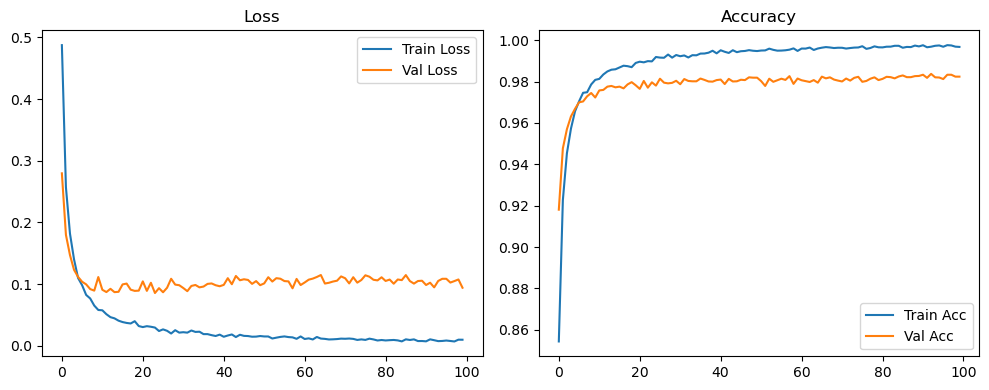

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.7350, Acc: 0.7661 | Val Loss: 0.3073, Acc: 0.9124


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.4066, Acc: 0.8785 | Val Loss: 0.2267, Acc: 0.9347


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3139, Acc: 0.9080 | Val Loss: 0.1818, Acc: 0.9466


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2596, Acc: 0.9216 | Val Loss: 0.1518, Acc: 0.9555


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2295, Acc: 0.9328 | Val Loss: 0.1387, Acc: 0.9602


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2029, Acc: 0.9397 | Val Loss: 0.1231, Acc: 0.9640


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1867, Acc: 0.9454 | Val Loss: 0.1178, Acc: 0.9642


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1748, Acc: 0.9473 | Val Loss: 0.1123, Acc: 0.9677


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1631, Acc: 0.9519 | Val Loss: 0.1055, Acc: 0.9676


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1503, Acc: 0.9557 | Val Loss: 0.1029, Acc: 0.9688


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1450, Acc: 0.9563 | Val Loss: 0.1041, Acc: 0.9701


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1390, Acc: 0.9575 | Val Loss: 0.0954, Acc: 0.9719


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1280, Acc: 0.9612 | Val Loss: 0.0973, Acc: 0.9723


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1292, Acc: 0.9606 | Val Loss: 0.1009, Acc: 0.9712


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1229, Acc: 0.9637 | Val Loss: 0.0893, Acc: 0.9742


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1162, Acc: 0.9652 | Val Loss: 0.0920, Acc: 0.9741


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1173, Acc: 0.9651 | Val Loss: 0.0872, Acc: 0.9748


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1109, Acc: 0.9673 | Val Loss: 0.0824, Acc: 0.9762


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1043, Acc: 0.9671 | Val Loss: 0.0843, Acc: 0.9764


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1023, Acc: 0.9697 | Val Loss: 0.0902, Acc: 0.9746


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0961, Acc: 0.9702 | Val Loss: 0.0885, Acc: 0.9753


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0974, Acc: 0.9700 | Val Loss: 0.0826, Acc: 0.9772


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0999, Acc: 0.9685 | Val Loss: 0.0854, Acc: 0.9763


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0915, Acc: 0.9716 | Val Loss: 0.0815, Acc: 0.9778


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0895, Acc: 0.9717 | Val Loss: 0.0849, Acc: 0.9765


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9746 | Val Loss: 0.0831, Acc: 0.9773


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0855, Acc: 0.9732 | Val Loss: 0.0783, Acc: 0.9777


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9746 | Val Loss: 0.0803, Acc: 0.9773


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0803, Acc: 0.9747 | Val Loss: 0.0786, Acc: 0.9807


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0798, Acc: 0.9745 | Val Loss: 0.0851, Acc: 0.9778


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9763 | Val Loss: 0.0799, Acc: 0.9792


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0746, Acc: 0.9767 | Val Loss: 0.0791, Acc: 0.9806


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0756, Acc: 0.9760 | Val Loss: 0.0771, Acc: 0.9794


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9766 | Val Loss: 0.0816, Acc: 0.9774


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0778, Acc: 0.9764 | Val Loss: 0.0803, Acc: 0.9763


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0693, Acc: 0.9776 | Val Loss: 0.0747, Acc: 0.9802


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0697, Acc: 0.9781 | Val Loss: 0.0768, Acc: 0.9791


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0665, Acc: 0.9789 | Val Loss: 0.0749, Acc: 0.9805


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0685, Acc: 0.9784 | Val Loss: 0.0773, Acc: 0.9790


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0674, Acc: 0.9795 | Val Loss: 0.0775, Acc: 0.9800


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0661, Acc: 0.9789 | Val Loss: 0.0771, Acc: 0.9788


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0621, Acc: 0.9804 | Val Loss: 0.0811, Acc: 0.9795


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0665, Acc: 0.9791 | Val Loss: 0.0771, Acc: 0.9796


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9813 | Val Loss: 0.0764, Acc: 0.9799


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0602, Acc: 0.9806 | Val Loss: 0.0760, Acc: 0.9802


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9807 | Val Loss: 0.0760, Acc: 0.9796


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9819 | Val Loss: 0.0784, Acc: 0.9796


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9817 | Val Loss: 0.0788, Acc: 0.9798


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0583, Acc: 0.9815 | Val Loss: 0.0785, Acc: 0.9807


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0538, Acc: 0.9832 | Val Loss: 0.0809, Acc: 0.9795


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9832 | Val Loss: 0.0777, Acc: 0.9803


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0579, Acc: 0.9814 | Val Loss: 0.0789, Acc: 0.9798


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9826 | Val Loss: 0.0791, Acc: 0.9793


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9829 | Val Loss: 0.0807, Acc: 0.9795


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9840 | Val Loss: 0.0799, Acc: 0.9808


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0530, Acc: 0.9830 | Val Loss: 0.0789, Acc: 0.9794


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9845 | Val Loss: 0.0784, Acc: 0.9802


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9829 | Val Loss: 0.0783, Acc: 0.9785


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9842 | Val Loss: 0.0787, Acc: 0.9796


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9853 | Val Loss: 0.0763, Acc: 0.9805


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0489, Acc: 0.9846 | Val Loss: 0.0775, Acc: 0.9812


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9844 | Val Loss: 0.0804, Acc: 0.9796


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9851 | Val Loss: 0.0794, Acc: 0.9813


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0504, Acc: 0.9838 | Val Loss: 0.0803, Acc: 0.9799


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9848 | Val Loss: 0.0809, Acc: 0.9805


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9849 | Val Loss: 0.0814, Acc: 0.9806


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0481, Acc: 0.9842 | Val Loss: 0.0807, Acc: 0.9808


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9850 | Val Loss: 0.0843, Acc: 0.9804


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9854 | Val Loss: 0.0816, Acc: 0.9806


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9863 | Val Loss: 0.0805, Acc: 0.9814


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9852 | Val Loss: 0.0799, Acc: 0.9801


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9851 | Val Loss: 0.0829, Acc: 0.9806


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9868 | Val Loss: 0.0780, Acc: 0.9808


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0449, Acc: 0.9856 | Val Loss: 0.0779, Acc: 0.9807


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9860 | Val Loss: 0.0787, Acc: 0.9807


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9865 | Val Loss: 0.0863, Acc: 0.9792


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9873 | Val Loss: 0.0830, Acc: 0.9802


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9877 | Val Loss: 0.0873, Acc: 0.9796


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9861 | Val Loss: 0.0795, Acc: 0.9804


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9858 | Val Loss: 0.0773, Acc: 0.9810


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9862 | Val Loss: 0.0777, Acc: 0.9811


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9873 | Val Loss: 0.0749, Acc: 0.9813


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9874 | Val Loss: 0.0808, Acc: 0.9803


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0372, Acc: 0.9877 | Val Loss: 0.0785, Acc: 0.9804


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9878 | Val Loss: 0.0809, Acc: 0.9811


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9872 | Val Loss: 0.0763, Acc: 0.9808


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9878 | Val Loss: 0.0798, Acc: 0.9802


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9872 | Val Loss: 0.0812, Acc: 0.9801


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9879 | Val Loss: 0.0790, Acc: 0.9806


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9886 | Val Loss: 0.0809, Acc: 0.9813


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9876 | Val Loss: 0.0809, Acc: 0.9811


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9883 | Val Loss: 0.0797, Acc: 0.9804


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9891 | Val Loss: 0.0799, Acc: 0.9816


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9884 | Val Loss: 0.0806, Acc: 0.9818


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9883 | Val Loss: 0.0830, Acc: 0.9809


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9889 | Val Loss: 0.0831, Acc: 0.9804


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9888 | Val Loss: 0.0810, Acc: 0.9810


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9891 | Val Loss: 0.0829, Acc: 0.9810


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9879 | Val Loss: 0.0825, Acc: 0.9812


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9886 | Val Loss: 0.0820, Acc: 0.9818


Final Test Loss: 0.0679 Accuracy: 0.9823


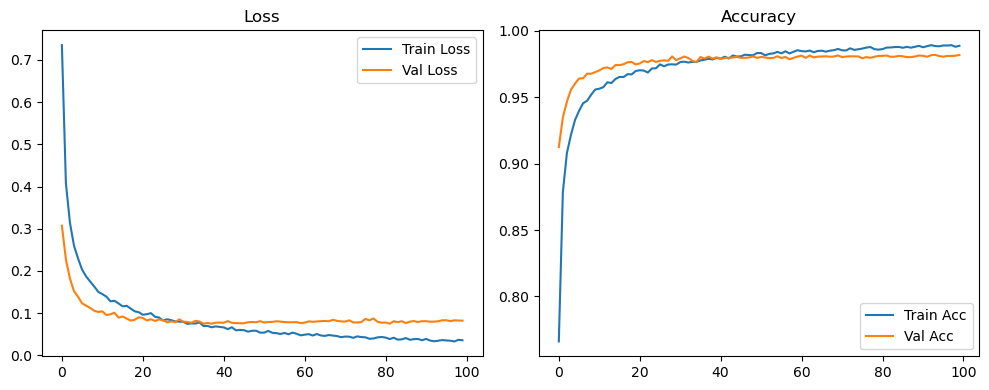

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3876, Acc: 0.8875 | Val Loss: 0.2848, Acc: 0.9138


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1827, Acc: 0.9441 | Val Loss: 0.1756, Acc: 0.9493


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1190, Acc: 0.9639 | Val Loss: 0.1343, Acc: 0.9605


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9726 | Val Loss: 0.1165, Acc: 0.9657


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0654, Acc: 0.9788 | Val Loss: 0.1137, Acc: 0.9651


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9835 | Val Loss: 0.1093, Acc: 0.9702


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9855 | Val Loss: 0.0953, Acc: 0.9723


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9880 | Val Loss: 0.1116, Acc: 0.9698


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9898 | Val Loss: 0.0961, Acc: 0.9751


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9912 | Val Loss: 0.1363, Acc: 0.9673


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9917 | Val Loss: 0.1156, Acc: 0.9719


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.1375, Acc: 0.9676


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.1014, Acc: 0.9763


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.1674, Acc: 0.9652


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9947 | Val Loss: 0.1256, Acc: 0.9746


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9933 | Val Loss: 0.1251, Acc: 0.9736


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.1450, Acc: 0.9706


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.1164, Acc: 0.9748


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.1396, Acc: 0.9728


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.1266, Acc: 0.9757


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9959 | Val Loss: 0.1356, Acc: 0.9729


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.1344, Acc: 0.9741


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1319, Acc: 0.9750


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.1433, Acc: 0.9751


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.1374, Acc: 0.9750


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.1246, Acc: 0.9782


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1473, Acc: 0.9746


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9956 | Val Loss: 0.1503, Acc: 0.9740


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1214, Acc: 0.9799


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1465, Acc: 0.9767


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1544, Acc: 0.9744


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1431, Acc: 0.9757


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.1540, Acc: 0.9765


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1747, Acc: 0.9715


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1340, Acc: 0.9772


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1446, Acc: 0.9768


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1672, Acc: 0.9753


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9968 | Val Loss: 0.1804, Acc: 0.9736


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9971 | Val Loss: 0.1459, Acc: 0.9764


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1634, Acc: 0.9756


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1824, Acc: 0.9709


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1686, Acc: 0.9741


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1645, Acc: 0.9769


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1586, Acc: 0.9782


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1619, Acc: 0.9752


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1626, Acc: 0.9782


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1608, Acc: 0.9770


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1598, Acc: 0.9791


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1531, Acc: 0.9783


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1578, Acc: 0.9783


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1392, Acc: 0.9795


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1406, Acc: 0.9806


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1380, Acc: 0.9800


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1345, Acc: 0.9808


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1365, Acc: 0.9799


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1357, Acc: 0.9813


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1381, Acc: 0.9808


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1371, Acc: 0.9813


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1466, Acc: 0.9798


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1553, Acc: 0.9792


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1511, Acc: 0.9797


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1578, Acc: 0.9771


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1685, Acc: 0.9774


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1639, Acc: 0.9778


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1686, Acc: 0.9790


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1619, Acc: 0.9798


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1574, Acc: 0.9792


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1640, Acc: 0.9783


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1579, Acc: 0.9799


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1574, Acc: 0.9812


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1581, Acc: 0.9805


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.1675, Acc: 0.9797


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1621, Acc: 0.9792


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1668, Acc: 0.9778


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1583, Acc: 0.9787


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.1572, Acc: 0.9796


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1473, Acc: 0.9805


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1645, Acc: 0.9785


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1708, Acc: 0.9800


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1578, Acc: 0.9804


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1472, Acc: 0.9817


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1474, Acc: 0.9822


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1453, Acc: 0.9828


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1446, Acc: 0.9809


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1424, Acc: 0.9814


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1439, Acc: 0.9817


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1434, Acc: 0.9818


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1478, Acc: 0.9812


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1476, Acc: 0.9813


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1445, Acc: 0.9817


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1478, Acc: 0.9818


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1466, Acc: 0.9818


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1438, Acc: 0.9811


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1455, Acc: 0.9813


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1438, Acc: 0.9819


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1454, Acc: 0.9817


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1448, Acc: 0.9817


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1428, Acc: 0.9818


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1421, Acc: 0.9828


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1370, Acc: 0.9827


Final Test Loss: 0.1443 Accuracy: 0.9832


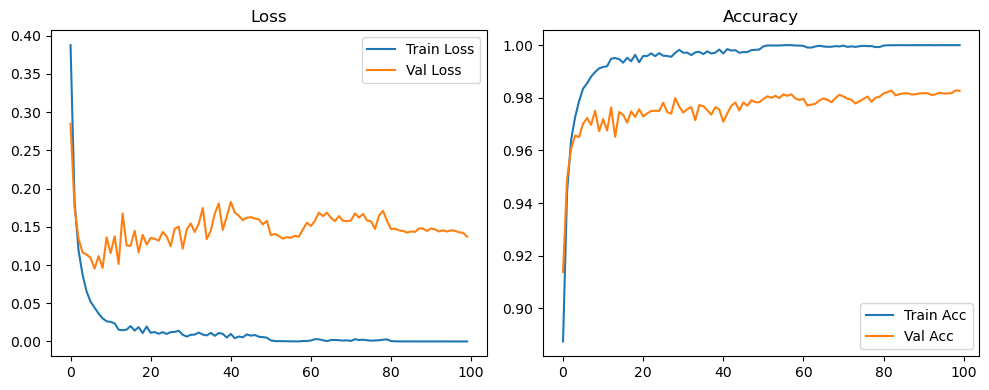

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4874, Acc: 0.8544 | Val Loss: 0.2797, Acc: 0.9181


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2571, Acc: 0.9227 | Val Loss: 0.1800, Acc: 0.9477


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1820, Acc: 0.9454 | Val Loss: 0.1472, Acc: 0.9570


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1404, Acc: 0.9573 | Val Loss: 0.1233, Acc: 0.9632


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1101, Acc: 0.9656 | Val Loss: 0.1119, Acc: 0.9668


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0983, Acc: 0.9705 | Val Loss: 0.1040, Acc: 0.9700


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0826, Acc: 0.9746 | Val Loss: 0.0997, Acc: 0.9704


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0769, Acc: 0.9749 | Val Loss: 0.0921, Acc: 0.9729


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0653, Acc: 0.9786 | Val Loss: 0.0896, Acc: 0.9745


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9809 | Val Loss: 0.1116, Acc: 0.9723


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9813 | Val Loss: 0.0910, Acc: 0.9758


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9835 | Val Loss: 0.0872, Acc: 0.9760


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9849 | Val Loss: 0.0925, Acc: 0.9776


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9858 | Val Loss: 0.0871, Acc: 0.9779


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9860 | Val Loss: 0.0877, Acc: 0.9772


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9869 | Val Loss: 0.0996, Acc: 0.9776


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0372, Acc: 0.9877 | Val Loss: 0.1010, Acc: 0.9768


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9875 | Val Loss: 0.0911, Acc: 0.9787


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9870 | Val Loss: 0.0892, Acc: 0.9798


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9890 | Val Loss: 0.0895, Acc: 0.9782


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9896 | Val Loss: 0.1046, Acc: 0.9765


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9893 | Val Loss: 0.0892, Acc: 0.9803


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9899 | Val Loss: 0.1023, Acc: 0.9771


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9898 | Val Loss: 0.0857, Acc: 0.9797


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.0936, Acc: 0.9781


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9916 | Val Loss: 0.0869, Acc: 0.9814


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9915 | Val Loss: 0.0942, Acc: 0.9795


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9931 | Val Loss: 0.1088, Acc: 0.9792


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9916 | Val Loss: 0.0993, Acc: 0.9794


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9929 | Val Loss: 0.0983, Acc: 0.9804


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9923 | Val Loss: 0.0938, Acc: 0.9788


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9927 | Val Loss: 0.0887, Acc: 0.9812


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9917 | Val Loss: 0.0971, Acc: 0.9803


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9928 | Val Loss: 0.0987, Acc: 0.9802


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9927 | Val Loss: 0.0949, Acc: 0.9802


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.0962, Acc: 0.9815


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.1005, Acc: 0.9808


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9940 | Val Loss: 0.1012, Acc: 0.9801


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.0983, Acc: 0.9800


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9937 | Val Loss: 0.0967, Acc: 0.9808


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.0989, Acc: 0.9810


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.1097, Acc: 0.9788


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.0999, Acc: 0.9813


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.1133, Acc: 0.9801


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.1064, Acc: 0.9802


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.1080, Acc: 0.9809


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.1069, Acc: 0.9808


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.1005, Acc: 0.9821


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.1050, Acc: 0.9819


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.0984, Acc: 0.9819


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0910, Acc: 0.9831


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.0919, Acc: 0.9820


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0987, Acc: 0.9824


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0993, Acc: 0.9822


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1003, Acc: 0.9826


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.1110, Acc: 0.9808


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1079, Acc: 0.9811


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.1008, Acc: 0.9828


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1060, Acc: 0.9817


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9982 | Val Loss: 0.1016, Acc: 0.9822


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1022, Acc: 0.9820


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1097, Acc: 0.9818


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1074, Acc: 0.9817


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9974 | Val Loss: 0.1146, Acc: 0.9815


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1066, Acc: 0.9813


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.1083, Acc: 0.9822


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9978 | Val Loss: 0.1073, Acc: 0.9822


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1126, Acc: 0.9819


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1113, Acc: 0.9829


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1127, Acc: 0.9826


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.1136, Acc: 0.9818


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1137, Acc: 0.9818


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1095, Acc: 0.9818


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1167, Acc: 0.9808


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1168, Acc: 0.9817


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1155, Acc: 0.9815


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1148, Acc: 0.9812


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1127, Acc: 0.9817


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1127, Acc: 0.9820


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1157, Acc: 0.9818


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1136, Acc: 0.9823


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1107, Acc: 0.9824


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1104, Acc: 0.9821


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1094, Acc: 0.9825


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1123, Acc: 0.9830


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1090, Acc: 0.9828


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1095, Acc: 0.9833


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1125, Acc: 0.9828


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1111, Acc: 0.9828


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1073, Acc: 0.9831


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1067, Acc: 0.9838


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1114, Acc: 0.9831


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1071, Acc: 0.9836


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1062, Acc: 0.9838


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1119, Acc: 0.9832


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1121, Acc: 0.9825


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1143, Acc: 0.9822


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1073, Acc: 0.9840


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1090, Acc: 0.9838


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1079, Acc: 0.9837


Final Test Loss: 0.0916 Accuracy: 0.9845


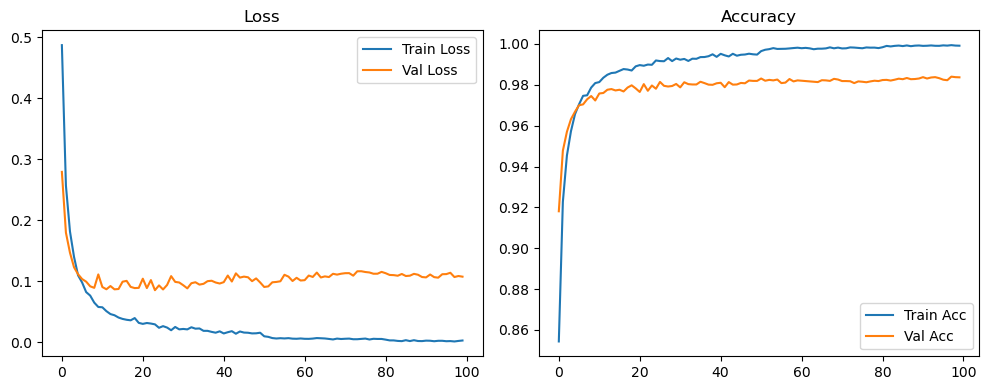

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.7350, Acc: 0.7661 | Val Loss: 0.3073, Acc: 0.9124


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.4066, Acc: 0.8785 | Val Loss: 0.2267, Acc: 0.9347


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3139, Acc: 0.9080 | Val Loss: 0.1818, Acc: 0.9466


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2596, Acc: 0.9216 | Val Loss: 0.1518, Acc: 0.9555


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2295, Acc: 0.9328 | Val Loss: 0.1387, Acc: 0.9602


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2029, Acc: 0.9397 | Val Loss: 0.1231, Acc: 0.9640


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1867, Acc: 0.9454 | Val Loss: 0.1178, Acc: 0.9642


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1748, Acc: 0.9473 | Val Loss: 0.1123, Acc: 0.9677


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1631, Acc: 0.9519 | Val Loss: 0.1055, Acc: 0.9676


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1503, Acc: 0.9557 | Val Loss: 0.1029, Acc: 0.9688


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1450, Acc: 0.9563 | Val Loss: 0.1041, Acc: 0.9701


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1390, Acc: 0.9575 | Val Loss: 0.0954, Acc: 0.9719


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1280, Acc: 0.9612 | Val Loss: 0.0973, Acc: 0.9723


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1292, Acc: 0.9606 | Val Loss: 0.1009, Acc: 0.9712


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1229, Acc: 0.9637 | Val Loss: 0.0893, Acc: 0.9742


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1162, Acc: 0.9652 | Val Loss: 0.0920, Acc: 0.9741


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1173, Acc: 0.9651 | Val Loss: 0.0872, Acc: 0.9748


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1109, Acc: 0.9673 | Val Loss: 0.0824, Acc: 0.9762


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1043, Acc: 0.9671 | Val Loss: 0.0843, Acc: 0.9764


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1023, Acc: 0.9697 | Val Loss: 0.0902, Acc: 0.9746


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0961, Acc: 0.9702 | Val Loss: 0.0885, Acc: 0.9753


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0974, Acc: 0.9700 | Val Loss: 0.0826, Acc: 0.9772


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0999, Acc: 0.9685 | Val Loss: 0.0854, Acc: 0.9763


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0915, Acc: 0.9716 | Val Loss: 0.0815, Acc: 0.9778


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0895, Acc: 0.9717 | Val Loss: 0.0849, Acc: 0.9765


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9746 | Val Loss: 0.0831, Acc: 0.9773


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0855, Acc: 0.9732 | Val Loss: 0.0783, Acc: 0.9777


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9746 | Val Loss: 0.0803, Acc: 0.9773


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0803, Acc: 0.9747 | Val Loss: 0.0786, Acc: 0.9807


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0798, Acc: 0.9745 | Val Loss: 0.0851, Acc: 0.9778


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9763 | Val Loss: 0.0799, Acc: 0.9792


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0746, Acc: 0.9767 | Val Loss: 0.0791, Acc: 0.9806


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0756, Acc: 0.9760 | Val Loss: 0.0771, Acc: 0.9794


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9766 | Val Loss: 0.0816, Acc: 0.9774


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0778, Acc: 0.9764 | Val Loss: 0.0803, Acc: 0.9763


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0693, Acc: 0.9776 | Val Loss: 0.0747, Acc: 0.9802


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0697, Acc: 0.9781 | Val Loss: 0.0768, Acc: 0.9791


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0665, Acc: 0.9789 | Val Loss: 0.0749, Acc: 0.9805


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0685, Acc: 0.9784 | Val Loss: 0.0773, Acc: 0.9790


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0674, Acc: 0.9795 | Val Loss: 0.0775, Acc: 0.9800


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0661, Acc: 0.9789 | Val Loss: 0.0771, Acc: 0.9788


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0621, Acc: 0.9804 | Val Loss: 0.0811, Acc: 0.9795


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0665, Acc: 0.9791 | Val Loss: 0.0771, Acc: 0.9796


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9813 | Val Loss: 0.0764, Acc: 0.9799


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0602, Acc: 0.9806 | Val Loss: 0.0760, Acc: 0.9802


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9807 | Val Loss: 0.0760, Acc: 0.9796


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9819 | Val Loss: 0.0784, Acc: 0.9796


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9817 | Val Loss: 0.0788, Acc: 0.9798


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0583, Acc: 0.9815 | Val Loss: 0.0785, Acc: 0.9807


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0538, Acc: 0.9832 | Val Loss: 0.0809, Acc: 0.9795


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0485, Acc: 0.9847 | Val Loss: 0.0754, Acc: 0.9812


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0479, Acc: 0.9846 | Val Loss: 0.0778, Acc: 0.9799


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0430, Acc: 0.9856 | Val Loss: 0.0777, Acc: 0.9802


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9863 | Val Loss: 0.0793, Acc: 0.9803


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9876 | Val Loss: 0.0772, Acc: 0.9806


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0409, Acc: 0.9868 | Val Loss: 0.0779, Acc: 0.9803


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9874 | Val Loss: 0.0772, Acc: 0.9806


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9863 | Val Loss: 0.0786, Acc: 0.9802


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9871 | Val Loss: 0.0777, Acc: 0.9811


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9877 | Val Loss: 0.0773, Acc: 0.9808


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9880 | Val Loss: 0.0800, Acc: 0.9806


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9874 | Val Loss: 0.0793, Acc: 0.9808


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9882 | Val Loss: 0.0778, Acc: 0.9813


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9872 | Val Loss: 0.0798, Acc: 0.9810


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9881 | Val Loss: 0.0803, Acc: 0.9816


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9876 | Val Loss: 0.0824, Acc: 0.9808


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9874 | Val Loss: 0.0816, Acc: 0.9812


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9877 | Val Loss: 0.0844, Acc: 0.9809


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9888 | Val Loss: 0.0839, Acc: 0.9809


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9892 | Val Loss: 0.0811, Acc: 0.9822


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9890 | Val Loss: 0.0840, Acc: 0.9812


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9882 | Val Loss: 0.0832, Acc: 0.9812


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9888 | Val Loss: 0.0818, Acc: 0.9818


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9886 | Val Loss: 0.0817, Acc: 0.9804


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9884 | Val Loss: 0.0826, Acc: 0.9806


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9888 | Val Loss: 0.0870, Acc: 0.9802


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9900 | Val Loss: 0.0853, Acc: 0.9813


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9899 | Val Loss: 0.0892, Acc: 0.9804


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9887 | Val Loss: 0.0832, Acc: 0.9809


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9894 | Val Loss: 0.0823, Acc: 0.9822


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9896 | Val Loss: 0.0815, Acc: 0.9816


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9912 | Val Loss: 0.0812, Acc: 0.9818


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0296, Acc: 0.9905 | Val Loss: 0.0851, Acc: 0.9811


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9912 | Val Loss: 0.0826, Acc: 0.9817


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9916 | Val Loss: 0.0858, Acc: 0.9820


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9906 | Val Loss: 0.0842, Acc: 0.9812


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.0833, Acc: 0.9820


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9921 | Val Loss: 0.0853, Acc: 0.9812


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9919 | Val Loss: 0.0869, Acc: 0.9814


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9923 | Val Loss: 0.0869, Acc: 0.9819


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9910 | Val Loss: 0.0888, Acc: 0.9819


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9923 | Val Loss: 0.0879, Acc: 0.9817


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9929 | Val Loss: 0.0866, Acc: 0.9818


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9920 | Val Loss: 0.0853, Acc: 0.9818


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9921 | Val Loss: 0.0878, Acc: 0.9812


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9922 | Val Loss: 0.0878, Acc: 0.9815


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9929 | Val Loss: 0.0864, Acc: 0.9817


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9927 | Val Loss: 0.0875, Acc: 0.9818


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9920 | Val Loss: 0.0893, Acc: 0.9818


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9924 | Val Loss: 0.0889, Acc: 0.9819


Final Test Loss: 0.0722 Accuracy: 0.9826


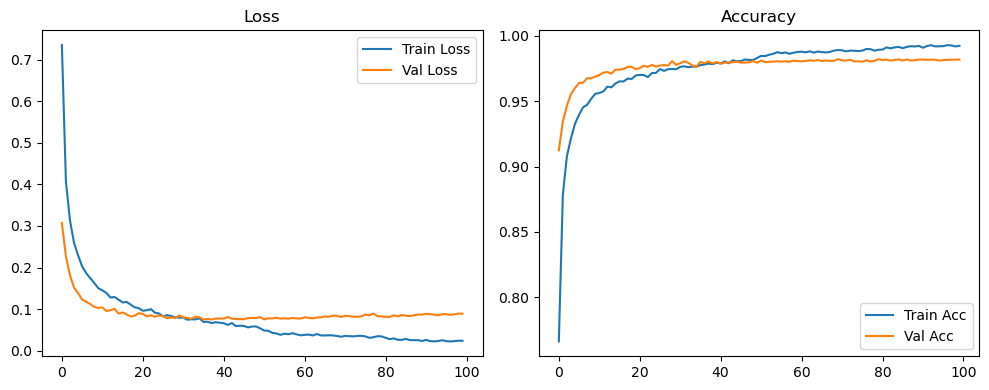

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3876, Acc: 0.8875 | Val Loss: 0.2848, Acc: 0.9138


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1827, Acc: 0.9441 | Val Loss: 0.1756, Acc: 0.9493


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1190, Acc: 0.9639 | Val Loss: 0.1343, Acc: 0.9605


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9726 | Val Loss: 0.1165, Acc: 0.9657


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0654, Acc: 0.9788 | Val Loss: 0.1137, Acc: 0.9651


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9835 | Val Loss: 0.1093, Acc: 0.9702


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9855 | Val Loss: 0.0953, Acc: 0.9723


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9880 | Val Loss: 0.1116, Acc: 0.9698


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9898 | Val Loss: 0.0961, Acc: 0.9751


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9912 | Val Loss: 0.1363, Acc: 0.9673


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9917 | Val Loss: 0.1156, Acc: 0.9719


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.1375, Acc: 0.9676


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.1014, Acc: 0.9763


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.1674, Acc: 0.9652


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9947 | Val Loss: 0.1256, Acc: 0.9746


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9933 | Val Loss: 0.1251, Acc: 0.9736


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.1450, Acc: 0.9706


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.1164, Acc: 0.9748


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.1396, Acc: 0.9728


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.1266, Acc: 0.9757


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9959 | Val Loss: 0.1356, Acc: 0.9729


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.1344, Acc: 0.9741


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1319, Acc: 0.9750


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.1433, Acc: 0.9751


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.1374, Acc: 0.9750


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.1246, Acc: 0.9782


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1473, Acc: 0.9746


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9956 | Val Loss: 0.1503, Acc: 0.9740


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1214, Acc: 0.9799


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1465, Acc: 0.9767


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1544, Acc: 0.9744


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1431, Acc: 0.9757


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.1540, Acc: 0.9765


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1747, Acc: 0.9715


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1340, Acc: 0.9772


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1446, Acc: 0.9768


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1672, Acc: 0.9753


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9968 | Val Loss: 0.1804, Acc: 0.9736


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9971 | Val Loss: 0.1459, Acc: 0.9764


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1634, Acc: 0.9756


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1824, Acc: 0.9709


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1686, Acc: 0.9741


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1645, Acc: 0.9769


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1586, Acc: 0.9782


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1619, Acc: 0.9752


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1626, Acc: 0.9782


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1608, Acc: 0.9770


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1598, Acc: 0.9791


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1531, Acc: 0.9783


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1578, Acc: 0.9783


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1392, Acc: 0.9795


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1406, Acc: 0.9806


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1380, Acc: 0.9800


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1345, Acc: 0.9808


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1365, Acc: 0.9799


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1357, Acc: 0.9813


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1381, Acc: 0.9808


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1371, Acc: 0.9813


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1466, Acc: 0.9798


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1553, Acc: 0.9792


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1511, Acc: 0.9797


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1578, Acc: 0.9771


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1685, Acc: 0.9774


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1639, Acc: 0.9778


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1686, Acc: 0.9790


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1619, Acc: 0.9798


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1574, Acc: 0.9792


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1640, Acc: 0.9783


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1579, Acc: 0.9799


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1574, Acc: 0.9812


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1581, Acc: 0.9805


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.1675, Acc: 0.9797


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1621, Acc: 0.9792


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1668, Acc: 0.9778


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1583, Acc: 0.9787


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.1572, Acc: 0.9796


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1473, Acc: 0.9805


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1645, Acc: 0.9785


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1708, Acc: 0.9800


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1578, Acc: 0.9804


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1490, Acc: 0.9812


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1476, Acc: 0.9817


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1469, Acc: 0.9819


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1455, Acc: 0.9812


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1429, Acc: 0.9816


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1428, Acc: 0.9815


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1435, Acc: 0.9813


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1446, Acc: 0.9822


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1447, Acc: 0.9817


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1423, Acc: 0.9814


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1450, Acc: 0.9818


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1449, Acc: 0.9823


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1438, Acc: 0.9822


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1448, Acc: 0.9824


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1421, Acc: 0.9822


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1445, Acc: 0.9817


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1438, Acc: 0.9818


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1404, Acc: 0.9818


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1410, Acc: 0.9824


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1356, Acc: 0.9820


Final Test Loss: 0.1442 Accuracy: 0.9827


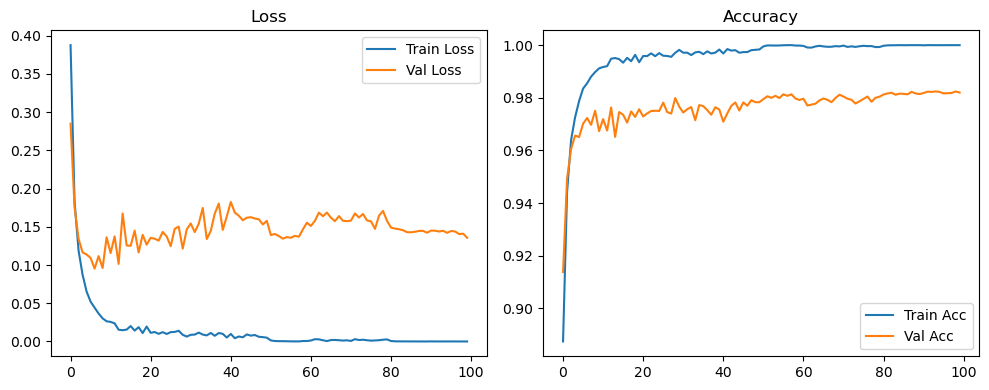

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4874, Acc: 0.8544 | Val Loss: 0.2797, Acc: 0.9181


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2571, Acc: 0.9227 | Val Loss: 0.1800, Acc: 0.9477


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1820, Acc: 0.9454 | Val Loss: 0.1472, Acc: 0.9570


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1404, Acc: 0.9573 | Val Loss: 0.1233, Acc: 0.9632


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1101, Acc: 0.9656 | Val Loss: 0.1119, Acc: 0.9668


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0983, Acc: 0.9705 | Val Loss: 0.1040, Acc: 0.9700


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0826, Acc: 0.9746 | Val Loss: 0.0997, Acc: 0.9704


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0769, Acc: 0.9749 | Val Loss: 0.0921, Acc: 0.9729


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0653, Acc: 0.9786 | Val Loss: 0.0896, Acc: 0.9745


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9809 | Val Loss: 0.1116, Acc: 0.9723


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9813 | Val Loss: 0.0910, Acc: 0.9758


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9835 | Val Loss: 0.0872, Acc: 0.9760


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9849 | Val Loss: 0.0925, Acc: 0.9776


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9858 | Val Loss: 0.0871, Acc: 0.9779


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9860 | Val Loss: 0.0877, Acc: 0.9772


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9869 | Val Loss: 0.0996, Acc: 0.9776


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0372, Acc: 0.9877 | Val Loss: 0.1010, Acc: 0.9768


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9875 | Val Loss: 0.0911, Acc: 0.9787


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9870 | Val Loss: 0.0892, Acc: 0.9798


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9890 | Val Loss: 0.0895, Acc: 0.9782


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9896 | Val Loss: 0.1046, Acc: 0.9765


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9893 | Val Loss: 0.0892, Acc: 0.9803


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9899 | Val Loss: 0.1023, Acc: 0.9771


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9898 | Val Loss: 0.0857, Acc: 0.9797


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.0936, Acc: 0.9781


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9916 | Val Loss: 0.0869, Acc: 0.9814


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9915 | Val Loss: 0.0942, Acc: 0.9795


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9931 | Val Loss: 0.1088, Acc: 0.9792


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9916 | Val Loss: 0.0993, Acc: 0.9794


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9929 | Val Loss: 0.0983, Acc: 0.9804


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9923 | Val Loss: 0.0938, Acc: 0.9788


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9927 | Val Loss: 0.0887, Acc: 0.9812


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9917 | Val Loss: 0.0971, Acc: 0.9803


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9928 | Val Loss: 0.0987, Acc: 0.9802


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9927 | Val Loss: 0.0949, Acc: 0.9802


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.0962, Acc: 0.9815


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.1005, Acc: 0.9808


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9940 | Val Loss: 0.1012, Acc: 0.9801


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.0983, Acc: 0.9800


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9937 | Val Loss: 0.0967, Acc: 0.9808


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.0989, Acc: 0.9810


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.1097, Acc: 0.9788


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.0999, Acc: 0.9813


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.1133, Acc: 0.9801


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.1064, Acc: 0.9802


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.1080, Acc: 0.9809


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.1069, Acc: 0.9808


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.1005, Acc: 0.9821


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.1050, Acc: 0.9819


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.0984, Acc: 0.9819


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0910, Acc: 0.9831


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.0919, Acc: 0.9820


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0987, Acc: 0.9824


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0993, Acc: 0.9822


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1003, Acc: 0.9826


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.1110, Acc: 0.9808


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1079, Acc: 0.9811


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.1008, Acc: 0.9828


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1060, Acc: 0.9817


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9982 | Val Loss: 0.1016, Acc: 0.9822


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1022, Acc: 0.9820


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1097, Acc: 0.9818


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1074, Acc: 0.9817


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9974 | Val Loss: 0.1146, Acc: 0.9815


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1066, Acc: 0.9813


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.1083, Acc: 0.9822


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9978 | Val Loss: 0.1073, Acc: 0.9822


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1126, Acc: 0.9819


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1113, Acc: 0.9829


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1127, Acc: 0.9826


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.1136, Acc: 0.9818


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1137, Acc: 0.9818


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1095, Acc: 0.9818


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1167, Acc: 0.9808


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1168, Acc: 0.9817


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1155, Acc: 0.9815


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1148, Acc: 0.9812


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1127, Acc: 0.9817


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1127, Acc: 0.9820


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1157, Acc: 0.9818


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1130, Acc: 0.9826


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1111, Acc: 0.9828


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1109, Acc: 0.9828


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1098, Acc: 0.9829


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1117, Acc: 0.9829


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1096, Acc: 0.9830


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1095, Acc: 0.9829


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1131, Acc: 0.9828


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1107, Acc: 0.9829


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.1073, Acc: 0.9835


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1084, Acc: 0.9833


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1091, Acc: 0.9828


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.1064, Acc: 0.9834


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1049, Acc: 0.9833


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1083, Acc: 0.9834


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1066, Acc: 0.9831


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1108, Acc: 0.9821


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1079, Acc: 0.9833


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1087, Acc: 0.9831


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1060, Acc: 0.9835


Final Test Loss: 0.0895 Accuracy: 0.9842


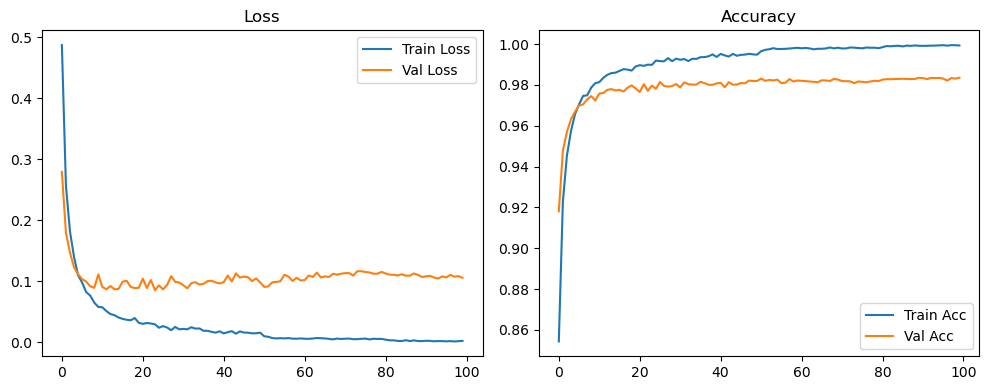

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.7350, Acc: 0.7661 | Val Loss: 0.3073, Acc: 0.9124


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.4066, Acc: 0.8785 | Val Loss: 0.2267, Acc: 0.9347


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3139, Acc: 0.9080 | Val Loss: 0.1818, Acc: 0.9466


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2596, Acc: 0.9216 | Val Loss: 0.1518, Acc: 0.9555


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2295, Acc: 0.9328 | Val Loss: 0.1387, Acc: 0.9602


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2029, Acc: 0.9397 | Val Loss: 0.1231, Acc: 0.9640


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1867, Acc: 0.9454 | Val Loss: 0.1178, Acc: 0.9642


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1748, Acc: 0.9473 | Val Loss: 0.1123, Acc: 0.9677


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1631, Acc: 0.9519 | Val Loss: 0.1055, Acc: 0.9676


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1503, Acc: 0.9557 | Val Loss: 0.1029, Acc: 0.9688


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1450, Acc: 0.9563 | Val Loss: 0.1041, Acc: 0.9701


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1390, Acc: 0.9575 | Val Loss: 0.0954, Acc: 0.9719


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1280, Acc: 0.9612 | Val Loss: 0.0973, Acc: 0.9723


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1292, Acc: 0.9606 | Val Loss: 0.1009, Acc: 0.9712


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1229, Acc: 0.9637 | Val Loss: 0.0893, Acc: 0.9742


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1162, Acc: 0.9652 | Val Loss: 0.0920, Acc: 0.9741


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1173, Acc: 0.9651 | Val Loss: 0.0872, Acc: 0.9748


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1109, Acc: 0.9673 | Val Loss: 0.0824, Acc: 0.9762


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1043, Acc: 0.9671 | Val Loss: 0.0843, Acc: 0.9764


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1023, Acc: 0.9697 | Val Loss: 0.0902, Acc: 0.9746


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0961, Acc: 0.9702 | Val Loss: 0.0885, Acc: 0.9753


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0974, Acc: 0.9700 | Val Loss: 0.0826, Acc: 0.9772


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0999, Acc: 0.9685 | Val Loss: 0.0854, Acc: 0.9763


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0915, Acc: 0.9716 | Val Loss: 0.0815, Acc: 0.9778


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0895, Acc: 0.9717 | Val Loss: 0.0849, Acc: 0.9765


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9746 | Val Loss: 0.0831, Acc: 0.9773


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0855, Acc: 0.9732 | Val Loss: 0.0783, Acc: 0.9777


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9746 | Val Loss: 0.0803, Acc: 0.9773


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0803, Acc: 0.9747 | Val Loss: 0.0786, Acc: 0.9807


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0798, Acc: 0.9745 | Val Loss: 0.0851, Acc: 0.9778


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9763 | Val Loss: 0.0799, Acc: 0.9792


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0746, Acc: 0.9767 | Val Loss: 0.0791, Acc: 0.9806


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0756, Acc: 0.9760 | Val Loss: 0.0771, Acc: 0.9794


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9766 | Val Loss: 0.0816, Acc: 0.9774


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0778, Acc: 0.9764 | Val Loss: 0.0803, Acc: 0.9763


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0693, Acc: 0.9776 | Val Loss: 0.0747, Acc: 0.9802


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0697, Acc: 0.9781 | Val Loss: 0.0768, Acc: 0.9791


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0665, Acc: 0.9789 | Val Loss: 0.0749, Acc: 0.9805


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0685, Acc: 0.9784 | Val Loss: 0.0773, Acc: 0.9790


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0674, Acc: 0.9795 | Val Loss: 0.0775, Acc: 0.9800


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0661, Acc: 0.9789 | Val Loss: 0.0771, Acc: 0.9788


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0621, Acc: 0.9804 | Val Loss: 0.0811, Acc: 0.9795


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0665, Acc: 0.9791 | Val Loss: 0.0771, Acc: 0.9796


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9813 | Val Loss: 0.0764, Acc: 0.9799


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0602, Acc: 0.9806 | Val Loss: 0.0760, Acc: 0.9802


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9807 | Val Loss: 0.0760, Acc: 0.9796


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9819 | Val Loss: 0.0784, Acc: 0.9796


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9817 | Val Loss: 0.0788, Acc: 0.9798


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0583, Acc: 0.9815 | Val Loss: 0.0785, Acc: 0.9807


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0538, Acc: 0.9832 | Val Loss: 0.0809, Acc: 0.9795


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0485, Acc: 0.9847 | Val Loss: 0.0754, Acc: 0.9812


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0479, Acc: 0.9846 | Val Loss: 0.0778, Acc: 0.9799


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0430, Acc: 0.9856 | Val Loss: 0.0777, Acc: 0.9802


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9863 | Val Loss: 0.0793, Acc: 0.9803


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9876 | Val Loss: 0.0772, Acc: 0.9806


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0409, Acc: 0.9868 | Val Loss: 0.0779, Acc: 0.9803


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9874 | Val Loss: 0.0772, Acc: 0.9806


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9863 | Val Loss: 0.0786, Acc: 0.9802


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9871 | Val Loss: 0.0777, Acc: 0.9811


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9877 | Val Loss: 0.0773, Acc: 0.9808


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9880 | Val Loss: 0.0800, Acc: 0.9806


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9874 | Val Loss: 0.0793, Acc: 0.9808


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9882 | Val Loss: 0.0778, Acc: 0.9813


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9872 | Val Loss: 0.0798, Acc: 0.9810


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9881 | Val Loss: 0.0803, Acc: 0.9816


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9876 | Val Loss: 0.0824, Acc: 0.9808


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9874 | Val Loss: 0.0816, Acc: 0.9812


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9877 | Val Loss: 0.0844, Acc: 0.9809


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9888 | Val Loss: 0.0839, Acc: 0.9809


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9892 | Val Loss: 0.0811, Acc: 0.9822


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9890 | Val Loss: 0.0840, Acc: 0.9812


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9882 | Val Loss: 0.0832, Acc: 0.9812


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9888 | Val Loss: 0.0818, Acc: 0.9818


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9886 | Val Loss: 0.0817, Acc: 0.9804


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9884 | Val Loss: 0.0826, Acc: 0.9806


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9888 | Val Loss: 0.0870, Acc: 0.9802


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9900 | Val Loss: 0.0853, Acc: 0.9813


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9899 | Val Loss: 0.0892, Acc: 0.9804


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9887 | Val Loss: 0.0832, Acc: 0.9809


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9894 | Val Loss: 0.0823, Acc: 0.9822


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9897 | Val Loss: 0.0817, Acc: 0.9818


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0280, Acc: 0.9911 | Val Loss: 0.0809, Acc: 0.9818


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0300, Acc: 0.9904 | Val Loss: 0.0835, Acc: 0.9815


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9913 | Val Loss: 0.0818, Acc: 0.9818


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0265, Acc: 0.9917 | Val Loss: 0.0845, Acc: 0.9819


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9908 | Val Loss: 0.0831, Acc: 0.9817


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9919 | Val Loss: 0.0822, Acc: 0.9818


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9922 | Val Loss: 0.0843, Acc: 0.9811


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9920 | Val Loss: 0.0850, Acc: 0.9815


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0234, Acc: 0.9925 | Val Loss: 0.0845, Acc: 0.9820


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9913 | Val Loss: 0.0870, Acc: 0.9814


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9926 | Val Loss: 0.0860, Acc: 0.9814


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9928 | Val Loss: 0.0853, Acc: 0.9816


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0231, Acc: 0.9923 | Val Loss: 0.0846, Acc: 0.9817


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9922 | Val Loss: 0.0864, Acc: 0.9814


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9924 | Val Loss: 0.0859, Acc: 0.9813


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9932 | Val Loss: 0.0850, Acc: 0.9817


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0232, Acc: 0.9929 | Val Loss: 0.0857, Acc: 0.9816


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9921 | Val Loss: 0.0875, Acc: 0.9815


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0235, Acc: 0.9926 | Val Loss: 0.0867, Acc: 0.9818


Final Test Loss: 0.0709 Accuracy: 0.9825


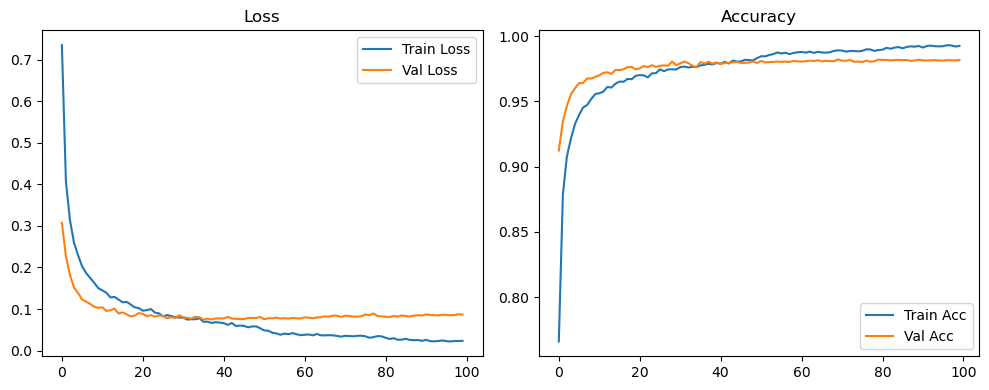

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3876, Acc: 0.8875 | Val Loss: 0.2848, Acc: 0.9138


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1827, Acc: 0.9441 | Val Loss: 0.1756, Acc: 0.9493


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1190, Acc: 0.9639 | Val Loss: 0.1343, Acc: 0.9605


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9726 | Val Loss: 0.1165, Acc: 0.9657


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0654, Acc: 0.9788 | Val Loss: 0.1137, Acc: 0.9651


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9835 | Val Loss: 0.1093, Acc: 0.9702


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9855 | Val Loss: 0.0953, Acc: 0.9723


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9880 | Val Loss: 0.1116, Acc: 0.9698


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9898 | Val Loss: 0.0961, Acc: 0.9751


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9912 | Val Loss: 0.1363, Acc: 0.9673


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9917 | Val Loss: 0.1156, Acc: 0.9719


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.1375, Acc: 0.9676


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.1014, Acc: 0.9763


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.1674, Acc: 0.9652


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9947 | Val Loss: 0.1256, Acc: 0.9746


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9933 | Val Loss: 0.1251, Acc: 0.9736


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.1450, Acc: 0.9706


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.1164, Acc: 0.9748


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.1396, Acc: 0.9728


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.1266, Acc: 0.9757


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9959 | Val Loss: 0.1356, Acc: 0.9729


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.1344, Acc: 0.9741


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1319, Acc: 0.9750


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.1433, Acc: 0.9751


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.1374, Acc: 0.9750


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.1246, Acc: 0.9782


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1473, Acc: 0.9746


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9956 | Val Loss: 0.1503, Acc: 0.9740


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1214, Acc: 0.9799


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1465, Acc: 0.9767


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1544, Acc: 0.9744


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1431, Acc: 0.9757


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.1540, Acc: 0.9765


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1747, Acc: 0.9715


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1340, Acc: 0.9772


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1446, Acc: 0.9768


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1672, Acc: 0.9753


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9968 | Val Loss: 0.1804, Acc: 0.9736


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9971 | Val Loss: 0.1459, Acc: 0.9764


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1634, Acc: 0.9756


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1824, Acc: 0.9709


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1686, Acc: 0.9741


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1645, Acc: 0.9769


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1586, Acc: 0.9782


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1619, Acc: 0.9752


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1626, Acc: 0.9782


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1608, Acc: 0.9770


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1598, Acc: 0.9791


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1531, Acc: 0.9783


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1578, Acc: 0.9783


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1387, Acc: 0.9795


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1361, Acc: 0.9797


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1348, Acc: 0.9801


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1365, Acc: 0.9802


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1325, Acc: 0.9806


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1338, Acc: 0.9802


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1341, Acc: 0.9807


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1336, Acc: 0.9807


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1330, Acc: 0.9806


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1379, Acc: 0.9801


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1358, Acc: 0.9804


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1336, Acc: 0.9808


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1358, Acc: 0.9808


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1345, Acc: 0.9804


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1378, Acc: 0.9808


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1354, Acc: 0.9807


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1317, Acc: 0.9811


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1317, Acc: 0.9816


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1339, Acc: 0.9812


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1343, Acc: 0.9812


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1322, Acc: 0.9818


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1356, Acc: 0.9815


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1447, Acc: 0.9804


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1338, Acc: 0.9804


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1348, Acc: 0.9817


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1343, Acc: 0.9819


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1359, Acc: 0.9813


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1372, Acc: 0.9811


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1369, Acc: 0.9810


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1498, Acc: 0.9794


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1448, Acc: 0.9813


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1470, Acc: 0.9810


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1457, Acc: 0.9812


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1455, Acc: 0.9812


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1455, Acc: 0.9818


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1440, Acc: 0.9814


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1413, Acc: 0.9818


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1435, Acc: 0.9817


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1535, Acc: 0.9815


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1470, Acc: 0.9815


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1457, Acc: 0.9814


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1464, Acc: 0.9809


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1461, Acc: 0.9811


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1452, Acc: 0.9812


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1480, Acc: 0.9809


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1492, Acc: 0.9809


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1483, Acc: 0.9813


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1459, Acc: 0.9813


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1478, Acc: 0.9813


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1477, Acc: 0.9812


Final Test Loss: 0.1373 Accuracy: 0.9832


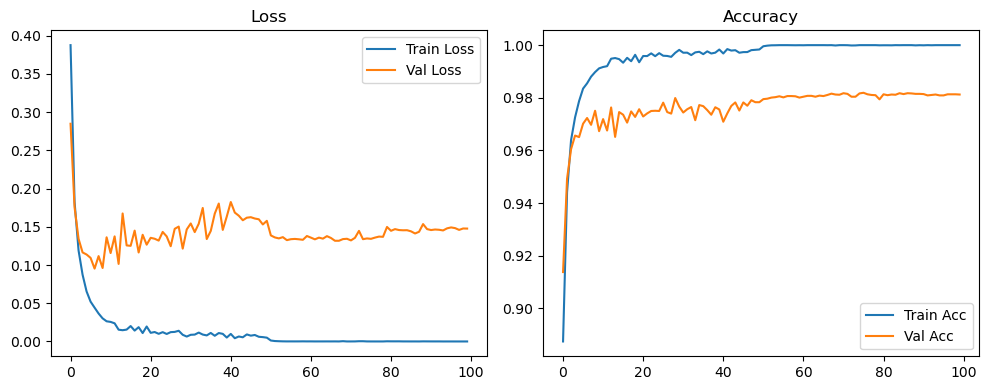

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4874, Acc: 0.8544 | Val Loss: 0.2797, Acc: 0.9181


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2571, Acc: 0.9227 | Val Loss: 0.1800, Acc: 0.9477


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1820, Acc: 0.9454 | Val Loss: 0.1472, Acc: 0.9570


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1404, Acc: 0.9573 | Val Loss: 0.1233, Acc: 0.9632


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1101, Acc: 0.9656 | Val Loss: 0.1119, Acc: 0.9668


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0983, Acc: 0.9705 | Val Loss: 0.1040, Acc: 0.9700


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0826, Acc: 0.9746 | Val Loss: 0.0997, Acc: 0.9704


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0769, Acc: 0.9749 | Val Loss: 0.0921, Acc: 0.9729


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0653, Acc: 0.9786 | Val Loss: 0.0896, Acc: 0.9745


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9809 | Val Loss: 0.1116, Acc: 0.9723


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9813 | Val Loss: 0.0910, Acc: 0.9758


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9835 | Val Loss: 0.0872, Acc: 0.9760


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9849 | Val Loss: 0.0925, Acc: 0.9776


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9858 | Val Loss: 0.0871, Acc: 0.9779


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9860 | Val Loss: 0.0877, Acc: 0.9772


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9869 | Val Loss: 0.0996, Acc: 0.9776


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0372, Acc: 0.9877 | Val Loss: 0.1010, Acc: 0.9768


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9875 | Val Loss: 0.0911, Acc: 0.9787


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9870 | Val Loss: 0.0892, Acc: 0.9798


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9890 | Val Loss: 0.0895, Acc: 0.9782


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9896 | Val Loss: 0.1046, Acc: 0.9765


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9893 | Val Loss: 0.0892, Acc: 0.9803


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9899 | Val Loss: 0.1023, Acc: 0.9771


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9898 | Val Loss: 0.0857, Acc: 0.9797


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.0936, Acc: 0.9781


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9916 | Val Loss: 0.0869, Acc: 0.9814


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9915 | Val Loss: 0.0942, Acc: 0.9795


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9931 | Val Loss: 0.1088, Acc: 0.9792


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9916 | Val Loss: 0.0993, Acc: 0.9794


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9929 | Val Loss: 0.0983, Acc: 0.9804


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9923 | Val Loss: 0.0938, Acc: 0.9788


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9927 | Val Loss: 0.0887, Acc: 0.9812


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9917 | Val Loss: 0.0971, Acc: 0.9803


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9928 | Val Loss: 0.0987, Acc: 0.9802


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9927 | Val Loss: 0.0949, Acc: 0.9802


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.0962, Acc: 0.9815


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.1005, Acc: 0.9808


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9940 | Val Loss: 0.1012, Acc: 0.9801


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.0983, Acc: 0.9800


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9937 | Val Loss: 0.0967, Acc: 0.9808


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.0989, Acc: 0.9810


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.1097, Acc: 0.9788


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.0999, Acc: 0.9813


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.1133, Acc: 0.9801


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.1064, Acc: 0.9802


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.1080, Acc: 0.9809


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.1069, Acc: 0.9808


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.1005, Acc: 0.9821


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.1050, Acc: 0.9819


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.0984, Acc: 0.9819


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0910, Acc: 0.9822


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0899, Acc: 0.9831


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0930, Acc: 0.9832


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0922, Acc: 0.9833


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0931, Acc: 0.9836


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0952, Acc: 0.9839


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0932, Acc: 0.9833


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0927, Acc: 0.9831


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0951, Acc: 0.9822


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.0928, Acc: 0.9832


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.0958, Acc: 0.9835


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.0988, Acc: 0.9830


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0965, Acc: 0.9832


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0974, Acc: 0.9824


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0953, Acc: 0.9832


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.0934, Acc: 0.9837


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0997, Acc: 0.9837


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1003, Acc: 0.9831


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1025, Acc: 0.9832


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1005, Acc: 0.9835


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0981, Acc: 0.9834


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1077, Acc: 0.9824


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1031, Acc: 0.9835


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1028, Acc: 0.9834


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1047, Acc: 0.9830


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1033, Acc: 0.9836


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1059, Acc: 0.9822


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1037, Acc: 0.9823


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1053, Acc: 0.9826


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9989 | Val Loss: 0.1027, Acc: 0.9832


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1045, Acc: 0.9828


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1036, Acc: 0.9838


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1029, Acc: 0.9839


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1027, Acc: 0.9831


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1059, Acc: 0.9832


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1048, Acc: 0.9830


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1024, Acc: 0.9837


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1088, Acc: 0.9831


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1050, Acc: 0.9842


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1012, Acc: 0.9843


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1021, Acc: 0.9843


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1054, Acc: 0.9839


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1045, Acc: 0.9840


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1029, Acc: 0.9839


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1055, Acc: 0.9841


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1045, Acc: 0.9842


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1061, Acc: 0.9835


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1036, Acc: 0.9835


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1055, Acc: 0.9837


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1019, Acc: 0.9843


Final Test Loss: 0.0904 Accuracy: 0.9845


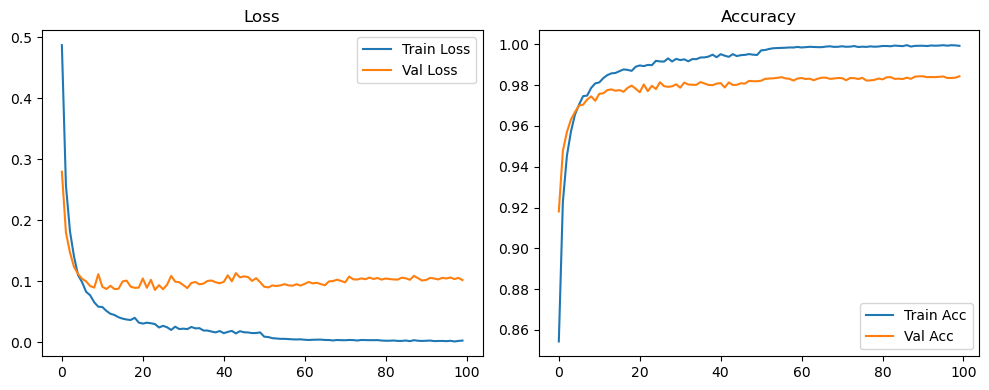

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.7350, Acc: 0.7661 | Val Loss: 0.3073, Acc: 0.9124


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.4066, Acc: 0.8785 | Val Loss: 0.2267, Acc: 0.9347


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3139, Acc: 0.9080 | Val Loss: 0.1818, Acc: 0.9466


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2596, Acc: 0.9216 | Val Loss: 0.1518, Acc: 0.9555


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2295, Acc: 0.9328 | Val Loss: 0.1387, Acc: 0.9602


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2029, Acc: 0.9397 | Val Loss: 0.1231, Acc: 0.9640


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1867, Acc: 0.9454 | Val Loss: 0.1178, Acc: 0.9642


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1748, Acc: 0.9473 | Val Loss: 0.1123, Acc: 0.9677


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1631, Acc: 0.9519 | Val Loss: 0.1055, Acc: 0.9676


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1503, Acc: 0.9557 | Val Loss: 0.1029, Acc: 0.9688


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1450, Acc: 0.9563 | Val Loss: 0.1041, Acc: 0.9701


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1390, Acc: 0.9575 | Val Loss: 0.0954, Acc: 0.9719


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1280, Acc: 0.9612 | Val Loss: 0.0973, Acc: 0.9723


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1292, Acc: 0.9606 | Val Loss: 0.1009, Acc: 0.9712


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1229, Acc: 0.9637 | Val Loss: 0.0893, Acc: 0.9742


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1162, Acc: 0.9652 | Val Loss: 0.0920, Acc: 0.9741


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1173, Acc: 0.9651 | Val Loss: 0.0872, Acc: 0.9748


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1109, Acc: 0.9673 | Val Loss: 0.0824, Acc: 0.9762


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1043, Acc: 0.9671 | Val Loss: 0.0843, Acc: 0.9764


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1023, Acc: 0.9697 | Val Loss: 0.0902, Acc: 0.9746


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0961, Acc: 0.9702 | Val Loss: 0.0885, Acc: 0.9753


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0974, Acc: 0.9700 | Val Loss: 0.0826, Acc: 0.9772


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0999, Acc: 0.9685 | Val Loss: 0.0854, Acc: 0.9763


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0915, Acc: 0.9716 | Val Loss: 0.0815, Acc: 0.9778


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0895, Acc: 0.9717 | Val Loss: 0.0849, Acc: 0.9765


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9746 | Val Loss: 0.0831, Acc: 0.9773


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0855, Acc: 0.9732 | Val Loss: 0.0783, Acc: 0.9777


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9746 | Val Loss: 0.0803, Acc: 0.9773


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0803, Acc: 0.9747 | Val Loss: 0.0786, Acc: 0.9807


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0798, Acc: 0.9745 | Val Loss: 0.0851, Acc: 0.9778


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9763 | Val Loss: 0.0799, Acc: 0.9792


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0746, Acc: 0.9767 | Val Loss: 0.0791, Acc: 0.9806


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0756, Acc: 0.9760 | Val Loss: 0.0771, Acc: 0.9794


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9766 | Val Loss: 0.0816, Acc: 0.9774


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0778, Acc: 0.9764 | Val Loss: 0.0803, Acc: 0.9763


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0693, Acc: 0.9776 | Val Loss: 0.0747, Acc: 0.9802


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0697, Acc: 0.9781 | Val Loss: 0.0768, Acc: 0.9791


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0665, Acc: 0.9789 | Val Loss: 0.0749, Acc: 0.9805


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0685, Acc: 0.9784 | Val Loss: 0.0773, Acc: 0.9790


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0674, Acc: 0.9795 | Val Loss: 0.0775, Acc: 0.9800


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0661, Acc: 0.9789 | Val Loss: 0.0771, Acc: 0.9788


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0621, Acc: 0.9804 | Val Loss: 0.0811, Acc: 0.9795


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0665, Acc: 0.9791 | Val Loss: 0.0771, Acc: 0.9796


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9813 | Val Loss: 0.0764, Acc: 0.9799


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0602, Acc: 0.9806 | Val Loss: 0.0760, Acc: 0.9802


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9807 | Val Loss: 0.0760, Acc: 0.9796


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9819 | Val Loss: 0.0784, Acc: 0.9796


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9817 | Val Loss: 0.0788, Acc: 0.9798


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0583, Acc: 0.9815 | Val Loss: 0.0785, Acc: 0.9807


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0538, Acc: 0.9832 | Val Loss: 0.0809, Acc: 0.9795


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0479, Acc: 0.9853 | Val Loss: 0.0751, Acc: 0.9808


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0470, Acc: 0.9850 | Val Loss: 0.0765, Acc: 0.9803


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0424, Acc: 0.9861 | Val Loss: 0.0761, Acc: 0.9805


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0400, Acc: 0.9869 | Val Loss: 0.0764, Acc: 0.9802


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9884 | Val Loss: 0.0760, Acc: 0.9810


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0387, Acc: 0.9879 | Val Loss: 0.0755, Acc: 0.9811


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0370, Acc: 0.9878 | Val Loss: 0.0756, Acc: 0.9812


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0392, Acc: 0.9870 | Val Loss: 0.0772, Acc: 0.9812


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0360, Acc: 0.9880 | Val Loss: 0.0763, Acc: 0.9808


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0342, Acc: 0.9893 | Val Loss: 0.0759, Acc: 0.9808


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9890 | Val Loss: 0.0784, Acc: 0.9800


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0358, Acc: 0.9884 | Val Loss: 0.0773, Acc: 0.9814


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0334, Acc: 0.9896 | Val Loss: 0.0765, Acc: 0.9809


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0356, Acc: 0.9883 | Val Loss: 0.0774, Acc: 0.9807


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0332, Acc: 0.9889 | Val Loss: 0.0782, Acc: 0.9814


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9894 | Val Loss: 0.0805, Acc: 0.9812


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0333, Acc: 0.9885 | Val Loss: 0.0793, Acc: 0.9806


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0327, Acc: 0.9892 | Val Loss: 0.0805, Acc: 0.9812


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9897 | Val Loss: 0.0799, Acc: 0.9812


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9898 | Val Loss: 0.0797, Acc: 0.9812


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9900 | Val Loss: 0.0817, Acc: 0.9808


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0306, Acc: 0.9902 | Val Loss: 0.0825, Acc: 0.9811


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9901 | Val Loss: 0.0807, Acc: 0.9815


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0326, Acc: 0.9896 | Val Loss: 0.0788, Acc: 0.9815


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9902 | Val Loss: 0.0785, Acc: 0.9819


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9906 | Val Loss: 0.0817, Acc: 0.9812


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9910 | Val Loss: 0.0818, Acc: 0.9814


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9906 | Val Loss: 0.0820, Acc: 0.9815


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9901 | Val Loss: 0.0802, Acc: 0.9815


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9904 | Val Loss: 0.0807, Acc: 0.9813


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0294, Acc: 0.9904 | Val Loss: 0.0798, Acc: 0.9816


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9915 | Val Loss: 0.0788, Acc: 0.9813


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9908 | Val Loss: 0.0823, Acc: 0.9810


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9916 | Val Loss: 0.0802, Acc: 0.9814


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9914 | Val Loss: 0.0829, Acc: 0.9817


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0283, Acc: 0.9907 | Val Loss: 0.0809, Acc: 0.9812


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0267, Acc: 0.9910 | Val Loss: 0.0804, Acc: 0.9816


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9914 | Val Loss: 0.0828, Acc: 0.9810


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0267, Acc: 0.9918 | Val Loss: 0.0832, Acc: 0.9808


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9915 | Val Loss: 0.0825, Acc: 0.9817


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0269, Acc: 0.9914 | Val Loss: 0.0850, Acc: 0.9818


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0241, Acc: 0.9921 | Val Loss: 0.0836, Acc: 0.9817


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9922 | Val Loss: 0.0828, Acc: 0.9818


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9924 | Val Loss: 0.0825, Acc: 0.9812


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9917 | Val Loss: 0.0838, Acc: 0.9819


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0241, Acc: 0.9922 | Val Loss: 0.0845, Acc: 0.9810


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0234, Acc: 0.9923 | Val Loss: 0.0834, Acc: 0.9815


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9921 | Val Loss: 0.0841, Acc: 0.9812


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9916 | Val Loss: 0.0853, Acc: 0.9815


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9915 | Val Loss: 0.0845, Acc: 0.9818


Final Test Loss: 0.0705 Accuracy: 0.9833


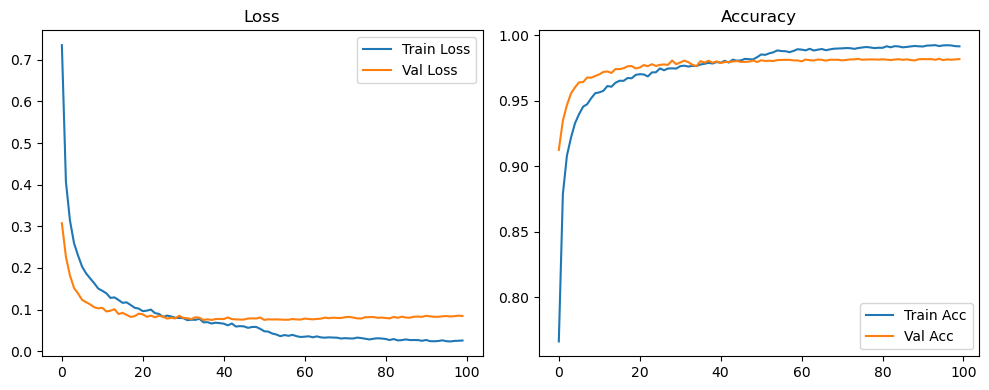

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4029, Acc: 0.8927 | Val Loss: 0.2905, Acc: 0.9124


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1997, Acc: 0.9397 | Val Loss: 0.2060, Acc: 0.9391


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1324, Acc: 0.9597 | Val Loss: 0.1502, Acc: 0.9543


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0954, Acc: 0.9706 | Val Loss: 0.1177, Acc: 0.9645


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0714, Acc: 0.9775 | Val Loss: 0.1167, Acc: 0.9628


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0588, Acc: 0.9809 | Val Loss: 0.1105, Acc: 0.9662


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0469, Acc: 0.9850 | Val Loss: 0.1078, Acc: 0.9688


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9874 | Val Loss: 0.0938, Acc: 0.9722


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9887 | Val Loss: 0.0948, Acc: 0.9732


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9915 | Val Loss: 0.1009, Acc: 0.9729


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9914 | Val Loss: 0.1137, Acc: 0.9695


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9919 | Val Loss: 0.0964, Acc: 0.9742


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9933 | Val Loss: 0.1049, Acc: 0.9728


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9940 | Val Loss: 0.1220, Acc: 0.9716


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9948 | Val Loss: 0.1037, Acc: 0.9736


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.1007, Acc: 0.9755


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.1252, Acc: 0.9720


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1189, Acc: 0.9718


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9946 | Val Loss: 0.1172, Acc: 0.9729


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.1271, Acc: 0.9707


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9956 | Val Loss: 0.1546, Acc: 0.9662


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9961 | Val Loss: 0.1090, Acc: 0.9759


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1185, Acc: 0.9759


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.1325, Acc: 0.9750


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.1330, Acc: 0.9732


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.1414, Acc: 0.9717


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.1188, Acc: 0.9757


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1273, Acc: 0.9761


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.1539, Acc: 0.9711


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.1200, Acc: 0.9766


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1161, Acc: 0.9769


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1342, Acc: 0.9752


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1509, Acc: 0.9734


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.1292, Acc: 0.9773


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1276, Acc: 0.9771


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.1382, Acc: 0.9749


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1317, Acc: 0.9770


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9975 | Val Loss: 0.1278, Acc: 0.9787


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.1201, Acc: 0.9776


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1299, Acc: 0.9760


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1521, Acc: 0.9729


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.1377, Acc: 0.9768


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1212, Acc: 0.9782


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1267, Acc: 0.9766


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1751, Acc: 0.9713


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1403, Acc: 0.9763


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1246, Acc: 0.9790


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1433, Acc: 0.9770


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1405, Acc: 0.9778


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1493, Acc: 0.9758


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1711, Acc: 0.9742


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1473, Acc: 0.9763


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1403, Acc: 0.9774


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.1474, Acc: 0.9780


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1514, Acc: 0.9766


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1281, Acc: 0.9795


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1348, Acc: 0.9794


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1411, Acc: 0.9792


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1555, Acc: 0.9775


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1634, Acc: 0.9761


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9973 | Val Loss: 0.1620, Acc: 0.9772


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9967 | Val Loss: 0.1525, Acc: 0.9761


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1344, Acc: 0.9790


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1374, Acc: 0.9795


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1556, Acc: 0.9772


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1635, Acc: 0.9755


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1606, Acc: 0.9780


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1596, Acc: 0.9777


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1501, Acc: 0.9798


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.1515, Acc: 0.9793


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1571, Acc: 0.9778


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1574, Acc: 0.9791


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1683, Acc: 0.9785


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1710, Acc: 0.9768


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1556, Acc: 0.9784


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1691, Acc: 0.9769


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.1577, Acc: 0.9774


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.1545, Acc: 0.9801


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1387, Acc: 0.9822


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1438, Acc: 0.9819


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1418, Acc: 0.9809


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1498, Acc: 0.9793


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9990 | Val Loss: 0.1761, Acc: 0.9773


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9972 | Val Loss: 0.1881, Acc: 0.9755


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1635, Acc: 0.9792


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.1507, Acc: 0.9792


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1646, Acc: 0.9775


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1433, Acc: 0.9800


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1486, Acc: 0.9798


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1624, Acc: 0.9788


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1473, Acc: 0.9805


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.1506, Acc: 0.9803


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1748, Acc: 0.9773


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1690, Acc: 0.9782


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1610, Acc: 0.9788


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1595, Acc: 0.9790


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1825, Acc: 0.9773


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9986 | Val Loss: 0.1751, Acc: 0.9782


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1577, Acc: 0.9801


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1542, Acc: 0.9803


Final Test Loss: 0.1450 Accuracy: 0.9799


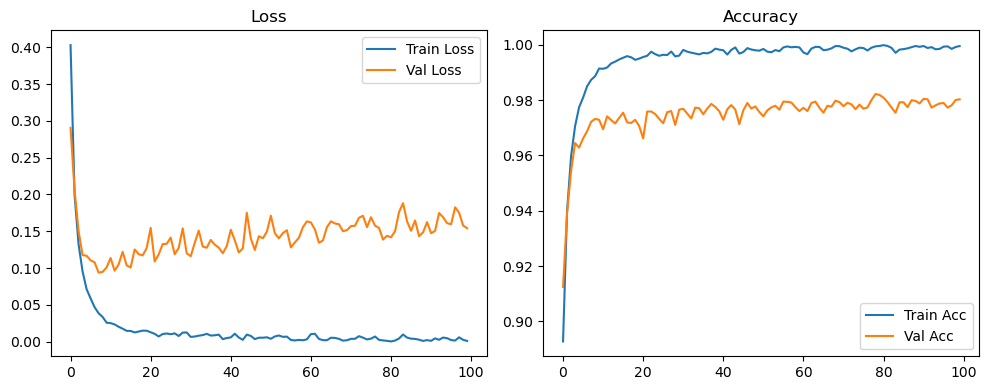

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.5254, Acc: 0.8517 | Val Loss: 0.2852, Acc: 0.9164


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2934, Acc: 0.9121 | Val Loss: 0.2077, Acc: 0.9397


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2219, Acc: 0.9330 | Val Loss: 0.1807, Acc: 0.9477


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1744, Acc: 0.9470 | Val Loss: 0.1479, Acc: 0.9547


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1364, Acc: 0.9583 | Val Loss: 0.1244, Acc: 0.9621


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1200, Acc: 0.9628 | Val Loss: 0.1173, Acc: 0.9650


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1019, Acc: 0.9680 | Val Loss: 0.1058, Acc: 0.9682


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0919, Acc: 0.9697 | Val Loss: 0.1016, Acc: 0.9703


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0809, Acc: 0.9748 | Val Loss: 0.0921, Acc: 0.9726


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0708, Acc: 0.9771 | Val Loss: 0.1018, Acc: 0.9715


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0683, Acc: 0.9779 | Val Loss: 0.0893, Acc: 0.9753


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0575, Acc: 0.9806 | Val Loss: 0.0916, Acc: 0.9755


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0527, Acc: 0.9825 | Val Loss: 0.1019, Acc: 0.9745


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0545, Acc: 0.9820 | Val Loss: 0.0883, Acc: 0.9758


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0472, Acc: 0.9842 | Val Loss: 0.0906, Acc: 0.9764


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9857 | Val Loss: 0.0872, Acc: 0.9778


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9858 | Val Loss: 0.0955, Acc: 0.9757


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0409, Acc: 0.9863 | Val Loss: 0.0889, Acc: 0.9775


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9873 | Val Loss: 0.0909, Acc: 0.9778


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9881 | Val Loss: 0.0985, Acc: 0.9756


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9881 | Val Loss: 0.0914, Acc: 0.9771


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9887 | Val Loss: 0.0922, Acc: 0.9779


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9895 | Val Loss: 0.0909, Acc: 0.9780


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9902 | Val Loss: 0.0874, Acc: 0.9792


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9907 | Val Loss: 0.0947, Acc: 0.9781


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9909 | Val Loss: 0.0931, Acc: 0.9779


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9902 | Val Loss: 0.0935, Acc: 0.9790


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9913 | Val Loss: 0.1027, Acc: 0.9776


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9914 | Val Loss: 0.0917, Acc: 0.9788


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9928 | Val Loss: 0.0936, Acc: 0.9786


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9928 | Val Loss: 0.0886, Acc: 0.9804


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9929 | Val Loss: 0.0872, Acc: 0.9809


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9916 | Val Loss: 0.1018, Acc: 0.9793


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9916 | Val Loss: 0.0970, Acc: 0.9799


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9923 | Val Loss: 0.1015, Acc: 0.9783


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9927 | Val Loss: 0.1002, Acc: 0.9792


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9936 | Val Loss: 0.0967, Acc: 0.9803


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9938 | Val Loss: 0.0976, Acc: 0.9791


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9945 | Val Loss: 0.0942, Acc: 0.9804


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9930 | Val Loss: 0.0949, Acc: 0.9810


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9936 | Val Loss: 0.1044, Acc: 0.9798


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9944 | Val Loss: 0.0988, Acc: 0.9816


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9944 | Val Loss: 0.0928, Acc: 0.9812


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9943 | Val Loss: 0.1015, Acc: 0.9805


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9936 | Val Loss: 0.0919, Acc: 0.9821


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9942 | Val Loss: 0.1046, Acc: 0.9802


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9947 | Val Loss: 0.1041, Acc: 0.9799


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9954 | Val Loss: 0.0969, Acc: 0.9819


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9948 | Val Loss: 0.1100, Acc: 0.9800


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9944 | Val Loss: 0.0933, Acc: 0.9816


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9952 | Val Loss: 0.0960, Acc: 0.9816


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9951 | Val Loss: 0.0992, Acc: 0.9806


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.0974, Acc: 0.9813


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9950 | Val Loss: 0.1058, Acc: 0.9798


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.1016, Acc: 0.9808


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9952 | Val Loss: 0.1009, Acc: 0.9798


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9948 | Val Loss: 0.1102, Acc: 0.9791


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.1086, Acc: 0.9804


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.1010, Acc: 0.9809


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.1054, Acc: 0.9810


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.1042, Acc: 0.9820


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.1130, Acc: 0.9802


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.1089, Acc: 0.9801


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9952 | Val Loss: 0.1148, Acc: 0.9800


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.1045, Acc: 0.9800


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.1027, Acc: 0.9815


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.1137, Acc: 0.9798


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9960 | Val Loss: 0.1033, Acc: 0.9812


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.1032, Acc: 0.9818


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1084, Acc: 0.9817


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1084, Acc: 0.9805


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.1093, Acc: 0.9811


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.1043, Acc: 0.9826


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.1151, Acc: 0.9793


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1118, Acc: 0.9816


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1064, Acc: 0.9818


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1071, Acc: 0.9822


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1109, Acc: 0.9810


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1029, Acc: 0.9813


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.0962, Acc: 0.9819


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9963 | Val Loss: 0.1033, Acc: 0.9822


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9966 | Val Loss: 0.1045, Acc: 0.9813


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9962 | Val Loss: 0.1009, Acc: 0.9816


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1053, Acc: 0.9810


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.1026, Acc: 0.9822


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1028, Acc: 0.9827


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1037, Acc: 0.9827


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1051, Acc: 0.9817


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.1077, Acc: 0.9818


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1138, Acc: 0.9808


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9969 | Val Loss: 0.1105, Acc: 0.9812


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.1075, Acc: 0.9817


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9970 | Val Loss: 0.1098, Acc: 0.9814


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1080, Acc: 0.9822


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1097, Acc: 0.9823


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1056, Acc: 0.9823


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1146, Acc: 0.9827


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1099, Acc: 0.9828


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1085, Acc: 0.9827


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1084, Acc: 0.9823


Final Test Loss: 0.1059 Accuracy: 0.9822


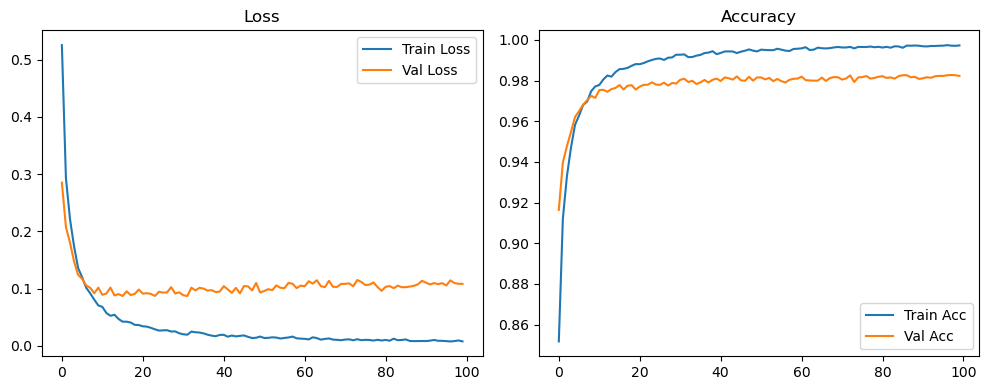

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.8339, Acc: 0.7358 | Val Loss: 0.3384, Acc: 0.9012


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.4684, Acc: 0.8595 | Val Loss: 0.2692, Acc: 0.9217


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.3803, Acc: 0.8869 | Val Loss: 0.2307, Acc: 0.9315


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.3211, Acc: 0.9039 | Val Loss: 0.1990, Acc: 0.9395


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2799, Acc: 0.9166 | Val Loss: 0.1723, Acc: 0.9499


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.2457, Acc: 0.9265 | Val Loss: 0.1480, Acc: 0.9566


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.2261, Acc: 0.9337 | Val Loss: 0.1391, Acc: 0.9585


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.2051, Acc: 0.9395 | Val Loss: 0.1354, Acc: 0.9603


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1922, Acc: 0.9425 | Val Loss: 0.1284, Acc: 0.9624


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1785, Acc: 0.9458 | Val Loss: 0.1209, Acc: 0.9654


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1673, Acc: 0.9500 | Val Loss: 0.1174, Acc: 0.9657


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1610, Acc: 0.9517 | Val Loss: 0.1115, Acc: 0.9678


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1549, Acc: 0.9533 | Val Loss: 0.1101, Acc: 0.9698


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1483, Acc: 0.9554 | Val Loss: 0.1074, Acc: 0.9708


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1377, Acc: 0.9591 | Val Loss: 0.1011, Acc: 0.9721


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1342, Acc: 0.9590 | Val Loss: 0.1000, Acc: 0.9718


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1318, Acc: 0.9605 | Val Loss: 0.1019, Acc: 0.9714


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1246, Acc: 0.9621 | Val Loss: 0.0962, Acc: 0.9742


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1233, Acc: 0.9614 | Val Loss: 0.1016, Acc: 0.9712


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.1164, Acc: 0.9641 | Val Loss: 0.0940, Acc: 0.9736


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.1117, Acc: 0.9652 | Val Loss: 0.0961, Acc: 0.9739


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.1124, Acc: 0.9649 | Val Loss: 0.0891, Acc: 0.9748


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.1066, Acc: 0.9666 | Val Loss: 0.0937, Acc: 0.9743


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.1061, Acc: 0.9669 | Val Loss: 0.0895, Acc: 0.9754


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.1003, Acc: 0.9690 | Val Loss: 0.0934, Acc: 0.9751


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0945, Acc: 0.9701 | Val Loss: 0.0875, Acc: 0.9754


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0974, Acc: 0.9701 | Val Loss: 0.0863, Acc: 0.9768


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0956, Acc: 0.9704 | Val Loss: 0.0893, Acc: 0.9766


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0916, Acc: 0.9710 | Val Loss: 0.0857, Acc: 0.9778


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0890, Acc: 0.9724 | Val Loss: 0.0900, Acc: 0.9765


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0885, Acc: 0.9720 | Val Loss: 0.0907, Acc: 0.9770


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0849, Acc: 0.9729 | Val Loss: 0.0857, Acc: 0.9785


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0850, Acc: 0.9740 | Val Loss: 0.0840, Acc: 0.9772


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0866, Acc: 0.9724 | Val Loss: 0.0837, Acc: 0.9772


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0876, Acc: 0.9733 | Val Loss: 0.0856, Acc: 0.9766


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0781, Acc: 0.9740 | Val Loss: 0.0852, Acc: 0.9783


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0782, Acc: 0.9755 | Val Loss: 0.0867, Acc: 0.9794


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0764, Acc: 0.9758 | Val Loss: 0.0826, Acc: 0.9779


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0794, Acc: 0.9753 | Val Loss: 0.0876, Acc: 0.9767


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0749, Acc: 0.9763 | Val Loss: 0.0883, Acc: 0.9758


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0737, Acc: 0.9768 | Val Loss: 0.0897, Acc: 0.9771


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0721, Acc: 0.9768 | Val Loss: 0.0843, Acc: 0.9783


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0734, Acc: 0.9766 | Val Loss: 0.0832, Acc: 0.9786


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0678, Acc: 0.9788 | Val Loss: 0.0806, Acc: 0.9797


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0705, Acc: 0.9773 | Val Loss: 0.0851, Acc: 0.9777


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0706, Acc: 0.9778 | Val Loss: 0.0840, Acc: 0.9785


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0670, Acc: 0.9783 | Val Loss: 0.0825, Acc: 0.9790


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0650, Acc: 0.9788 | Val Loss: 0.0820, Acc: 0.9791


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0650, Acc: 0.9796 | Val Loss: 0.0824, Acc: 0.9792


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0652, Acc: 0.9798 | Val Loss: 0.0865, Acc: 0.9788


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0638, Acc: 0.9794 | Val Loss: 0.0831, Acc: 0.9783


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0628, Acc: 0.9800 | Val Loss: 0.0856, Acc: 0.9789


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0645, Acc: 0.9790 | Val Loss: 0.0809, Acc: 0.9787


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0623, Acc: 0.9796 | Val Loss: 0.0858, Acc: 0.9785


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0584, Acc: 0.9808 | Val Loss: 0.0864, Acc: 0.9787


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0613, Acc: 0.9807 | Val Loss: 0.0874, Acc: 0.9782


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0585, Acc: 0.9804 | Val Loss: 0.0904, Acc: 0.9778


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0619, Acc: 0.9811 | Val Loss: 0.0850, Acc: 0.9782


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0586, Acc: 0.9808 | Val Loss: 0.0856, Acc: 0.9793


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0569, Acc: 0.9814 | Val Loss: 0.0822, Acc: 0.9800


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0583, Acc: 0.9822 | Val Loss: 0.0836, Acc: 0.9795


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0543, Acc: 0.9832 | Val Loss: 0.0855, Acc: 0.9797


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0541, Acc: 0.9825 | Val Loss: 0.0858, Acc: 0.9802


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0542, Acc: 0.9827 | Val Loss: 0.0863, Acc: 0.9800


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0543, Acc: 0.9825 | Val Loss: 0.0882, Acc: 0.9786


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0551, Acc: 0.9822 | Val Loss: 0.0844, Acc: 0.9798


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0536, Acc: 0.9830 | Val Loss: 0.0861, Acc: 0.9791


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0529, Acc: 0.9835 | Val Loss: 0.0861, Acc: 0.9801


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0529, Acc: 0.9831 | Val Loss: 0.0828, Acc: 0.9791


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0504, Acc: 0.9831 | Val Loss: 0.0826, Acc: 0.9797


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9848 | Val Loss: 0.0826, Acc: 0.9798


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0516, Acc: 0.9833 | Val Loss: 0.0842, Acc: 0.9806


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0485, Acc: 0.9839 | Val Loss: 0.0818, Acc: 0.9806


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0530, Acc: 0.9827 | Val Loss: 0.0845, Acc: 0.9789


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0507, Acc: 0.9835 | Val Loss: 0.0829, Acc: 0.9799


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0483, Acc: 0.9839 | Val Loss: 0.0850, Acc: 0.9784


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0485, Acc: 0.9840 | Val Loss: 0.0823, Acc: 0.9803


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9850 | Val Loss: 0.0896, Acc: 0.9796


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0474, Acc: 0.9848 | Val Loss: 0.0832, Acc: 0.9795


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0480, Acc: 0.9843 | Val Loss: 0.0865, Acc: 0.9801


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0477, Acc: 0.9849 | Val Loss: 0.0866, Acc: 0.9803


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0464, Acc: 0.9853 | Val Loss: 0.0810, Acc: 0.9809


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0460, Acc: 0.9853 | Val Loss: 0.0853, Acc: 0.9799


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0443, Acc: 0.9853 | Val Loss: 0.0839, Acc: 0.9797


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0420, Acc: 0.9865 | Val Loss: 0.0860, Acc: 0.9799


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9852 | Val Loss: 0.0859, Acc: 0.9788


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0447, Acc: 0.9855 | Val Loss: 0.0853, Acc: 0.9801


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9859 | Val Loss: 0.0821, Acc: 0.9801


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0419, Acc: 0.9870 | Val Loss: 0.0878, Acc: 0.9793


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9865 | Val Loss: 0.0843, Acc: 0.9812


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0438, Acc: 0.9860 | Val Loss: 0.0848, Acc: 0.9804


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9864 | Val Loss: 0.0891, Acc: 0.9803


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0445, Acc: 0.9860 | Val Loss: 0.0820, Acc: 0.9808


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9862 | Val Loss: 0.0830, Acc: 0.9803


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9859 | Val Loss: 0.0881, Acc: 0.9808


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9876 | Val Loss: 0.0869, Acc: 0.9802


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9870 | Val Loss: 0.0844, Acc: 0.9813


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9874 | Val Loss: 0.0871, Acc: 0.9808


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9875 | Val Loss: 0.0860, Acc: 0.9804


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9871 | Val Loss: 0.0867, Acc: 0.9804


Final Test Loss: 0.0731 Accuracy: 0.9823


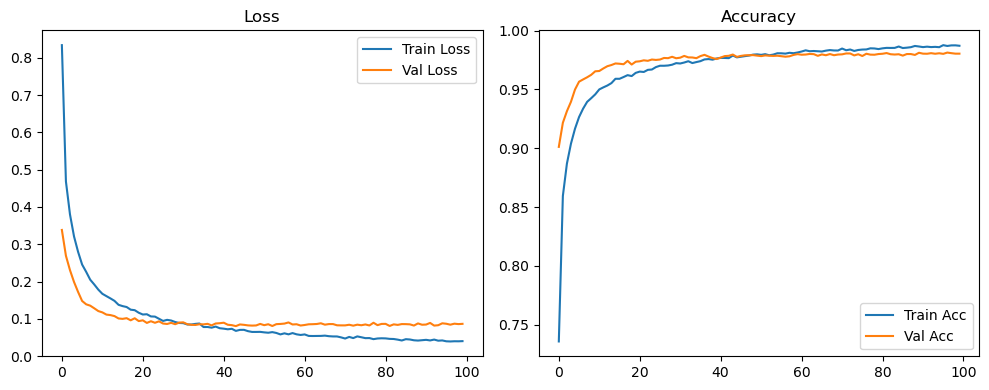

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4029, Acc: 0.8927 | Val Loss: 0.2905, Acc: 0.9124


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1997, Acc: 0.9397 | Val Loss: 0.2060, Acc: 0.9391


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1324, Acc: 0.9597 | Val Loss: 0.1502, Acc: 0.9543


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0954, Acc: 0.9706 | Val Loss: 0.1177, Acc: 0.9645


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0714, Acc: 0.9775 | Val Loss: 0.1167, Acc: 0.9628


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0588, Acc: 0.9809 | Val Loss: 0.1105, Acc: 0.9662


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0469, Acc: 0.9850 | Val Loss: 0.1078, Acc: 0.9688


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9874 | Val Loss: 0.0938, Acc: 0.9722


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9887 | Val Loss: 0.0948, Acc: 0.9732


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9915 | Val Loss: 0.1009, Acc: 0.9729


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9914 | Val Loss: 0.1137, Acc: 0.9695


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9919 | Val Loss: 0.0964, Acc: 0.9742


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9933 | Val Loss: 0.1049, Acc: 0.9728


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9940 | Val Loss: 0.1220, Acc: 0.9716


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9948 | Val Loss: 0.1037, Acc: 0.9736


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.1007, Acc: 0.9755


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.1252, Acc: 0.9720


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1189, Acc: 0.9718


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9946 | Val Loss: 0.1172, Acc: 0.9729


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.1271, Acc: 0.9707


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9956 | Val Loss: 0.1546, Acc: 0.9662


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9961 | Val Loss: 0.1090, Acc: 0.9759


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1185, Acc: 0.9759


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.1325, Acc: 0.9750


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.1330, Acc: 0.9732


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.1414, Acc: 0.9717


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.1188, Acc: 0.9757


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1273, Acc: 0.9761


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.1539, Acc: 0.9711


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.1200, Acc: 0.9766


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1161, Acc: 0.9769


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1342, Acc: 0.9752


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1509, Acc: 0.9734


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.1292, Acc: 0.9773


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1276, Acc: 0.9771


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.1382, Acc: 0.9749


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1317, Acc: 0.9770


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9975 | Val Loss: 0.1278, Acc: 0.9787


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.1201, Acc: 0.9776


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1299, Acc: 0.9760


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1521, Acc: 0.9729


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.1377, Acc: 0.9768


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1212, Acc: 0.9782


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1267, Acc: 0.9766


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1751, Acc: 0.9713


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1403, Acc: 0.9763


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1246, Acc: 0.9790


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1433, Acc: 0.9770


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1405, Acc: 0.9778


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1493, Acc: 0.9758


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1272, Acc: 0.9798


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1249, Acc: 0.9807


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1224, Acc: 0.9812


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1205, Acc: 0.9813


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1196, Acc: 0.9814


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1203, Acc: 0.9814


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1205, Acc: 0.9807


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1207, Acc: 0.9811


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1200, Acc: 0.9805


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1200, Acc: 0.9812


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1188, Acc: 0.9806


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1184, Acc: 0.9804


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1184, Acc: 0.9804


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1190, Acc: 0.9803


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1177, Acc: 0.9815


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1340, Acc: 0.9788


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1452, Acc: 0.9784


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1320, Acc: 0.9808


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1345, Acc: 0.9802


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1365, Acc: 0.9801


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1307, Acc: 0.9800


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1280, Acc: 0.9815


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1265, Acc: 0.9812


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1451, Acc: 0.9800


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1522, Acc: 0.9784


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1627, Acc: 0.9771


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.1421, Acc: 0.9807


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1389, Acc: 0.9812


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1348, Acc: 0.9817


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1373, Acc: 0.9807


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1386, Acc: 0.9806


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1350, Acc: 0.9813


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1352, Acc: 0.9811


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1352, Acc: 0.9812


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1347, Acc: 0.9813


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1334, Acc: 0.9815


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1340, Acc: 0.9816


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1342, Acc: 0.9812


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1335, Acc: 0.9813


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1328, Acc: 0.9812


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1351, Acc: 0.9812


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1366, Acc: 0.9810


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1331, Acc: 0.9812


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1362, Acc: 0.9808


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1387, Acc: 0.9806


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1476, Acc: 0.9800


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1437, Acc: 0.9803


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1407, Acc: 0.9804


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1436, Acc: 0.9805


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1340, Acc: 0.9803


Final Test Loss: 0.1241 Accuracy: 0.9833


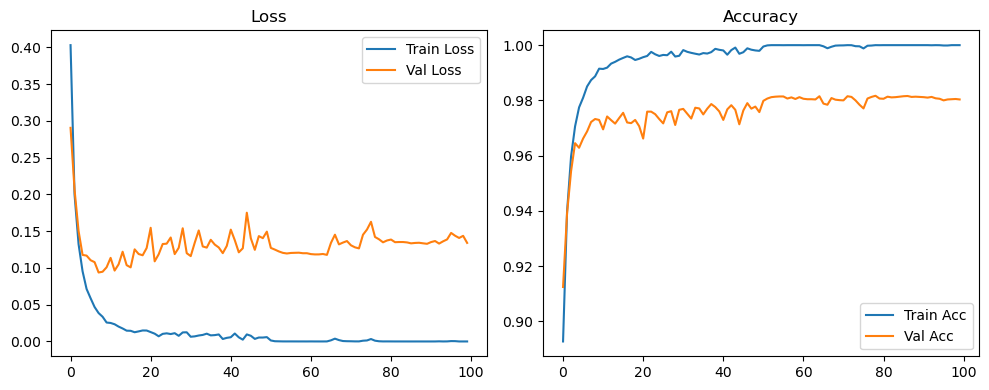

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.5254, Acc: 0.8517 | Val Loss: 0.2852, Acc: 0.9164


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2934, Acc: 0.9121 | Val Loss: 0.2077, Acc: 0.9397


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2219, Acc: 0.9330 | Val Loss: 0.1807, Acc: 0.9477


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1744, Acc: 0.9470 | Val Loss: 0.1479, Acc: 0.9547


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1364, Acc: 0.9583 | Val Loss: 0.1244, Acc: 0.9621


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1200, Acc: 0.9628 | Val Loss: 0.1173, Acc: 0.9650


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1019, Acc: 0.9680 | Val Loss: 0.1058, Acc: 0.9682


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0919, Acc: 0.9697 | Val Loss: 0.1016, Acc: 0.9703


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0809, Acc: 0.9748 | Val Loss: 0.0921, Acc: 0.9726


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0708, Acc: 0.9771 | Val Loss: 0.1018, Acc: 0.9715


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0683, Acc: 0.9779 | Val Loss: 0.0893, Acc: 0.9753


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0575, Acc: 0.9806 | Val Loss: 0.0916, Acc: 0.9755


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0527, Acc: 0.9825 | Val Loss: 0.1019, Acc: 0.9745


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0545, Acc: 0.9820 | Val Loss: 0.0883, Acc: 0.9758


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0472, Acc: 0.9842 | Val Loss: 0.0906, Acc: 0.9764


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9857 | Val Loss: 0.0872, Acc: 0.9778


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9858 | Val Loss: 0.0955, Acc: 0.9757


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0409, Acc: 0.9863 | Val Loss: 0.0889, Acc: 0.9775


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9873 | Val Loss: 0.0909, Acc: 0.9778


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9881 | Val Loss: 0.0985, Acc: 0.9756


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9881 | Val Loss: 0.0914, Acc: 0.9771


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9887 | Val Loss: 0.0922, Acc: 0.9779


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9895 | Val Loss: 0.0909, Acc: 0.9780


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9902 | Val Loss: 0.0874, Acc: 0.9792


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9907 | Val Loss: 0.0947, Acc: 0.9781


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9909 | Val Loss: 0.0931, Acc: 0.9779


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9902 | Val Loss: 0.0935, Acc: 0.9790


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9913 | Val Loss: 0.1027, Acc: 0.9776


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9914 | Val Loss: 0.0917, Acc: 0.9788


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9928 | Val Loss: 0.0936, Acc: 0.9786


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9928 | Val Loss: 0.0886, Acc: 0.9804


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9929 | Val Loss: 0.0872, Acc: 0.9809


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9916 | Val Loss: 0.1018, Acc: 0.9793


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9916 | Val Loss: 0.0970, Acc: 0.9799


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9923 | Val Loss: 0.1015, Acc: 0.9783


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9927 | Val Loss: 0.1002, Acc: 0.9792


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9936 | Val Loss: 0.0967, Acc: 0.9803


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9938 | Val Loss: 0.0976, Acc: 0.9791


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9945 | Val Loss: 0.0942, Acc: 0.9804


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9930 | Val Loss: 0.0949, Acc: 0.9810


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9936 | Val Loss: 0.1044, Acc: 0.9798


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9944 | Val Loss: 0.0988, Acc: 0.9816


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9944 | Val Loss: 0.0928, Acc: 0.9812


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9943 | Val Loss: 0.1015, Acc: 0.9805


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9936 | Val Loss: 0.0919, Acc: 0.9821


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9942 | Val Loss: 0.1046, Acc: 0.9802


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9947 | Val Loss: 0.1041, Acc: 0.9799


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9954 | Val Loss: 0.0969, Acc: 0.9819


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9948 | Val Loss: 0.1100, Acc: 0.9800


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9944 | Val Loss: 0.0933, Acc: 0.9816


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.0893, Acc: 0.9833


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0888, Acc: 0.9832


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0929, Acc: 0.9824


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0934, Acc: 0.9818


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9978 | Val Loss: 0.0910, Acc: 0.9832


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0934, Acc: 0.9822


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0924, Acc: 0.9826


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0933, Acc: 0.9825


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0970, Acc: 0.9825


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0952, Acc: 0.9827


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0992, Acc: 0.9820


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.1044, Acc: 0.9812


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0963, Acc: 0.9822


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9981 | Val Loss: 0.0972, Acc: 0.9831


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.0961, Acc: 0.9828


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1017, Acc: 0.9812


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0984, Acc: 0.9822


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1030, Acc: 0.9818


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1021, Acc: 0.9824


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0996, Acc: 0.9824


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9982 | Val Loss: 0.1085, Acc: 0.9821


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.1098, Acc: 0.9818


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1071, Acc: 0.9826


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1086, Acc: 0.9821


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1114, Acc: 0.9816


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1104, Acc: 0.9814


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1097, Acc: 0.9821


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1112, Acc: 0.9824


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1119, Acc: 0.9818


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9983 | Val Loss: 0.1072, Acc: 0.9819


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1001, Acc: 0.9826


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1002, Acc: 0.9823


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.1025, Acc: 0.9829


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1011, Acc: 0.9830


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0995, Acc: 0.9832


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1039, Acc: 0.9829


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1046, Acc: 0.9830


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1078, Acc: 0.9827


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1069, Acc: 0.9827


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1043, Acc: 0.9833


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1027, Acc: 0.9837


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1048, Acc: 0.9834


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1020, Acc: 0.9835


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1050, Acc: 0.9835


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1044, Acc: 0.9834


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1042, Acc: 0.9834


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1046, Acc: 0.9831


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1040, Acc: 0.9840


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1043, Acc: 0.9843


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1030, Acc: 0.9834


Final Test Loss: 0.0970 Accuracy: 0.9839


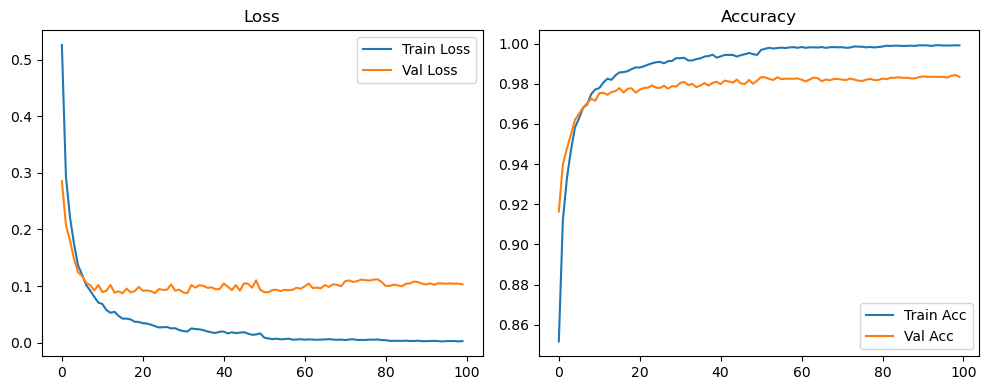

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.8339, Acc: 0.7358 | Val Loss: 0.3384, Acc: 0.9012


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.4684, Acc: 0.8595 | Val Loss: 0.2692, Acc: 0.9217


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.3803, Acc: 0.8869 | Val Loss: 0.2307, Acc: 0.9315


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.3211, Acc: 0.9039 | Val Loss: 0.1990, Acc: 0.9395


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2799, Acc: 0.9166 | Val Loss: 0.1723, Acc: 0.9499


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.2457, Acc: 0.9265 | Val Loss: 0.1480, Acc: 0.9566


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.2261, Acc: 0.9337 | Val Loss: 0.1391, Acc: 0.9585


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.2051, Acc: 0.9395 | Val Loss: 0.1354, Acc: 0.9603


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1922, Acc: 0.9425 | Val Loss: 0.1284, Acc: 0.9624


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1785, Acc: 0.9458 | Val Loss: 0.1209, Acc: 0.9654


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1673, Acc: 0.9500 | Val Loss: 0.1174, Acc: 0.9657


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1610, Acc: 0.9517 | Val Loss: 0.1115, Acc: 0.9678


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1549, Acc: 0.9533 | Val Loss: 0.1101, Acc: 0.9698


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1483, Acc: 0.9554 | Val Loss: 0.1074, Acc: 0.9708


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1377, Acc: 0.9591 | Val Loss: 0.1011, Acc: 0.9721


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1342, Acc: 0.9590 | Val Loss: 0.1000, Acc: 0.9718


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1318, Acc: 0.9605 | Val Loss: 0.1019, Acc: 0.9714


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1246, Acc: 0.9621 | Val Loss: 0.0962, Acc: 0.9742


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1233, Acc: 0.9614 | Val Loss: 0.1016, Acc: 0.9712


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.1164, Acc: 0.9641 | Val Loss: 0.0940, Acc: 0.9736


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.1117, Acc: 0.9652 | Val Loss: 0.0961, Acc: 0.9739


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.1124, Acc: 0.9649 | Val Loss: 0.0891, Acc: 0.9748


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.1066, Acc: 0.9666 | Val Loss: 0.0937, Acc: 0.9743


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.1061, Acc: 0.9669 | Val Loss: 0.0895, Acc: 0.9754


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.1003, Acc: 0.9690 | Val Loss: 0.0934, Acc: 0.9751


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0945, Acc: 0.9701 | Val Loss: 0.0875, Acc: 0.9754


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0974, Acc: 0.9701 | Val Loss: 0.0863, Acc: 0.9768


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0956, Acc: 0.9704 | Val Loss: 0.0893, Acc: 0.9766


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0916, Acc: 0.9710 | Val Loss: 0.0857, Acc: 0.9778


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0890, Acc: 0.9724 | Val Loss: 0.0900, Acc: 0.9765


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0885, Acc: 0.9720 | Val Loss: 0.0907, Acc: 0.9770


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0849, Acc: 0.9729 | Val Loss: 0.0857, Acc: 0.9785


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0850, Acc: 0.9740 | Val Loss: 0.0840, Acc: 0.9772


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0866, Acc: 0.9724 | Val Loss: 0.0837, Acc: 0.9772


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0876, Acc: 0.9733 | Val Loss: 0.0856, Acc: 0.9766


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0781, Acc: 0.9740 | Val Loss: 0.0852, Acc: 0.9783


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0782, Acc: 0.9755 | Val Loss: 0.0867, Acc: 0.9794


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0764, Acc: 0.9758 | Val Loss: 0.0826, Acc: 0.9779


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0794, Acc: 0.9753 | Val Loss: 0.0876, Acc: 0.9767


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0749, Acc: 0.9763 | Val Loss: 0.0883, Acc: 0.9758


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0737, Acc: 0.9768 | Val Loss: 0.0897, Acc: 0.9771


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0721, Acc: 0.9768 | Val Loss: 0.0843, Acc: 0.9783


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0734, Acc: 0.9766 | Val Loss: 0.0832, Acc: 0.9786


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0678, Acc: 0.9788 | Val Loss: 0.0806, Acc: 0.9797


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0705, Acc: 0.9773 | Val Loss: 0.0851, Acc: 0.9777


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0706, Acc: 0.9778 | Val Loss: 0.0840, Acc: 0.9785


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0670, Acc: 0.9783 | Val Loss: 0.0825, Acc: 0.9790


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0650, Acc: 0.9788 | Val Loss: 0.0820, Acc: 0.9791


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0650, Acc: 0.9796 | Val Loss: 0.0824, Acc: 0.9792


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0652, Acc: 0.9798 | Val Loss: 0.0865, Acc: 0.9788


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0562, Acc: 0.9820 | Val Loss: 0.0806, Acc: 0.9789


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0530, Acc: 0.9831 | Val Loss: 0.0833, Acc: 0.9797


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0505, Acc: 0.9833 | Val Loss: 0.0808, Acc: 0.9789


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0492, Acc: 0.9840 | Val Loss: 0.0813, Acc: 0.9792


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0468, Acc: 0.9843 | Val Loss: 0.0828, Acc: 0.9791


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0482, Acc: 0.9847 | Val Loss: 0.0837, Acc: 0.9791


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0445, Acc: 0.9854 | Val Loss: 0.0852, Acc: 0.9794


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0470, Acc: 0.9854 | Val Loss: 0.0849, Acc: 0.9798


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0448, Acc: 0.9850 | Val Loss: 0.0852, Acc: 0.9796


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0452, Acc: 0.9854 | Val Loss: 0.0827, Acc: 0.9797


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0438, Acc: 0.9858 | Val Loss: 0.0852, Acc: 0.9800


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0418, Acc: 0.9862 | Val Loss: 0.0843, Acc: 0.9801


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0417, Acc: 0.9862 | Val Loss: 0.0842, Acc: 0.9806


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0413, Acc: 0.9865 | Val Loss: 0.0845, Acc: 0.9800


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0412, Acc: 0.9867 | Val Loss: 0.0838, Acc: 0.9798


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0433, Acc: 0.9860 | Val Loss: 0.0843, Acc: 0.9802


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0417, Acc: 0.9869 | Val Loss: 0.0852, Acc: 0.9798


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0401, Acc: 0.9865 | Val Loss: 0.0854, Acc: 0.9808


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9872 | Val Loss: 0.0843, Acc: 0.9802


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0394, Acc: 0.9870 | Val Loss: 0.0824, Acc: 0.9808


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0381, Acc: 0.9872 | Val Loss: 0.0854, Acc: 0.9806


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0387, Acc: 0.9878 | Val Loss: 0.0858, Acc: 0.9804


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0381, Acc: 0.9872 | Val Loss: 0.0859, Acc: 0.9802


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0411, Acc: 0.9868 | Val Loss: 0.0853, Acc: 0.9802


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0396, Acc: 0.9871 | Val Loss: 0.0853, Acc: 0.9802


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0373, Acc: 0.9876 | Val Loss: 0.0851, Acc: 0.9798


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0385, Acc: 0.9874 | Val Loss: 0.0853, Acc: 0.9796


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0348, Acc: 0.9885 | Val Loss: 0.0894, Acc: 0.9794


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0399, Acc: 0.9869 | Val Loss: 0.0849, Acc: 0.9803


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0391, Acc: 0.9873 | Val Loss: 0.0851, Acc: 0.9803


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0366, Acc: 0.9881 | Val Loss: 0.0855, Acc: 0.9803


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0345, Acc: 0.9892 | Val Loss: 0.0838, Acc: 0.9803


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0334, Acc: 0.9891 | Val Loss: 0.0864, Acc: 0.9802


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0316, Acc: 0.9893 | Val Loss: 0.0840, Acc: 0.9811


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0308, Acc: 0.9901 | Val Loss: 0.0851, Acc: 0.9805


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9894 | Val Loss: 0.0839, Acc: 0.9808


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9895 | Val Loss: 0.0838, Acc: 0.9805


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0301, Acc: 0.9900 | Val Loss: 0.0844, Acc: 0.9806


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0304, Acc: 0.9905 | Val Loss: 0.0867, Acc: 0.9804


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0306, Acc: 0.9903 | Val Loss: 0.0861, Acc: 0.9808


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0308, Acc: 0.9896 | Val Loss: 0.0882, Acc: 0.9810


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9902 | Val Loss: 0.0873, Acc: 0.9814


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9894 | Val Loss: 0.0863, Acc: 0.9804


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0293, Acc: 0.9899 | Val Loss: 0.0874, Acc: 0.9812


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9904 | Val Loss: 0.0885, Acc: 0.9807


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0286, Acc: 0.9905 | Val Loss: 0.0886, Acc: 0.9808


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9904 | Val Loss: 0.0861, Acc: 0.9816


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9906 | Val Loss: 0.0884, Acc: 0.9811


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9901 | Val Loss: 0.0894, Acc: 0.9803


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0294, Acc: 0.9909 | Val Loss: 0.0885, Acc: 0.9809


Final Test Loss: 0.0778 Accuracy: 0.9827


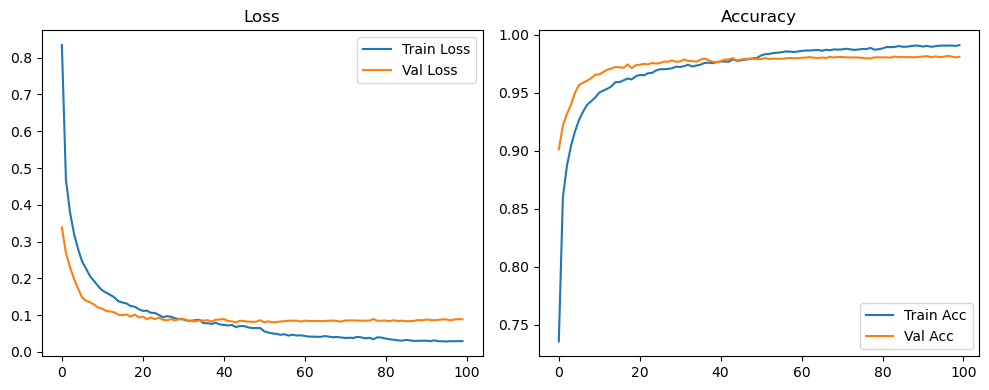

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.4818, Acc: 0.8906 | Val Loss: 0.2851, Acc: 0.9195


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2236, Acc: 0.9355 | Val Loss: 0.2215, Acc: 0.9343


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1566, Acc: 0.9529 | Val Loss: 0.1761, Acc: 0.9472


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1169, Acc: 0.9643 | Val Loss: 0.1375, Acc: 0.9571


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0887, Acc: 0.9734 | Val Loss: 0.1307, Acc: 0.9593


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0752, Acc: 0.9764 | Val Loss: 0.1116, Acc: 0.9653


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0595, Acc: 0.9811 | Val Loss: 0.1069, Acc: 0.9665


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0506, Acc: 0.9840 | Val Loss: 0.1047, Acc: 0.9677


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0418, Acc: 0.9865 | Val Loss: 0.0970, Acc: 0.9712


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0340, Acc: 0.9892 | Val Loss: 0.1050, Acc: 0.9688


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9901 | Val Loss: 0.0890, Acc: 0.9742


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9928 | Val Loss: 0.0949, Acc: 0.9729


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9928 | Val Loss: 0.0999, Acc: 0.9717


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9930 | Val Loss: 0.0893, Acc: 0.9750


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9950 | Val Loss: 0.0909, Acc: 0.9741


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9948 | Val Loss: 0.0904, Acc: 0.9747


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9943 | Val Loss: 0.0884, Acc: 0.9765


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.0948, Acc: 0.9738


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9942 | Val Loss: 0.1107, Acc: 0.9722


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.1002, Acc: 0.9724


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.1095, Acc: 0.9734


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.0891, Acc: 0.9777


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.0942, Acc: 0.9773


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1154, Acc: 0.9726


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1029, Acc: 0.9755


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.1110, Acc: 0.9741


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.1027, Acc: 0.9756


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9956 | Val Loss: 0.1075, Acc: 0.9742


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0974, Acc: 0.9767


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0954, Acc: 0.9788


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1131, Acc: 0.9754


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1106, Acc: 0.9767


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.1113, Acc: 0.9761


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.1182, Acc: 0.9754


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1176, Acc: 0.9748


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.1083, Acc: 0.9776


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.1045, Acc: 0.9772


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1094, Acc: 0.9772


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1158, Acc: 0.9766


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.1508, Acc: 0.9697


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.1047, Acc: 0.9770


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1061, Acc: 0.9781


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.1169, Acc: 0.9775


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0993, Acc: 0.9790


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1030, Acc: 0.9786


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0997, Acc: 0.9788


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1589, Acc: 0.9701


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1308, Acc: 0.9728


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1125, Acc: 0.9772


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1181, Acc: 0.9768


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1196, Acc: 0.9777


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1228, Acc: 0.9769


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1184, Acc: 0.9786


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1267, Acc: 0.9768


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1213, Acc: 0.9778


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.1260, Acc: 0.9752


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1129, Acc: 0.9775


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1189, Acc: 0.9779


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1288, Acc: 0.9762


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1059, Acc: 0.9786


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1028, Acc: 0.9808


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1273, Acc: 0.9766


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1128, Acc: 0.9773


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1096, Acc: 0.9786


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1109, Acc: 0.9778


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1153, Acc: 0.9784


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.1763, Acc: 0.9684


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.1342, Acc: 0.9764


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1244, Acc: 0.9792


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1172, Acc: 0.9791


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1117, Acc: 0.9797


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1081, Acc: 0.9802


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1050, Acc: 0.9806


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1258, Acc: 0.9779


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1695, Acc: 0.9715


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9961 | Val Loss: 0.1323, Acc: 0.9768


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1180, Acc: 0.9795


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1126, Acc: 0.9795


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1071, Acc: 0.9810


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1054, Acc: 0.9805


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1046, Acc: 0.9812


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1038, Acc: 0.9810


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1043, Acc: 0.9812


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1034, Acc: 0.9820


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1037, Acc: 0.9818


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1042, Acc: 0.9810


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9981 | Val Loss: 0.1731, Acc: 0.9720


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9940 | Val Loss: 0.1399, Acc: 0.9757


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1255, Acc: 0.9778


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1165, Acc: 0.9787


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1139, Acc: 0.9789


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1112, Acc: 0.9798


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1068, Acc: 0.9802


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1060, Acc: 0.9805


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1142, Acc: 0.9798


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1063, Acc: 0.9798


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1243, Acc: 0.9794


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1497, Acc: 0.9762


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1379, Acc: 0.9755


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1304, Acc: 0.9770


Final Test Loss: 0.1136 Accuracy: 0.9789


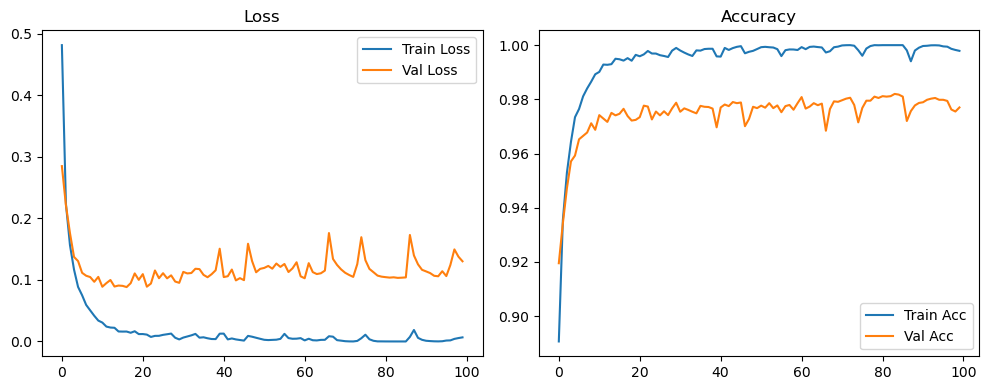

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.6479, Acc: 0.8386 | Val Loss: 0.3109, Acc: 0.9113


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.3440, Acc: 0.8978 | Val Loss: 0.2525, Acc: 0.9275


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.2823, Acc: 0.9156 | Val Loss: 0.2323, Acc: 0.9325


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.2394, Acc: 0.9280 | Val Loss: 0.1922, Acc: 0.9440


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1957, Acc: 0.9410 | Val Loss: 0.1673, Acc: 0.9503


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1701, Acc: 0.9486 | Val Loss: 0.1444, Acc: 0.9574


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1476, Acc: 0.9549 | Val Loss: 0.1242, Acc: 0.9631


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1330, Acc: 0.9578 | Val Loss: 0.1229, Acc: 0.9640


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1162, Acc: 0.9636 | Val Loss: 0.1099, Acc: 0.9676


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1071, Acc: 0.9660 | Val Loss: 0.1083, Acc: 0.9692


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0978, Acc: 0.9694 | Val Loss: 0.1002, Acc: 0.9706


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0853, Acc: 0.9731 | Val Loss: 0.1117, Acc: 0.9674


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0811, Acc: 0.9740 | Val Loss: 0.1025, Acc: 0.9713


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0760, Acc: 0.9754 | Val Loss: 0.0941, Acc: 0.9728


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0678, Acc: 0.9772 | Val Loss: 0.0911, Acc: 0.9743


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0635, Acc: 0.9791 | Val Loss: 0.0925, Acc: 0.9742


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0613, Acc: 0.9794 | Val Loss: 0.0873, Acc: 0.9752


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0560, Acc: 0.9820 | Val Loss: 0.0863, Acc: 0.9759


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0532, Acc: 0.9821 | Val Loss: 0.0909, Acc: 0.9742


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0519, Acc: 0.9833 | Val Loss: 0.0901, Acc: 0.9739


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0496, Acc: 0.9836 | Val Loss: 0.0888, Acc: 0.9758


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0444, Acc: 0.9853 | Val Loss: 0.0808, Acc: 0.9782


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0428, Acc: 0.9856 | Val Loss: 0.0935, Acc: 0.9755


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0415, Acc: 0.9860 | Val Loss: 0.0844, Acc: 0.9774


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0379, Acc: 0.9874 | Val Loss: 0.0910, Acc: 0.9755


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0357, Acc: 0.9876 | Val Loss: 0.0887, Acc: 0.9764


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0358, Acc: 0.9871 | Val Loss: 0.0875, Acc: 0.9782


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9886 | Val Loss: 0.0959, Acc: 0.9763


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0333, Acc: 0.9889 | Val Loss: 0.0874, Acc: 0.9776


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0289, Acc: 0.9901 | Val Loss: 0.0883, Acc: 0.9786


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0272, Acc: 0.9904 | Val Loss: 0.0908, Acc: 0.9780


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9905 | Val Loss: 0.0856, Acc: 0.9787


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9901 | Val Loss: 0.0913, Acc: 0.9772


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9908 | Val Loss: 0.0892, Acc: 0.9776


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9911 | Val Loss: 0.0883, Acc: 0.9789


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0272, Acc: 0.9907 | Val Loss: 0.0916, Acc: 0.9787


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9916 | Val Loss: 0.0873, Acc: 0.9808


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9920 | Val Loss: 0.0886, Acc: 0.9790


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9926 | Val Loss: 0.0925, Acc: 0.9786


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9918 | Val Loss: 0.0942, Acc: 0.9777


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9919 | Val Loss: 0.0856, Acc: 0.9793


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9935 | Val Loss: 0.0880, Acc: 0.9803


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9923 | Val Loss: 0.0900, Acc: 0.9801


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9942 | Val Loss: 0.0875, Acc: 0.9802


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9933 | Val Loss: 0.0888, Acc: 0.9796


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9928 | Val Loss: 0.0893, Acc: 0.9795


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9936 | Val Loss: 0.0900, Acc: 0.9802


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9944 | Val Loss: 0.0871, Acc: 0.9805


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.0986, Acc: 0.9783


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9940 | Val Loss: 0.0923, Acc: 0.9790


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9943 | Val Loss: 0.0922, Acc: 0.9806


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9939 | Val Loss: 0.0959, Acc: 0.9796


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9944 | Val Loss: 0.1007, Acc: 0.9785


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.0948, Acc: 0.9797


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.0991, Acc: 0.9800


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9946 | Val Loss: 0.1057, Acc: 0.9779


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9949 | Val Loss: 0.0916, Acc: 0.9801


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9949 | Val Loss: 0.0936, Acc: 0.9807


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.0990, Acc: 0.9788


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9944 | Val Loss: 0.0982, Acc: 0.9791


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9952 | Val Loss: 0.0947, Acc: 0.9798


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9949 | Val Loss: 0.0977, Acc: 0.9797


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.0921, Acc: 0.9808


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9954 | Val Loss: 0.1001, Acc: 0.9804


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9954 | Val Loss: 0.0967, Acc: 0.9801


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.1001, Acc: 0.9798


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.1029, Acc: 0.9788


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.1055, Acc: 0.9796


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9948 | Val Loss: 0.0951, Acc: 0.9803


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.0958, Acc: 0.9813


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9949 | Val Loss: 0.1010, Acc: 0.9792


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9955 | Val Loss: 0.1051, Acc: 0.9790


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9958 | Val Loss: 0.0922, Acc: 0.9812


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9963 | Val Loss: 0.1002, Acc: 0.9802


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.0998, Acc: 0.9805


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.0950, Acc: 0.9815


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.0965, Acc: 0.9801


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.1051, Acc: 0.9807


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.1036, Acc: 0.9799


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9964 | Val Loss: 0.0985, Acc: 0.9796


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.0990, Acc: 0.9812


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.1016, Acc: 0.9805


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.0991, Acc: 0.9812


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1062, Acc: 0.9803


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1144, Acc: 0.9802


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.1061, Acc: 0.9810


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9959 | Val Loss: 0.1036, Acc: 0.9794


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9964 | Val Loss: 0.1074, Acc: 0.9808


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.0972, Acc: 0.9807


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.1066, Acc: 0.9806


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0986, Acc: 0.9821


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9964 | Val Loss: 0.1065, Acc: 0.9825


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1044, Acc: 0.9819


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1044, Acc: 0.9819


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9967 | Val Loss: 0.1090, Acc: 0.9796


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.1129, Acc: 0.9804


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9966 | Val Loss: 0.1095, Acc: 0.9814


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1060, Acc: 0.9803


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.1028, Acc: 0.9808


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.1039, Acc: 0.9809


Final Test Loss: 0.0963 Accuracy: 0.9813


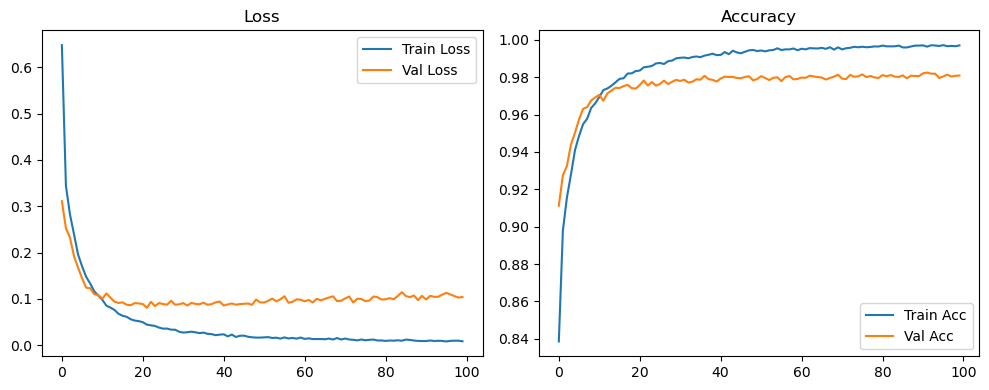

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 1.0562, Acc: 0.6751 | Val Loss: 0.4066, Acc: 0.8918


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.5753, Acc: 0.8229 | Val Loss: 0.3192, Acc: 0.9058


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.4814, Acc: 0.8536 | Val Loss: 0.2949, Acc: 0.9123


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.4254, Acc: 0.8721 | Val Loss: 0.2732, Acc: 0.9170


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.3818, Acc: 0.8848 | Val Loss: 0.2409, Acc: 0.9295


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.3405, Acc: 0.8981 | Val Loss: 0.2136, Acc: 0.9373


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.3132, Acc: 0.9061 | Val Loss: 0.1998, Acc: 0.9404


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.2843, Acc: 0.9141 | Val Loss: 0.1834, Acc: 0.9454


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.2685, Acc: 0.9192 | Val Loss: 0.1738, Acc: 0.9477


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.2458, Acc: 0.9254 | Val Loss: 0.1586, Acc: 0.9543


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.2303, Acc: 0.9310 | Val Loss: 0.1515, Acc: 0.9547


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.2213, Acc: 0.9336 | Val Loss: 0.1440, Acc: 0.9570


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.2074, Acc: 0.9375 | Val Loss: 0.1408, Acc: 0.9587


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.2021, Acc: 0.9404 | Val Loss: 0.1356, Acc: 0.9600


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.1895, Acc: 0.9430 | Val Loss: 0.1297, Acc: 0.9628


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.1812, Acc: 0.9460 | Val Loss: 0.1228, Acc: 0.9640


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.1741, Acc: 0.9455 | Val Loss: 0.1211, Acc: 0.9644


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.1695, Acc: 0.9484 | Val Loss: 0.1153, Acc: 0.9669


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.1626, Acc: 0.9504 | Val Loss: 0.1194, Acc: 0.9664


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.1531, Acc: 0.9532 | Val Loss: 0.1138, Acc: 0.9675


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.1457, Acc: 0.9566 | Val Loss: 0.1137, Acc: 0.9680


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.1466, Acc: 0.9553 | Val Loss: 0.1089, Acc: 0.9698


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.1404, Acc: 0.9577 | Val Loss: 0.1056, Acc: 0.9705


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.1350, Acc: 0.9588 | Val Loss: 0.1018, Acc: 0.9717


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.1321, Acc: 0.9594 | Val Loss: 0.1046, Acc: 0.9710


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.1273, Acc: 0.9614 | Val Loss: 0.1007, Acc: 0.9728


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.1252, Acc: 0.9618 | Val Loss: 0.0999, Acc: 0.9719


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.1218, Acc: 0.9609 | Val Loss: 0.0949, Acc: 0.9737


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.1157, Acc: 0.9627 | Val Loss: 0.0979, Acc: 0.9736


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.1147, Acc: 0.9652 | Val Loss: 0.1002, Acc: 0.9725


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.1125, Acc: 0.9648 | Val Loss: 0.0989, Acc: 0.9740


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.1102, Acc: 0.9661 | Val Loss: 0.0952, Acc: 0.9739


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.1093, Acc: 0.9674 | Val Loss: 0.0901, Acc: 0.9745


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.1081, Acc: 0.9671 | Val Loss: 0.0923, Acc: 0.9745


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.1079, Acc: 0.9672 | Val Loss: 0.0920, Acc: 0.9749


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.1032, Acc: 0.9672 | Val Loss: 0.0917, Acc: 0.9752


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0962, Acc: 0.9699 | Val Loss: 0.0898, Acc: 0.9763


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0965, Acc: 0.9685 | Val Loss: 0.0894, Acc: 0.9758


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0974, Acc: 0.9689 | Val Loss: 0.0924, Acc: 0.9752


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0941, Acc: 0.9703 | Val Loss: 0.0937, Acc: 0.9747


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0924, Acc: 0.9705 | Val Loss: 0.0910, Acc: 0.9758


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0900, Acc: 0.9718 | Val Loss: 0.0903, Acc: 0.9754


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0921, Acc: 0.9712 | Val Loss: 0.0939, Acc: 0.9759


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0899, Acc: 0.9724 | Val Loss: 0.0903, Acc: 0.9752


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0848, Acc: 0.9741 | Val Loss: 0.0941, Acc: 0.9753


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0857, Acc: 0.9729 | Val Loss: 0.0912, Acc: 0.9753


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0848, Acc: 0.9733 | Val Loss: 0.0918, Acc: 0.9749


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0790, Acc: 0.9750 | Val Loss: 0.0904, Acc: 0.9762


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0814, Acc: 0.9736 | Val Loss: 0.0913, Acc: 0.9765


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0812, Acc: 0.9748 | Val Loss: 0.0885, Acc: 0.9765


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0776, Acc: 0.9754 | Val Loss: 0.0897, Acc: 0.9768


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0776, Acc: 0.9748 | Val Loss: 0.0938, Acc: 0.9757


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0781, Acc: 0.9755 | Val Loss: 0.0862, Acc: 0.9768


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0762, Acc: 0.9762 | Val Loss: 0.0924, Acc: 0.9769


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0737, Acc: 0.9760 | Val Loss: 0.0928, Acc: 0.9772


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0730, Acc: 0.9768 | Val Loss: 0.0921, Acc: 0.9769


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0737, Acc: 0.9763 | Val Loss: 0.0923, Acc: 0.9778


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0747, Acc: 0.9762 | Val Loss: 0.0912, Acc: 0.9770


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0714, Acc: 0.9782 | Val Loss: 0.0920, Acc: 0.9768


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0706, Acc: 0.9775 | Val Loss: 0.0886, Acc: 0.9777


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0694, Acc: 0.9779 | Val Loss: 0.0915, Acc: 0.9778


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0663, Acc: 0.9789 | Val Loss: 0.0920, Acc: 0.9772


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0658, Acc: 0.9784 | Val Loss: 0.0938, Acc: 0.9770


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0689, Acc: 0.9782 | Val Loss: 0.0939, Acc: 0.9769


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0683, Acc: 0.9778 | Val Loss: 0.0939, Acc: 0.9763


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0673, Acc: 0.9781 | Val Loss: 0.0950, Acc: 0.9769


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0649, Acc: 0.9794 | Val Loss: 0.0919, Acc: 0.9778


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0665, Acc: 0.9789 | Val Loss: 0.0945, Acc: 0.9772


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0624, Acc: 0.9799 | Val Loss: 0.0878, Acc: 0.9782


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0616, Acc: 0.9806 | Val Loss: 0.0895, Acc: 0.9778


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0629, Acc: 0.9795 | Val Loss: 0.0930, Acc: 0.9778


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0612, Acc: 0.9798 | Val Loss: 0.0914, Acc: 0.9786


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0608, Acc: 0.9800 | Val Loss: 0.0906, Acc: 0.9782


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0630, Acc: 0.9795 | Val Loss: 0.0890, Acc: 0.9782


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0592, Acc: 0.9807 | Val Loss: 0.0901, Acc: 0.9786


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0596, Acc: 0.9805 | Val Loss: 0.0915, Acc: 0.9788


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0591, Acc: 0.9806 | Val Loss: 0.0904, Acc: 0.9784


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0561, Acc: 0.9812 | Val Loss: 0.0925, Acc: 0.9788


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0595, Acc: 0.9804 | Val Loss: 0.0916, Acc: 0.9779


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0588, Acc: 0.9815 | Val Loss: 0.0913, Acc: 0.9780


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0577, Acc: 0.9814 | Val Loss: 0.0905, Acc: 0.9782


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0543, Acc: 0.9822 | Val Loss: 0.0898, Acc: 0.9788


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0555, Acc: 0.9819 | Val Loss: 0.0947, Acc: 0.9782


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0518, Acc: 0.9832 | Val Loss: 0.0907, Acc: 0.9793


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0536, Acc: 0.9828 | Val Loss: 0.0924, Acc: 0.9790


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0531, Acc: 0.9826 | Val Loss: 0.0906, Acc: 0.9786


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0526, Acc: 0.9830 | Val Loss: 0.0910, Acc: 0.9790


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0548, Acc: 0.9824 | Val Loss: 0.0871, Acc: 0.9783


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0526, Acc: 0.9828 | Val Loss: 0.0890, Acc: 0.9793


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0513, Acc: 0.9831 | Val Loss: 0.0895, Acc: 0.9791


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0542, Acc: 0.9824 | Val Loss: 0.0935, Acc: 0.9783


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0518, Acc: 0.9833 | Val Loss: 0.0923, Acc: 0.9782


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0518, Acc: 0.9834 | Val Loss: 0.0889, Acc: 0.9793


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0510, Acc: 0.9834 | Val Loss: 0.0903, Acc: 0.9787


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0484, Acc: 0.9844 | Val Loss: 0.0911, Acc: 0.9793


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0479, Acc: 0.9852 | Val Loss: 0.0899, Acc: 0.9796


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0478, Acc: 0.9838 | Val Loss: 0.0938, Acc: 0.9790


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0479, Acc: 0.9847 | Val Loss: 0.0904, Acc: 0.9797


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0508, Acc: 0.9837 | Val Loss: 0.0943, Acc: 0.9789


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0482, Acc: 0.9844 | Val Loss: 0.0938, Acc: 0.9789


Final Test Loss: 0.0832 Accuracy: 0.9812


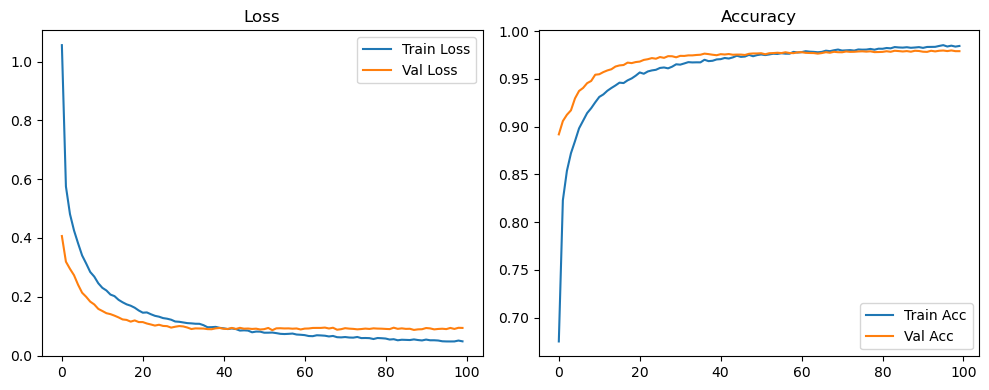

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.6043, Acc: 0.8826 | Val Loss: 0.3278, Acc: 0.9166


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2581, Acc: 0.9327 | Val Loss: 0.2485, Acc: 0.9321


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1787, Acc: 0.9494 | Val Loss: 0.1854, Acc: 0.9477


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1348, Acc: 0.9612 | Val Loss: 0.1520, Acc: 0.9539


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1048, Acc: 0.9694 | Val Loss: 0.1431, Acc: 0.9551


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0879, Acc: 0.9741 | Val Loss: 0.1226, Acc: 0.9637


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0728, Acc: 0.9780 | Val Loss: 0.1190, Acc: 0.9631


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0610, Acc: 0.9824 | Val Loss: 0.1053, Acc: 0.9667


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0515, Acc: 0.9844 | Val Loss: 0.1064, Acc: 0.9662


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0429, Acc: 0.9869 | Val Loss: 0.1105, Acc: 0.9661


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0382, Acc: 0.9884 | Val Loss: 0.0973, Acc: 0.9705


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0322, Acc: 0.9904 | Val Loss: 0.0936, Acc: 0.9711


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0297, Acc: 0.9909 | Val Loss: 0.0919, Acc: 0.9728


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9923 | Val Loss: 0.0952, Acc: 0.9712


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9936 | Val Loss: 0.0945, Acc: 0.9711


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9941 | Val Loss: 0.0940, Acc: 0.9738


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9943 | Val Loss: 0.0882, Acc: 0.9730


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9953 | Val Loss: 0.0936, Acc: 0.9732


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.0979, Acc: 0.9725


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9951 | Val Loss: 0.0911, Acc: 0.9736


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.0986, Acc: 0.9737


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9959 | Val Loss: 0.1073, Acc: 0.9712


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9956 | Val Loss: 0.0927, Acc: 0.9733


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.1134, Acc: 0.9699


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.0937, Acc: 0.9754


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1003, Acc: 0.9738


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1169, Acc: 0.9691


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.1071, Acc: 0.9724


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.1017, Acc: 0.9736


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1079, Acc: 0.9728


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.0959, Acc: 0.9751


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.0831, Acc: 0.9780


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0930, Acc: 0.9778


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.1046, Acc: 0.9766


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.1185, Acc: 0.9712


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9958 | Val Loss: 0.0988, Acc: 0.9761


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0972, Acc: 0.9765


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1098, Acc: 0.9742


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0928, Acc: 0.9782


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0959, Acc: 0.9780


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1142, Acc: 0.9738


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1033, Acc: 0.9748


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1056, Acc: 0.9756


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1059, Acc: 0.9763


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1169, Acc: 0.9729


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1113, Acc: 0.9748


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.0998, Acc: 0.9762


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1031, Acc: 0.9761


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0955, Acc: 0.9790


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0946, Acc: 0.9790


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0996, Acc: 0.9790


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1140, Acc: 0.9758


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1109, Acc: 0.9764


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1085, Acc: 0.9772


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0918, Acc: 0.9793


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0932, Acc: 0.9799


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0886, Acc: 0.9801


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1137, Acc: 0.9762


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9955 | Val Loss: 0.1307, Acc: 0.9728


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9963 | Val Loss: 0.1178, Acc: 0.9749


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1001, Acc: 0.9776


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0950, Acc: 0.9785


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0953, Acc: 0.9816


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1104, Acc: 0.9779


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1049, Acc: 0.9786


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1014, Acc: 0.9792


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1197, Acc: 0.9755


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1381, Acc: 0.9737


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1250, Acc: 0.9742


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1101, Acc: 0.9782


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0988, Acc: 0.9788


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1016, Acc: 0.9790


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0884, Acc: 0.9815


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0883, Acc: 0.9823


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0876, Acc: 0.9824


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0868, Acc: 0.9827


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0872, Acc: 0.9821


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.1656, Acc: 0.9650


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9957 | Val Loss: 0.1096, Acc: 0.9775


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0950, Acc: 0.9800


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0958, Acc: 0.9801


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0944, Acc: 0.9802


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0888, Acc: 0.9812


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0907, Acc: 0.9815


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1151, Acc: 0.9781


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1122, Acc: 0.9774


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1091, Acc: 0.9779


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0958, Acc: 0.9803


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0972, Acc: 0.9808


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0903, Acc: 0.9822


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0898, Acc: 0.9819


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0957, Acc: 0.9810


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0938, Acc: 0.9816


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0977, Acc: 0.9809


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0970, Acc: 0.9808


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1414, Acc: 0.9734


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9950 | Val Loss: 0.1222, Acc: 0.9767


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1128, Acc: 0.9785


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1097, Acc: 0.9793


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0963, Acc: 0.9819


Final Test Loss: 0.0877 Accuracy: 0.9826


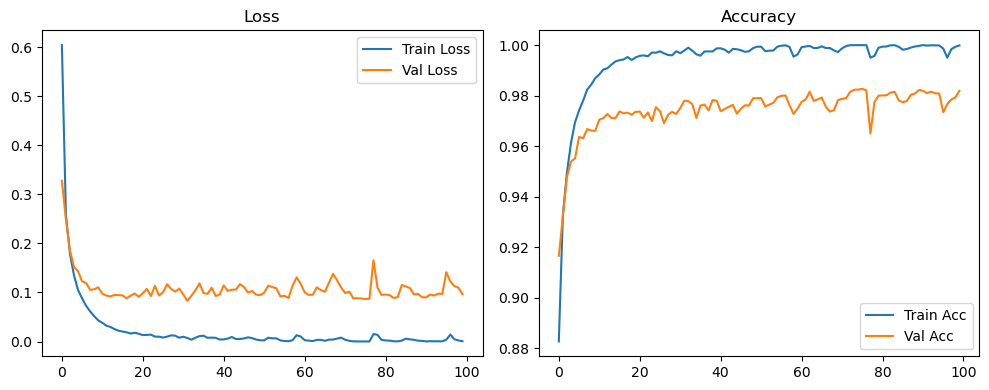

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.8180, Acc: 0.8177 | Val Loss: 0.3751, Acc: 0.9054


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.4003, Acc: 0.8883 | Val Loss: 0.2957, Acc: 0.9163


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.3317, Acc: 0.9033 | Val Loss: 0.2700, Acc: 0.9223


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.2947, Acc: 0.9126 | Val Loss: 0.2361, Acc: 0.9317


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.2559, Acc: 0.9246 | Val Loss: 0.2102, Acc: 0.9374


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.2266, Acc: 0.9330 | Val Loss: 0.1827, Acc: 0.9463


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.2041, Acc: 0.9386 | Val Loss: 0.1631, Acc: 0.9514


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1836, Acc: 0.9443 | Val Loss: 0.1528, Acc: 0.9540


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1638, Acc: 0.9496 | Val Loss: 0.1483, Acc: 0.9543


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1515, Acc: 0.9537 | Val Loss: 0.1312, Acc: 0.9618


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1377, Acc: 0.9578 | Val Loss: 0.1236, Acc: 0.9636


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1254, Acc: 0.9608 | Val Loss: 0.1299, Acc: 0.9613


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1170, Acc: 0.9635 | Val Loss: 0.1109, Acc: 0.9673


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.1102, Acc: 0.9663 | Val Loss: 0.1105, Acc: 0.9659


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.1028, Acc: 0.9673 | Val Loss: 0.1044, Acc: 0.9682


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0919, Acc: 0.9715 | Val Loss: 0.1011, Acc: 0.9691


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0911, Acc: 0.9709 | Val Loss: 0.0986, Acc: 0.9715


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0832, Acc: 0.9738 | Val Loss: 0.0980, Acc: 0.9720


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0801, Acc: 0.9750 | Val Loss: 0.0977, Acc: 0.9702


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0750, Acc: 0.9758 | Val Loss: 0.0950, Acc: 0.9714


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0721, Acc: 0.9760 | Val Loss: 0.0951, Acc: 0.9722


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0677, Acc: 0.9784 | Val Loss: 0.0870, Acc: 0.9747


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0644, Acc: 0.9787 | Val Loss: 0.0956, Acc: 0.9739


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0622, Acc: 0.9798 | Val Loss: 0.0880, Acc: 0.9748


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0580, Acc: 0.9809 | Val Loss: 0.0873, Acc: 0.9742


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0530, Acc: 0.9825 | Val Loss: 0.0898, Acc: 0.9761


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0513, Acc: 0.9828 | Val Loss: 0.0888, Acc: 0.9752


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0489, Acc: 0.9835 | Val Loss: 0.0932, Acc: 0.9745


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0481, Acc: 0.9842 | Val Loss: 0.0881, Acc: 0.9767


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0439, Acc: 0.9851 | Val Loss: 0.0892, Acc: 0.9760


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0428, Acc: 0.9850 | Val Loss: 0.0857, Acc: 0.9764


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0389, Acc: 0.9871 | Val Loss: 0.0829, Acc: 0.9777


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0393, Acc: 0.9862 | Val Loss: 0.0844, Acc: 0.9780


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0382, Acc: 0.9871 | Val Loss: 0.0879, Acc: 0.9765


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0376, Acc: 0.9876 | Val Loss: 0.0859, Acc: 0.9782


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0379, Acc: 0.9874 | Val Loss: 0.0923, Acc: 0.9773


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0352, Acc: 0.9878 | Val Loss: 0.0886, Acc: 0.9778


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0340, Acc: 0.9890 | Val Loss: 0.0848, Acc: 0.9782


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9889 | Val Loss: 0.0880, Acc: 0.9773


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0314, Acc: 0.9892 | Val Loss: 0.0866, Acc: 0.9776


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9893 | Val Loss: 0.0896, Acc: 0.9766


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9894 | Val Loss: 0.0907, Acc: 0.9774


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9893 | Val Loss: 0.0916, Acc: 0.9775


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0257, Acc: 0.9910 | Val Loss: 0.0861, Acc: 0.9799


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0281, Acc: 0.9902 | Val Loss: 0.0847, Acc: 0.9782


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9906 | Val Loss: 0.0900, Acc: 0.9776


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9915 | Val Loss: 0.0886, Acc: 0.9789


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9920 | Val Loss: 0.0899, Acc: 0.9775


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0234, Acc: 0.9917 | Val Loss: 0.0936, Acc: 0.9778


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9915 | Val Loss: 0.0963, Acc: 0.9768


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9927 | Val Loss: 0.0873, Acc: 0.9798


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9917 | Val Loss: 0.0932, Acc: 0.9782


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9917 | Val Loss: 0.0932, Acc: 0.9778


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9927 | Val Loss: 0.0941, Acc: 0.9782


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9930 | Val Loss: 0.0889, Acc: 0.9792


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9927 | Val Loss: 0.1033, Acc: 0.9768


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9936 | Val Loss: 0.0902, Acc: 0.9789


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9926 | Val Loss: 0.0971, Acc: 0.9782


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9936 | Val Loss: 0.0926, Acc: 0.9784


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9936 | Val Loss: 0.0896, Acc: 0.9792


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9936 | Val Loss: 0.0897, Acc: 0.9810


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9938 | Val Loss: 0.0913, Acc: 0.9804


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9938 | Val Loss: 0.0915, Acc: 0.9792


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9936 | Val Loss: 0.0922, Acc: 0.9792


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9942 | Val Loss: 0.0897, Acc: 0.9802


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9941 | Val Loss: 0.0952, Acc: 0.9785


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.0989, Acc: 0.9787


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9949 | Val Loss: 0.0954, Acc: 0.9805


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9943 | Val Loss: 0.0922, Acc: 0.9798


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.0941, Acc: 0.9795


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9946 | Val Loss: 0.0973, Acc: 0.9792


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9940 | Val Loss: 0.0991, Acc: 0.9782


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.0986, Acc: 0.9792


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.0942, Acc: 0.9796


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0156, Acc: 0.9946 | Val Loss: 0.0957, Acc: 0.9787


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.0895, Acc: 0.9799


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9953 | Val Loss: 0.0950, Acc: 0.9787


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9952 | Val Loss: 0.0968, Acc: 0.9788


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.0968, Acc: 0.9802


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.0931, Acc: 0.9791


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.0955, Acc: 0.9788


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.0882, Acc: 0.9795


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9958 | Val Loss: 0.0952, Acc: 0.9799


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.1000, Acc: 0.9788


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.0995, Acc: 0.9792


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9956 | Val Loss: 0.0952, Acc: 0.9802


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.0959, Acc: 0.9797


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0950, Acc: 0.9814


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.0953, Acc: 0.9811


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.1010, Acc: 0.9792


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.0984, Acc: 0.9796


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9955 | Val Loss: 0.1013, Acc: 0.9802


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0974, Acc: 0.9799


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.0987, Acc: 0.9808


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9956 | Val Loss: 0.1002, Acc: 0.9802


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0998, Acc: 0.9802


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9958 | Val Loss: 0.1074, Acc: 0.9796


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0990, Acc: 0.9793


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.1033, Acc: 0.9796


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1064, Acc: 0.9775


Final Test Loss: 0.0996 Accuracy: 0.9799


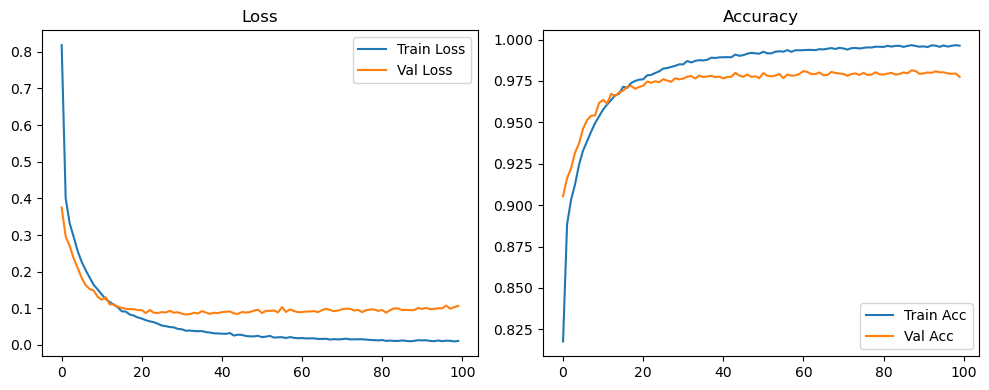

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 1.2991, Acc: 0.6065 | Val Loss: 0.5571, Acc: 0.8802


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.7072, Acc: 0.7871 | Val Loss: 0.3775, Acc: 0.8977


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.5759, Acc: 0.8248 | Val Loss: 0.3337, Acc: 0.9039


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.5122, Acc: 0.8445 | Val Loss: 0.3129, Acc: 0.9061


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.4674, Acc: 0.8580 | Val Loss: 0.2940, Acc: 0.9126


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.4274, Acc: 0.8706 | Val Loss: 0.2697, Acc: 0.9193


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.4035, Acc: 0.8778 | Val Loss: 0.2582, Acc: 0.9223


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.3728, Acc: 0.8863 | Val Loss: 0.2420, Acc: 0.9278


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.3551, Acc: 0.8942 | Val Loss: 0.2291, Acc: 0.9329


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.3310, Acc: 0.8992 | Val Loss: 0.2137, Acc: 0.9377


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.3114, Acc: 0.9050 | Val Loss: 0.2064, Acc: 0.9400


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.2980, Acc: 0.9103 | Val Loss: 0.1921, Acc: 0.9420


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.2825, Acc: 0.9154 | Val Loss: 0.1855, Acc: 0.9463


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.2726, Acc: 0.9191 | Val Loss: 0.1784, Acc: 0.9457


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.2586, Acc: 0.9222 | Val Loss: 0.1699, Acc: 0.9502


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.2466, Acc: 0.9265 | Val Loss: 0.1629, Acc: 0.9512


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.2357, Acc: 0.9274 | Val Loss: 0.1548, Acc: 0.9542


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.2298, Acc: 0.9319 | Val Loss: 0.1499, Acc: 0.9558


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.2208, Acc: 0.9325 | Val Loss: 0.1485, Acc: 0.9556


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.2086, Acc: 0.9362 | Val Loss: 0.1447, Acc: 0.9577


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.1985, Acc: 0.9396 | Val Loss: 0.1446, Acc: 0.9583


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.1978, Acc: 0.9396 | Val Loss: 0.1370, Acc: 0.9617


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.1916, Acc: 0.9429 | Val Loss: 0.1320, Acc: 0.9617


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.1828, Acc: 0.9455 | Val Loss: 0.1285, Acc: 0.9627


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.1797, Acc: 0.9447 | Val Loss: 0.1278, Acc: 0.9641


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.1711, Acc: 0.9482 | Val Loss: 0.1236, Acc: 0.9653


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.1699, Acc: 0.9491 | Val Loss: 0.1214, Acc: 0.9652


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.1662, Acc: 0.9483 | Val Loss: 0.1185, Acc: 0.9660


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.1562, Acc: 0.9517 | Val Loss: 0.1170, Acc: 0.9657


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.1542, Acc: 0.9534 | Val Loss: 0.1175, Acc: 0.9662


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.1497, Acc: 0.9543 | Val Loss: 0.1197, Acc: 0.9666


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.1492, Acc: 0.9548 | Val Loss: 0.1165, Acc: 0.9670


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.1442, Acc: 0.9570 | Val Loss: 0.1107, Acc: 0.9684


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.1442, Acc: 0.9561 | Val Loss: 0.1083, Acc: 0.9690


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.1405, Acc: 0.9573 | Val Loss: 0.1081, Acc: 0.9696


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.1381, Acc: 0.9574 | Val Loss: 0.1060, Acc: 0.9702


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.1277, Acc: 0.9599 | Val Loss: 0.1062, Acc: 0.9710


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.1308, Acc: 0.9596 | Val Loss: 0.1061, Acc: 0.9714


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.1264, Acc: 0.9607 | Val Loss: 0.1032, Acc: 0.9714


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.1242, Acc: 0.9615 | Val Loss: 0.1065, Acc: 0.9713


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.1197, Acc: 0.9629 | Val Loss: 0.1014, Acc: 0.9718


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.1209, Acc: 0.9626 | Val Loss: 0.1025, Acc: 0.9717


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.1181, Acc: 0.9631 | Val Loss: 0.1029, Acc: 0.9722


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.1146, Acc: 0.9640 | Val Loss: 0.1011, Acc: 0.9707


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.1133, Acc: 0.9652 | Val Loss: 0.1018, Acc: 0.9722


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.1129, Acc: 0.9651 | Val Loss: 0.1017, Acc: 0.9728


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.1107, Acc: 0.9654 | Val Loss: 0.1005, Acc: 0.9732


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.1040, Acc: 0.9675 | Val Loss: 0.0985, Acc: 0.9730


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.1067, Acc: 0.9662 | Val Loss: 0.0992, Acc: 0.9739


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.1052, Acc: 0.9685 | Val Loss: 0.0978, Acc: 0.9747


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.1003, Acc: 0.9683 | Val Loss: 0.0988, Acc: 0.9741


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.1018, Acc: 0.9689 | Val Loss: 0.1017, Acc: 0.9731


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.1014, Acc: 0.9685 | Val Loss: 0.0947, Acc: 0.9736


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0981, Acc: 0.9686 | Val Loss: 0.0965, Acc: 0.9732


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0930, Acc: 0.9701 | Val Loss: 0.0978, Acc: 0.9747


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0942, Acc: 0.9705 | Val Loss: 0.0991, Acc: 0.9737


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0944, Acc: 0.9711 | Val Loss: 0.0979, Acc: 0.9744


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0951, Acc: 0.9694 | Val Loss: 0.0983, Acc: 0.9741


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0939, Acc: 0.9699 | Val Loss: 0.0954, Acc: 0.9745


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0910, Acc: 0.9709 | Val Loss: 0.0954, Acc: 0.9744


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0902, Acc: 0.9714 | Val Loss: 0.0974, Acc: 0.9745


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0889, Acc: 0.9719 | Val Loss: 0.0967, Acc: 0.9750


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0852, Acc: 0.9731 | Val Loss: 0.0976, Acc: 0.9752


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0871, Acc: 0.9722 | Val Loss: 0.0975, Acc: 0.9748


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0835, Acc: 0.9730 | Val Loss: 0.0961, Acc: 0.9747


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0829, Acc: 0.9734 | Val Loss: 0.0938, Acc: 0.9745


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0834, Acc: 0.9735 | Val Loss: 0.0970, Acc: 0.9749


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0865, Acc: 0.9728 | Val Loss: 0.0952, Acc: 0.9759


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0807, Acc: 0.9748 | Val Loss: 0.0941, Acc: 0.9752


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0785, Acc: 0.9750 | Val Loss: 0.0933, Acc: 0.9762


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0824, Acc: 0.9734 | Val Loss: 0.0972, Acc: 0.9758


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0772, Acc: 0.9753 | Val Loss: 0.0949, Acc: 0.9771


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0762, Acc: 0.9760 | Val Loss: 0.0947, Acc: 0.9761


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0783, Acc: 0.9750 | Val Loss: 0.0931, Acc: 0.9768


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0737, Acc: 0.9768 | Val Loss: 0.0934, Acc: 0.9768


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0755, Acc: 0.9761 | Val Loss: 0.0931, Acc: 0.9767


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0730, Acc: 0.9771 | Val Loss: 0.0959, Acc: 0.9768


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0726, Acc: 0.9763 | Val Loss: 0.0957, Acc: 0.9763


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0721, Acc: 0.9768 | Val Loss: 0.0933, Acc: 0.9769


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0727, Acc: 0.9767 | Val Loss: 0.0967, Acc: 0.9760


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0730, Acc: 0.9774 | Val Loss: 0.0943, Acc: 0.9770


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0678, Acc: 0.9775 | Val Loss: 0.0935, Acc: 0.9767


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0692, Acc: 0.9777 | Val Loss: 0.0974, Acc: 0.9767


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0666, Acc: 0.9792 | Val Loss: 0.0947, Acc: 0.9768


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0661, Acc: 0.9781 | Val Loss: 0.0953, Acc: 0.9773


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0704, Acc: 0.9778 | Val Loss: 0.0937, Acc: 0.9768


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0673, Acc: 0.9785 | Val Loss: 0.0962, Acc: 0.9762


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0693, Acc: 0.9778 | Val Loss: 0.0899, Acc: 0.9763


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0679, Acc: 0.9789 | Val Loss: 0.0939, Acc: 0.9770


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0677, Acc: 0.9796 | Val Loss: 0.0912, Acc: 0.9774


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0642, Acc: 0.9794 | Val Loss: 0.0945, Acc: 0.9777


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0649, Acc: 0.9788 | Val Loss: 0.0960, Acc: 0.9763


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0642, Acc: 0.9794 | Val Loss: 0.0946, Acc: 0.9762


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0620, Acc: 0.9796 | Val Loss: 0.0944, Acc: 0.9772


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0612, Acc: 0.9802 | Val Loss: 0.0992, Acc: 0.9765


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0642, Acc: 0.9796 | Val Loss: 0.0947, Acc: 0.9774


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0598, Acc: 0.9798 | Val Loss: 0.0957, Acc: 0.9772


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0615, Acc: 0.9802 | Val Loss: 0.0980, Acc: 0.9759


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0634, Acc: 0.9799 | Val Loss: 0.0959, Acc: 0.9770


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0586, Acc: 0.9806 | Val Loss: 0.0958, Acc: 0.9772


Final Test Loss: 0.0845 Accuracy: 0.9795


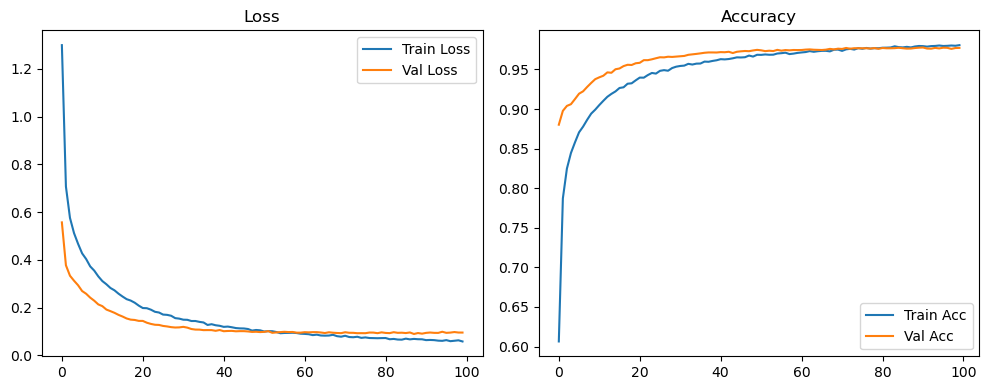

🏆 Best Config: batch64_lr0.01_0.005_0.001_dp0.2 Accuracy: 0.9872


In [8]:
root_path = "MLP_256_float_regular_Sigmoid"

epochs = 100
batch_sizes = [64, 128, 256]
dropout_rates = [0.0, 0.2, 0.5]
lr_pool = [0.01, 0.005, 0.002, 0.001]

Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates)